<p style="font-family: Cambria; font-size:2.5em;color:Black;"> BERTweet (base) for Multiclass and Multilabel Classification in Sentiment Analysis of Autonomous Vehicle Tweets</p>

>**The aim of this notebook is to compare the performance of multiclass and multilabel classification in order to choose the more accurate classification type.**

# Method

To ensure a fair comparison between the selected models, the manually labeled dataset was split into training, validation, and test subsets. Hyperparameters were then rigorously selected using the validation dataset. Finally, the models were evaluated using the test dataset and a 5 fold cross-validation.

For the BERT model, a Bayesian optimization method was employed using the Optuna library. Bayesian optimization is favored over grid search for hyperparameter tuning in BERT model because it efficiently explores the hyperparameter space by leveraging past evaluation results to inform future trials. This approach leads to faster convergence on optimal parameters with fewer evaluations. The text length and vocabulary limits were defined following a descriptive analysis. The other parameters were selected to accommodate the challenges posed by the small sample size of the data.

# Transformers Model Tested

## BERTweet base

"BERTweet is the first public large-scale language model pre-trained for English Tweets. BERTweet is trained based on the RoBERTa pre-training procedure. The corpus used to pre-train BERTweet consists of 850M English Tweets (16B word tokens ~ 80GB), containing 845M Tweets streamed from 01/2012 to 08/2019 and 5M Tweets related to the COVID-19 pandemic."<br>
Source for BERTweet base: https://huggingface.co/vinai/bertweet-base<br>
Article webpage: https://aclanthology.org/2020.emnlp-demos.2/<br>
Article in PDF: https://aclanthology.org/2020.emnlp-demos.2.pdf<br>




## Hardware and Software Environment

The system utilizes Pytorch 2.5.1, supporting both FP32 and FP16 precision operations. The NVIDIA L4 GPU (24GB GDDR6), based on the Ada Lovelace architecture, provides hardware support for tensor operations with compute capability 8.9.

The experiments were conducted with the following specifications:

Computing Hardware:
- GPU: NVIDIA L4 (Ada Lovelace architecture) with 24GB GDDR6 memory
- CPU: AMD EPYC 9454 48-Core Processor
- System Memory: 346GB RAM
- GPU Driver Version: 550.90.07
- CUDA Version: 12.4

Software Stack:
- Operating System: Linux 5.15.0-122-generic
- Pytorch: Version 2.5.1
- Python: Version 3.9.21
- GCC Compiler: Version 11.3.0
- NVIDIA CUDA Runtime: Version 12.4

GPU Performance Metrics:
- Maximum Power Capacity: 72W
- Available GPU Memory: 23,034 MiB

System Configuration:
- CPU Architecture: x86_64 with 90 available cores
- L3 Cache: 1.4 GiB
- CPU Features: Support for AVX-512, FMA, and other advanced instruction sets
- Virtualization: Full AMD-V virtualization under KVM hypervisor


## Label Mapping

**Multiclass Classification**

  Column name: 'Label_B_emotion'<br>
  0: Negative<br>
  1: Neutral or informative<br>
  2: Positive<br>

**Multilabel Classification**

Column names:  'Label_A2_negative', 'Label_A3_neutral', 'Label_A1_positive'

Sentiment label mapping:<br>
- 0 = absence of sentiment,<br>
- 1 = presence of sentiment

# Library installation

**Python version** <br>
    3.9.21

**Install Pytorch** <br>
Install Pytorch version: 2.5.1 with GPU support (CUDA version: 12.1) and other required packages<br>
`conda install pytorch torchvision torchaudio pytorch-cuda=12.1 -c pytorch -c nvidia`<br>

**Core libraries** <br>
`pip install transformers[torch]`  # Transformers version: 4.47.1<br>
`conda install -c conda-forge scikit-learn`  # Scikit-learn version: 1.6.0<br>
`conda install -c conda-forge pandas numpy`  # Pandas version: 2.2.3 # NumPy version: 1.26.4<br>
`pip install matplotlib seaborn`  # Matplotlib version: 3.9.4 # Seaborn version: 0.13.2<br>
`pip install accelerate>=0.26.0` # Accelerate version: 0.26.0<br>

**Jupyter support** <br>
`conda install -c conda-forge jupyterlab` # JupyterLab version: 4.3.4<br>
`conda install -c conda-forge ipywidgets` # IPywidgets version: 8.1.5<br>

**Additional utilities** <br>
`conda install -c conda-forge pyreadstat` # Pyreadstat version: 1.2.7<br>
`conda install -c conda-forge optuna` # Optuna version: 4.1.0<br>
`conda install -c conda-forge torchinfo` # Torchinfo version: 1.8.0<br>
`pip install torchviz` # graphviz version: 0.20.3 # sympy version: 1.13.1 # torchviz version: 0.0.3<br>
`pip install emoji==0.6.0` # for Bertweet (base)<br>

# Import libraries

In [17]:
# Applying a deterministic approach
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

In [18]:
# =============================================================================
# Disable Python warnings
# =============================================================================
import warnings
warnings.filterwarnings('ignore')                                     # Suppress all warning messages
warnings.filterwarnings('ignore', 
                        category=UserWarning, module='transformers')  # Suppress transformers messages

# =============================================================================
# Core Data Processing and Scientific Computing
# =============================================================================
import sys                            # System-specific parameters and functions
import numpy as np                    # Numerical computing and array operations
import pandas as pd                   # Data manipulation and analysis
import json                           # JSON file handling
from collections import Counter       # Container for counting hashable objects
import time                           # Time access and conversions
from datetime import datetime         # Date and time operations
from scipy import stats               # Statistical functions and tests

# =============================================================================
# Machine Learning and Deep Learning
# =============================================================================
import torch                          # PyTorch deep learning framework
import torchinfo                      # Model summary information
from torch.utils.data import Dataset  # Dataset class for PyTorch

# Transformers
import transformers
from transformers import (
    AdamW,                              # Optimizer
    AutoConfig,
    AutoTokenizer,                      # Tokenizer loading
    AutoModelForSequenceClassification, # Model loading
    EarlyStoppingCallback,               # Early stopping utility
    get_linear_schedule_with_warmup,    # Learning rate scheduler
    Trainer,                            # Training helper
    TrainingArguments,                  # Training configuration
    TrainerCallback                     # Base callback class
)

# Scikit-learn
import sklearn
from sklearn.model_selection import (
    train_test_split,                  # Split dataset into train and test sets
    KFold,                             # K-Fold cross-validation
    StratifiedKFold                    # Stratified K-Fold cross-validation
)
from sklearn.metrics import (
    accuracy_score,                    # Calculate accuracy metric
    confusion_matrix,                  # Calculate confusion matrix
    f1_score,                          # Calculate F1 score
    precision_score,                   # Calculate precision metric
    recall_score,                      # Calculate recall metric
    roc_curve,                         # Calculate ROC curve points
    auc,                               # Calculate Area Under Curve
    classification_report,             # Generate detailed classification metrics
    roc_auc_score,                     # Calculate ROC AUC score
    cohen_kappa_score,
    jaccard_score,
    hamming_loss,
    multilabel_confusion_matrix        # Calculate confusion matrix for each label
)
from sklearn.preprocessing import label_binarize  # Convert labels to binary format
import pyreadstat

# =============================================================================
# Visualization
# =============================================================================
import matplotlib.pyplot as plt          # Basic plotting library
import matplotlib.image as mpimg         # Image loading utility
from matplotlib import gridspec          # Complex grid layout management
import seaborn as sns                    # Statistical data visualization

# Visualization Settings
plt.rcParams['figure.dpi'] = 100        # Set figure resolution
sns.set_palette("tab20")                # Set default color palette
SMALL_SIZE = 12                         # Define font size for small text
MEDIUM_SIZE = 13                        # Define font size for medium text
BIGGER_SIZE = 14                        # Define font size for large text

# Configure plot styling
plt.rc('font', size=SMALL_SIZE)         # Set default font size
plt.rc('axes', titlesize=MEDIUM_SIZE)    # Set axes title size
plt.rc('axes', labelsize=MEDIUM_SIZE)    # Set axes label size
plt.rc('axes', labelweight='normal')     # Set axes label weight
plt.rc('axes', labelcolor='black')       # Set axes label color
plt.rc('axes', labelpad=5)               # Set padding between label and axis
plt.rc('axes', titlepad=10)              # Set padding between title and plot
plt.rc('xtick', labelsize=MEDIUM_SIZE)   # Set x-tick label size
plt.rc('ytick', labelsize=MEDIUM_SIZE)   # Set y-tick label size
plt.rc('legend', fontsize=SMALL_SIZE)    # Set legend font size
plt.rc('figure', titlesize=MEDIUM_SIZE)  # Set figure title size
plt.rc('figure', labelsize=BIGGER_SIZE)  # Set figure label size
sns.set_style("darkgrid", {'axes.grid': False})  # Set plot style with no grid

# =============================================================================
# Utility Modules
# =============================================================================
import os                              # Operating system interface
import random                          # Random number generation
import optuna                          # Hyperparameter optimization
import logging                         # Logging facility for Python
import platform                        # System platform information
import jupyterlab                      # JupyterLab interface
import ipywidgets                      # Interactive widgets
import copy                            # Deep copy operations
import pickle                          # Object serialization
from pathlib import Path               # Object-oriented filesystem paths
from IPython.display import display, HTML  # Display objects in notebook

In [19]:
# Record the start time for measuring total notebook execution duration
start_global_notebook_running_time = time.time()

In [20]:
# System Information
print("="*50)
print("SYSTEM INFORMATION")
print("="*50)
print(f"Python version: {sys.version.split()[0]}")
print(f"Platform: {platform.platform()}")
print(f"Machine: {platform.machine()}")

# Core ML Libraries
print("\n" + "="*50)
print("CORE ML LIBRARIES")
print("="*50)
print(f"PyTorch version: {torch.__version__}")
print(f"Transformers version: {transformers.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

# Additional Utilities
print("\n" + "="*50)
print("ADDITIONAL UTILITIES")
print("="*50)
print(f"Optuna version: {optuna.__version__}")
print(f"Torchinfo version: {torchinfo.__version__}")  # Changed this line
print(f"JupyterLab version: {jupyterlab.__version__}")
print(f"IPywidgets version: {ipywidgets.__version__}")
print(f"Pyreadstat version: {pyreadstat.__version__}")


SYSTEM INFORMATION
Python version: 3.9.21
Platform: Linux-5.15.0-122-generic-x86_64-with-glibc2.35
Machine: x86_64

CORE ML LIBRARIES
PyTorch version: 2.5.1
Transformers version: 4.47.1
Pandas version: 2.2.3
NumPy version: 1.26.4
Scikit-learn version: 1.6.0
Matplotlib version: 3.9.4
Seaborn version: 0.13.2

ADDITIONAL UTILITIES
Optuna version: 4.1.0
Torchinfo version: 1.8.0
JupyterLab version: 4.3.4
IPywidgets version: 8.1.5
Pyreadstat version: 1.2.7


# GPU verification

In [21]:
# Check CUDA availability
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
print(f"PyTorch version: {torch.__version__}")

# Check GPU properties
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

CUDA available: True
CUDA version: 12.4
PyTorch version: 2.5.1
GPU Device: NVIDIA L4
GPU Memory: 21.95 GB


# Data opening & preparation

## Data Opening

In [6]:
# Read all datasets
trainDf = pd.read_csv('/workspace/train60_data_mapped.csv', sep=";") #60% of the labeled tweets
valDf = pd.read_csv('/workspace/val20_data_mapped.csv', sep=";")     #20% of the labeled tweets
testDf = pd.read_csv('/workspace/test20_data_mapped.csv', sep=";")   #20% of the labeled tweets

# Concatenate all dataframes
df = pd.concat([trainDf, valDf, testDf], axis=0, ignore_index=True)

# sample for rush the code development
#trainDf = trainDf.head(60)
#valDf = valDf.head(20)
#testDf = testDf.head(20)

# Display information about the combined dataset
print("\nCombined Dataset Info:")
print("Shape:", df.shape)

# Display basic information about each dataset
print("\nTraining Dataset Info:")
print("Shape:", trainDf.shape)

print("\nValidation Dataset Info:")
print("Shape:", valDf.shape)

print("\nTest Dataset Info:")
print("Shape:", testDf.shape)


Combined Dataset Info:
Shape: (1198, 7)

Training Dataset Info:
Shape: (718, 7)

Validation Dataset Info:
Shape: (240, 7)

Test Dataset Info:
Shape: (240, 7)


# Multiclass classification using BERTweet

## Multiclass & Text: preparing training, validation and testing datasets

In [7]:
# Extracting features (text) and labels from training DataFrame
X_train = trainDf['text'].tolist()
y_train = trainDf['Label_B_emotion'].tolist()
"""
Training Data (60%):
Features (X_train) and labels (y_train) extracted from the training dataset for model development.
"""

# Extracting features (text) and labels from validation DataFrame
X_val = valDf['text'].tolist()
y_val = valDf['Label_B_emotion'].tolist()
"""
Validation Data (20%):
Features (X_val) and labels (y_val) extracted from the validation dataset for model optimization.
"""

# Extracting features (text) and labels from test DataFrame
X_test = testDf['text'].tolist()
y_test = testDf['Label_B_emotion'].tolist()
"""
Test Data (20%):
Features (X_test) and labels (y_test) extracted from the test dataset for final performance evaluation.
"""

'\nTest Data (20%):\nFeatures (X_test) and labels (y_test) extracted from the test dataset for final performance evaluation.\n'

## Metrics Definition for Multiclass Classification

In [8]:
# the metrics are used into optuna code

# Custom metrics functions
def metric2_MC(y_true, y_pred):
    """
    Implementation of Metric 2 following the original formula:
    1 - (1/M)∑(j=1 to M)[(∑(i=1 to N) 𝟙(|y_true_{i,j} - round(y_pred_{i,j})| = 1))/N]
    
    Parameters:
    y_true : array-like of shape (n_samples,)
        Ground truth labels
    y_pred : array-like of shape (n_samples,)
        Predicted labels
        
    Returns:
    float : The computed metric value
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    y_pred_rounded = np.round(y_pred)
    
    differences = np.abs(y_true - y_pred_rounded)
    
    n_classes = len(np.unique(y_true))
    
    off_by_one_per_class = []
    for j in range(n_classes):
        class_mask = (y_true == j)
        if np.sum(class_mask) > 0:
            off_by_one = np.sum((differences == 1) & class_mask)
            proportion = off_by_one / np.sum(class_mask)
            off_by_one_per_class.append(proportion)
    
    metric = 1 - np.mean(off_by_one_per_class)
    return metric

def macro_accuracy(y_true, y_pred):
    """
    Implementation of Macro Accuracy following the original formula::
    \[
    \text{Macro Accuracy} = \frac{1}{C} \sum_{c=1}^{C} \frac{\text{TP}_c}{\text{TP}_c + \text{FN}_c}
    \]

    Where:
    - \( C \) is the number of classes.
    - \( \text{TP}_c \) is the number of true positives for class \( c \).
    - \( \text{FN}_c \) is the number of false negatives for class \( c \).

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
    """
    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Get unique classes
    classes = np.unique(y_true)
    
    # Compute per-class accuracy
    class_accuracies = []
    for c in classes:
        # Samples of this class in true labels
        class_mask = (y_true == c)
        
        # Total samples in this class
        total_class_samples = np.sum(class_mask)
        
        if total_class_samples > 0:
            # Correctly predicted samples in this class
            correct_predictions = np.sum((y_true[class_mask] == c) & (y_pred[class_mask] == c))
            
            # Compute class accuracy
            class_accuracy = correct_predictions / total_class_samples
            class_accuracies.append(class_accuracy)
    
    # Macro accuracy is the mean of per-class accuracies
    macro_accuracy = np.mean(class_accuracies) if class_accuracies else 0
    
    return macro_accuracy
    
    

def weighted_accuracy(y_true, y_pred):
    """
    Calculate weighted accuracy for multiclass classification, where the weight
    of each class is inversely proportional to its frequency in the dataset.
    
    Parameters:
    y_true : array-like of shape (n_samples,)
        Ground truth labels
    y_pred : array-like of shape (n_samples,)
        Predicted labels
        
    Returns:
    float : Weighted accuracy score
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    classes = np.unique(y_true)
    n_classes = len(classes)
    
    class_accuracies = []
    weights = []
    
    for c in classes:
        class_mask = (y_true == c)
        n_samples_class = np.sum(class_mask)
        
        if n_samples_class == 0:
            continue
            
        weight = len(y_true) / (n_classes * n_samples_class)
        
        class_accuracy = np.sum((y_true == c) & (y_pred == c)) / n_samples_class
        
        class_accuracies.append(class_accuracy)
        weights.append(weight)
    
    weights = np.array(weights)
    weights = weights / np.sum(weights)
    
    return np.sum(np.array(class_accuracies) * weights)

def weighted_f1(y_true, y_pred):
    """
    Compute the weighted F1 score for multi-class classification.
    
    Parameters:
    y_true : array-like of shape (n_samples,)
        Ground truth labels
    y_pred : array-like of shape (n_samples,)
        Predicted labels
        
    Returns:
    float : Weighted F1 score
    """
    return f1_score(y_true, y_pred, average='weighted')

## Optuna Params Search for Multiclass Classification - Baysian Approach

**Method for Selecting the Best Model**

A custum score (balanced score) was calculated using the following distribution of weights:
- Weighted_f1: 40% weight on F1 score
- Normalized Loss: 30% weight on loss
- Cross-Validation Stability: 30% weight.

The `calculate_balanced_score` function computes a score ranging from 0 to 1. A value closer to 1 indicates better model performance.

**Tested Hyperparameters**
```
'learning_rate': trial.suggest_categorical('learning_rate', [5e-05, 1e-05, 0.0001]),
'num_train_epochs': trial.suggest_categorical('num_train_epochs', [4, 7, 10, 13]),
'batch_size': trial.suggest_categorical('batch_size', [4, 8, 16, 32]),
'warmup_steps': trial.suggest_categorical('warmup_steps', [250, 500, 750, 1000]),
'weight_decay': trial.suggest_categorical('weight_decay', [0.005, 0.001, 0.01]),
'warmup_ratio': trial.suggest_categorical('warmup_ratio', [0.05, 0.1, 0.2]),
'max_length': trial.suggest_categorical('max_length', [92, 115, 130])

```

In [9]:
# ===========================================================================================================
#                              Optuna Hyperparameters Search for BERTweet (base)
#                          Full Deterministisc Approach to Ensure Reproductibility
# ===========================================================================================================


# Disable parallelism for tokenizers to better fit small training datasets
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

# Start timing
start = time.time()

def set_seed(seed=42):
    """Set all random seeds for full reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

class TweetDataset(Dataset):
    """Original TweetDataset class with docstring"""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        return item

    def __len__(self):
        return len(self.labels)

class SentimentAnalysisOptuna:
    def __init__(self, model_name='vinai/bertweet-base', num_labels=3, use_fast=True, normalization=True, max_length=115, seed=42):
        # Set seed for reproducibility
        self.seed = seed
        set_seed(self.seed)
        self.model_name = model_name
        self.num_labels = num_labels
        self.use_fast = use_fast
        self.normalization = normalization
        self.max_length = max_length
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Lines for deterministic behavior
        torch.use_deterministic_algorithms(True) 
        os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8" 
        
        # Create output directories
        self.output_base_path = "/workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Optuna_search"
        os.makedirs(self.output_base_path, exist_ok=True)
        os.makedirs(os.path.join(self.output_base_path, 'Metrics'), exist_ok=True)
        
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name,
            use_fast=self.use_fast,
            normalization=self.normalization
        )
        self.cv_metrics = []
        self.original_train_texts = None
        self.original_train_labels = None
        self.original_val_texts = None
        self.original_val_labels = None
        self.tried_configurations = set()

    def preprocess_text(self, texts):
        """Preprocess text data: converting to lower case"""
        if isinstance(texts, str):
            texts = [texts]
        texts = [text.lower() if isinstance(text, str) else str(text).lower() for text in texts]
        return texts

    def create_dataset(self, texts, labels):
        """Create tokenized dataset with deterministic processing"""
        generator = torch.Generator() 
        generator.manual_seed(self.seed) 
    
        #torch.manual_seed(self.seed) # removing
        preprocessed_texts = self.preprocess_text(texts)
        encodings = self.tokenizer(
            preprocessed_texts,
            truncation=True,
            padding=True,
            max_length=self.max_length,
            return_tensors='pt',
            return_attention_mask=True
        )
        return TweetDataset(encodings, labels)

    def calculate_balanced_score(self, weighted_f1, normalized_loss, cv_stability):
        """Calculate balanced score ensuring output is between 0 and 1"""
        try:
            weights = {
                'weighted_f1': 0.4,
                'normalized_loss': 0.3,
                'cv_stability': 0.3
            }
            weighted_f1 = max(0.0, min(1.0, weighted_f1))
            normalized_loss = max(0.0, min(1.0, normalized_loss))
            cv_stability = max(0.0, min(1.0, cv_stability))
            balanced_score = (
                (weighted_f1 * weights['weighted_f1']) +
                ((1 - normalized_loss) * weights['normalized_loss']) +
                (cv_stability * weights['cv_stability'])
            )
            return max(0.0, min(1.0, balanced_score))
        except Exception as e:
            print(f"Error in calculate_balanced_score: {str(e)}")
            return 0.0

    def create_optimizer(self, model, num_training_steps):
        """Create optimizer with parameter-specific settings"""
        try:
            no_decay = ['bias', 'LayerNorm.weight']
            optimizer_grouped_parameters = [
                {
                    'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                    'weight_decay': self.weight_decay
                },
                {
                    'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                    'weight_decay': 0.0
                }
            ]
            optimizer = AdamW(
                optimizer_grouped_parameters,
                lr=self.learning_rate
            )
            scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=self.warmup_steps,
                num_training_steps=num_training_steps
            )
            return optimizer, scheduler
        except Exception as e:
            print(f"Error in create_optimizer: {str(e)}")
            raise

    def normalize_loss(self, loss, min_loss=None, max_loss=None):
        """Normalize loss to 0-1 range"""
        if min_loss is None or max_loss is None:
            return 1 - loss
        if max_loss == min_loss:
            return 1.0 if loss == min_loss else 0.0
        return (max_loss - loss) / (max_loss - min_loss)

    def compute_cross_validation_stability(self, metrics):
        """Compute cross-validation stability"""
        if len(metrics) < 2:
            return 1.0
        std_dev = np.std(metrics)
        mean = np.mean(metrics)
        if mean == 0:
            return 0.0
        cv = std_dev / mean
        stability = 1 / (1 + cv)
        return stability

    def _get_configuration_hash(self, trial_params):
        """Generate hash for trial parameters"""
        param_str = json.dumps(sorted(trial_params.items()))
        return hash(param_str)

    def compute_metrics_callback(self, eval_pred):
        """Callback for computing metrics during training"""
        try:
            logits, labels = eval_pred
            preds = np.argmax(logits, axis=-1)
            metrics = {
                'weighted_f1': weighted_f1(labels, preds),
                'macro_accuracy': macro_accuracy(labels, preds),
                'weighted_accuracy': weighted_accuracy(labels, preds),
                'metric2_MC': metric2_MC(labels, preds)
            }
            eval_loss = torch.nn.functional.cross_entropy(
                torch.tensor(logits),
                torch.tensor(labels)
            ).item()
            normalized_loss = max(0.0, min(1.0, eval_loss / 5.0))
            
            if not hasattr(self, 'cv_metrics'):
                self.cv_metrics = []
            self.cv_metrics.append(metrics['weighted_f1'])
            cv_stability = self.compute_cross_validation_stability(self.cv_metrics)
            
            balanced_score = self.calculate_balanced_score(
                metrics['weighted_f1'],
                normalized_loss,
                cv_stability
            )
            
            metrics.update({
                'eval_loss': eval_loss,
                'normalized_loss': normalized_loss,
                'cv_stability': cv_stability,
                'balanced_score': balanced_score
            })
            
            return metrics
        except Exception as e:
            print(f"Error in compute_metrics_callback: {str(e)}")
            return {
                'weighted_f1': 0.0,
                'macro_accuracy': 0.0,
                'weighted_accuracy': 0.0,
                'metric2_MC': 0.0,
                'eval_loss': 0.0,
                'normalized_loss': 0.0,
                'cv_stability': 0.0,
                'balanced_score': 0.0
            }

    def objective(self, trial):
        """Optuna objective function for hyperparameter optimization"""
        try:
            # Set seed for this trial
            trial_seed = self.seed + trial.number
            set_seed(trial_seed)
            
            trial_params = {
                'learning_rate': trial.suggest_categorical('learning_rate', [1e-06, 1e-05, 5e-05, 0.0001]),
                'num_train_epochs': trial.suggest_categorical('num_train_epochs', [4, 7, 10, 13]),
                'batch_size': trial.suggest_categorical('batch_size', [4, 8, 16, 32]),
                'warmup_steps': trial.suggest_categorical('warmup_steps', [250, 500, 750, 1000]),
                'weight_decay': trial.suggest_categorical('weight_decay', [0.05, 0.01, 0.1]),
                'warmup_ratio': trial.suggest_categorical('warmup_ratio', [0.005, 0.01, 0.1, 0.2]),
                'max_length': trial.suggest_categorical('max_length', [92, 115, 130])
            }
            
            config_hash = self._get_configuration_hash(trial_params)
            if config_hash in self.tried_configurations:
                raise optuna.exceptions.TrialPruned("Duplicate configuration")
            self.tried_configurations.add(config_hash)
            
            train_dataset = self.create_dataset(self.original_train_texts, self.original_train_labels)
            val_dataset = self.create_dataset(self.original_val_texts, self.original_val_labels)
            
            num_training_steps = (
                len(train_dataset) * trial_params['num_train_epochs'] // trial_params['batch_size']
            )
            
            self.learning_rate = trial_params['learning_rate']
            self.weight_decay = trial_params['weight_decay']
            self.warmup_steps = trial_params['warmup_steps']
            
            model = AutoModelForSequenceClassification.from_pretrained(
                self.model_name,
                num_labels=self.num_labels
            ).to(self.device)
            
            optimizer, scheduler = self.create_optimizer(model, num_training_steps)
            
            training_args = TrainingArguments(
                output_dir=os.path.join(self.output_base_path, 'Metrics', f'trial_{trial.number}'),
                learning_rate=trial_params['learning_rate'],
                num_train_epochs=trial_params['num_train_epochs'],
                per_device_train_batch_size=trial_params['batch_size'],
                per_device_eval_batch_size=trial_params['batch_size'],
                gradient_accumulation_steps=2,
                warmup_steps=trial_params['warmup_steps'],
                warmup_ratio=trial_params['warmup_ratio'],
                weight_decay=trial_params['weight_decay'],
                logging_dir=os.path.join(self.output_base_path, 'logs'),
                logging_steps=100,
                evaluation_strategy="epoch",
                save_strategy="epoch",
                load_best_model_at_end=True,
                metric_for_best_model="balanced_score",
                greater_is_better=True,
                save_total_limit=2,
                fp16=True,
                report_to='none',
                dataloader_pin_memory=False, # adding
                seed=trial_seed,
                dataloader_num_workers=1
            )
            
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=val_dataset,
                compute_metrics=self.compute_metrics_callback,
                optimizers=(optimizer, scheduler),
                callbacks=[
                    EarlyStoppingCallback(
                        early_stopping_patience=3,
                        early_stopping_threshold=0.01
                    )
                ]
            )
            
            try:
                train_result = trainer.train()
                eval_results = trainer.evaluate()
                
                if eval_results is None or 'eval_balanced_score' not in eval_results:
                    print(f"Trial {trial.number}: No valid evaluation results")
                    return 0.0
                
                trial.set_user_attr('metrics', eval_results)
                
                trial_info = {
                    'trial_number': trial.number,
                    'seed': trial_seed,
                    'hyperparameters': trial_params,
                    'metrics': eval_results
                }
                
                output_path = os.path.join(self.output_base_path, 'Metrics')
                os.makedirs(output_path, exist_ok=True)
                with open(os.path.join(output_path, f'BERTweet_MC_optuna_trial_{trial.number}_details.json'), 'w') as f:
                    json.dump(trial_info, f, indent=4)
                
                balanced_score = max(0.0, min(1.0, float(eval_results.get('eval_balanced_score', 0.0))))
                
                print(f"\nTrial {trial.number} completed successfully:")
                print(f"Seed: {trial_seed}")
                print(f"Balanced Score: {balanced_score}")
                
                return balanced_score
            
            except Exception as e:
                print(f"\nError during training in trial {trial.number}: {str(e)}")
                return 0.0
        
        except Exception as e:
            print(f"\nError in objective for trial {trial.number}: {str(e)}")
            return 0.0

    def save_trials_to_csv(self, study, output_path):
        """Save all trial details to a DataFrame"""
        trial_details = []
        for trial in study.trials:
            if trial.state == optuna.trial.TrialState.COMPLETE:
                # Extract hyperparameters
                params = trial.params
                # Extract metrics
                metrics = trial.user_attrs.get('metrics', {})
                # Combine hyperparameters and metrics
                trial_info = {
                    # Trial Information
                    'trial_number': trial.number,
                    'seed': self.seed + trial.number,
                    # Hyperparameters
                    'learning_rate': params.get('learning_rate', None),
                    'num_train_epochs': params.get('num_train_epochs', None),
                    'batch_size': params.get('batch_size', None),
                    'warmup_steps': params.get('warmup_steps', None),
                    'weight_decay': params.get('weight_decay', None),
                    'max_length': params.get('max_length', None),
                    # Balanced Score
                    'balanced_score': trial.value,
                    # Evaluation Metrics - without 'eval_' prefix
                    'loss': metrics.get('eval_loss', None),
                    'weighted_f1': metrics.get('eval_weighted_f1', None),
                    'macro_accuracy': metrics.get('eval_macro_accuracy', None),
                    'weighted_accuracy': metrics.get('eval_weighted_accuracy', None),
                    'metric2_MC': metrics.get('eval_metric2_MC', None),
                    'normalized_loss': metrics.get('eval_normalized_loss', None),
                    'cv_stability': metrics.get('eval_cv_stability', None),
                    'runtime': metrics.get('eval_runtime', None),
                    'samples_per_second': metrics.get('eval_samples_per_second', None),
                    'steps_per_second': metrics.get('eval_steps_per_second', None)
                }
                trial_details.append(trial_info)
        # Create DataFrame
        df = pd.DataFrame(trial_details)
        return df

def main(X_train, y_train, X_val, y_val, n_trials=35, seed=42):
    """Main hyperparameter optimization pipeline"""
    # Set global seed
    set_seed(seed)

    # Set deterministic environment
    os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

    # Ensure Optuna logging is at INFO level
    optuna.logging.set_verbosity(optuna.logging.INFO)

    # Update output path
    output_path = "/workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Optuna_search"
    os.makedirs(output_path, exist_ok=True)

    # Define database path
    db_path = os.path.join(output_path, 'BERTweet_MC_optuna_study.db')
    if os.path.exists(db_path):
        os.remove(db_path)

    print(f"Output directory: {output_path}")
    print(f"Database path: {db_path}")
    print(f"Using seed: {seed}")

    # Initialize pipeline with seed
    pipeline = SentimentAnalysisOptuna(
        num_labels=len(np.unique(y_train)),
        max_length=115,
        seed=seed
    )
    pipeline.original_train_texts = X_train
    pipeline.original_train_labels = y_train
    pipeline.original_val_texts = X_val
    pipeline.original_val_labels = y_val

    try:
        # Create sampler with fixed seed
        sampler = optuna.samplers.TPESampler(seed=seed)
        study = optuna.create_study(
            direction='maximize',
            storage=f'sqlite:///{db_path}',
            study_name='BERTweet_MC_optuna_search',
            sampler=sampler
        )

        # Run optimization with single worker for reproducibility
        study.optimize(pipeline.objective, n_trials=n_trials, n_jobs=1)

        # Get trial results DataFrame
        results_df = pipeline.save_trials_to_csv(study, output_path)

        # Save best parameters
        best_params_path = os.path.join(output_path, 'BERTweet_MC_best_hyperparameters.json')
        with open(best_params_path, 'w') as f:
            json.dump(study.best_params, f, indent=4)

        # Save results DataFrame to CSV
        csv_path = os.path.join(output_path, 'BERTweet_MC_optuna_hyperparameter_search_results.csv')
        results_df.to_csv(csv_path, sep=';', index=False)
        print(f"Trial results saved to {csv_path}")

        # Print summary
        print("\n===== Best Trial Summary =====")
        trial = study.best_trial
        print(f"Best Trial Number: {trial.number}")
        print(f"Best Trial Seed: {seed + trial.number}")
        print(f"Best Balanced Score: {trial.value}")
        print("Best Hyperparameters:")
        for key, value in trial.params.items():
            print(f" {key}: {value}")

        # Calculate execution duration
        end = time.time()
        hours, rem = divmod(end - start, 3600)
        minutes, seconds = divmod(rem, 60)
        print("\n>>>>>>>>> Execution Duration \n {:0>2} hours {:0>2} minutes {:02.0f} seconds".format(
            int(hours), int(minutes), seconds))

        return study
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        print(f"Current working directory: {os.getcwd()}")
        print(f"Directory exists: {os.path.exists(os.path.dirname(db_path))}")
        print(f"Directory is writable: {os.access(os.path.dirname(db_path), os.W_OK)}")
        raise

if __name__ == "__main__":
    SEED = 42  # Set your desired seed
    study = main(X_train, y_train, X_val, y_val, seed=SEED)


Output directory: /workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Optuna_search
Database path: /workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Optuna_search/BERTweet_MC_optuna_study.db
Using seed: 42


config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.91M [00:00<?, ?B/s]

[I 2025-01-08 18:57:12,058] A new study created in RDB with name: BERTweet_MC_optuna_search


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.098812,0.318414,0.386407,0.380993,0.666829,0.219763,1.000000,0.661436,0.347000,691.602000,23.053000
2,No log,1.098568,0.312374,0.373305,0.367322,0.662662,0.219710,0.990517,0.656192,0.304800,787.420000,26.247000
3,No log,1.097799,0.322536,0.385353,0.378924,0.666829,0.219564,0.987038,0.659257,0.346100,693.513000,23.117000
4,No log,1.096753,0.332541,0.397702,0.391117,0.666829,0.219349,0.977663,0.660510,0.310000,774.188000,25.806000


[I 2025-01-08 18:57:38,961] Trial 0 finished with value: 0.655316494282224 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 13, 'batch_size': 32, 'warmup_steps': 250, 'weight_decay': 0.01, 'warmup_ratio': 0.01, 'max_length': 130}. Best is trial 0 with value: 0.655316494282224.



Trial 0 completed successfully:
Seed: 42
Balanced Score: 0.655316494282224


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.080583,0.502122,0.518747,0.512471,0.679289,0.216117,0.838077,0.687437,1.128600,212.651000,53.163000
2,2.203700,0.874151,0.604010,0.605344,0.606507,0.739983,0.174831,0.781078,0.723478,1.118300,214.613000,53.653000
3,1.916600,0.975900,0.576452,0.591273,0.594985,0.733341,0.195174,0.775031,0.704538,1.169500,205.215000,51.304000
4,1.343200,1.231241,0.604277,0.603930,0.603672,0.738870,0.246242,0.771821,0.699385,1.114700,215.303000,53.826000
5,0.636100,1.695734,0.596216,0.613981,0.615586,0.746561,0.339140,0.774242,0.669017,1.133900,211.654000,52.913000


[I 2025-01-08 18:59:00,179] Trial 1 finished with value: 0.7223869554769191 and parameters: {'learning_rate': 5e-05, 'num_train_epochs': 13, 'batch_size': 4, 'warmup_steps': 250, 'weight_decay': 0.01, 'warmup_ratio': 0.005, 'max_length': 115}. Best is trial 1 with value: 0.7223869554769191.



Trial 1 completed successfully:
Seed: 43
Balanced Score: 0.7223869554769191


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.106543,0.152778,0.324675,0.337009,0.324675,0.221310,0.740564,0.516887,0.428800,559.686000,34.980000
2,No log,1.106482,0.152778,0.324675,0.337009,0.324675,0.221301,0.715043,0.509234,0.420600,570.633000,35.665000
3,No log,1.106443,0.152778,0.324675,0.337009,0.324675,0.221289,0.695987,0.503520,0.851100,281.998000,17.625000
4,No log,1.106340,0.161296,0.328842,0.341171,0.328842,0.221267,0.682319,0.502834,0.423700,566.429000,35.402000


[I 2025-01-08 18:59:26,282] Trial 2 finished with value: 0.4957988579389267 and parameters: {'learning_rate': 1e-06, 'num_train_epochs': 13, 'batch_size': 16, 'warmup_steps': 1000, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'max_length': 115}. Best is trial 1 with value: 0.7223869554769191.



Trial 2 completed successfully:
Seed: 44
Balanced Score: 0.4957988579389267


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.100850,0.172023,0.337036,0.349237,0.345370,0.220162,0.662601,0.501541,0.413200,580.872000,36.305000
2,No log,1.096554,0.314696,0.387617,0.392072,0.499966,0.219308,0.667250,0.560261,0.419700,571.869000,35.742000
3,No log,1.085663,0.314392,0.404568,0.400563,0.666667,0.217135,0.676656,0.563613,0.440000,545.488000,34.093000


[I 2025-01-08 18:59:59,348] Trial 3 finished with value: 0.5716492886434028 and parameters: {'learning_rate': 5e-05, 'num_train_epochs': 4, 'batch_size': 16, 'warmup_steps': 750, 'weight_decay': 0.05, 'warmup_ratio': 0.005, 'max_length': 92}. Best is trial 1 with value: 0.7223869554769191.



Trial 3 completed successfully:
Seed: 45
Balanced Score: 0.5716492886434028


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.098505,0.183602,0.324548,0.323809,0.666667,0.219702,0.676730,0.510549,1.228100,195.421000,48.855000
2,2.199100,1.098313,0.191686,0.328564,0.327676,0.666667,0.219661,0.673433,0.512806,1.138800,210.753000,52.688000
3,2.200300,1.097805,0.211233,0.336446,0.335115,0.666667,0.219556,0.672074,0.520249,1.118700,214.538000,53.635000
4,2.193500,1.096991,0.229184,0.344327,0.342554,0.666667,0.219394,0.672157,0.527502,1.095900,219.001000,54.750000


[I 2025-01-08 19:01:05,555] Trial 4 finished with value: 0.5275741627860893 and parameters: {'learning_rate': 1e-06, 'num_train_epochs': 10, 'batch_size': 4, 'warmup_steps': 750, 'weight_decay': 0.01, 'warmup_ratio': 0.2, 'max_length': 92}. Best is trial 1 with value: 0.7223869554769191.



Trial 4 completed successfully:
Seed: 46
Balanced Score: 0.5275741627860893


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.099499,0.192542,0.346320,0.346501,0.675638,0.219901,0.670500,0.512196,0.651800,368.219000,46.027000
2,No log,1.099235,0.199438,0.346170,0.346206,0.671471,0.219847,0.669336,0.514622,0.670500,357.948000,44.743000
3,2.207400,1.098673,0.201312,0.350336,0.350368,0.675638,0.219733,0.668503,0.515156,0.709200,338.419000,42.302000
4,2.207400,1.097363,0.214212,0.350348,0.350404,0.675800,0.219472,0.668570,0.520414,0.746600,321.440000,40.180000


[I 2025-01-08 19:01:50,149] Trial 5 finished with value: 0.5204669516466272 and parameters: {'learning_rate': 1e-06, 'num_train_epochs': 4, 'batch_size': 8, 'warmup_steps': 250, 'weight_decay': 0.05, 'warmup_ratio': 0.01, 'max_length': 115}. Best is trial 1 with value: 0.7223869554769191.



Trial 5 completed successfully:
Seed: 47
Balanced Score: 0.5204669516466272


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.097988,0.186517,0.337500,0.325147,0.666667,0.219600,0.667516,0.508982,0.649900,369.290000,46.161000
2,No log,1.096527,0.204660,0.345833,0.333472,0.666667,0.219307,0.667442,0.516305,0.766900,312.939000,39.117000
3,2.202700,1.093976,0.275459,0.371888,0.360517,0.666667,0.218790,0.670218,0.545612,0.644400,372.439000,46.555000
4,2.202700,1.090873,0.305552,0.392744,0.381401,0.666991,0.218180,0.673604,0.558848,0.641100,374.372000,46.796000
5,2.193100,1.085592,0.410864,0.455492,0.448390,0.663926,0.217116,0.677111,0.602344,0.642200,373.738000,46.717000
6,2.193100,1.075855,0.414923,0.473012,0.462703,0.676125,0.215172,0.680448,0.605552,0.638500,375.879000,46.985000
7,2.159900,1.052077,0.470319,0.524681,0.515941,0.684620,0.210414,0.682575,0.629776,0.655700,365.994000,45.749000
8,2.159900,1.003432,0.608676,0.607308,0.606251,0.733915,0.200683,0.679019,0.686971,0.753900,318.344000,39.793000
9,2.014000,0.905807,0.637496,0.636835,0.636158,0.755560,0.181162,0.675155,0.703196,0.643100,373.171000,46.646000
10,2.014000,0.824552,0.686081,0.686303,0.685140,0.793281,0.164911,0.670038,0.725970,0.639600,375.246000,46.906000


[I 2025-01-08 19:03:30,481] Trial 6 finished with value: 0.7249074527605669 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 10, 'batch_size': 8, 'warmup_steps': 750, 'weight_decay': 0.1, 'warmup_ratio': 0.2, 'max_length': 115}. Best is trial 6 with value: 0.7249074527605669.



Trial 6 completed successfully:
Seed: 48
Balanced Score: 0.7249074527605669


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.100724,0.176765,0.328367,0.340215,0.348899,0.220147,0.664255,0.503938,0.425700,563.781000,35.236000
2,No log,1.100732,0.176765,0.328367,0.340215,0.348899,0.220145,0.662189,0.503319,0.419900,571.522000,35.720000
3,No log,1.100680,0.184953,0.332383,0.344082,0.352915,0.220132,0.659171,0.505693,0.374800,640.283000,40.018000


[I 2025-01-08 19:04:05,104] Trial 7 finished with value: 0.5052927448386413 and parameters: {'learning_rate': 1e-06, 'num_train_epochs': 4, 'batch_size': 16, 'warmup_steps': 1000, 'weight_decay': 0.05, 'warmup_ratio': 0.1, 'max_length': 130}. Best is trial 6 with value: 0.7249074527605669.



Trial 7 completed successfully:
Seed: 49
Balanced Score: 0.5052927448386413


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.100476,0.264624,0.320768,0.312416,0.647073,0.220097,0.659075,0.537543,0.304700,787.563000,26.252000
2,No log,1.096606,0.306459,0.372841,0.366401,0.666667,0.219322,0.661147,0.555131,0.316500,758.271000,25.276000
3,No log,1.089182,0.457863,0.462997,0.459286,0.646732,0.217837,0.663776,0.616927,0.319200,751.763000,25.059000
4,No log,1.071511,0.377853,0.428478,0.419558,0.648708,0.214300,0.666469,0.586792,0.306400,783.275000,26.109000
5,No log,1.008404,0.537138,0.541783,0.537703,0.713620,0.201679,0.667835,0.654702,0.309900,774.434000,25.814000
6,No log,0.898415,0.619455,0.621229,0.617478,0.769723,0.179682,0.667236,0.694048,0.304100,789.101000,26.303000
7,No log,0.909981,0.561919,0.581198,0.579193,0.722563,0.181995,0.668348,0.670673,0.346000,693.717000,23.124000
8,No log,0.892502,0.636469,0.648264,0.650801,0.739630,0.178499,0.667770,0.701369,0.328300,730.962000,24.365000
9,1.833400,1.032229,0.583736,0.604558,0.605086,0.737741,0.206453,0.668712,0.672172,0.295000,813.604000,27.120000


[I 2025-01-08 19:04:46,857] Trial 8 finished with value: 0.701617177471491 and parameters: {'learning_rate': 0.0001, 'num_train_epochs': 10, 'batch_size': 32, 'warmup_steps': 250, 'weight_decay': 0.1, 'warmup_ratio': 0.01, 'max_length': 115}. Best is trial 6 with value: 0.7249074527605669.



Trial 8 completed successfully:
Seed: 50
Balanced Score: 0.701617177471491


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.102926,0.207975,0.318128,0.319346,0.631381,0.220581,0.667630,0.517304,0.385000,623.360000,20.779000
2,No log,1.102572,0.207975,0.318128,0.319346,0.631381,0.220518,0.666729,0.517053,0.343600,698.482000,23.283000
3,No log,1.101917,0.206230,0.322132,0.323178,0.635385,0.220380,0.665843,0.516131,0.298600,803.743000,26.791000
4,No log,1.100875,0.205684,0.313961,0.315183,0.623198,0.220170,0.665003,0.515724,0.343500,698.700000,23.290000


[I 2025-01-08 19:05:10,549] Trial 9 finished with value: 0.5163003235486944 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 13, 'batch_size': 32, 'warmup_steps': 500, 'weight_decay': 0.1, 'warmup_ratio': 0.2, 'max_length': 92}. Best is trial 6 with value: 0.7249074527605669.



Trial 9 completed successfully:
Seed: 51
Balanced Score: 0.5163003235486944


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.107229,0.166667,0.333333,0.333021,0.666667,0.221451,0.662435,0.498962,0.653800,367.074000,45.884000
2,No log,1.103685,0.166667,0.333333,0.333021,0.666667,0.220731,0.660680,0.498652,0.638900,375.644000,46.956000
3,2.208700,1.098440,0.232141,0.356978,0.355338,0.662651,0.219694,0.660718,0.525163,0.758400,316.475000,39.559000
4,2.208700,1.093587,0.313273,0.378676,0.373849,0.662813,0.218718,0.662180,0.558348,0.658300,364.559000,45.570000
5,2.194300,1.085736,0.370535,0.416208,0.407449,0.672584,0.217142,0.664143,0.582315,0.651200,368.535000,46.067000
6,2.194300,1.072868,0.413120,0.461466,0.456098,0.680291,0.214571,0.666208,0.600739,0.740000,324.343000,40.543000
7,2.153300,1.045662,0.557662,0.558038,0.557705,0.700859,0.209137,0.667195,0.660483,0.631100,380.313000,47.539000


[I 2025-01-08 19:06:20,313] Trial 10 finished with value: 0.660790177527788 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 7, 'batch_size': 8, 'warmup_steps': 750, 'weight_decay': 0.1, 'warmup_ratio': 0.2, 'max_length': 115}. Best is trial 6 with value: 0.7249074527605669.



Trial 10 completed successfully:
Seed: 52
Balanced Score: 0.660790177527788


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.091425,0.212323,0.350000,0.337635,0.666667,0.218285,0.667689,0.519751,1.116600,214.933000,53.733000
2,2.195900,1.007931,0.556579,0.571427,0.567961,0.708174,0.201586,0.668717,0.662771,1.112100,215.814000,53.954000
3,2.115000,0.827421,0.621805,0.619218,0.617593,0.770372,0.165486,0.668715,0.699691,1.159900,206.907000,51.727000
4,1.566500,0.942299,0.566982,0.590403,0.593155,0.775292,0.188458,0.669700,0.671166,1.158700,207.134000,51.784000
5,1.118200,0.980133,0.659568,0.663807,0.665173,0.771236,0.196024,0.669158,0.705767,1.107800,216.653000,54.163000
6,0.701700,1.612202,0.617752,0.628457,0.627854,0.760886,0.322439,0.669544,0.651232,1.122000,213.901000,53.475000


[I 2025-01-08 19:08:18,730] Trial 11 finished with value: 0.705808710304979 and parameters: {'learning_rate': 5e-05, 'num_train_epochs': 10, 'batch_size': 4, 'warmup_steps': 500, 'weight_decay': 0.01, 'warmup_ratio': 0.005, 'max_length': 115}. Best is trial 6 with value: 0.7249074527605669.



Trial 11 completed successfully:
Seed: 53
Balanced Score: 0.705808710304979


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.094836,0.401575,0.424783,0.424419,0.650737,0.218967,0.670962,0.596229,0.649900,369.310000,46.164000
2,No log,1.058197,0.480359,0.501959,0.508118,0.590915,0.211635,0.672660,0.630451,0.693300,346.155000,43.269000
3,2.181400,0.868524,0.605198,0.606172,0.603937,0.748391,0.173703,0.673340,0.691970,0.648400,370.157000,46.270000
4,2.181400,0.859279,0.611028,0.614513,0.616556,0.745587,0.171856,0.673985,0.695050,0.636300,377.204000,47.150000
5,1.428800,1.136937,0.563210,0.578300,0.581702,0.677697,0.227387,0.675178,0.659621,0.643300,373.056000,46.632000
6,1.428800,1.156211,0.623976,0.625309,0.625654,0.748652,0.231237,0.675711,0.682933,0.676000,355.020000,44.377000


[I 2025-01-08 19:09:18,067] Trial 12 finished with value: 0.6957886580361471 and parameters: {'learning_rate': 5e-05, 'num_train_epochs': 7, 'batch_size': 8, 'warmup_steps': 250, 'weight_decay': 0.1, 'warmup_ratio': 0.005, 'max_length': 115}. Best is trial 6 with value: 0.7249074527605669.



Trial 12 completed successfully:
Seed: 54
Balanced Score: 0.6957886580361471


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.089783,0.295706,0.384416,0.393828,0.432608,0.217952,0.676911,0.555970,1.110300,216.152000,54.038000
2,2.213900,0.905882,0.572136,0.581102,0.578749,0.718702,0.181175,0.678020,0.677908,1.105300,217.136000,54.284000
3,2.008700,0.843692,0.641353,0.641935,0.638067,0.778381,0.168739,0.678392,0.709437,1.111500,215.932000,53.983000
4,1.447900,1.105824,0.573432,0.576067,0.572919,0.735555,0.221166,0.679507,0.666875,1.102600,217.662000,54.416000
5,0.822500,1.781625,0.589974,0.604434,0.608831,0.717938,0.356327,0.680484,0.633237,1.092000,219.775000,54.944000
6,0.688800,2.566334,0.510307,0.540955,0.548665,0.598234,0.513244,0.681911,0.554723,1.164200,206.149000,51.537000


[I 2025-01-08 19:11:21,210] Trial 13 finished with value: 0.710627106813497 and parameters: {'learning_rate': 0.0001, 'num_train_epochs': 13, 'batch_size': 4, 'warmup_steps': 750, 'weight_decay': 0.01, 'warmup_ratio': 0.005, 'max_length': 115}. Best is trial 6 with value: 0.7249074527605669.



Trial 13 completed successfully:
Seed: 55
Balanced Score: 0.710627106813497


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.097168,0.166667,0.333333,0.333021,0.666667,0.219435,0.680407,0.504958,1.214000,197.698000,49.425000
2,2.203000,1.076131,0.403581,0.471509,0.463718,0.675325,0.215231,0.681662,0.601362,1.136900,211.103000,52.776000
3,2.173300,0.953082,0.582334,0.585918,0.584234,0.747765,0.190615,0.682666,0.680549,1.121000,214.098000,53.524000
4,1.978500,0.866641,0.605979,0.611760,0.615229,0.697905,0.173322,0.683478,0.695438,1.111400,215.946000,53.987000
5,1.477700,0.811881,0.642491,0.648055,0.650330,0.763216,0.162376,0.683944,0.713467,1.114900,215.268000,53.817000
6,1.079300,0.888746,0.661245,0.665493,0.664397,0.785423,0.177751,0.684233,0.716442,1.118500,214.580000,53.645000
7,0.715600,1.139910,0.617865,0.616696,0.616645,0.803242,0.227979,0.684995,0.684251,1.134800,211.493000,52.873000
8,0.428700,1.301165,0.606131,0.609638,0.610895,0.764357,0.260237,0.685859,0.670139,1.161900,206.551000,51.638000


[I 2025-01-08 19:13:29,696] Trial 14 finished with value: 0.7170410693257774 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 10, 'batch_size': 4, 'warmup_steps': 250, 'weight_decay': 0.1, 'warmup_ratio': 0.2, 'max_length': 130}. Best is trial 6 with value: 0.7249074527605669.



Trial 14 completed successfully:
Seed: 56
Balanced Score: 0.7170410693257774


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.098655,0.178287,0.333333,0.320984,0.662500,0.219739,0.684510,0.510746,0.650000,369.251000,46.156000
2,No log,1.092415,0.243586,0.362813,0.350749,0.662662,0.218482,0.683956,0.537077,0.636300,377.182000,47.148000
3,2.194300,1.076428,0.250518,0.367142,0.355243,0.675325,0.215283,0.683525,0.540680,0.695600,345.022000,43.128000
4,2.194300,0.996470,0.463775,0.501470,0.498572,0.703026,0.199296,0.684776,0.631154,0.650300,369.071000,46.134000
5,2.069800,0.831151,0.663050,0.661835,0.661134,0.796474,0.166226,0.685093,0.720880,0.648600,370.008000,46.251000
6,2.069800,0.801332,0.645418,0.646316,0.646833,0.761176,0.160266,0.685612,0.715771,0.685100,350.319000,43.790000
7,1.297100,0.950885,0.630497,0.644260,0.646969,0.726991,0.190171,0.686275,0.701030,0.625500,383.667000,47.958000
8,1.297100,1.035118,0.613960,0.618211,0.615665,0.779355,0.207020,0.687068,0.689598,0.650500,368.951000,46.119000


[I 2025-01-08 19:14:48,487] Trial 15 finished with value: 0.7215936398333374 and parameters: {'learning_rate': 5e-05, 'num_train_epochs': 13, 'batch_size': 8, 'warmup_steps': 750, 'weight_decay': 0.1, 'warmup_ratio': 0.005, 'max_length': 115}. Best is trial 6 with value: 0.7249074527605669.



Trial 15 completed successfully:
Seed: 57
Balanced Score: 0.7215936398333374


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.101908,0.155862,0.333333,0.345996,0.333333,0.220380,0.685420,0.501857,1.114900,215.273000,53.818000
2,2.210400,1.095703,0.239687,0.350284,0.359070,0.408618,0.219144,0.684797,0.535571,1.224500,196.004000,49.001000
3,2.199700,1.087703,0.396906,0.439350,0.432999,0.655564,0.217538,0.685708,0.599213,1.143800,209.818000,52.455000
4,2.187900,1.070544,0.427914,0.489706,0.483394,0.683983,0.214108,0.686748,0.612958,1.132800,211.869000,52.967000
5,2.150100,1.020823,0.544320,0.553140,0.551973,0.738782,0.204164,0.687819,0.662825,1.123200,213.668000,53.417000
6,2.015100,0.911700,0.607626,0.610635,0.612949,0.728908,0.182341,0.688601,0.694929,1.154600,207.859000,51.965000
7,1.706200,0.842364,0.658814,0.658642,0.658956,0.757136,0.168476,0.689011,0.719686,1.162300,206.494000,51.624000
8,1.341800,0.841180,0.646441,0.646867,0.643742,0.778694,0.168235,0.689539,0.714968,1.171400,204.887000,51.222000
9,0.994000,0.918829,0.630889,0.639908,0.642406,0.730520,0.183768,0.690189,0.704282,1.203300,199.447000,49.862000
10,0.656800,1.019211,0.628758,0.628003,0.626805,0.762792,0.203845,0.690858,0.697607,1.154700,207.839000,51.960000


[I 2025-01-08 19:18:04,903] Trial 16 finished with value: 0.7203786242288124 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 10, 'batch_size': 4, 'warmup_steps': 1000, 'weight_decay': 0.01, 'warmup_ratio': 0.2, 'max_length': 115}. Best is trial 6 with value: 0.7249074527605669.



Trial 16 completed successfully:
Seed: 58
Balanced Score: 0.7203786242288124


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.094818,0.202780,0.341817,0.329605,0.666667,0.218965,0.690107,0.522455,0.697100,344.281000,43.035000
2,No log,1.083838,0.266725,0.379317,0.367070,0.666667,0.216768,0.689777,0.548593,0.720100,333.284000,41.660000
3,2.196500,1.021277,0.607644,0.613945,0.615480,0.692208,0.204256,0.690554,0.688947,0.659000,364.192000,45.524000
4,2.196500,0.838949,0.633352,0.634865,0.632281,0.738279,0.167792,0.691184,0.710358,0.684000,350.887000,43.861000
5,1.883300,0.806405,0.641920,0.644625,0.643477,0.755920,0.161283,0.691764,0.715912,0.659400,363.975000,45.497000
6,1.883300,0.879171,0.653368,0.654273,0.650224,0.782536,0.175826,0.692274,0.716282,0.641500,374.105000,46.763000
7,0.896100,1.189510,0.581069,0.590759,0.589952,0.744022,0.237905,0.693158,0.669004,0.618100,388.298000,48.537000


[I 2025-01-08 19:19:38,587] Trial 17 finished with value: 0.7167015966268162 and parameters: {'learning_rate': 5e-05, 'num_train_epochs': 7, 'batch_size': 8, 'warmup_steps': 500, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'max_length': 115}. Best is trial 6 with value: 0.7249074527605669.



Trial 17 completed successfully:
Seed: 59
Balanced Score: 0.7167015966268162


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.089366,0.177735,0.333333,0.320984,0.666667,0.217879,0.692102,0.513361,0.642900,373.309000,46.664000
2,No log,0.966665,0.475738,0.515680,0.510355,0.697758,0.193330,0.693059,0.640214,0.620000,387.093000,48.387000
3,2.128600,0.926334,0.548888,0.564591,0.566525,0.789942,0.185266,0.693998,0.672175,0.699700,343.007000,42.876000
4,2.128600,1.109034,0.561218,0.590120,0.596894,0.715070,0.221811,0.694902,0.666415,0.650700,368.806000,46.101000
5,1.232600,1.387592,0.594095,0.610428,0.612640,0.726342,0.277513,0.695698,0.663093,0.702200,341.761000,42.720000
6,1.232600,1.685800,0.567029,0.567508,0.568346,0.698130,0.337160,0.696572,0.634635,0.694200,345.701000,43.213000


[I 2025-01-08 19:20:57,544] Trial 18 finished with value: 0.673217988258802 and parameters: {'learning_rate': 0.0001, 'num_train_epochs': 13, 'batch_size': 8, 'warmup_steps': 250, 'weight_decay': 0.1, 'warmup_ratio': 0.2, 'max_length': 130}. Best is trial 6 with value: 0.7249074527605669.



Trial 18 completed successfully:
Seed: 60
Balanced Score: 0.673217988258802


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.100374,0.183039,0.337825,0.337845,0.667142,0.220073,0.696000,0.515994,1.126000,213.148000,53.287000
2,2.204900,1.095907,0.395778,0.403864,0.399389,0.687599,0.219176,0.696629,0.601547,1.118900,214.488000,53.622000
3,2.197400,1.087349,0.373235,0.441049,0.436065,0.675487,0.217471,0.697130,0.593192,1.119800,214.323000,53.581000
4,2.176500,1.067047,0.480997,0.528129,0.518732,0.701623,0.213409,0.698017,0.637781,1.146600,209.321000,52.330000
5,2.136700,0.980528,0.627943,0.630125,0.631139,0.720737,0.196105,0.698608,0.701928,1.112200,215.785000,53.946000
6,1.956400,0.826312,0.674131,0.673443,0.671885,0.788453,0.165262,0.698924,0.729751,1.202500,199.587000,49.897000
7,1.569700,0.789039,0.653952,0.654939,0.655714,0.786164,0.157809,0.699380,0.724052,1.235100,194.316000,48.579000
8,1.164500,0.848458,0.656906,0.659779,0.661270,0.758574,0.169692,0.699826,0.721803,1.127600,212.840000,53.210000
9,0.820600,1.011920,0.623722,0.633382,0.637626,0.735590,0.202383,0.700448,0.698908,1.119400,214.407000,53.602000


[I 2025-01-08 19:24:09,897] Trial 19 finished with value: 0.7303124138379922 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 10, 'batch_size': 4, 'warmup_steps': 750, 'weight_decay': 0.05, 'warmup_ratio': 0.005, 'max_length': 92}. Best is trial 19 with value: 0.7303124138379922.



Trial 19 completed successfully:
Seed: 61
Balanced Score: 0.7303124138379922


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.096857,0.185272,0.333484,0.321279,0.666667,0.219368,0.699379,0.518112,1.110800,216.068000,54.017000
2,2.203700,1.092049,0.346054,0.415423,0.409836,0.650313,0.218411,0.699633,0.582788,1.245200,192.746000,48.186000
3,2.193400,1.083500,0.355426,0.440562,0.435073,0.666667,0.216698,0.699952,0.587147,1.209800,198.379000,49.595000
4,2.179100,1.052543,0.504548,0.525763,0.522212,0.703524,0.210509,0.700785,0.648902,1.156700,207.483000,51.871000
5,2.111800,0.935820,0.608894,0.617913,0.619044,0.763093,0.187166,0.701438,0.697840,1.161000,206.713000,51.678000
6,1.842700,0.877593,0.595475,0.602573,0.600850,0.772302,0.175522,0.702134,0.696173,1.111000,216.028000,54.007000
7,1.456600,0.858927,0.632148,0.643310,0.645056,0.746573,0.171790,0.702685,0.712128,1.121100,214.067000,53.517000
8,1.039000,0.832932,0.638036,0.638788,0.635867,0.785926,0.166588,0.703209,0.716201,1.128900,212.597000,53.149000
9,0.750900,0.957948,0.644358,0.647846,0.649858,0.782635,0.191596,0.703704,0.711376,1.152700,208.208000,52.052000
10,0.440400,1.177576,0.645584,0.652384,0.654823,0.783760,0.235517,0.704196,0.698837,1.114000,215.432000,53.858000


[I 2025-01-08 19:26:58,671] Trial 20 finished with value: 0.7166548803870517 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 10, 'batch_size': 4, 'warmup_steps': 750, 'weight_decay': 0.05, 'warmup_ratio': 0.2, 'max_length': 92}. Best is trial 19 with value: 0.7303124138379922.



Trial 20 completed successfully:
Seed: 62
Balanced Score: 0.7166548803870517

Error in objective for trial 21: Duplicate configuration


[I 2025-01-08 19:26:58,840] Trial 21 finished with value: 0.0 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 10, 'batch_size': 4, 'warmup_steps': 750, 'weight_decay': 0.05, 'warmup_ratio': 0.005, 'max_length': 92}. Best is trial 19 with value: 0.7303124138379922.
[I 2025-01-08 19:26:59,486] Trial 22 finished with value: 0.0 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 10, 'batch_size': 4, 'warmup_steps': 750, 'weight_decay': 0.05, 'warmup_ratio': 0.005, 'max_length': 92}. Best is trial 19 with value: 0.7303124138379922.



Error in objective for trial 22: Duplicate configuration


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.093205,0.330581,0.390736,0.385486,0.675325,0.218636,0.704800,0.578082,1.116800,214.897000,53.724000
2,2.202800,1.049487,0.409399,0.485616,0.475346,0.675325,0.209900,0.705336,0.612390,1.174100,204.409000,51.102000
3,2.147800,0.899758,0.620196,0.627981,0.626897,0.723514,0.179948,0.705919,0.705870,1.119400,214.393000,53.598000
4,1.880000,0.808254,0.645171,0.652257,0.654598,0.734687,0.161651,0.706397,0.721492,1.069600,224.374000,56.093000
5,1.302100,0.915405,0.641825,0.645975,0.642004,0.769921,0.183078,0.706891,0.713874,1.157300,207.373000,51.843000
6,0.884500,1.183974,0.632257,0.639734,0.642040,0.750577,0.236790,0.707426,0.694093,1.119900,214.313000,53.578000
7,0.499300,1.601881,0.682291,0.681649,0.679985,0.800675,0.320394,0.707718,0.689114,1.104700,217.244000,54.311000


[I 2025-01-08 19:28:53,784] Trial 23 finished with value: 0.7220338097618431 and parameters: {'learning_rate': 5e-05, 'num_train_epochs': 10, 'batch_size': 4, 'warmup_steps': 750, 'weight_decay': 0.05, 'warmup_ratio': 0.005, 'max_length': 92}. Best is trial 19 with value: 0.7303124138379922.



Trial 23 completed successfully:
Seed: 65
Balanced Score: 0.7220338097618431


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.101693,0.237302,0.276586,0.282365,0.398724,0.220337,0.707411,0.541043,1.123200,213.675000,53.419000
2,2.202700,1.097896,0.283832,0.358434,0.354182,0.666667,0.219586,0.707081,0.559781,1.161700,206.601000,51.650000
3,2.198100,1.090737,0.338546,0.411797,0.402710,0.666667,0.218145,0.707181,0.582129,1.105200,217.164000,54.291000
4,2.174000,1.068048,0.516534,0.515675,0.514614,0.653727,0.213607,0.707903,0.654903,1.133400,211.751000,52.938000
5,2.133700,0.961882,0.599260,0.601542,0.598852,0.760427,0.192382,0.708522,0.694546,1.122600,213.789000,53.447000
6,1.907400,0.850395,0.626266,0.628560,0.628008,0.752054,0.170075,0.709053,0.712200,1.134200,211.602000,52.900000
7,1.490000,0.900422,0.579563,0.587049,0.590808,0.689108,0.180086,0.709709,0.690712,1.122800,213.752000,53.438000
8,1.098200,0.873297,0.617618,0.628457,0.627854,0.744220,0.174669,0.710264,0.707726,1.068700,224.562000,56.140000
9,0.714600,0.954366,0.643812,0.646641,0.647495,0.777715,0.190873,0.710723,0.713480,1.138800,210.753000,52.688000


[I 2025-01-08 19:31:19,414] Trial 24 finished with value: 0.7136178552240303 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 10, 'batch_size': 4, 'warmup_steps': 750, 'weight_decay': 0.01, 'warmup_ratio': 0.005, 'max_length': 115}. Best is trial 19 with value: 0.7303124138379922.



Trial 24 completed successfully:
Seed: 66
Balanced Score: 0.7136178552240303


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.099019,0.227078,0.330847,0.320142,0.662825,0.219803,0.710297,0.537979,0.617500,388.688000,48.586000
2,No log,1.095567,0.317640,0.390663,0.381305,0.666667,0.219112,0.710220,0.574388,0.678500,353.746000,44.218000
3,2.199300,1.088127,0.326640,0.406124,0.395592,0.666667,0.217629,0.710211,0.578431,0.644500,372.399000,46.550000
4,2.199300,1.064083,0.486447,0.523561,0.517794,0.697607,0.212822,0.710859,0.643990,0.683900,350.909000,43.864000
5,2.153300,0.986987,0.535101,0.547393,0.540674,0.733990,0.197394,0.711528,0.668281,0.664200,361.321000,45.165000
6,2.153300,0.846953,0.628143,0.628062,0.626981,0.763604,0.169391,0.712019,0.714046,0.683600,351.099000,43.887000
7,1.729800,0.793040,0.639014,0.641385,0.641158,0.761164,0.158610,0.712470,0.721763,0.652500,367.835000,45.979000
8,1.729800,0.785461,0.666600,0.665585,0.664516,0.800977,0.157088,0.712806,0.733356,0.637300,376.572000,47.071000
9,0.974000,0.827270,0.658166,0.659280,0.660243,0.770123,0.165452,0.713183,0.727586,0.689600,348.005000,43.501000
10,0.974000,0.945997,0.633037,0.638169,0.638909,0.757948,0.189201,0.713657,0.710551,0.637000,376.754000,47.094000


[I 2025-01-08 19:33:26,349] Trial 25 finished with value: 0.7338327989747213 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 13, 'batch_size': 8, 'warmup_steps': 250, 'weight_decay': 0.05, 'warmup_ratio': 0.005, 'max_length': 92}. Best is trial 25 with value: 0.7338327989747213.



Trial 25 completed successfully:
Seed: 67
Balanced Score: 0.7338327989747213


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.101681,0.233826,0.339394,0.349691,0.403651,0.220339,0.713586,0.541504,0.641700,373.998000,46.750000
2,No log,1.095569,0.282983,0.382738,0.386086,0.667879,0.219114,0.713222,0.561426,0.645200,371.978000,46.497000
3,2.201400,1.089364,0.310513,0.399642,0.399020,0.684933,0.217869,0.713072,0.572766,0.686600,349.536000,43.692000
4,2.201400,1.081289,0.489607,0.515124,0.509314,0.681891,0.216259,0.713672,0.645066,0.643500,372.934000,46.617000
5,2.180000,1.064602,0.544901,0.553217,0.548088,0.700807,0.212923,0.714291,0.668371,0.688900,348.372000,43.546000
6,2.180000,1.020426,0.602175,0.605200,0.602115,0.720812,0.204085,0.714827,0.694093,0.700600,342.554000,42.819000
7,2.077600,0.916720,0.653610,0.655878,0.657593,0.770135,0.183343,0.715203,0.721002,0.626700,382.960000,47.870000


[I 2025-01-08 19:34:54,603] Trial 26 finished with value: 0.721115285558863 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 7, 'batch_size': 8, 'warmup_steps': 500, 'weight_decay': 0.05, 'warmup_ratio': 0.1, 'max_length': 92}. Best is trial 25 with value: 0.7338327989747213.



Trial 26 completed successfully:
Seed: 68
Balanced Score: 0.721115285558863


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.105396,0.224513,0.280342,0.281650,0.376175,0.221075,0.714706,0.537895,0.657400,365.071000,45.634000
2,No log,1.102238,0.227440,0.294790,0.289715,0.486456,0.220446,0.713875,0.539005,0.648400,370.164000,46.270000
3,2.209900,1.097970,0.243087,0.348824,0.339474,0.619657,0.219599,0.713200,0.545315,0.642500,373.526000,46.691000
4,2.209900,1.094063,0.246279,0.360559,0.350449,0.652226,0.218816,0.712566,0.546637,0.636300,377.156000,47.145000


[I 2025-01-08 19:35:48,698] Trial 27 finished with value: 0.5464497994005092 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 4, 'batch_size': 8, 'warmup_steps': 1000, 'weight_decay': 0.05, 'warmup_ratio': 0.01, 'max_length': 92}. Best is trial 25 with value: 0.7338327989747213.



Trial 27 completed successfully:
Seed: 69
Balanced Score: 0.5464497994005092


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.099426,0.274429,0.358279,0.366537,0.515207,0.219886,0.711560,0.557274,0.660300,363.476000,45.434000
2,No log,1.098279,0.263094,0.333399,0.337491,0.574815,0.219657,0.711096,0.552669,0.670900,357.705000,44.713000
3,2.203500,1.095898,0.321458,0.349875,0.349609,0.621662,0.219174,0.711052,0.576146,0.679100,353.403000,44.175000
4,2.203500,1.092904,0.356169,0.387995,0.384194,0.648186,0.218577,0.711207,0.590257,0.641900,373.892000,46.736000
5,2.195000,1.087746,0.386756,0.456310,0.445946,0.671320,0.217554,0.711505,0.602888,0.699900,342.905000,42.863000
6,2.195000,1.078343,0.370673,0.447239,0.440148,0.666667,0.215669,0.711731,0.597088,0.682600,351.574000,43.947000
7,2.164900,1.054089,0.479977,0.511085,0.505376,0.701948,0.210812,0.712281,0.642431,0.671900,357.188000,44.649000
8,2.164900,1.002559,0.555121,0.568945,0.562860,0.729336,0.200508,0.712844,0.675749,0.644300,372.516000,46.565000
9,2.010100,0.892453,0.670875,0.671316,0.671810,0.782009,0.178491,0.713101,0.728733,0.795200,301.792000,37.724000
10,2.010100,0.845300,0.665945,0.668668,0.670637,0.798537,0.169058,0.713382,0.729675,0.625100,383.914000,47.989000


[I 2025-01-08 19:37:47,445] Trial 28 finished with value: 0.72976011019223 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 10, 'batch_size': 8, 'warmup_steps': 750, 'weight_decay': 0.05, 'warmup_ratio': 0.005, 'max_length': 92}. Best is trial 25 with value: 0.7338327989747213.



Trial 28 completed successfully:
Seed: 70
Balanced Score: 0.72976011019223


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.103402,0.229032,0.304804,0.309752,0.404804,0.220678,0.712932,0.539289,0.350300,685.164000,22.839000
2,No log,1.102846,0.239596,0.307255,0.310489,0.415588,0.220570,0.712300,0.543357,0.314500,763.050000,25.435000
3,No log,1.101400,0.249743,0.314035,0.315719,0.439035,0.220279,0.711760,0.547342,0.299500,801.348000,26.712000
4,No log,1.099137,0.267357,0.333490,0.333803,0.475156,0.219834,0.711364,0.554402,0.306400,783.178000,26.106000


[I 2025-01-08 19:38:12,559] Trial 29 finished with value: 0.5542851166779588 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 13, 'batch_size': 32, 'warmup_steps': 250, 'weight_decay': 0.05, 'warmup_ratio': 0.005, 'max_length': 92}. Best is trial 25 with value: 0.7338327989747213.



Trial 29 completed successfully:
Seed: 71
Balanced Score: 0.5542851166779588


[I 2025-01-08 19:38:12,766] Trial 30 finished with value: 0.0 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 13, 'batch_size': 8, 'warmup_steps': 250, 'weight_decay': 0.05, 'warmup_ratio': 0.005, 'max_length': 92}. Best is trial 25 with value: 0.7338327989747213.



Error in objective for trial 30: Duplicate configuration


[I 2025-01-08 19:38:13,013] Trial 31 finished with value: 0.0 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 10, 'batch_size': 8, 'warmup_steps': 750, 'weight_decay': 0.05, 'warmup_ratio': 0.005, 'max_length': 92}. Best is trial 25 with value: 0.7338327989747213.



Error in objective for trial 31: Duplicate configuration


[I 2025-01-08 19:38:13,913] Trial 32 finished with value: 0.0 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 10, 'batch_size': 8, 'warmup_steps': 750, 'weight_decay': 0.05, 'warmup_ratio': 0.005, 'max_length': 92}. Best is trial 25 with value: 0.7338327989747213.



Error in objective for trial 32: Duplicate configuration


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.098952,0.171568,0.337338,0.349828,0.337338,0.219786,0.709766,0.515621,0.648100,370.315000,46.289000
2,No log,1.097156,0.217038,0.353378,0.365226,0.357545,0.219425,0.708997,0.533687,0.620700,386.672000,48.334000
3,2.206300,1.093347,0.403402,0.412581,0.408552,0.581758,0.218674,0.709351,0.608564,0.645000,372.066000,46.508000
4,2.206300,1.089677,0.357937,0.426854,0.416251,0.667316,0.217936,0.709523,0.590651,0.652100,368.035000,46.004000
5,2.192700,1.083370,0.403239,0.474471,0.465517,0.671158,0.216675,0.709874,0.609256,0.613800,391.012000,48.877000
6,2.192700,1.071613,0.460028,0.492763,0.485637,0.658978,0.214319,0.710366,0.632825,0.636800,376.873000,47.109000
7,2.156900,1.042271,0.563929,0.567258,0.563636,0.714095,0.208453,0.710882,0.676300,0.634600,378.217000,47.277000
8,2.156900,0.985372,0.598904,0.598072,0.596153,0.737027,0.197070,0.711336,0.693841,0.680700,352.559000,44.070000
9,1.977800,0.902172,0.635439,0.635270,0.633027,0.766646,0.180433,0.711692,0.713553,0.650200,369.109000,46.139000
10,1.977800,0.854964,0.629378,0.629875,0.626430,0.774052,0.170991,0.712066,0.714074,0.683600,351.079000,43.885000


[I 2025-01-08 19:39:53,175] Trial 33 finished with value: 0.7141859302327677 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 10, 'batch_size': 8, 'warmup_steps': 750, 'weight_decay': 0.05, 'warmup_ratio': 0.01, 'max_length': 130}. Best is trial 25 with value: 0.7338327989747213.



Trial 33 completed successfully:
Seed: 75
Balanced Score: 0.7141859302327677


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Mc,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,1.102275,0.177735,0.333333,0.320984,0.666667,0.220455,0.711334,0.518358,0.433400,553.822000,34.614000
2,No log,1.101369,0.177735,0.333333,0.320984,0.666667,0.220266,0.710246,0.518088,0.414800,578.580000,36.161000
3,No log,1.099457,0.177735,0.333333,0.320984,0.666667,0.219894,0.709174,0.517878,0.413500,580.389000,36.274000
4,No log,1.096602,0.177735,0.333333,0.320984,0.666667,0.219324,0.708120,0.517733,0.433400,553.801000,34.613000


[I 2025-01-08 19:40:21,714] Trial 34 finished with value: 0.5170817553267589 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 10, 'batch_size': 16, 'warmup_steps': 750, 'weight_decay': 0.05, 'warmup_ratio': 0.005, 'max_length': 92}. Best is trial 25 with value: 0.7338327989747213.



Trial 34 completed successfully:
Seed: 76
Balanced Score: 0.5170817553267589
Trial results saved to /workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Optuna_search/BERTweet_MC_optuna_hyperparameter_search_results.csv

===== Best Trial Summary =====
Best Trial Number: 25
Best Trial Seed: 67
Best Balanced Score: 0.7338327989747213
Best Hyperparameters:
 learning_rate: 1e-05
 num_train_epochs: 13
 batch_size: 8
 warmup_steps: 250
 weight_decay: 0.05
 warmup_ratio: 0.005
 max_length: 92

>>>>>>>>> Execution Duration 
 00 hours 43 minutes 15 seconds


## Ensemble Model Learning for Multiclass Classification - testing with the Optuna hyperparameters
This approach involves the following key steps:
- **Data Stratification**:<br>
Utilize StratifiedKFold to ensure balanced class distribution across all folds, maintaining representative data splits.

- **Multiple Model Training**:<br>
Perform 5-fold cross-validation to obtain 5 models trained in different data subsets, following a systematic cross-validation training pipeline.

- **Model Building**:<br>
Instead of selecting a single best model, all 5 models trained are retained, with each training process employing early stopping based on a custom composite metric:
  - 40% Weighted F1 Score
  - 30% Normalized Loss
  - 30% CV Stability

- **Model Averaging**:<br>
For final prediction on the test set:<br>
  - Use each of the 5 fold models to make predictions<br>
  - Implement soft voting by averaging prediction probabilities from all models<br>
  - Generate final ensemble prediction based on highest average probability<br>

- **Evaluation of Ensemble Predictions**:<br>
The ensemble predictions are evaluated on the test set to assess performance, combining the strengths of multiple models through the ensemble learning approach.

Formulas used:

1. Coefficient of Variation (CV):

$$CV = \frac{\text{Standard Deviation}}{\text{mean}}$$

2. Quartile Coefficient of Dispersion (QCD):

$$QCD = \frac{Q3 - Q1}{Q3 + Q1}$$


In [10]:
# ===========================================================================================================
#                BERTweet (base) - Training, Validation and Testing for Multiclass classification
# ===========================================================================================================

from scipy import stats

# configuration
class Config:
    # Model and directory settings
    MODEL_NAME = "vinai/bertweet-base"
    OUTPUT_DIR = "/workspace/Output/BERTweet/BERTweet_MC/"
    
    # Cross-validation settings
    NUM_FOLDS = 5
    SEED = 42
    
    # Initialize hyperparameters as None
    LEARNING_RATE = None
    NUM_TRAIN_EPOCHS = None
    BATCH_SIZE = None
    WARMUP_STEPS = None
    WEIGHT_DECAY = None
    WARMUP_RATIO = None
    MAX_LENGTH = None
    
    @staticmethod
    def load_hyperparameters(json_path):
        """Load hyperparameters from JSON file"""
        with open(json_path, 'r') as f:
            params = json.load(f)
        
        config = Config()
        config.LEARNING_RATE = params['learning_rate']
        config.NUM_TRAIN_EPOCHS = params['num_train_epochs']
        config.BATCH_SIZE = params['batch_size']
        config.WARMUP_STEPS = params['warmup_steps']
        config.WEIGHT_DECAY = params['weight_decay']
        config.WARMUP_RATIO = params['warmup_ratio']
        config.MAX_LENGTH = params['max_length']
        
        return config


def setup_logging(output_dir):
    """Setup logging configuration"""
    log_dir = Path(output_dir) / 'logs'
    log_dir.mkdir(parents=True, exist_ok=True)
    
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_dir / 'training.log'),
            logging.StreamHandler()
        ]
    )
    return logging.getLogger(__name__)


def create_folds(X, y, num_folds):
    skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=Config.SEED)
    return list(skf.split(X, y))

def log_fold_performance(fold_idx, fold_results, logger_path):
    """Log detailed performance metrics for each fold"""
    os.makedirs(os.path.dirname(logger_path), exist_ok=True)
    
    with open(logger_path, 'a') as f:
        f.write(f"\n=== Fold {fold_idx + 1} Performance ===\n")
        for metric, value in fold_results.items():
            if not metric.startswith(('eval_runtime', 'eval_samples', 'eval_steps')):
                f.write(f"{metric}: {value:.6f}\n")

def calculate_dispersion_metrics(values):
    """
    Calculate dispersion metrics for a set of values.
    """
    values = np.array(values)
    
    # Handle cases with zero or near-zero mean
    mean = np.mean(values)
    std = np.std(values)
    
    # Avoid division by zero and handle very small means
    if mean == 0 or np.isclose(mean, 0):
        cv = np.inf if std > 0 else 0
    else:
        cv = (std / mean) * 100  # Coefficient of Variation in percentage
    
    # Quartile Coefficient of Dispersion
    q1, q3 = np.percentile(values, [25, 75])
    
    # Handle potential division by zero in QCD
    if q3 + q1 == 0:
        qcd = 0
    else:
        qcd = (q3 - q1) / (q3 + q1)
    
    return cv, qcd

def compute_combined_metric(metrics, history=None):
    """
    Compute combined metric with weights:
    - Weighted F1: 40%
    - Normalized Loss: 30%
    - CV Stability: 30%
    """
    weighted_f1 = metrics.get('eval_weighted_f1', 0)
    loss = metrics.get('eval_loss', 0)
    
    # Normalize loss to 0-1 range (assuming typical loss range 0-4)
    normalized_loss = max(0, min(1, 1 - (loss / 4)))
    
    # Calculate stability if history is provided
    stability_score = 0
    if history and len(history) >= 2:
        recent_f1s = [h.get('weighted_f1', 0) for h in history[-2:]]
        stability_score = 1 - abs(recent_f1s[1] - recent_f1s[0])

    # Combine metrics with weights
    combined_score = (
        0.4 * weighted_f1 +
        0.3 * normalized_loss +
        0.3 * stability_score
    )
    
    return combined_score

    
def combine_cv_results(cv_results):
    """Combine cross-validation results across folds"""
    all_metrics = {}
    raw_metrics = {}
    
    for fold_results in cv_results:
        val_results = fold_results['validation']
        for metric, value in val_results.items():
            if not metric.startswith(('eval_runtime', 'eval_samples', 'eval_steps')):
                if metric not in all_metrics:
                    all_metrics[metric] = []
                    raw_metrics[metric] = []
                all_metrics[metric].append(value)
                raw_metrics[metric].append(value)
    
    stats_dict = {}
    for metric, values in all_metrics.items():
        values = np.array(values)
        stats_dict[metric] = {
            'mean': np.mean(values),
            'std': np.std(values),
            'ci': stats.t.interval(0.95, len(values)-1,
                           loc=np.mean(values),
                           scale=stats.sem(values)),
            'raw_values': values.tolist()
        }
    
    return stats_dict, raw_metrics

def perform_cv_significance_tests(cv_raw_metrics):
    """Perform statistical tests on cross-validation results"""
    significance_results = {}
    
    for metric, values in cv_raw_metrics.items():
        if not metric.startswith(('eval_runtime', 'eval_samples', 'eval_steps')):
            # Shapiro-Wilk test for normality
            if len(values) >= 3:  # Minimum sample size for Shapiro-Wilk
                try:
                    _, p_value = stats.shapiro(np.array(values, dtype=float))  # Convert to numpy array
                    significance_results[f"{metric}_normality_p"] = p_value
                except Exception as e:
                    print(f"Error in Shapiro test for {metric}: {str(e)}")
                    continue
            
            # One-sample t-test against 0.5 (random baseline for classification)
            t_stat, p_value = stats.ttest_1samp(values, 0.5)
            significance_results[f"{metric}_ttest_p"] = p_value
            significance_results[f"{metric}_ttest_t"] = t_stat
            
    return significance_results

class CustomEarlyStoppingCallback(TrainerCallback):
    """Custom callback for early stopping using combined metrics."""
    def __init__(self, early_stopping_patience=3, early_stopping_threshold=0.01):
        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_threshold = early_stopping_threshold
        self.best_score = None
        self.best_epoch = None
        self.best_model = None
        self.best_metrics = None
        self.no_improvement_count = 0
        self.early_stopped = False
        
    def on_evaluate(self, args, state, control, metrics=None, model=None, **kwargs):
        """Handle evaluation results and early stopping logic."""
        if metrics is None:
            return
        
        # Calculate combined score from metrics
        current_score = compute_combined_metric(metrics)
        
        if self.best_score is None:
            self.best_score = current_score
            self.best_epoch = state.epoch
            self.best_metrics = metrics.copy()
            self.best_model = copy.deepcopy(model.state_dict())
        elif current_score > self.best_score + self.early_stopping_threshold:
            self.best_score = current_score
            self.best_epoch = state.epoch
            self.best_metrics = metrics.copy()
            self.no_improvement_count = 0
            self.best_model = copy.deepcopy(model.state_dict())
        else:
            self.no_improvement_count += 1
            
            if self.no_improvement_count >= self.early_stopping_patience and not self.early_stopped:
                control.should_training_stop = True
                self.early_stopped = True
                print(f"\nEarly stopping triggered at epoch {state.epoch}. Best score: {self.best_score:.6f} at epoch {self.best_epoch}")

class ValidationHistoryCallback(TrainerCallback):
    """Callback to track validation history."""
    def __init__(self, evaluator, fold_idx, logger):
        self.evaluator = evaluator
        self.fold_idx = fold_idx
        self.logger = logger

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        """Track validation metrics."""
        serializable_metrics = {}
        for key, value in metrics.items():
            if isinstance(value, (int, float, str, bool)):
                if key == 'eval_loss':
                    serializable_metrics['val_loss'] = value
                    serializable_metrics['epoch'] = state.epoch
                else:
                    try:
                        serializable_metrics[key.replace('eval_', '')] = float(value)
                    except:
                        continue
        serializable_metrics['fold'] = self.fold_idx
        self.evaluator.validation_history.append(serializable_metrics)

class CustomTrainingCallback(TrainerCallback):
    """Callback to track training and evaluation metrics consistently."""
    def __init__(self, fold_idx, logger):
        print(f"Initializing training callback for fold {fold_idx + 1}")
        self.metrics_history = []
        self.training_history = []  # Added to match the previous implementation
        self.current_metrics = {}
        self.fold_idx = fold_idx
        self.logger = logger
        self.current_epoch = 0
        self.current_epoch_stats = {}

    def on_log(self, args, state, control, logs=None, **kwargs):
        """Track training logs."""
        if logs:
            for key, value in logs.items():
                if isinstance(value, (int, float)):
                    if key == 'loss':
                        self.current_epoch_stats['train_loss'] = value
                    else:
                        self.current_epoch_stats[key] = value

    def on_epoch_end(self, args, state, control, **kwargs):
        """Capture metrics at epoch end."""
        epoch_stats = {
            'epoch': state.epoch,
            'fold': self.fold_idx
        }
        epoch_stats.update(self.current_epoch_stats)
        self.training_history.append(epoch_stats)
        self.current_epoch_stats = {}

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        """Track evaluation metrics."""
        if metrics is None:
            return

        # Prepare evaluation metrics with consistent naming
        eval_metrics = {
            'fold': self.fold_idx,
            'epoch': state.epoch
        }

        # Add all evaluation metrics, maintaining the eval_ prefix
        for key, value in metrics.items():
            if isinstance(value, (int, float)):
                # Keep existing eval_ prefix for clear identification
                eval_metrics[key] = value

        # Add to metrics history
        self.metrics_history.append(eval_metrics)

class TweetDataset(Dataset):
    """Dataset class for tweet data."""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        return item

    def __len__(self):
        return len(self.labels)

class BERTweetEvaluator:
    """Main class for BERTweet model evaluation."""
    def __init__(self, best_params, config, use_fast=True, normalization=True):
        self.best_params = best_params
        self.model_name = config.MODEL_NAME
        self.num_labels = 3
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.seed = config.SEED
        self.set_seed(self.seed)
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.output_base_path = os.path.join(config.OUTPUT_DIR, "BERTweet_base_MC/")
        os.makedirs(self.output_base_path, exist_ok=True)
        self.logger = setup_logging(self.output_base_path)
        self.tokenizer = AutoTokenizer.from_pretrained(
            self.model_name,
            use_fast=use_fast,
            normalization=normalization
        )
        self.label_mapping = {0: "Negative", 1: "Neutral", 2: "Positive"}
        self.validation_history = []
        self.oof_predictions = []
        self.oof_true_labels = []
        self.best_fold_index = None
        self.best_macro_f1 = float('-inf')
        self.best_fold_epoch = None
        self.early_stopping_callbacks = []

    def set_seed(self, seed_value):
        """Set random seeds for reproducibility."""
        np.random.seed(seed_value)
        torch.manual_seed(seed_value)
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    def preprocess_text(self, texts):
        """Preprocess input texts."""
        if isinstance(texts, str):
            texts = [texts]
        return [text.lower() if isinstance(text, str) else str(text).lower() for text in texts]

    def create_dataset(self, texts, labels):
        """Create dataset from texts and labels."""
        preprocessed_texts = self.preprocess_text(texts)
        encodings = self.tokenizer(
            preprocessed_texts,
            truncation=True,
            padding=True,
            max_length=self.best_params['max_length'],
            return_tensors='pt',
            return_attention_mask=True
        )
        return TweetDataset(encodings, labels), encodings

    def compute_metrics(self, eval_pred):
        """
        Compute evaluation metrics with proper class handling
        
        Args:
            eval_pred (tuple): Tuple of (logits, labels)
            
        Returns:
            dict: Dictionary containing computed metrics
        """
        logits, labels = eval_pred
        predictions = np.argmax(logits, axis=-1)
        
        # Ensure correct type conversion
        labels = np.array(labels).astype(int)
        predictions = np.array(predictions).astype(int)
        
        # Get unique classes
        unique_classes = np.unique(labels)
        
        # Compute macro accuracy properly
        class_accuracies = []
        for c in unique_classes:
            # Get indices for current class
            class_mask = (labels == c)
            if np.sum(class_mask) > 0:  # Check if class has samples
                # Calculate accuracy for current class
                class_acc = accuracy_score(
                    labels[class_mask],
                    predictions[class_mask]
                )
                class_accuracies.append(class_acc)
        
        macro_accuracy = np.mean(class_accuracies) if class_accuracies else 0.0
        
        # Compute all other metrics
        return {
            'eval_macro_accuracy': macro_accuracy,
            'eval_micro_accuracy': accuracy_score(labels, predictions),
            'eval_weighted_accuracy': accuracy_score(
                labels, 
                predictions, 
                sample_weight=np.ones_like(labels)
            ),
            'eval_metric2_MC': self.metric2_MC(labels, predictions),
            'eval_macro_precision': precision_score(labels, predictions, average='macro', zero_division=0),
            'eval_micro_precision': precision_score(labels, predictions, average='micro', zero_division=0),
            'eval_weighted_precision': precision_score(labels, predictions, average='weighted', zero_division=0),
            'eval_macro_recall': recall_score(labels, predictions, average='macro', zero_division=0),
            'eval_micro_recall': recall_score(labels, predictions, average='micro', zero_division=0),
            'eval_weighted_recall': recall_score(labels, predictions, average='weighted', zero_division=0),
            'eval_macro_f1': f1_score(labels, predictions, average='macro', zero_division=0),
            'eval_micro_f1': f1_score(labels, predictions, average='micro', zero_division=0),
            'eval_weighted_f1': f1_score(labels, predictions, average='weighted', zero_division=0),
        }
    def metric2_MC(self, y_true, y_pred):
        """
        Compute Metric2_MC with proper class handling
        
        Args:
            y_true (array-like): True labels
            y_pred (array-like): Predicted labels
            
        Returns:
            float: Metric2_MC score
        """
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        
        # Get unique classes
        unique_classes = np.unique(y_true)
        
        off_by_one_per_class = []
        for c in unique_classes:
            # Get indices for current class
            class_mask = (y_true == c)
            if np.sum(class_mask) > 0:  # Check if class has samples
                # Calculate differences only for this class
                differences = np.abs(y_true[class_mask] - y_pred[class_mask])
                
                # Count predictions off by 1
                off_by_one = np.sum(differences == 1)
                
                # Calculate proportion for this class
                proportion = off_by_one / np.sum(class_mask)
                off_by_one_per_class.append(proportion)
        
        # Calculate final metric
        metric = 1 - np.mean(off_by_one_per_class) if off_by_one_per_class else 0.0
        
        return metric
        
    def save_model_and_fold_info(self, model, fold_number, early_stopping_callback, trainer, base_output_dir):
        """Save model and detailed information for a fold"""
        # Create fold directory
        model_dir = os.path.join(base_output_dir, f'fold_{fold_number}/final_model')
        os.makedirs(model_dir, exist_ok=True)
        
        # Save the model
        model.save_pretrained(model_dir)
        self.tokenizer.save_pretrained(model_dir)
        
        # Save best model info
        best_model_info = {
            'fold_number': fold_number,
            'best_epoch': early_stopping_callback.best_epoch,
            'best_score': early_stopping_callback.best_score,
            'early_stopped': early_stopping_callback.early_stopped,
            'model_hyperparameters': self.best_params,
            'training_args': trainer.args.to_dict(),
            'model_config': model.config.to_dict(),
            'timestamp': self.timestamp
        }
        
        with open(os.path.join(model_dir, 'best_model_info.json'), 'w') as f:
            json.dump(best_model_info, f, indent=4)
        
        # Save fold performance
        fold_performance = {
            'fold_number': fold_number,
            'training_metrics': trainer.state.log_history,
            'best_metrics': early_stopping_callback.best_metrics if hasattr(early_stopping_callback, 'best_metrics') else None,
            'early_stopping_info': {
                'best_epoch': early_stopping_callback.best_epoch,
                'best_score': early_stopping_callback.best_score,
                'early_stopped': early_stopping_callback.early_stopped
            }
        }
        
        with open(os.path.join(base_output_dir, f'fold_{fold_number}/fold_performance.json'), 'w') as f:
            json.dump(fold_performance, f, indent=4)
        
        print(f"\nSaved model and performance info for fold {fold_number}")
        return model_dir

    def train_and_evaluate(self, X_train, y_train, X_val, y_val, fold_idx=0):
        """Train and evaluate model for a single fold with enhanced metric tracking"""
        fold_number = fold_idx + 1
        base_output_dir = os.path.join(self.output_base_path, 'Models')
        
        print(f"\n>>> Training Process for Fold {fold_number}/5 <<<")
        print(f"Model type: {self.model_name}")
        print(f"Device: {self.device}")
        print(f"Epochs: {self.best_params['num_train_epochs']}")
        print(f"Batch size: {self.best_params['batch_size']}")
        print(f"Learning rate: {self.best_params['learning_rate']}")
        
        # Create datasets
        train_dataset, _ = self.create_dataset(X_train, y_train)
        val_dataset, _ = self.create_dataset(X_val, y_val)
    
        # Initialize model
        model = AutoModelForSequenceClassification.from_pretrained(
            self.model_name,
            num_labels=self.num_labels
        ).to(self.device)
    
        # Enhanced metric tracking callback
        class MetricTrackingCallback(TrainerCallback):
            def __init__(self, parent_trainer):
                self.parent_trainer = parent_trainer
                self.current_metrics = {}
                self.training_metrics = {}
                self.validation_history = []
            
            def on_log(self, args, state, control, logs=None, **kwargs):
                if logs:
                    # Track training metrics
                    for key, value in logs.items():
                        if isinstance(value, (int, float)):
                            self.training_metrics[key] = value
    
            def on_evaluate(self, args, state, control, metrics=None, **kwargs):
                if metrics:
                    eval_metrics = {
                        'epoch': state.epoch,
                        'step': state.global_step,
                        **self.training_metrics,  # Include training metrics
                    }
                    
                    # Add all evaluation metrics
                    for key, value in metrics.items():
                        if isinstance(value, (int, float)):
                            eval_metrics[f"eval_{key}"] = value
                    
                    # Store in validation history
                    self.validation_history.append(eval_metrics)
                    
                    # Update trainer's log history
                    self.parent_trainer.state.log_history.append(eval_metrics)
                    
                    # Clear training metrics for next epoch
                    self.training_metrics = {}
    
        # Initialize callbacks
        early_stopping_callback = CustomEarlyStoppingCallback(
            early_stopping_patience=3,
            early_stopping_threshold=0.01
        )
        while len(self.early_stopping_callbacks) <= fold_idx:
            self.early_stopping_callbacks.append(None)
        self.early_stopping_callbacks[fold_idx] = early_stopping_callback
    
        validation_callback = ValidationHistoryCallback(self, fold_idx, self.logger)
        training_callback = CustomTrainingCallback(fold_idx, self.logger)
        metric_tracking_callback = MetricTrackingCallback(None)  # Will be set after Trainer initialization
    
        # Training arguments
        training_args = TrainingArguments(
            output_dir=os.path.join(base_output_dir, f'fold_{fold_number}/checkpoints'),
            learning_rate=self.best_params['learning_rate'],
            num_train_epochs=self.best_params['num_train_epochs'],
            per_device_train_batch_size=self.best_params['batch_size'],
            per_device_eval_batch_size=self.best_params['batch_size'],
            warmup_steps=self.best_params['warmup_steps'],
            warmup_ratio=self.best_params['warmup_ratio'],
            weight_decay=self.best_params['weight_decay'],
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
            save_total_limit=1,
            fp16=True,
            report_to='none',
            logging_strategy="epoch",
            logging_dir=os.path.join(self.output_base_path, f'Logs/fold_{fold_number}'),
            logging_first_step=True
        )
    
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=self.compute_metrics,
            callbacks=[
                early_stopping_callback,
                validation_callback,
                training_callback,
                metric_tracking_callback
            ]
        )
    
        # Set trainer reference in metric tracking callback
        metric_tracking_callback.parent_trainer = trainer
    
        # Train the model
        trainer.train()
    
        # Save the best model for this fold
        if early_stopping_callback.best_model is not None:
            # Load the best model state
            model.load_state_dict(early_stopping_callback.best_model)
            
            # Save model and info
            model_dir = self.save_model_and_fold_info(
                model, 
                fold_number,
                early_stopping_callback,
                trainer,
                base_output_dir
            )
            
            print(f"\nSaved best model from epoch {early_stopping_callback.best_epoch} with score {early_stopping_callback.best_score:.6f}")
        
        # Get predictions and evaluate
        val_predictions = trainer.predict(val_dataset)
        val_pred_labels = np.argmax(val_predictions.predictions, axis=-1)
        
        # Store predictions
        self.oof_predictions.extend(val_pred_labels)
        self.oof_true_labels.extend(y_val)
    
        # Get validation results
        results = {'validation': trainer.evaluate()}
        
        # Save fold-specific metrics
        fold_metrics_dir = os.path.join(base_output_dir, f'fold_{fold_number}/metrics')
        os.makedirs(fold_metrics_dir, exist_ok=True)
        
        # Save detailed metrics history
        metrics_history = {
            'training_history': training_callback.training_history,
            'validation_history': metric_tracking_callback.validation_history,
            'early_stopping': {
                'best_epoch': early_stopping_callback.best_epoch,
                'best_score': early_stopping_callback.best_score,
                'early_stopped': early_stopping_callback.early_stopped
            }
        }
        
        with open(os.path.join(fold_metrics_dir, 'metrics_history.json'), 'w') as f:
            json.dump(metrics_history, f, indent=4)
        
        return results, training_callback.training_history

    def ensemble_predict(self, X_test):
        """
        Make predictions using an ensemble of models from all folds.
        
        Args:
            X_test (array-like): Test data features
        
        Returns:
            dict: Comprehensive ensemble prediction results
        """
        print("\n=== Starting Ensemble Prediction ===")
        all_predictions = []
        all_logits = []
        
        for fold_idx in range(5):  # Assuming 5-fold CV
            fold_model_path = os.path.join(self.output_base_path, f'Models/fold_{fold_idx + 1}/final_model')
            try:
                # Load model configuration and model
                config = AutoConfig.from_pretrained(fold_model_path, local_files_only=True)
                model = AutoModelForSequenceClassification.from_pretrained(
                    fold_model_path,
                    config=config,
                    local_files_only=True
                ).to(self.device)
                
                # Create test dataset
                test_dataset, _ = self.create_dataset(X_test, np.zeros(len(X_test)))  # Dummy labels
                
                # Predict using Trainer
                trainer = Trainer(
                    model=model,
                    args=TrainingArguments(
                        output_dir=fold_model_path,
                        per_device_eval_batch_size=self.best_params['batch_size'],
                        report_to='none'
                    )
                )
                
                # Compute predictions with logits
                test_predictions = trainer.predict(test_dataset)
                
                # Store logits and predictions
                all_logits.append(test_predictions.predictions)
                all_predictions.append(np.argmax(test_predictions.predictions, axis=1))
                
                print(f"Successfully loaded and predicted with model from fold {fold_idx + 1}")
                
            except Exception as e:
                print(f"Warning: Error loading or predicting with model from fold {fold_idx + 1}: {str(e)}")
                continue
        
        if not all_predictions:
            raise ValueError("No models were successfully loaded for ensemble prediction")
        
        # Convert to numpy arrays
        all_logits = np.array(all_logits)
        all_predictions = np.array(all_predictions)
        
        # Compute ensemble predictions
        # 1. Mean of logits (soft voting)
        ensemble_logits = np.mean(all_logits, axis=0)
        
        # Compute confidence intervals
        def compute_confidence_interval(logits, confidence=0.95):
            """
            Compute confidence interval for logits
            
            Args:
                logits (np.array): Logits from multiple models
                confidence (float): Confidence level
            
            Returns:
                tuple: Lower and upper confidence interval bounds
            """
            logits = np.array(logits)
            n_models = logits.shape[0]
            
            if n_models < 2:
                return (logits.mean(axis=0), logits.mean(axis=0))
            
            means = np.mean(logits, axis=0)
            std_errs = stats.sem(logits, axis=0)
            
            # t-value for given confidence level
            t_value = stats.t.ppf((1 + confidence) / 2, df=n_models-1)
            
            # Confidence interval
            margin_of_error = t_value * std_errs
            
            return (means - margin_of_error, means + margin_of_error)
        
        # 2. Compute prediction statistics
        ensemble_predictions = np.argmax(ensemble_logits, axis=1)
        prediction_std = np.std(all_logits, axis=0)
        prediction_agreement = np.mean(all_predictions == ensemble_predictions[np.newaxis, :], axis=0)
        
        # Compute confidence intervals
        ci_logits_lower, ci_logits_upper = compute_confidence_interval(all_logits)
        
        return {
            'individual_predictions': all_predictions,  # Raw predictions from each fold
            'individual_logits': all_logits,  # Raw logits from each fold
            'mean_prediction': ensemble_logits,  # Mean probability distribution
            'ensemble_predictions': ensemble_predictions,  # Final ensemble predictions
            'prediction_std': prediction_std,  # Standard deviation of predictions
            'prediction_agreement': prediction_agreement,  # Agreement across models
            'ci_logits_lower': ci_logits_lower,  # Lower confidence interval of logits
            'ci_logits_upper': ci_logits_upper  # Upper confidence interval of logits
        }
    def generate_test_evaluation_table(self, y_test, ensemble_predictions):
        """
        Generate evaluation table specifically for test results
        
        Args:
            y_test (array-like): True test labels
            ensemble_predictions (dict): Dictionary containing ensemble predictions
            
        Returns:
            pd.DataFrame: Detailed test metrics with statistics
        """
        # Extract predictions and logits
        individual_preds = ensemble_predictions['individual_predictions']
        individual_logits = ensemble_predictions['individual_logits']
        ensemble_labels = ensemble_predictions['ensemble_predictions']
        
        def compute_confidence_interval(values, confidence=0.95):
            """
            Compute confidence interval for a set of values
            
            Args:
                values (array-like): Input values
                confidence (float): Confidence level
            
            Returns:
                tuple: Lower and upper confidence interval bounds
            """
            values = np.array(values)
            n = len(values)
            
            if n < 2:
                return (np.mean(values), np.mean(values))
            
            mean = np.mean(values)
            std_err = stats.sem(values)
            
            # Compute t-value
            t_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
            
            # Compute margin of error
            margin_of_error = t_value * std_err
            
            return (mean - margin_of_error, mean + margin_of_error)
        
    def compute_fold_metrics(y_true, y_pred):
        """
        Compute comprehensive metrics for a single fold
        """
        def compute_macro_accuracy(y_true, y_pred):
            """
            Compute macro accuracy with precise per-class calculation
            """
            # Convert to numpy arrays
            y_true = np.array(y_true)
            y_pred = np.array(y_pred)
            
            # Get unique classes
            classes = np.unique(y_true)
            
            # Compute per-class accuracy
            class_accuracies = []
            for c in classes:
                # Samples of this class in true labels
                class_mask = (y_true == c)
                
                # Total samples in this class
                total_class_samples = np.sum(class_mask)
                
                if total_class_samples > 0:
                    # Correctly predicted samples in this class
                    correct_predictions = np.sum((y_true[class_mask] == c) & (y_pred[class_mask] == c))
                    
                    # Compute class accuracy
                    class_accuracy = correct_predictions / total_class_samples
                    class_accuracies.append(class_accuracy)
            
            # Macro accuracy is the mean of per-class accuracies
            macro_accuracy = np.mean(class_accuracies) if class_accuracies else 0
            
            return macro_accuracy

        def metric2_MC(y_true, y_pred):
            """
            Compute Metric2_MC as defined in the original implementation
            """
            y_true = np.array(y_true)
            y_pred = np.array(y_pred)
            
            n_classes = len(np.unique(y_true))
            
            off_by_one_per_class = []
            for j in range(n_classes):
                class_mask = (y_true == j)
                if np.sum(class_mask) > 0:
                    differences = np.abs(y_true[class_mask] - y_pred[class_mask])
                    off_by_one = np.sum(differences == 1)
                    proportion = off_by_one / np.sum(class_mask)
                    off_by_one_per_class.append(proportion)
            
            metric = 1 - np.mean(off_by_one_per_class) if off_by_one_per_class else 0
            
            return metric

        return {
            # Accuracy metrics with corrected macro accuracy
            'Accuracy (Macro)': compute_macro_accuracy(y_true, y_pred),
            'Accuracy (Micro)': accuracy_score(y_true, y_pred),
            'Accuracy (Weighted)': accuracy_score(y_true, y_pred),
            
            # Precision metrics
            'Precision (Macro)': precision_score(y_true, y_pred, average='macro'),
            'Precision (Micro)': precision_score(y_true, y_pred, average='micro'),
            'Precision (Weighted)': precision_score(y_true, y_pred, average='weighted'),
            
            # Recall metrics
            'Recall (Macro)': recall_score(y_true, y_pred, average='macro'),
            'Recall (Micro)': recall_score(y_true, y_pred, average='micro'),
            'Recall (Weighted)': recall_score(y_true, y_pred, average='weighted'),
            
            # F1 metrics
            'F1-Score (Macro)': f1_score(y_true, y_pred, average='macro'),
            'F1-Score (Micro)': f1_score(y_true, y_pred, average='micro'),
            'F1-Score (Weighted)': f1_score(y_true, y_pred, average='weighted'),
            
            # Metric2_MC
            'Metric2_MC': metric2_MC(y_true, y_pred)
        }
        
        # Compute metrics for individual folds
        individual_metrics = [compute_fold_metrics(y_test, fold_preds) for fold_preds in individual_preds]
        
        # Compute ensemble predictions using mean logits
        ensemble_metrics = compute_fold_metrics(y_test, ensemble_labels)
        
        # Prepare results table
        results_data = []
        
        # Modify the confidence interval computation
        for metric_name in ensemble_metrics.keys():
                # Collect individual fold values
                fold_values = [fold_metrics[metric_name] for fold_metrics in individual_metrics]
                
                # Compute statistics
                mean_value = np.mean(fold_values)
                std_value = np.std(fold_values)
                
                # Compute confidence intervals
                confidence_interval = stats.t.interval(
                    confidence=0.95,  # Changed from alpha to confidence
                    df=len(fold_values)-1,
                    loc=mean_value,
                    scale=stats.sem(fold_values)
                )
                
                results_data.append({
                    'Metric': metric_name,
                    'Ensemble Score': ensemble_metrics[metric_name],
                    'Individual Mean': mean_value,
                    'Individual Std': std_value,
                    'CI Lower': confidence_interval[0],
                    'CI Upper': confidence_interval[1],
                    'Best Fold Score': max(fold_values),
                    'Worst Fold Score': min(fold_values)
                })
        
        # Create DataFrame
        df = pd.DataFrame(results_data)
        
        # Save to CSV
        results_dir = os.path.join(self.output_base_path, 'Results')
        test_results_path = os.path.join(results_dir, 'test_result_complete.csv')
        df.to_csv(test_results_path, sep=';', index=False)
        
        # Display results
        display(HTML(df.to_html(index=False)))
        
        return df
        
    def calculate_ensemble_statistics(self, predictions):
        """Calculate statistical measures for ensemble predictions."""
        mean_pred = np.mean(predictions, axis=0)
        std_pred = np.std(predictions, axis=0)
        ci_pred = stats.t.interval(0.95, len(predictions)-1,
                                 loc=mean_pred,
                                 scale=stats.sem(predictions, axis=0))
        return mean_pred, std_pred, ci_pred

    def save_cv_summary(self, cv_results, results_dir):
        """Create and save CV summary"""
        os.makedirs(results_dir, exist_ok=True)
        
        metrics_data = {
            'Metric': [], 'Mean': [], 'Std': [], 'CV (%)': [], 'QCD': []
        }
        
        for metric, values in cv_results.items():
            if not metric.startswith(('eval_runtime', 'eval_samples', 'eval_steps')):
                clean_metric = metric.replace('eval_', '')
                raw_values = values.get('raw_values', [])
                if raw_values:
                    cv, qcd = calculate_dispersion_metrics(raw_values)
                    metrics_data['Metric'].append(clean_metric)
                    metrics_data['Mean'].append(values['mean'])
                    metrics_data['Std'].append(values['std'])
                    metrics_data['CV (%)'].append(cv)
                    metrics_data['QCD'].append(qcd)
        
        cv_df = pd.DataFrame(metrics_data)
        cv_df = cv_df.round(6)
        cv_df['CV (%)'] = cv_df['CV (%)'].apply(lambda x: f"{x:.2f}%")
        
        # Save to CSV
        cv_path = os.path.join(results_dir, 'cv_summary.csv')
        cv_df.to_csv(cv_path, sep=';', index=False)
        
        return cv_df

    def save_model_and_fold_info(self, model, fold_number, early_stopping_callback, trainer, base_output_dir):
        """Save model and detailed information for a fold"""
        # Create fold directory
        model_dir = os.path.join(base_output_dir, f'fold_{fold_number}/final_model')
        os.makedirs(model_dir, exist_ok=True)
        
        # Save the model
        model.save_pretrained(model_dir)
        self.tokenizer.save_pretrained(model_dir)
        
        # Save best model info
        best_model_info = {
            'fold_number': fold_number,
            'best_epoch': early_stopping_callback.best_epoch,
            'best_score': early_stopping_callback.best_score,
            'early_stopped': early_stopping_callback.early_stopped,
            'model_hyperparameters': self.best_params,
            'training_args': trainer.args.to_dict(),
            'model_config': model.config.to_dict(),
            'timestamp': self.timestamp
        }
        
        with open(os.path.join(model_dir, 'best_model_info.json'), 'w') as f:
            json.dump(best_model_info, f, indent=4)
        
        # Save fold performance
        fold_performance = {
            'fold_number': fold_number,
            'training_metrics': trainer.state.log_history,
            'best_metrics': early_stopping_callback.best_metrics if hasattr(early_stopping_callback, 'best_metrics') else None,
            'early_stopping_info': {
                'best_epoch': early_stopping_callback.best_epoch,
                'best_score': early_stopping_callback.best_score,
                'early_stopped': early_stopping_callback.early_stopped
            }
        }
        
        with open(os.path.join(base_output_dir, f'fold_{fold_number}/fold_performance.json'), 'w') as f:
            json.dump(fold_performance, f, indent=4)
        
        print(f"\nSaved model and performance info for fold {fold_number}")
        return model_dir

    def save_final_ensemble_model(self, results_dir=None):
        """Save the final ensemble model configuration."""
        # Define the path for saving the final model
        final_model_path = os.path.join(self.output_base_path, 'Final_model')
        
        # Create the directory if it doesn't exist
        os.makedirs(final_model_path, exist_ok=True)
        
        # Save ensemble configuration
        ensemble_config = {
            'num_models': len(self.early_stopping_callbacks),
            'best_fold': None,
            'best_metric': None,
            'models': []
        }
        
        # Find the best performing fold
        best_macro_f1 = float('-inf')
        best_fold_index = None
        
        for fold_idx, callback in enumerate(self.early_stopping_callbacks):
            if hasattr(callback, 'best_metrics'):
                fold_macro_f1 = callback.best_metrics.get('eval_macro_f1', 0)
                if fold_macro_f1 > best_macro_f1:
                    best_macro_f1 = fold_macro_f1
                    best_fold_index = fold_idx
        
        # Update ensemble configuration
        ensemble_config['best_fold'] = best_fold_index
        ensemble_config['best_metric'] = best_macro_f1
        
        # Save individual fold models with their metrics
        for fold_idx in range(len(self.early_stopping_callbacks)):
            fold_model_dir = os.path.join(self.output_base_path, f'Models/fold_{fold_idx + 1}/final_model')
            
            # Record model information
            fold_model_info = {
                'fold': fold_idx + 1,
                'path': fold_model_dir,
                'best_metrics': (self.early_stopping_callbacks[fold_idx].best_metrics 
                                 if fold_idx < len(self.early_stopping_callbacks) else None)
            }
            ensemble_config['models'].append(fold_model_info)
        
        # Save ensemble configuration
        with open(os.path.join(final_model_path, 'ensemble_config.json'), 'w') as f:
            json.dump(ensemble_config, f, indent=4)
        
        print(f"Ensemble configuration saved to: {final_model_path}")
        print(f"Best performing fold: {best_fold_index + 1}")
        print(f"Best macro F1 score: {best_macro_f1:.4f}")
        
        return final_model_path
        
    def save_training_summary(self, formatted_validation_history, formatted_training_history, results_dir):
        """Generate and save a comprehensive training summary."""
        # Prepare data for summary table
        summary_data = []
        metrics_to_include = [
            'val_loss', 'macro_accuracy', 'micro_accuracy', 'weighted_accuracy',
            'metric2_MC', 'macro_precision', 'micro_precision', 'weighted_precision',
            'macro_recall', 'micro_recall', 'weighted_recall', 'macro_f1',
            'micro_f1', 'weighted_f1'
        ]
    
        for fold_idx, fold_history in enumerate(formatted_training_history, 1):
            # Get final training metrics
            final_train = fold_history[-1]
            
            # Get final validation metrics for this fold
            fold_val_metrics = [h for h in formatted_validation_history 
                              if h['fold'] == fold_idx - 1][-1]
            
            row_data = {
                'Model': fold_idx,
                'Number of Epochs': len(fold_history),
                'Final Training Loss': f"{final_train.get('train_loss', 'N/A'):.6f}",
            }
            
            # Add validation metrics
            for metric in metrics_to_include:
                if metric in fold_val_metrics:
                    row_data[metric] = f"{fold_val_metrics[metric]:.6f}"
                else:
                    row_data[metric] = 'N/A'
            
            summary_data.append(row_data)
    
        # Create DataFrame
        summary_df = pd.DataFrame(summary_data)
    
        # Save as CSV with semicolon separator
        csv_path = os.path.join(results_dir, 'training_summary.csv')
        summary_df.to_csv(csv_path, index=False, sep=';', float_format='%.6f')
    
        print("\nTraining Results:")
        display(HTML(summary_df.to_html(index=False, float_format=lambda x: f"{x:.6f}")))
        
        # Calculate and display summary statistics
        print("\nSummary Statistics:")
        numeric_cols = summary_df.select_dtypes(include=[np.number]).columns
        stats_df = summary_df[numeric_cols].agg(['mean', 'std', 'min', 'max']).round(4)
        display(HTML(stats_df.to_html(float_format=lambda x: f"{x:.6f}")))
        
        print(f"\nDetailed summary saved to: {csv_path}")
        
        return summary_df
    
    def save_results(self, cv_results, test_results, significance_results, all_training_histories):
        """
        Save all results including cross-validation, test results, and comprehensive training histories.
        
        Args:
            cv_results: Cross-validation results dictionary
            test_results: Test results dictionary
            significance_results: Statistical significance test results
            all_training_histories: List of training histories for each fold
        """
        # Create results directory
        results_dir = os.path.join(self.output_base_path, 'Results')
        os.makedirs(results_dir, exist_ok=True)
        
        # Calculate dispersion metrics for each metric
        dispersion_metrics = {}
        for metric, values in cv_results.items():
            if isinstance(values, dict) and 'mean' in values:
                raw_values = values.get('raw_values', [])
                if raw_values:
                    cv, qcd = calculate_dispersion_metrics(raw_values)
                    dispersion_metrics[metric] = {
                        'cv_percent': float(cv),
                        'qcd': float(qcd)
                    }
        
        # Format validation history with all metrics
        formatted_validation_history = []
        for entry in self.validation_history:
            formatted_entry = {
                'epoch': entry['epoch'],
                'fold': entry['fold']
            }
            # Add all validation metrics
            for key, value in entry.items():
                if not key.startswith(('eval_runtime', 'eval_samples', 'eval_steps', 'fold', 'epoch')):
                    clean_key = key.replace('eval_', '')
                    formatted_entry[clean_key] = value
            formatted_validation_history.append(formatted_entry)
        
        # Get early stopping information for each fold
        early_stopping_info = {}
        for fold_idx, callback in enumerate(self.early_stopping_callbacks):
            if hasattr(callback, 'best_epoch') and hasattr(callback, 'best_score'):
                early_stopping_info[fold_idx] = {
                    'best_epoch': callback.best_epoch,
                    'best_score': callback.best_score,
                    'early_stopped': callback.early_stopped if hasattr(callback, 'early_stopped') else False
                }
        
        # Format training history with all metrics and early stopping info
        all_metrics = []
        for fold_idx in range(len(all_training_histories)):
            fold_train = all_training_histories[fold_idx]
            fold_val = [h for h in formatted_validation_history if h['fold'] == fold_idx]
            
            for epoch_idx, train_entry in enumerate(fold_train):
                metrics_dict = {
                    'fold': fold_idx + 1,
                    'epoch': epoch_idx + 1,
                    'train_loss': train_entry.get('train_loss'),
                }
                
                # Add validation metrics
                val_entry = next((h for h in fold_val if h['epoch'] == epoch_idx + 1), {})
                metrics_dict.update({k: v for k, v in val_entry.items() 
                                   if k not in ('fold', 'epoch')})
                
                # Add early stopping info
                if fold_idx in early_stopping_info:
                    es_info = early_stopping_info[fold_idx]
                    metrics_dict.update({
                        'is_best_epoch': epoch_idx + 1 == es_info['best_epoch'],
                        'combined_score': compute_combined_metric(val_entry),
                        'early_stopped': es_info['early_stopped'] and epoch_idx + 1 >= es_info['best_epoch']
                    })
                
                all_metrics.append(metrics_dict)
        
        # Save detailed metrics CSV
        metrics_df = pd.DataFrame(all_metrics)
        metrics_df.to_csv(os.path.join(results_dir, 'all_metrics.csv'), index=False, sep=';', float_format='%.6f')
        
        # Create a dataframe
        summary_df = pd.DataFrame()
        
        # Save test results
        test_df = pd.DataFrame({
            'Metric': [],
            'Value': []
        })
        for metric, value_dict in test_results.items():
            clean_metric = metric.replace('eval_', '').replace('_', ' ').title()
            test_df = test_df._append({
                'Metric': clean_metric,
                'Value': f"{value_dict['value']:.6f}"
            }, ignore_index=True)
        #test_df.to_csv(os.path.join(results_dir, 'test_results.csv'), sep=';', index=False)
        
        # Save detailed results JSON with early stopping info
        full_results = {
            'cross_validation': {
                'metrics': cv_results,
                'dispersion_metrics': dispersion_metrics,
                'early_stopping_info': early_stopping_info
            },
            'significance_tests': significance_results,
            'test_results': test_results,
            'validation_history': formatted_validation_history,
            'training_history': all_training_histories,
            'hyperparameters': self.best_params,
            'timestamp': self.timestamp
        }
        
        with open(os.path.join(results_dir, 'detailed_results.json'), 'w') as f:
            json.dump(full_results, f, indent=4)
        
        self.logger.info(f"All results saved in: {results_dir}")
        
        return summary_df, test_df

    def generate_test_evaluation_table(self, y_test, ensemble_predictions):
        """
        Generate evaluation table specifically for test results
        
        Args:
            y_test (array-like): True test labels
            ensemble_predictions (dict): Dictionary containing ensemble predictions
            
        Returns:
            pd.DataFrame: Detailed test metrics with statistics
        """
        # Extract predictions and logits
        individual_preds = ensemble_predictions['individual_predictions']
        individual_logits = ensemble_predictions['individual_logits']
        ensemble_labels = ensemble_predictions['ensemble_predictions']
        
        def compute_confidence_interval(values, confidence=0.95):
            """
            Compute confidence interval for a set of values
            
            Args:
                values (array-like): Input values
                confidence (float): Confidence level
            
            Returns:
                tuple: Lower and upper confidence interval bounds
            """
            values = np.array(values)
            n = len(values)
            
            if n < 2:
                return (np.mean(values), np.mean(values))
            
            mean = np.mean(values)
            std_err = stats.sem(values)
            
            # Compute t-value
            t_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
            
            # Compute margin of error
            margin_of_error = t_value * std_err
            
            return (mean - margin_of_error, mean + margin_of_error)
        
        def compute_fold_metrics(y_true, y_pred):
            """
            Compute comprehensive metrics for a single fold
            
            Args:
                y_true (array-like): True labels
                y_pred (array-like): Predicted labels
            
            Returns:
                dict: Comprehensive metrics
            """
            # Ensure correct type conversion
            y_true = np.array(y_true).astype(int)
            y_pred = np.array(y_pred).astype(int)
            
            # Get unique classes
            unique_classes = np.unique(y_true)
            
            # Compute macro accuracy properly
            class_accuracies = []
            for c in unique_classes:
                class_mask = (y_true == c)
                if np.sum(class_mask) > 0:
                    class_acc = accuracy_score(
                        y_true[class_mask],
                        y_pred[class_mask]
                    )
                    class_accuracies.append(class_acc)
            
            macro_accuracy = np.mean(class_accuracies) if class_accuracies else 0.0
            
            def metric2_MC(y_true, y_pred):
                """
                Compute Metric2_MC as defined in the original implementation
                """
                y_true = np.array(y_true)
                y_pred = np.array(y_pred)
                
                n_classes = len(np.unique(y_true))
                
                off_by_one_per_class = []
                for j in range(n_classes):
                    class_mask = (y_true == j)
                    if np.sum(class_mask) > 0:
                        differences = np.abs(y_true[class_mask] - y_pred[class_mask])
                        off_by_one = np.sum(differences == 1)
                        proportion = off_by_one / np.sum(class_mask)
                        off_by_one_per_class.append(proportion)
                
                metric = 1 - np.mean(off_by_one_per_class) if off_by_one_per_class else 0.0
                return metric
            
            return {
                # Accuracy metrics
                'Accuracy (Macro)': macro_accuracy,
                'Accuracy (Micro)': accuracy_score(y_true, y_pred),
                'Accuracy (Weighted)': accuracy_score(y_true, y_pred),
                
                # Precision metrics
                'Precision (Macro)': precision_score(y_true, y_pred, average='macro', zero_division=0),
                'Precision (Micro)': precision_score(y_true, y_pred, average='micro', zero_division=0),
                'Precision (Weighted)': precision_score(y_true, y_pred, average='weighted', zero_division=0),
                
                # Recall metrics
                'Recall (Macro)': recall_score(y_true, y_pred, average='macro', zero_division=0),
                'Recall (Micro)': recall_score(y_true, y_pred, average='micro', zero_division=0),
                'Recall (Weighted)': recall_score(y_true, y_pred, average='weighted', zero_division=0),
                
                # F1 metrics
                'F1-Score (Macro)': f1_score(y_true, y_pred, average='macro', zero_division=0),
                'F1-Score (Micro)': f1_score(y_true, y_pred, average='micro', zero_division=0),
                'F1-Score (Weighted)': f1_score(y_true, y_pred, average='weighted', zero_division=0),
                
                # Metric2_MC
                'Metric2_MC': metric2_MC(y_true, y_pred)
            }
        
        # Compute metrics for individual folds
        individual_metrics = [compute_fold_metrics(y_test, fold_preds) for fold_preds in individual_preds]
        
        # Compute ensemble predictions using mean logits
        ensemble_metrics = compute_fold_metrics(y_test, ensemble_labels)
        
        # Prepare results table
        results_data = []
        
        for metric_name in ensemble_metrics.keys():
            # Collect individual fold values
            fold_values = [fold_metrics[metric_name] for fold_metrics in individual_metrics]
            
            # Compute statistics
            mean_value = np.mean(fold_values)
            std_value = np.std(fold_values)
            
            # Compute confidence intervals using original implementation
            confidence_interval = compute_confidence_interval(fold_values)
            
            results_data.append({
                'Metric': metric_name,
                'Ensemble Score': ensemble_metrics[metric_name],
                'Individual Mean': mean_value,
                'Individual Std': std_value,
                'CI Lower': confidence_interval[0],
                'CI Upper': confidence_interval[1],
                'Best Fold Score': max(fold_values),
                'Worst Fold Score': min(fold_values)
            })
        
        # Create DataFrame
        df = pd.DataFrame(results_data)
        
        # Save to CSV
        results_dir = os.path.join(self.output_base_path, 'Results')
        test_results_path = os.path.join(results_dir, 'test_result_complete.csv')
        df.to_csv(test_results_path, sep=';', index=False)
        
        # Display results
        print("\nTest Evaluation Results:")
        display(HTML(df.to_html(index=False)))
        
        return df

    def save_ensemble_predictions(self, ensemble_predictions, results_dir):
        """Save ensemble predictions and related metrics"""
        os.makedirs(results_dir, exist_ok=True)
        
        # Save numpy arrays
        np.save(os.path.join(results_dir, 'ensemble_logits.npy'), 
                ensemble_predictions['mean_prediction'])
        np.save(os.path.join(results_dir, 'ensemble_predictions.npy'), 
                ensemble_predictions['ensemble_predictions'])
        np.save(os.path.join(results_dir, 'prediction_std.npy'), 
                ensemble_predictions['prediction_std'])
        np.save(os.path.join(results_dir, 'prediction_agreement.npy'), 
                ensemble_predictions['prediction_agreement'])
        
        # Create a summary DataFrame
        summary_data = {
            'Metric': [
                'Mean Logits Shape', 
                'Ensemble Predictions Shape', 
                'Prediction Std Shape', 
                'Prediction Agreement Shape'
            ],
            'Value': [
                str(ensemble_predictions['mean_prediction'].shape),
                str(ensemble_predictions['ensemble_predictions'].shape),
                str(ensemble_predictions['prediction_std'].shape),
                str(ensemble_predictions['prediction_agreement'].shape)
            ]
        }
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_csv(os.path.join(results_dir, 'ensemble_predictions_summary.csv'), 
                          sep=';', index=False)
    
        print("Ensemble predictions saved successfully.")
        

    def calculate_ensemble_statistics(self, predictions):
        mean_pred = np.mean(predictions, axis=0)
        std_pred = np.std(predictions, axis=0)
        ci_pred = stats.t.interval(0.95, len(predictions)-1, loc=mean_pred, 
                                   scale=stats.sem(predictions, axis=0))
        return mean_pred, std_pred, ci_pred
   
    
    def save_final_test_results(self, ensemble_predictions, results_dir):
        """Save final test results including statistical metrics."""
        
        # Calculate statistics
        mean_pred, std_pred, ci_pred = self.calculate_ensemble_statistics(ensemble_predictions['individual_predictions'])
        
        # Prepare DataFrame for final results
        final_results_df = pd.DataFrame({
            'Metric': [
                'Mean Prediction', 
                'Standard Deviation', 
                'Confidence Interval Lower', 
                'Confidence Interval Upper'
            ],
            'Value': [
                mean_pred.tolist(), 
                std_pred.tolist(), 
                ci_pred[0].tolist(), 
                ci_pred[1].tolist()
            ]
        })
        
        # Save final results to CSV
        final_results_csv_path = os.path.join(results_dir, 'test_results_with_stats.csv')
        final_results_df.to_csv(final_results_csv_path, sep=';', index=False)
        print(f"Final test results with statistics saved to: {final_results_csv_path}")

    def combine_test_results_with_stats(self, test_results_df, ensemble_predictions):
        """
        Combine test results with ensemble prediction statistics
        
        Args:
            test_results_df (pd.DataFrame): DataFrame containing test results
            ensemble_predictions (dict): Dictionary containing ensemble predictions data
            
        Returns:
            pd.DataFrame: Combined test results with statistical information
        """
        # Debug: Print out the contents of test_results_df
        print("\nTest Results DataFrame:")
        print(test_results_df)
        
        
        # Safely extract prediction statistics
        try:
            mean_pred = ensemble_predictions.get('mean_prediction', None)
            std_pred = ensemble_predictions.get('std_prediction', None)
            ci_pred = ensemble_predictions.get('ci_prediction', None)
            
            # Validate prediction statistics
            if mean_pred is None or std_pred is None or ci_pred is None:
                raise ValueError("Missing prediction statistics")
            
            # Prepare additional statistical information
            stats_data = {
                'Metric': [],
                'Value': []
            }
            
            # Safely handle different data types and shapes
            def safe_format(value):
                try:
                    return f"{float(value):.6f}"
                except (TypeError, ValueError):
                    return str(value)
            
            # Add mean predictions
            if mean_pred is not None:
                for class_idx in range(len(mean_pred)):
                    stats_data['Metric'].append(f'Mean Prediction (Class {class_idx})')
                    stats_data['Value'].append(safe_format(mean_pred[class_idx]))
            
            # Add standard deviations
            if std_pred is not None:
                for class_idx in range(len(std_pred)):
                    stats_data['Metric'].append(f'Std Prediction (Class {class_idx})')
                    stats_data['Value'].append(safe_format(std_pred[class_idx]))
            
            # Add Confidence Intervals
            if ci_pred is not None:
                for bound_type in ['Lower', 'Upper']:
                    bound_data = ci_pred[0] if bound_type == 'Lower' else ci_pred[1]
                    for class_idx in range(len(bound_data)):
                        metric_name = f'95% CI {bound_type} Bound (Class {class_idx})'
                        stats_data['Metric'].append(metric_name)
                        stats_data['Value'].append(safe_format(bound_data[class_idx]))
            
            # Create DataFrame for additional statistics
            stats_df = pd.DataFrame(stats_data)
            
            # Combine the original test results with the new statistical information
            combined_df = pd.concat([test_results_df, stats_df], ignore_index=True)
            
            return combined_df
            
        except Exception as e:
            print(f"\nError in combine_test_results_with_stats: {e}")
            # If all else fails, return the original test results
            return test_results_df

    def save_ensemble_evaluation(self, results_dir, validation_metrics=None, test_metrics=None, ensemble_predictions=None):
        """
        Save ensemble evaluation metrics for both validation and test stages.
        
        Args:
            results_dir (str): Directory to save results
            validation_metrics (dict): Validation stage metrics
            test_metrics (dict): Test stage metrics
            ensemble_predictions (dict): Ensemble prediction data
        
        Returns:
            pd.DataFrame: Ensemble evaluation table
        """
        evaluation_data = {
            'Stage': [],
            'Metric': [],
            'Value': [],
            'Std': [],
            'CI_Lower': [],
            'CI_Upper': []
        }
        
        # Compute metrics function (similar to the one in generate_test_evaluation_table)
        def compute_fold_metrics(y_true, y_pred):
            """
            Compute comprehensive metrics for a single fold
            """
            def compute_macro_accuracy(y_true, y_pred):
                # Convert to numpy arrays
                y_true = np.array(y_true)
                y_pred = np.array(y_pred)
                
                # Get unique classes from true labels
                classes = np.unique(y_true)
                
                # Compute per-class accuracy
                class_accuracies = []
                for c in classes:
                    # Get samples for this class
                    class_mask = (y_true == c)
                    total_class_samples = np.sum(class_mask)
                    
                    if total_class_samples > 0:
                        # Count correct predictions for this class
                        correct_predictions = np.sum((y_true[class_mask] == c) & (y_pred[class_mask] == c))
                        class_accuracy = correct_predictions / total_class_samples
                        class_accuracies.append(class_accuracy)
                
                # Macro accuracy is mean of per-class accuracies
                macro_accuracy = np.mean(class_accuracies) if class_accuracies else 0
                return macro_accuracy
        
            return {
                # Accuracy metrics
                'Accuracy (Macro)': compute_macro_accuracy(y_true, y_pred),
                'Accuracy (Micro)': accuracy_score(y_true, y_pred),
                'Accuracy (Weighted)': accuracy_score(y_true, y_pred),
                
                # Rest of the metrics...
                'Precision (Macro)': precision_score(y_true, y_pred, average='macro'),
                'Precision (Micro)': precision_score(y_true, y_pred, average='micro'),
                'Precision (Weighted)': precision_score(y_true, y_pred, average='weighted'),
                'Recall (Macro)': recall_score(y_true, y_pred, average='macro'),
                'Recall (Micro)': recall_score(y_true, y_pred, average='micro'),
                'Recall (Weighted)': recall_score(y_true, y_pred, average='weighted'),
                'F1-Score (Macro)': f1_score(y_true, y_pred, average='macro'),
                'F1-Score (Micro)': f1_score(y_true, y_pred, average='micro'),
                'F1-Score (Weighted)': f1_score(y_true, y_pred, average='weighted'),
                'Metric2_MC': metric2_MC(y_true, y_pred)
            }
        
        # Process validation metrics
        if validation_metrics:
            for metric, values in validation_metrics.items():
                if not metric.startswith(('eval_runtime', 'eval_samples', 'eval_steps')):
                    # Clean up metric name
                    clean_metric = metric.replace('eval_', '').replace('_', ' ').title()
                    
                    evaluation_data['Stage'].append('Validation')
                    evaluation_data['Metric'].append(clean_metric)
                    evaluation_data['Value'].append(values['mean'])
                    evaluation_data['Std'].append(values['std'])
                    evaluation_data['CI_Lower'].append(values['ci'][0])
                    evaluation_data['CI_Upper'].append(values['ci'][1])
        
        # Process test metrics
        if test_metrics and ensemble_predictions is not None:
            # Load test data
            y_test = np.load(os.path.join(self.output_base_path, 'test_data/y_test.npy'))
            
            # Extract individual predictions
            individual_preds = ensemble_predictions['individual_predictions']
            ensemble_labels = ensemble_predictions['ensemble_predictions']
            
            # Compute metrics for individual folds
            individual_metrics = [compute_fold_metrics(y_test, fold_preds) for fold_preds in individual_preds]
            ensemble_metrics = compute_fold_metrics(y_test, ensemble_labels)
            
            # Process each metric
            for metric_name, ensemble_value in ensemble_metrics.items():
                # Collect individual fold values
                fold_values = [fold_metrics[metric_name] for fold_metrics in individual_metrics]
                
                # Compute statistics
                mean_value = np.mean(fold_values)
                std_value = np.std(fold_values)
                
                # Compute confidence intervals
                confidence_interval = stats.t.interval(
                    confidence=0.95, 
                    df=len(fold_values)-1, 
                    loc=mean_value, 
                    scale=stats.sem(fold_values)
                )
                
                evaluation_data['Stage'].append('Test')
                evaluation_data['Metric'].append(metric_name)
                evaluation_data['Value'].append(ensemble_value)
                evaluation_data['Std'].append(std_value)
                evaluation_data['CI_Lower'].append(confidence_interval[0])
                evaluation_data['CI_Upper'].append(confidence_interval[1])
        
        # Create and save DataFrame
        eval_df = pd.DataFrame(evaluation_data)
        
        # Save to CSV
        eval_path = os.path.join(results_dir, 'ensemble_evaluation_table.csv')
        eval_df.to_csv(eval_path, sep=';', index=False)
        
        print(f"Ensemble evaluation table saved to: {eval_path}")
        
        return eval_df

    def load_and_combine_fold_predictions(self, base_output_dir, X_test, y_test=None):
        """Load and combine predictions from all folds for ensemble analysis"""
        all_fold_predictions = []
        all_fold_logits = []
        fold_info = []
    
        # Load predictions from each fold
        for fold_idx in range(5):  # Assuming 5-fold CV
            fold_dir = os.path.join(base_output_dir, f'Models/fold_{fold_idx + 1}')
            predictions_dir = os.path.join(fold_dir, 'predictions')
            
            try:
                # Create test dataset and get predictions if they don't exist
                if not os.path.exists(predictions_dir):
                    os.makedirs(predictions_dir, exist_ok=True)
                    
                    # Load the model
                    model_dir = os.path.join(fold_dir, 'final_model')
                    if not os.path.exists(os.path.join(model_dir, 'config.json')):
                        print(f"Warning: Model for fold {fold_idx + 1} not found at {model_dir}")
                        continue
                    
                    config = AutoConfig.from_pretrained(model_dir, local_files_only=True)
                    model = AutoModelForSequenceClassification.from_pretrained(
                        model_dir,
                        config=config,
                        local_files_only=True
                    ).to(self.device)
                    
                    test_dataset, _ = self.create_dataset(X_test, np.zeros(len(X_test)))  # Dummy labels
                    trainer = Trainer(
                        model=model,
                        args=TrainingArguments(
                            output_dir=fold_dir,
                            per_device_eval_batch_size=self.best_params['batch_size'],
                            report_to='none'
                        )
                    )
                    
                    # Generate predictions
                    #print(f"Generating predictions for fold {fold_idx + 1}")
                    test_predictions = trainer.predict(test_dataset)
                    
                    # Save predictions
                    np.save(os.path.join(predictions_dir, f'fold_{fold_idx + 1}_test_logits.npy'), 
                           test_predictions.predictions)
                    np.save(os.path.join(predictions_dir, f'fold_{fold_idx + 1}_test_predictions.npy'),
                           np.argmax(test_predictions.predictions, axis=1))
                    
                    logits = test_predictions.predictions
                    predictions = np.argmax(logits, axis=1)
                    
                else:
                    # Load existing predictions
                    #print(f"Loading existing predictions for fold {fold_idx + 1}")
                    logits = np.load(os.path.join(predictions_dir, f'fold_{fold_idx + 1}_test_logits.npy'))
                    predictions = np.argmax(logits, axis=1)
    
                # Load model info
                model_info_path = os.path.join(fold_dir, 'model_info.json')
                model_info = {}
                if os.path.exists(model_info_path):
                    try:
                        with open(model_info_path, 'r') as f:
                            model_info = json.load(f)
                    except Exception as e:
                        print(f"Warning: Could not load model info for fold {fold_idx + 1}: {str(e)}")
                
                # Store predictions
                all_fold_logits.append(logits)
                all_fold_predictions.append(predictions)
                fold_info.append({
                    'fold': fold_idx + 1,
                    'logits_shape': logits.shape,
                    'predictions_shape': predictions.shape,
                    'model_info': model_info
                })
                
                #print(f"Successfully processed fold {fold_idx + 1}")
                #print(f"Predictions shape: {predictions.shape}")
                #print(f"Predictions range: [{predictions.min()}, {predictions.max()}]")
                
            except Exception as e:
                print(f"Error processing fold {fold_idx + 1}: {str(e)}")
                continue
    
        if not all_fold_predictions:
            raise ValueError("No fold predictions were successfully loaded or generated")
    
        # Convert to numpy arrays
        all_fold_logits = np.array(all_fold_logits)
        all_fold_predictions = np.array(all_fold_predictions)

    
        # Calculate ensemble predictions
        ensemble_logits = np.mean(all_fold_logits, axis=0)
        ensemble_predictions = np.argmax(ensemble_logits, axis=1)
    
        # Calculate confidence metrics
        prediction_std = np.std(all_fold_logits, axis=0)
        prediction_agreement = np.mean(
            all_fold_predictions == ensemble_predictions[np.newaxis, :],
            axis=0
        )
    
        # Create and save ensemble results
        ensemble_dir = os.path.join(base_output_dir, 'ensemble_results')
        os.makedirs(ensemble_dir, exist_ok=True)
    
        # Save arrays
        np.save(os.path.join(ensemble_dir, 'ensemble_logits.npy'), ensemble_logits)
        np.save(os.path.join(ensemble_dir, 'ensemble_predictions.npy'), ensemble_predictions)
        np.save(os.path.join(ensemble_dir, 'prediction_std.npy'), prediction_std)
        np.save(os.path.join(ensemble_dir, 'prediction_agreement.npy'), prediction_agreement)
    
        results_dict = {
            'ensembling': {
                'ensemble_logits_shape': ensemble_logits.shape,
                'ensemble_predictions_shape': ensemble_predictions.shape,
                'prediction_std_shape': prediction_std.shape,
                'prediction_agreement_shape': prediction_agreement.shape
            }
        }
    
        # Calculate metrics if y_test is provided
        if y_test is not None:
            def metric2_MC(y_true, y_pred):
                """
                Implementation of Metric 2 following the original formula:
                1 - (1/M)∑(j=1 to M)[(∑(i=1 to N) 𝟙(|y_true_{i,j} - round(y_pred_{i,j})| = 1))/N]
                """
                y_true = np.array(y_true)
                y_pred = np.array(y_pred)
                
                y_pred_rounded = np.round(y_pred)
                
                differences = np.abs(y_true - y_pred_rounded)
                
                n_classes = len(np.unique(y_true))
                
                off_by_one_per_class = []
                for j in range(n_classes):
                    class_mask = (y_true == j)
                    if np.sum(class_mask) > 0:
                        off_by_one = np.sum((differences == 1) & class_mask)
                        proportion = off_by_one / np.sum(class_mask)
                        off_by_one_per_class.append(proportion)
                
                metric = 1 - np.mean(off_by_one_per_class)
                return metric
    
            metrics = {
                # Metric2_MC (using the correct implementation)
                'metric2_MC': float(metric2_MC(y_test, ensemble_predictions)),
                
                # Accuracy metrics
                'macro_accuracy': float(np.mean([accuracy_score(y_test == i, ensemble_predictions == i) 
                                               for i in np.unique(y_test)])),
                'micro_accuracy': float(accuracy_score(y_test, ensemble_predictions)),
                'weighted_accuracy': float(accuracy_score(y_test, ensemble_predictions, 
                                                       sample_weight=np.ones_like(y_test))),
                
                # Base accuracy
                'accuracy': float(accuracy_score(y_test, ensemble_predictions)),
                
                # Precision metrics
                'macro_precision': float(precision_score(y_test, ensemble_predictions, average='macro')),
                'micro_precision': float(precision_score(y_test, ensemble_predictions, average='micro')),
                'weighted_precision': float(precision_score(y_test, ensemble_predictions, average='weighted')),
                
                # Recall metrics
                'macro_recall': float(recall_score(y_test, ensemble_predictions, average='macro')),
                'micro_recall': float(recall_score(y_test, ensemble_predictions, average='micro')),
                'weighted_recall': float(recall_score(y_test, ensemble_predictions, average='weighted')),
                
                # F1 metrics
                'macro_f1': float(f1_score(y_test, ensemble_predictions, average='macro')),
                'micro_f1': float(f1_score(y_test, ensemble_predictions, average='micro')),
                'weighted_f1': float(f1_score(y_test, ensemble_predictions, average='weighted'))
            }
            
            results_dict['metrics'] = metrics
    
        # Save metadata
        with open(os.path.join(ensemble_dir, 'ensemble_metadata.json'), 'w') as f:
            json.dump(results_dict, f, indent=4)
    
        return {
            'logits': ensemble_logits,
            'predictions': ensemble_predictions,
            'std': prediction_std,
            'agreement': prediction_agreement,
            'metadata': results_dict,
            'individual_logits': all_fold_logits,
            'individual_predictions': all_fold_predictions,
            'fold_info': fold_info
        }

    def generate_test_evaluation_table(self, y_test, ensemble_predictions):
        """
        Generate evaluation table specifically for test results
        
        Args:
            y_test (array-like): True test labels
            ensemble_predictions (dict): Dictionary containing ensemble predictions
            
        Returns:
            pd.DataFrame: Detailed test metrics with statistics
        """
        # Extract predictions and logits
        individual_preds = ensemble_predictions['individual_predictions']
        individual_logits = ensemble_predictions['individual_logits']
        ensemble_labels = ensemble_predictions['ensemble_predictions']
    
        def compute_confidence_interval(values, confidence=0.95):
            """
            Compute confidence interval for a set of values
            """
            values = np.array(values)
            n = len(values)
            
            if n < 2:
                return (np.mean(values), np.mean(values))
            
            mean = np.mean(values)
            std_err = stats.sem(values)
            
            # Compute t-value
            t_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
            
            # Compute margin of error
            margin_of_error = t_value * std_err
            
            return (mean - margin_of_error, mean + margin_of_error)
    
        def compute_macro_accuracy(y_true, y_pred):
            """
            Compute macro accuracy with more precise calculation
            """
            # Convert to numpy arrays
            y_true = np.array(y_true)
            y_pred = np.array(y_pred)
            
            # Get unique classes from true labels
            classes = np.unique(y_true)
            
            # Compute per-class accuracy
            class_accuracies = []
            for c in classes:
                # Samples of this class in true labels
                class_mask = (y_true == c)
                
                # Total samples in this class
                total_class_samples = np.sum(class_mask)
                
                if total_class_samples > 0:
                    # Correctly predicted samples in this class
                    correct_predictions = np.sum((y_true[class_mask] == c) & (y_pred[class_mask] == c))
                    
                    # Compute class accuracy
                    class_accuracy = correct_predictions / total_class_samples
                    class_accuracies.append(class_accuracy)
            
            # Macro accuracy is the mean of per-class accuracies
            macro_accuracy = np.mean(class_accuracies) if class_accuracies else 0
            return macro_accuracy
    
        def compute_fold_metrics(y_true, y_pred):
            """
            Compute comprehensive metrics for a single fold
            """
            return {
                # Accuracy metrics
                'Accuracy (Macro)': compute_macro_accuracy(y_true, y_pred),
                'Accuracy (Micro)': accuracy_score(y_true, y_pred),
                'Accuracy (Weighted)': accuracy_score(y_true, y_pred),
                
                # Precision metrics
                'Precision (Macro)': precision_score(y_true, y_pred, average='macro'),
                'Precision (Micro)': precision_score(y_true, y_pred, average='micro'),
                'Precision (Weighted)': precision_score(y_true, y_pred, average='weighted'),
                
                # Recall metrics
                'Recall (Macro)': recall_score(y_true, y_pred, average='macro'),
                'Recall (Micro)': recall_score(y_true, y_pred, average='micro'),
                'Recall (Weighted)': recall_score(y_true, y_pred, average='weighted'),
                
                # F1 metrics
                'F1-Score (Macro)': f1_score(y_true, y_pred, average='macro'),
                'F1-Score (Micro)': f1_score(y_true, y_pred, average='micro'),
                'F1-Score (Weighted)': f1_score(y_true, y_pred, average='weighted'),
                
                # Metric2_MC
                'Metric2_MC': self.metric2_MC(y_true, y_pred)
            }
        
        # Compute metrics for individual folds
        individual_metrics = [compute_fold_metrics(y_test, fold_preds) for fold_preds in individual_preds]
        
        # Compute ensemble predictions
        ensemble_metrics = compute_fold_metrics(y_test, ensemble_labels)
        
        # Prepare results table
        results_data = []
        
        for metric_name in ensemble_metrics.keys():
            # Collect individual fold values
            fold_values = [fold_metrics[metric_name] for fold_metrics in individual_metrics]
            
            # Compute statistics
            mean_value = np.mean(fold_values)
            std_value = np.std(fold_values)
            
            # Compute confidence intervals
            confidence_interval = compute_confidence_interval(fold_values)
            
            results_data.append({
                'Metric': metric_name,
                'Ensemble Score': ensemble_metrics[metric_name],
                'Individual Mean': mean_value,
                'Individual Std': std_value,
                'CI Lower': confidence_interval[0],
                'CI Upper': confidence_interval[1],
                'Best Fold Score': max(fold_values),
                'Worst Fold Score': min(fold_values)
            })
        
        # Create DataFrame
        df = pd.DataFrame(results_data)
        
        # Save to CSV
        results_dir = os.path.join(self.output_base_path, 'Results')
        test_results_path = os.path.join(results_dir, 'test_result_complete.csv')
        df.to_csv(test_results_path, sep=';', index=False)
        
        # Display results
        print("\nTest Evaluation Results:")
        display(HTML(df.to_html(index=False)))
        
        return df

    def save_predictions_and_labels(self, results_dir):
        """Save out-of-fold predictions and true labels for each model."""
        predictions_df = pd.DataFrame({
            'True Label': self.oof_true_labels,
            'Predictions': self.oof_predictions
        })
    
        # Save to CSV
        predictions_csv_path = os.path.join(results_dir, 'final_predictions_and_labels.csv')
        predictions_df.to_csv(predictions_csv_path, sep=';', index=False)


def main():
    # Load configuration with best hyperparameters
    optuna_hyp_path = "/workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Optuna_search/BERTweet_MC_best_hyperparameters.json"

    # First load the best_params
    with open(optuna_hyp_path, 'r') as f:
        best_params = json.load(f)
        
    # Use the Config class's load_hyperparameters method instead of manual loading
    config = Config.load_hyperparameters(optuna_hyp_path)
    
    start = time.time()
    display(HTML('<div style="font-size: 22px; font-weight: bold;">Starting BERTweet Ensemble Training and Evaluation Process</div>'))
    
    print("Initializing parameters and settings...")
    config = Config()
    config.LEARNING_RATE = best_params['learning_rate']
    config.NUM_TRAIN_EPOCHS = best_params['num_train_epochs']
    config.BATCH_SIZE = best_params['batch_size']
    config.WARMUP_STEPS = best_params['warmup_steps']
    config.WEIGHT_DECAY = best_params['weight_decay']
    config.WARMUP_RATIO = best_params['warmup_ratio']
    config.MAX_LENGTH = best_params['max_length']

        # Print hyperparameters
    print("\nHyperparameters loaded from Optuna search:")
    print("-" * 40)
    print(f"Learning Rate: {config.LEARNING_RATE}")
    print(f"Number of Epochs: {config.NUM_TRAIN_EPOCHS}")
    print(f"Batch Size: {config.BATCH_SIZE}")
    print(f"Warmup Steps: {config.WARMUP_STEPS}")
    print(f"Weight Decay: {config.WEIGHT_DECAY}")
    print(f"Warmup Ratio: {config.WARMUP_RATIO}")
    print(f"Max Length: {config.MAX_LENGTH}")
    print("-" * 40 + "\n")
    
    evaluator = BERTweetEvaluator(best_params, config)

    # Combine train and validation sets for CV
    X_combined = np.concatenate((X_train, X_val), axis=0)
    y_combined = np.concatenate((y_train, y_val), axis=0)
    folds = create_folds(X_combined, y_combined, config.NUM_FOLDS)

    display(HTML('<div style="font-size: 22px; font-weight: bold;">Starting Cross-Validation Training Process</div>'))
    print(f"Total folds: {config.NUM_FOLDS}")
    print(f"Output base path: {evaluator.output_base_path}")
    
    # Create test data directory and save test data
    test_data_dir = os.path.join(evaluator.output_base_path, 'test_data')
    os.makedirs(test_data_dir, exist_ok=True)
    np.save(os.path.join(test_data_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(test_data_dir, 'y_test.npy'), y_test)
    print(f"Saved test data to: {test_data_dir}")
    
    cv_results = []
    all_training_histories = []
    logger_path = os.path.join(evaluator.output_base_path, 'Results/fold_performance.log')
    os.makedirs(os.path.dirname(logger_path), exist_ok=True)
    
    # Training loop for each fold
    for fold_idx, (train_idx, val_idx) in enumerate(folds):
        print(f"\n>>> Starting Fold {fold_idx + 1}/{config.NUM_FOLDS} <<<")
        
        X_fold_train, y_fold_train = X_combined[train_idx], y_combined[train_idx]
        X_fold_val, y_fold_val = X_combined[val_idx], y_combined[val_idx]
        
        print(f"Training data size: {len(X_fold_train)}")
        print(f"Validation data size: {len(X_fold_val)}")
        
        results, training_history = evaluator.train_and_evaluate(
            X_fold_train, y_fold_train, 
            X_fold_val, y_fold_val,
            fold_idx
        )
        
        cv_results.append({'validation': results['validation']})
        log_fold_performance(fold_idx, results['validation'], logger_path)
        
        # Attach fold index to each entry in training history
        for entry in training_history:
            entry['fold'] = fold_idx
        
        all_training_histories.append(training_history)
    
    # Print Ensemble Model Summary
    display(HTML('<div style="font-size: 22px; font-weight: bold;">Ensemble Model Summary</div>'))
    
    
    # Format validation history
    formatted_validation_history = []
    for entry in evaluator.validation_history:
        formatted_entry = {
            'epoch': entry['epoch'],
            'fold': entry['fold']
        }
        for key, value in entry.items():
            if not key.startswith(('eval_runtime', 'eval_samples', 'eval_steps', 'fold', 'epoch')):
                clean_key = key.replace('eval_', '')
                formatted_entry[clean_key] = value
        formatted_validation_history.append(formatted_entry)
    
    # Save training summary
    training_summary = evaluator.save_training_summary(
        formatted_validation_history,
        all_training_histories,
        os.path.join(evaluator.output_base_path, 'Results')
    )
    
    # Process Cross-Validation Results
    display(HTML('<div style="font-size: 22px; font-weight: bold;">Processing Cross-Validation Results</div>'))
    cv_stats, cv_raw = combine_cv_results(cv_results)
    
    # Create results directory
    results_dir = os.path.join(evaluator.output_base_path, 'Results')
    predictions_dir = os.path.join(results_dir, 'predictions')
    os.makedirs(results_dir, exist_ok=True)
    os.makedirs(predictions_dir, exist_ok=True)
    
    # Save CV summary
    cv_df = evaluator.save_cv_summary(cv_stats, results_dir)
    display(HTML(cv_df.to_html(index=False)))
    
    # Perform significance tests
    significance_results = perform_cv_significance_tests(cv_raw)
    
   # Process Ensemble Predictions
    display(HTML('<div style="font-size: 22px; font-weight: bold;">Processing Ensemble Predictions</div>'))
    ensemble_predictions = evaluator.ensemble_predict(X_test)
    
    # Save ensemble predictions and related arrays
    np.save(os.path.join(predictions_dir, 'prediction_agreement.npy'), 
            ensemble_predictions['prediction_agreement'])
    np.save(os.path.join(predictions_dir, 'ensemble_predictions.npy'), 
            ensemble_predictions['ensemble_predictions'])
    np.save(os.path.join(predictions_dir, 'ensemble_logits.npy'), 
            ensemble_predictions['mean_prediction'])
    
    # Evaluate ensemble predictions
    ensemble_results = evaluator.compute_metrics((
        ensemble_predictions['mean_prediction'],
        y_test
    ))
    
    # Prepare ensemble results
    final_ensemble_results = {
        metric: {'value': value}
        for metric, value in ensemble_results.items()
    }
    
    # Save detailed test predictions
    evaluator.save_predictions_and_labels(results_dir)
    
    # Save ensemble model
    try:
        final_model_path = evaluator.save_final_ensemble_model(results_dir)
        print(f"Final ensemble model information saved to: {final_model_path}")
    except Exception as e:
        print(f"Error saving final ensemble model: {e}")
    
    # Generate test evaluation table
    test_eval_table = evaluator.generate_test_evaluation_table(
        y_test,
        ensemble_predictions
    )
    
    # Save ensemble evaluation
    evaluator.save_ensemble_evaluation(
        results_dir,
        validation_metrics=cv_stats,
        test_metrics=final_ensemble_results,
        ensemble_predictions=ensemble_predictions
    )
    
    # Save final results
    try:
        summary_df, test_df = evaluator.save_results(
            cv_stats,
            final_ensemble_results,
            significance_results,
            all_training_histories
        )
    except Exception as e:
        print(f"Error saving final results: {e}")
        summary_df = test_df = None
    
    # Calculate execution time
    end = time.time()
    hours, rem = divmod(end - start, 3600)
    minutes, seconds = divmod(rem, 60)
    
    print(f"\nExecution completed in: {int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}")
    
    # Print paths to output files
    display(HTML('<div style="font-size: 22px; font-weight: bold;">Output Files</div>'))
    print(f"Results Directory: {results_dir}")
    print(f"Test Data Directory: {test_data_dir}")
    print(f"Predictions Directory: {predictions_dir}")
    print(f"Ensemble Evaluation Table: {os.path.join(results_dir, 'ensemble_evaluation_table.csv')}")
    print(f"Cross-Validation Summary: {os.path.join(results_dir, 'cv_summary.csv')}")
    print(f"Detailed Results: {os.path.join(results_dir, 'detailed_results.json')}")
    print(f"All Metrics: {os.path.join(results_dir, 'all_metrics.csv')}")
    print(f"Predictions and true labels saved to: {os.path.join(results_dir, 'final_predictions_and_labels.csv')}")
    
    return {
        'evaluator': evaluator,
        'ensemble_predictions': ensemble_predictions,
        'cv_results': cv_results,
        'cv_stats': cv_stats,
        'training_histories': all_training_histories,
        'cv_df': cv_df,
        'test_eval_table': test_eval_table
    }

if __name__ == "__main__":
    main()

Initializing parameters and settings...

Hyperparameters loaded from Optuna search:
----------------------------------------
Learning Rate: 1e-05
Number of Epochs: 13
Batch Size: 8
Warmup Steps: 250
Weight Decay: 0.05
Warmup Ratio: 0.005
Max Length: 92
----------------------------------------



Total folds: 5
Output base path: /workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/
Saved test data to: /workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/test_data

>>> Starting Fold 1/5 <<<
Training data size: 766
Validation data size: 192

>>> Training Process for Fold 1/5 <<<
Model type: vinai/bertweet-base
Device: cuda
Epochs: 13
Batch size: 8
Learning rate: 1e-05


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initializing training callback for fold 1


Epoch,Training Loss,Validation Loss,Macro Accuracy,Micro Accuracy,Weighted Accuracy,Metric2 Mc,Macro Precision,Micro Precision,Weighted Precision,Macro Recall,Micro Recall,Weighted Recall,Macro F1,Micro F1,Weighted F1
1,1.099000,1.096563,0.346443,0.348958,0.348958,0.661784,0.348519,0.348958,0.348896,0.346443,0.348958,0.348958,0.269257,0.348958,0.272099
2,1.092100,1.080386,0.467126,0.463542,0.463542,0.604594,0.506432,0.463542,0.509130,0.467126,0.463542,0.463542,0.456935,0.463542,0.456143
3,1.040000,0.951416,0.591617,0.593750,0.593750,0.754496,0.656629,0.593750,0.656111,0.591617,0.593750,0.593750,0.583791,0.593750,0.585235
4,0.801900,0.856653,0.634383,0.635417,0.635417,0.783373,0.637829,0.635417,0.637528,0.634383,0.635417,0.635417,0.634978,0.635417,0.635359
5,0.558700,0.905791,0.630310,0.630208,0.630208,0.794452,0.633524,0.630208,0.633176,0.630310,0.630208,0.630208,0.631594,0.630208,0.631373
6,0.368600,1.113369,0.605078,0.604167,0.604167,0.764169,0.603728,0.604167,0.604067,0.605078,0.604167,0.604167,0.603406,0.604167,0.603130
7,0.248600,1.359169,0.575768,0.578125,0.578125,0.756165,0.584558,0.578125,0.583549,0.575768,0.578125,0.578125,0.572786,0.578125,0.573442



Early stopping triggered at epoch 7.0. Best score: 0.489895 at epoch 4.0

Saved model and performance info for fold 1

Saved best model from epoch 4.0 with score 0.489895



>>> Starting Fold 2/5 <<<
Training data size: 766
Validation data size: 192

>>> Training Process for Fold 2/5 <<<
Model type: vinai/bertweet-base
Device: cuda
Epochs: 13
Batch size: 8
Learning rate: 1e-05


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initializing training callback for fold 2


Epoch,Training Loss,Validation Loss,Macro Accuracy,Micro Accuracy,Weighted Accuracy,Metric2 Mc,Macro Precision,Micro Precision,Weighted Precision,Macro Recall,Micro Recall,Weighted Recall,Macro F1,Micro F1,Weighted F1
1,1.105400,1.101822,0.333333,0.333333,0.333333,0.666667,0.111111,0.333333,0.111111,0.333333,0.333333,0.333333,0.166667,0.333333,0.166667
2,1.090600,1.078275,0.465593,0.473958,0.473958,0.666667,0.314374,0.473958,0.319486,0.465593,0.473958,0.473958,0.374236,0.473958,0.380582
3,1.010900,0.926745,0.565723,0.567708,0.567708,0.759536,0.631788,0.567708,0.629448,0.565723,0.567708,0.567708,0.556151,0.567708,0.556907
4,0.839500,0.809116,0.641379,0.640625,0.640625,0.769377,0.642423,0.640625,0.643074,0.641379,0.640625,0.640625,0.640730,0.640625,0.640672
5,0.600200,0.768598,0.672649,0.671875,0.671875,0.765136,0.676195,0.671875,0.677366,0.672649,0.671875,0.671875,0.671986,0.671875,0.672208
6,0.425100,0.841277,0.672450,0.671875,0.671875,0.794925,0.681084,0.671875,0.681561,0.672450,0.671875,0.671875,0.671894,0.671875,0.671779
7,0.274300,1.046027,0.663525,0.661458,0.661458,0.745123,0.687794,0.661458,0.690566,0.663525,0.661458,0.661458,0.662460,0.661458,0.662695
8,0.184200,1.105252,0.678509,0.677083,0.677083,0.770838,0.686224,0.677083,0.687840,0.678509,0.677083,0.677083,0.677217,0.677083,0.677300



Early stopping triggered at epoch 8.0. Best score: 0.511238 at epoch 5.0

Saved model and performance info for fold 2

Saved best model from epoch 5.0 with score 0.511238



>>> Starting Fold 3/5 <<<
Training data size: 766
Validation data size: 192

>>> Training Process for Fold 3/5 <<<
Model type: vinai/bertweet-base
Device: cuda
Epochs: 13
Batch size: 8
Learning rate: 1e-05


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initializing training callback for fold 3


Epoch,Training Loss,Validation Loss,Macro Accuracy,Micro Accuracy,Weighted Accuracy,Metric2 Mc,Macro Precision,Micro Precision,Weighted Precision,Macro Recall,Micro Recall,Weighted Recall,Macro F1,Micro F1,Weighted F1
1,1.105800,1.097120,0.348622,0.338542,0.338542,0.374033,0.262626,0.338542,0.259154,0.348622,0.338542,0.338542,0.209734,0.338542,0.204568
2,1.087600,1.078651,0.338710,0.348958,0.348958,0.666835,0.282456,0.348958,0.280866,0.338710,0.348958,0.348958,0.182292,0.348958,0.187337
3,1.013000,0.926161,0.618076,0.619792,0.619792,0.777009,0.631361,0.619792,0.630193,0.618076,0.619792,0.619792,0.618671,0.619792,0.619054
4,0.799400,0.865042,0.614476,0.614583,0.614583,0.787772,0.634773,0.614583,0.634277,0.614476,0.614583,0.614583,0.617657,0.614583,0.617513
5,0.575100,0.873657,0.625397,0.625000,0.625000,0.803901,0.646101,0.625000,0.645690,0.625397,0.625000,0.625000,0.629678,0.625000,0.629273
6,0.399700,0.961721,0.612720,0.614583,0.614583,0.777019,0.624781,0.614583,0.623501,0.612720,0.614583,0.614583,0.612753,0.614583,0.613070



Early stopping triggered at epoch 6.0. Best score: 0.478160 at epoch 3.0

Saved model and performance info for fold 3

Saved best model from epoch 3.0 with score 0.478160



>>> Starting Fold 4/5 <<<
Training data size: 767
Validation data size: 191

>>> Training Process for Fold 4/5 <<<
Model type: vinai/bertweet-base
Device: cuda
Epochs: 13
Batch size: 8
Learning rate: 1e-05


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initializing training callback for fold 4


Epoch,Training Loss,Validation Loss,Macro Accuracy,Micro Accuracy,Weighted Accuracy,Metric2 Mc,Macro Precision,Micro Precision,Weighted Precision,Macro Recall,Micro Recall,Weighted Recall,Macro F1,Micro F1,Weighted F1
1,1.097000,1.092313,0.381510,0.387435,0.387435,0.646977,0.349074,0.387435,0.351351,0.381510,0.387435,0.387435,0.322638,0.387435,0.327825
2,1.089500,1.065870,0.455492,0.465969,0.465969,0.666667,0.309192,0.465969,0.315896,0.455492,0.465969,0.465969,0.367719,0.465969,0.375891
3,1.009900,0.921323,0.587980,0.591623,0.591623,0.737286,0.599861,0.591623,0.598904,0.587980,0.591623,0.591623,0.584834,0.591623,0.586226
4,0.804600,0.853662,0.592301,0.596859,0.596859,0.752181,0.615565,0.596859,0.613755,0.592301,0.596859,0.596859,0.586790,0.596859,0.588274
5,0.552100,0.801572,0.644221,0.643979,0.643979,0.788319,0.645088,0.643979,0.644637,0.644221,0.643979,0.643979,0.641040,0.643979,0.640656
6,0.354500,0.962040,0.638855,0.638743,0.638743,0.772851,0.641169,0.638743,0.641207,0.638855,0.638743,0.638743,0.633761,0.638743,0.633687
7,0.220800,1.090085,0.638027,0.638743,0.638743,0.782440,0.643540,0.638743,0.642908,0.638027,0.638743,0.638743,0.633634,0.638743,0.633555
8,0.124000,1.256907,0.637101,0.638743,0.638743,0.786722,0.642669,0.638743,0.641616,0.637101,0.638743,0.638743,0.634613,0.638743,0.634813



Early stopping triggered at epoch 8.0. Best score: 0.496145 at epoch 5.0

Saved model and performance info for fold 4

Saved best model from epoch 5.0 with score 0.496145



>>> Starting Fold 5/5 <<<
Training data size: 767
Validation data size: 191

>>> Training Process for Fold 5/5 <<<
Model type: vinai/bertweet-base
Device: cuda
Epochs: 13
Batch size: 8
Learning rate: 1e-05


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initializing training callback for fold 5


Epoch,Training Loss,Validation Loss,Macro Accuracy,Micro Accuracy,Weighted Accuracy,Metric2 Mc,Macro Precision,Micro Precision,Weighted Precision,Macro Recall,Micro Recall,Weighted Recall,Macro F1,Micro F1,Weighted F1
1,1.101800,1.095770,0.356452,0.356021,0.356021,0.597478,0.340187,0.356021,0.339415,0.356452,0.356021,0.356021,0.321620,0.356021,0.320459
2,1.090500,1.077084,0.436990,0.429319,0.429319,0.508785,0.425325,0.429319,0.426458,0.436990,0.429319,0.429319,0.355370,0.429319,0.352178
3,1.005600,0.968755,0.585792,0.586387,0.586387,0.683228,0.588350,0.586387,0.590044,0.585792,0.586387,0.586387,0.583214,0.586387,0.584302
4,0.804000,0.904955,0.623707,0.623037,0.623037,0.741656,0.624690,0.623037,0.625453,0.623707,0.623037,0.623037,0.618181,0.623037,0.618139
5,0.600300,0.915085,0.616562,0.617801,0.617801,0.755023,0.625474,0.617801,0.625139,0.616562,0.617801,0.617801,0.617109,0.617801,0.617541
6,0.407800,1.034754,0.616225,0.617801,0.617801,0.749559,0.619108,0.617801,0.618783,0.616225,0.617801,0.617801,0.615288,0.617801,0.615942
7,0.277500,1.241658,0.615132,0.612565,0.612565,0.712568,0.627199,0.612565,0.629115,0.615132,0.612565,0.612565,0.611261,0.612565,0.611064



Early stopping triggered at epoch 7.0. Best score: 0.479384 at epoch 4.0

Saved model and performance info for fold 5

Saved best model from epoch 4.0 with score 0.479384



Training Results:


Model,Number of Epochs,Final Training Loss,val_loss,macro_accuracy,micro_accuracy,weighted_accuracy,metric2_MC,macro_precision,micro_precision,weighted_precision,macro_recall,micro_recall,weighted_recall,macro_f1,micro_f1,weighted_f1
1,7,0.368600,0.856653,0.634383,0.635417,0.635417,0.783373,0.637829,0.635417,0.637528,0.634383,0.635417,0.635417,0.634978,0.635417,0.635359
2,8,0.274300,0.768598,0.672649,0.671875,0.671875,0.765136,0.676195,0.671875,0.677366,0.672649,0.671875,0.671875,0.671986,0.671875,0.672208
3,6,0.575100,0.926161,0.618076,0.619792,0.619792,0.777009,0.631361,0.619792,0.630193,0.618076,0.619792,0.619792,0.618671,0.619792,0.619054
4,8,0.220800,0.801572,0.644221,0.643979,0.643979,0.788319,0.645088,0.643979,0.644637,0.644221,0.643979,0.643979,0.641040,0.643979,0.640656
5,7,0.407800,0.904955,0.623707,0.623037,0.623037,0.741656,0.624690,0.623037,0.625453,0.623707,0.623037,0.623037,0.618181,0.623037,0.618139



Summary Statistics:


,Model,Number of Epochs
mean,3.000000,7.200000
std,1.581100,0.836700
min,1.000000,6.000000
max,5.000000,8.000000



Detailed summary saved to: /workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Results/training_summary.csv


Metric,Mean,Std,CV (%),QCD
macro_accuracy,0.638607,0.019244,3.01%,0.016179
micro_accuracy,0.638820,0.018666,2.92%,0.016529
weighted_accuracy,0.638820,0.018666,2.92%,0.016529
metric2_MC,0.771099,0.016641,2.16%,0.011777
macro_precision,0.643033,0.017909,2.79%,0.010754
micro_precision,0.638820,0.018666,2.92%,0.016529
weighted_precision,0.643035,0.018360,2.86%,0.011330
macro_recall,0.638607,0.019244,3.01%,0.016179
micro_recall,0.638820,0.018666,2.92%,0.016529
weighted_recall,0.638820,0.018666,2.92%,0.016529



=== Starting Ensemble Prediction ===


Successfully loaded and predicted with model from fold 1


Successfully loaded and predicted with model from fold 2


Successfully loaded and predicted with model from fold 3


Successfully loaded and predicted with model from fold 4


Successfully loaded and predicted with model from fold 5
Ensemble configuration saved to: /workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Final_model
Best performing fold: 2
Best macro F1 score: 0.6720
Final ensemble model information saved to: /workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Final_model

Test Evaluation Results:


Metric,Ensemble Score,Individual Mean,Individual Std,CI Lower,CI Upper,Best Fold Score,Worst Fold Score
Accuracy (Macro),0.642452,0.619549,0.031561,0.575736,0.663362,0.674545,0.588049
Accuracy (Micro),0.641667,0.619167,0.031907,0.574873,0.663461,0.675000,0.587500
Accuracy (Weighted),0.641667,0.619167,0.031907,0.574873,0.663461,0.675000,0.587500
Precision (Macro),0.641421,0.623342,0.030943,0.580386,0.666298,0.677554,0.587465
Precision (Micro),0.641667,0.619167,0.031907,0.574873,0.663461,0.675000,0.587500
Precision (Weighted),0.641501,0.623006,0.030640,0.580471,0.665541,0.676930,0.587512
Recall (Macro),0.642452,0.619549,0.031561,0.575736,0.663362,0.674545,0.588049
Recall (Micro),0.641667,0.619167,0.031907,0.574873,0.663461,0.675000,0.587500
Recall (Weighted),0.641667,0.619167,0.031907,0.574873,0.663461,0.675000,0.587500
F1-Score (Macro),0.641420,0.618474,0.032709,0.573066,0.663882,0.675242,0.587272


2025-01-08 19:50:07,377 - INFO - All results saved in: /workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Results


Ensemble evaluation table saved to: /workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Results/ensemble_evaluation_table.csv

Execution completed in: 00:09:45


Results Directory: /workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Results
Test Data Directory: /workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/test_data
Predictions Directory: /workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Results/predictions
Ensemble Evaluation Table: /workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Results/ensemble_evaluation_table.csv
Cross-Validation Summary: /workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Results/cv_summary.csv
Detailed Results: /workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Results/detailed_results.json
All Metrics: /workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Results/all_metrics.csv
Predictions and true labels saved to: /workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Results/final_predictions_and_labels.csv


## Model Architecture for Multiclass Classification

In [11]:
# Model 2 Architecture


# Load fold 2 model (best performing fold)
model_path = "/workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Models/fold_2/final_model"

model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    num_labels=3,
    local_files_only=True  # Since we're loading from local path
).to('cuda' if torch.cuda.is_available() else 'cpu')

# Create input tensors matching your configuration
batch_size = 32  # From Config.BATCH_SIZE
max_length = 115  # From Config.MAX_LENGTH

# Generate a simpler model summary with reduced columns and depth
summary = torchinfo.summary(
    model,
    input_data={
        'input_ids': torch.zeros((batch_size, max_length), dtype=torch.long).to(model.device),
        'attention_mask': torch.ones((batch_size, max_length), dtype=torch.long).to(model.device)
    },
    depth=2,  # Reduced depth to make it shorter
    col_names=["input_size", "output_size", "num_params"],  # Limited columns for concise output
    row_settings=["depth", "var_names"],  # Shorter version of row settings
    verbose=0  # Set to 0 for no detailed prints, change to 1 if necessary
)

# Path to save the summary
summary_file_path = os.path.join('/workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Final_model', 'BERTweet_base_MC_model_summary.txt')

# Saving the model summary
with open(summary_file_path, 'w') as f:
    f.write(str(summary))

print(summary)
print(f"Model summary saved to {summary_file_path}")


Layer (type (var_name):depth-idx)                                           Input Shape               Output Shape              Param #
RobertaForSequenceClassification (RobertaForSequenceClassification)         --                        [32, 3]                   --
├─RobertaModel (roberta): 1-1                                               [32, 115]                 [32, 115, 768]            --
│    └─RobertaEmbeddings (embeddings): 2-1                                  --                        [32, 115, 768]            49,254,912
│    └─RobertaEncoder (encoder): 2-2                                        [32, 115, 768]            [32, 115, 768]            85,054,464
├─RobertaClassificationHead (classifier): 1-2                               [32, 115, 768]            [32, 3]                   --
│    └─Dropout (dropout): 2-3                                               [32, 768]                 [32, 768]                 --
│    └─Linear (dense): 2-4                                    

## Visualizations of Multiclass Classification

### ROC Curve

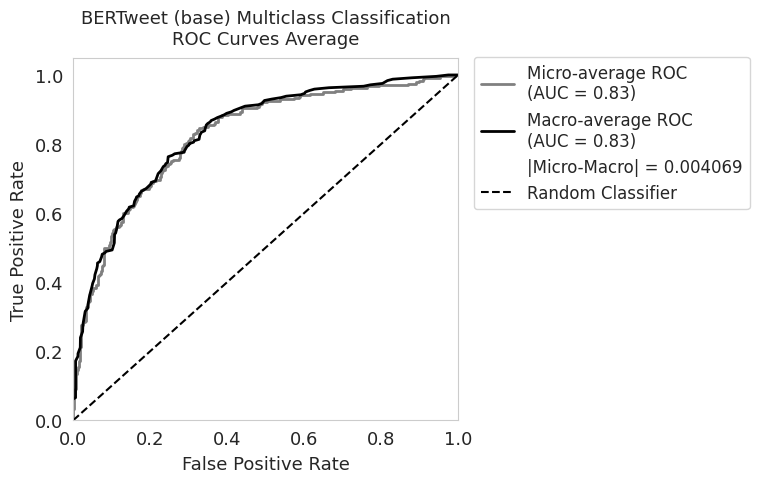

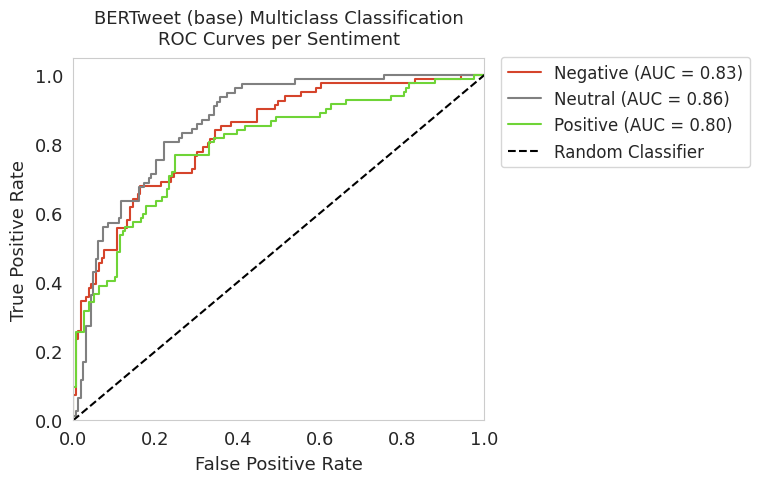

,ROC AUC,Standard Deviation,95% CI Lower,95% CI Upper,Standard Error
Average Type,,,,,
Micro,0.825764,0.027989,0.777774,0.873754,0.024485
Macro,0.829833,0.027989,0.798160,0.861506,0.016160
Weighted,0.829114,0.027883,0.781623,0.876606,0.024230
Micro-Macro Gap,0.004069,-,-,-,-



Note: A small micro-macro AUC gap indicates uniform model performance across sentiment classes.
A large micro-macro AUC gap indicates inconsistent model performance across sentiment classes.


Class,Negative,Neutral,Positive
Total Samples,240.000000,240.000000,240.000000
Positive Samples,81.000000,77.000000,82.000000
Negative Samples,159.000000,163.000000,158.000000
AUC (roc_curve),0.829102,0.864473,0.795925
AUC (roc_auc_score),0.829102,0.864473,0.795925
95% CI Lower,0.822601,0.858485,0.788985
95% CI Upper,0.835603,0.870461,0.802865
Difference between methods,0.000000,0.000000,0.000000
Optimal Threshold,0.420002,0.361231,0.279372
Precision,0.679012,0.632653,0.617647



ROC curve average metrics saved to: /workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Results/roc_curve_average_metrics.csv

ROC curve analysis saved to: /workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Results/roc_curve_analysis.csv




In [22]:
#==================================================================================================
#                 Visualizations ROC Curve using the model prodictions 
#==================================================================================================

# Seaborn setting
sns.set_style("whitegrid", {'axes.grid': False})

# Base output directory
base_dir = "/workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC"
predictions_dir = os.path.join(base_dir, 'Results/predictions')
figure_dir = os.path.join(base_dir, "Figures")
os.makedirs(figure_dir, exist_ok=True)

# Load and prepare data
ensemble_logits = np.load(os.path.join(predictions_dir, 'ensemble_logits.npy'))
y_test_true = np.load(os.path.join(base_dir, 'test_data/y_test.npy'))

# Softmax function for converting logits to probabilities
def softmax(x):
    """Compute softmax values for each set of scores in x."""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

# Convert logits to probabilities
test_pred_proba = softmax(ensemble_logits)

# Define labels and colors
label_names = ['Negative', 'Neutral', 'Positive']
colors = ['#d5442b', 'grey', '#6fd437']

# ======================== ROC Curves Plotting ========================
display(HTML('<div style="font-size: 22px; font-weight: bold;">ROC Curves</div>'))

# --------- First plot: Micro and Macro average ROC curves --------- 
plt.figure(figsize=(7.8, 5))

# Compute micro-average ROC curve
y_test_bin = label_binarize(y_test_true, classes=range(len(label_names)))
y_test_flat = y_test_bin.ravel()
y_pred_proba_flat = test_pred_proba.ravel()
fpr_micro, tpr_micro, _ = roc_curve(y_test_flat, y_pred_proba_flat)
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, 
         label=f'Micro-average ROC\n(AUC = {roc_auc_micro:.2f})',
         color='gray', linestyle='-', linewidth=2)

# Compute and plot macro-average ROC curve
all_fpr = np.unique(np.concatenate([roc_curve(y_test_bin[:, i], test_pred_proba[:, i])[0] 
                                  for i in range(len(label_names))]))
mean_tpr = np.zeros_like(all_fpr)

class_aucs = []
for i in range(len(label_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], test_pred_proba[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)
    class_aucs.append(auc(fpr, tpr))

mean_tpr /= len(label_names)
macro_auc = np.mean(class_aucs)

# Calculate micro-macro difference
micro_macro_diff = abs(roc_auc_micro - macro_auc)

plt.plot(all_fpr, mean_tpr, 'k-',
         label=f'Macro-average ROC\n(AUC = {macro_auc:.2f})',
         linewidth=2)

# Add separate legend entry for micro-macro difference
plt.plot([], [], ' ', 
         label=f'|Micro-Macro| = {micro_macro_diff:.6f}')

# Add random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BERTweet (base) Multiclass Classification\nROC Curves Average')
plt.legend(bbox_to_anchor=(1.02, 1.025), loc='upper left')
plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(figure_dir, 'BERTweet_base_MC_ROC_curves_averages.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

# ---------  Second plot: Per-class ROC curves --------- 
plt.figure(figsize=(7.8, 5))

# Store ROC results for reporting
roc_results = []

# Plot ROC curves for each class
for i, (class_name, color) in enumerate(zip(label_names, colors)):
    # One-vs-rest approach
    y_true_binary = (y_test_true == i).astype(int)
    y_score = test_pred_proba[:, i]
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Compute confidence interval for AUC
    n_pos = np.sum(y_true_binary)
    n_neg = len(y_true_binary) - n_pos
    se = np.sqrt((roc_auc * (1 - roc_auc)) / (n_pos * n_neg))
    ci_lower = max(0, roc_auc - 1.96 * se)
    ci_upper = min(1, roc_auc + 1.96 * se)
    
    # Store results
    roc_results.append({
        'Class': class_name,
        'AUC': roc_auc,
        'CI Lower': ci_lower,
        'CI Upper': ci_upper
    })
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color=color,
             label=f'{class_name} (AUC = {roc_auc:.2f})')

# Add random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BERTweet (base) Multiclass Classification\nROC Curves per Sentiment')
plt.legend(bbox_to_anchor=(1.02, 1.025), loc='upper left')
plt.tight_layout()

# Save the figure
sentiment_roc_curve_path = os.path.join(figure_dir, 'BERTweet_base_MC_ROC_curves_per_sentiment.png')
plt.savefig(sentiment_roc_curve_path, dpi=300, bbox_inches='tight')
sentiment_roc_curve_path2 = os.path.join(figure_dir, 'BERTweet_base_MC_ROC_curves_per_sentiment.tiff')
plt.savefig(sentiment_roc_curve_path2, dpi=300, bbox_inches='tight')
plt.show()

# ======================== Additional Statistics ========================

# ------------------- Calculate ROC Average Metrics ---------------------

def calculate_average_metrics(y_true, y_pred_proba, classes):
    """
    Calculate micro, macro, and weighted averages for ROC AUC scores.
    Also includes standard deviation of AUC scores across classes.
    """
    n_classes = len(classes)
    
    # Binarize the labels for multi-class metrics
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    
    # Initialize lists for storing metrics
    class_metrics = []
    class_auc_scores = []  # Initialize this list
    
    # Calculate metrics for each class
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        class_metrics.append({
            'class': classes[i],
            'auc': roc_auc,
        })
        class_auc_scores.append(roc_auc)
    
    # Micro average
    fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    
    # Macro average (simple average of class-wise AUC scores)
    auc_macro = np.mean([m['auc'] for m in class_metrics])
    
    # Weighted average (weighted by class support)
    class_support = np.bincount(y_true)
    auc_weighted = np.average([m['auc'] for m in class_metrics], 
                            weights=class_support)
    
    # Calculate standard errors and confidence intervals
    n_samples = len(y_true)
    
    # Standard error for micro average
    se_micro = np.sqrt(auc_micro * (1 - auc_micro) / n_samples)
    ci_micro = (auc_micro - 1.96 * se_micro, auc_micro + 1.96 * se_micro)
    
    # Standard error for macro average
    se_macro = np.sqrt(np.var([m['auc'] for m in class_metrics]) / n_classes)
    ci_macro = (auc_macro - 1.96 * se_macro, auc_macro + 1.96 * se_macro)
    
    # Standard error for weighted average
    se_weighted = np.sqrt(np.average([(m['auc'] * (1 - m['auc'])) for m in class_metrics], 
                                   weights=class_support) / n_samples)
    ci_weighted = (auc_weighted - 1.96 * se_weighted, auc_weighted + 1.96 * se_weighted)
    
    # Calculate standard deviations
    std_across_classes = np.std(class_auc_scores)
    
    return {
        'micro': {
            'auc': auc_micro,
            'ci': ci_micro,
            'se': se_micro,
            'std': std_across_classes
        },
        'macro': {
            'auc': auc_macro,
            'ci': ci_macro,
            'se': se_macro,
            'std': std_across_classes
        },
        'weighted': {
            'auc': auc_weighted,
            'ci': ci_weighted,
            'se': se_weighted,
            'std': np.sqrt(np.average((np.array(class_auc_scores) - auc_weighted) ** 2, weights=class_support))
        },
        'class_metrics': class_metrics
    }

# Calculate average metrics
average_metrics = calculate_average_metrics(y_test_true, test_pred_proba, range(len(label_names)))

# Create a DataFrame for average metrics
average_metrics_data = []
for avg_type in ['micro', 'macro', 'weighted']:
    metrics = average_metrics[avg_type]
    average_metrics_data.append({
        'Average Type': avg_type.capitalize(),
        'ROC AUC': f"{metrics['auc']:.6f}",
        'Standard Deviation': f"{metrics['std']:.6f}",
        '95% CI Lower': f"{metrics['ci'][0]:.6f}",
        '95% CI Upper': f"{metrics['ci'][1]:.6f}",
        'Standard Error': f"{metrics['se']:.6f}"
    })

# Add the micro-macro gap row
micro_macro_gap = abs(average_metrics['micro']['auc'] - average_metrics['macro']['auc'])
average_metrics_data.append({
    'Average Type': 'Micro-Macro Gap',
    'ROC AUC': f"{micro_macro_gap:.6f}",
    'Standard Deviation': "-",
    '95% CI Lower': "-",
    '95% CI Upper': "-",
    'Standard Error': "-"
})

average_metrics_df = pd.DataFrame(average_metrics_data)
average_metrics_df = average_metrics_df.set_index('Average Type')

# Display the average metrics table
print("\n")
display(HTML('<div style="font-size: 22px; font-weight: bold;">Receiver Operating Characteristic (ROC) Curve Metrics</div>'))
display(HTML("<br><b>Area Under the Curve (AUC): ROC Curve Average Metrics</b>"))
display(HTML(average_metrics_df.to_html()))

# Save average metrics to CSV
average_metrics_save_path = os.path.join(base_dir, 'Results', 'roc_curve_average_metrics.csv')
average_metrics_df.to_csv(average_metrics_save_path, sep=';')

# Notes printing
print("\nNote: A small micro-macro AUC gap indicates uniform model performance across sentiment classes.")
print("A large micro-macro AUC gap indicates inconsistent model performance across sentiment classes.")

# ------------- ROC Curve Detailed Analysis per Sentiments -------------

detailed_roc_results = []
for i, class_name in enumerate(label_names):
    # One-vs-rest approach
    y_true_binary = (y_test_true == i).astype(int)
    y_score = test_pred_proba[:, i]
    
    # Method 1: sklearn's roc_curve
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_score)
    
    # Method 2: Direct AUC computation
    auc_direct = auc(fpr, tpr)
    
    # Method 3: roc_auc_score
    auc_score = roc_auc_score(y_true_binary, y_score)
    
    # Additional statistical validation
    n_pos = np.sum(y_true_binary)
    n_neg = len(y_true_binary) - n_pos
    
    # Confidence interval for AUC
    se = np.sqrt((auc_direct * (1 - auc_direct)) / (n_pos * n_neg))
    ci_lower = max(0, auc_direct - 1.96 * se)
    ci_upper = min(1, auc_direct + 1.96 * se)
    
    # Find optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    # Calculate metrics at optimal threshold
    y_pred_threshold = (y_score >= optimal_threshold).astype(int)
    
    precision = precision_score(y_true_binary, y_pred_threshold, zero_division=0)
    recall = recall_score(y_true_binary, y_pred_threshold, zero_division=0)
    
    # Store results
    result = {
        'Class': class_name,
        'Total Samples': len(y_true_binary),
        'Positive Samples': n_pos,
        'Negative Samples': n_neg,
        'AUC (roc_curve)': auc_direct,
        'AUC (roc_auc_score)': auc_score,
        '95% CI Lower': ci_lower,
        '95% CI Upper': ci_upper,
        'Difference between methods': abs(auc_direct - auc_score),
        'Optimal Threshold': optimal_threshold,
        'Precision': precision,
        'Recall': recall
    }
    
    detailed_roc_results.append(result)

# Create a transposed DataFrame for better readability
roc_analysis_df = pd.DataFrame(detailed_roc_results).set_index('Class').T

# format float columns to a specific number of decimal places
float_columns = roc_analysis_df.select_dtypes(include=[np.float64]).columns
for col in float_columns:
    roc_analysis_df[col] = roc_analysis_df[col].apply(lambda x: f"{x:.6f}" if pd.notnull(x) else x)

# Save to CSV
save_path = os.path.join(base_dir, 'Results', 'roc_curve_analysis.csv')
roc_analysis_df.to_csv(save_path, sep=';')

# Display in Jupyter Notebook
display(HTML("<br><b>\nROC Curve Analysis by Sentiment</b>"))
display(HTML(roc_analysis_df.to_html()))
print(f"\nROC curve average metrics saved to: {average_metrics_save_path}")
print(f"\nROC curve analysis saved to: {save_path }\n\n")


### Probability Distributions

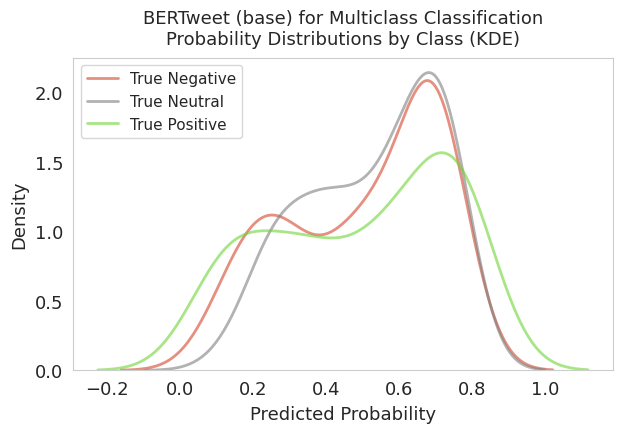

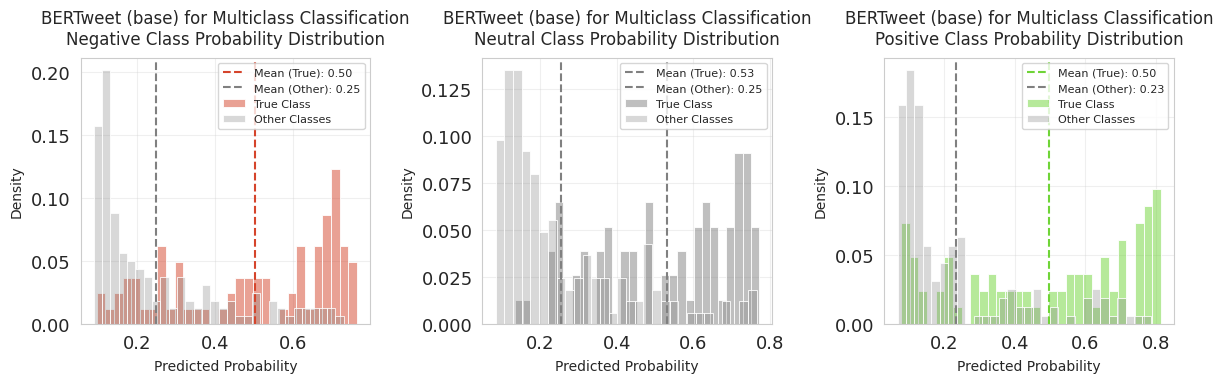

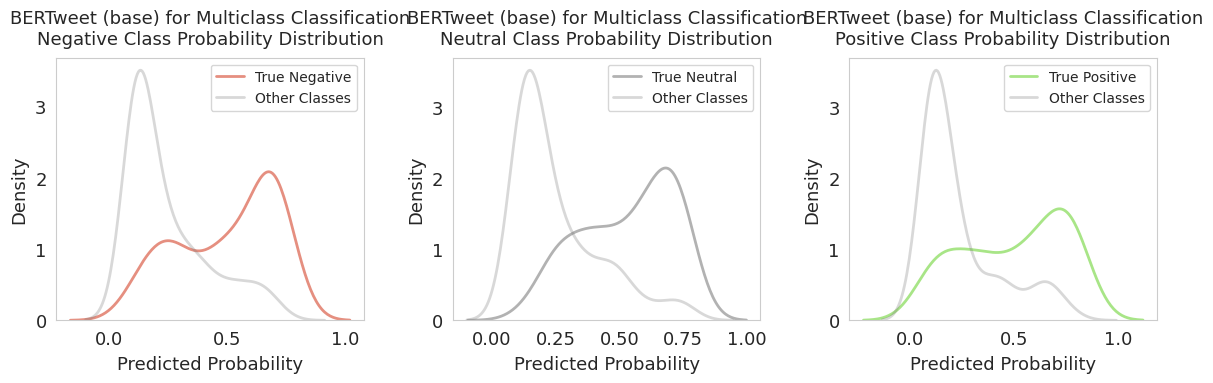

,True Class (Mean),True Class (Std),Other Classes (Mean),Other Classes (Std),Separation
Metric,,,,,
Negative,0.502227,0.205719,0.247723,0.169987,0.254504
Neutral,0.530160,0.179876,0.254001,0.167282,0.276160
Positive,0.496099,0.243258,0.234348,0.187103,0.261751


In [23]:
# ==================== Visualize Probability Distributions ====================

# --------------- KDE Plot All Sentiement ---------------

plt.figure(figsize=(6.5, 4.5))
for i, (class_name, color) in enumerate(zip(label_names, colors)):
    class_probs = test_pred_proba[:, i]
    true_class = (y_test_true == i)
    
    # Plot distributions
    sns.kdeplot(data=class_probs[true_class], color=color, alpha=0.6, 
                label=f'True {class_name}', linewidth=2)

plt.title('BERTweet (base) for Multiclass Classification\nProbability Distributions by Class (KDE)')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend(fontsize=11)
plt.grid(False)
plt.tight_layout()

# Save the figure
prob_path = os.path.join(figure_dir, 'BERTweet_base_MC_probability_distributions.png')
plt.savefig(prob_path, dpi=300, bbox_inches='tight')
display(HTML('<div style="font-size: 22px; font-weight: bold;">Probability Distributions</div>'))

plt.show()

# ================== Enhanced Probability Distribution Visualization ===================

plt.figure(figsize=(12, 4))
for i, class_name in enumerate(label_names):
    plt.subplot(1, 3, i+1)
    # Get probabilities for the current class
    class_probs = test_pred_proba[:, i]
    # Get true labels for this class
    true_class = (y_test_true == i)
    
    # Plot distributions separately for true positives and true negatives
    sns.histplot(data=class_probs[true_class], bins=30, color=colors[i], alpha=0.5, 
                label='True Class', stat='probability')
    sns.histplot(data=class_probs[~true_class], bins=30, color='gray', alpha=0.3, 
                label='Other Classes', stat='probability')
    
    # Add mean lines
    plt.axvline(class_probs[true_class].mean(), color=colors[i], linestyle='--', 
                label=f'Mean (True): {class_probs[true_class].mean():.2f}')
    plt.axvline(class_probs[~true_class].mean(), color='gray', linestyle='--', 
                label=f'Mean (Other): {class_probs[~true_class].mean():.2f}')
    
    plt.title(f'BERTweet (base) for Multiclass Classification\n{class_name} Class Probability Distribution', fontsize=12)
    plt.xlabel('Predicted Probability', fontsize=10)
    plt.ylabel('Density', fontsize=10)
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
plt.tight_layout()

# Save the figure
roc_curve_path = os.path.join(figure_dir, 'BERTweet_base_MC_probability_distributions_hist_true_false.png')
plt.savefig(roc_curve_path, dpi=300, bbox_inches='tight')
plt.show()

# --------------- KDE Plot - separate plots for each class ---------------
plt.figure(figsize=(12, 4))

for i, (class_name, color) in enumerate(zip(label_names, colors)):
    plt.subplot(1, 3, i+1)
    
    # Get probabilities for current class
    class_probs = test_pred_proba[:, i]
    true_class = (y_test_true == i)
    
    # Plot distributions
    sns.kdeplot(data=class_probs[true_class], color=color, alpha=0.6, 
                label=f'True {class_name}', linewidth=2)
    sns.kdeplot(data=class_probs[~true_class], color='gray', alpha=0.3, 
                label=f'Other Classes', linewidth=2)
    
    plt.title(f'BERTweet (base) for Multiclass Classification\n{class_name} Class Probability Distribution')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.legend(fontsize=10)
    plt.grid(False)

plt.tight_layout()

# Save the figure
roc_curve_path = os.path.join(figure_dir, 'BERTweet_base_MC_probability_distributions_KDE_true_false.png')
plt.savefig(roc_curve_path, dpi=300, bbox_inches='tight')
plt.show()

# ================== Print distribution statistics ==================
# Create and display probability distribution statistics table
prob_stats = []
metrics = ['True Class (Mean)', 'True Class (Std)', 'Other Classes (Mean)', 
          'Other Classes (Std)', 'Separation']

for i, class_name in enumerate(label_names):
    class_probs = test_pred_proba[:, i]
    true_class = (y_test_true == i)
    
    stats = {
        'Metric': class_name,
        'True Class (Mean)': f"{class_probs[true_class].mean():.6f}",
        'True Class (Std)': f"{class_probs[true_class].std():.6f}",
        'Other Classes (Mean)': f"{class_probs[~true_class].mean():.6f}",
        'Other Classes (Std)': f"{class_probs[~true_class].std():.6f}",
        'Separation': f"{class_probs[true_class].mean() - class_probs[~true_class].mean():.6f}"
    }
    prob_stats.append(stats)

# Create DataFrame and display
prob_stats_df = pd.DataFrame(prob_stats).set_index('Metric')
display(HTML("<br><b>Probability Distribution Statistics</b>"))
display(HTML(prob_stats_df.to_html()))

### Confusion Matrices and Sentiment Distribution

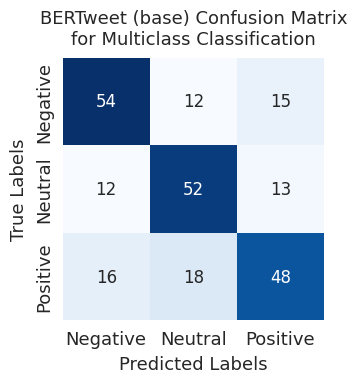

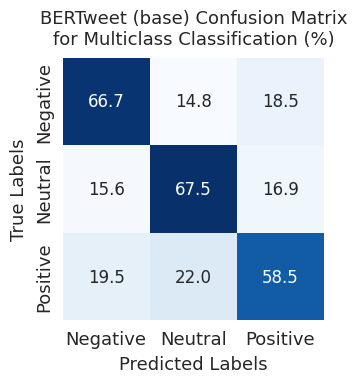


Sentiment Distribution:


,True Label,Predictions
Sentiment,,
Negative,81,82
Neutral,77,82
Positive,82,76



Sentiment Distribution table saved in: /workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Results BERTweet_base_MC_Sentiment_Distribution.csv

Classification Report:


,precision,recall,f1-score,support
Negative,0.658537,0.666667,0.662577,81.000000
Neutral,0.634146,0.675325,0.654088,77.000000
Positive,0.631579,0.585366,0.607595,82.000000
accuracy,0.641667,0.641667,0.641667,0.641667
macro avg,0.641421,0.642452,0.641420,240.000000
weighted avg,0.641501,0.641667,0.641068,240.000000



Additional Statistical Metrics:


,Metric,Value
0,Macro Accuracy,0.641667
1,Macro Precision,0.641421
2,Macro Recall,0.642452
3,Macro F1-Score,0.641420
4,Cohen's Kappa,0.462668



Analysis complete. Results saved in: /workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Results


In [24]:
#==================================================================================================
#                 Visualizations of Confusion Matrices and Sentiment Distribution 
#==================================================================================================


# ============== Peparing Data ================

# Using the data from ROC curve analysis
# Convert numeric predictions to string labels
y_true_str = [label_names[i] for i in y_test_true]
y_pred = np.argmax(test_pred_proba, axis=1)
y_pred_str = [label_names[i] for i in y_pred]

# Create output directory if it doesn't exist
output_dir = os.path.join(base_dir, 'Results')
os.makedirs(output_dir, exist_ok=True)

def compute_statistical_metrics(y_true, y_pred, labels):
    """Compute additional statistical metrics"""
    # Create copies of input data
    y_true_copy = np.array(y_true).copy()
    y_pred_copy = np.array(y_pred).copy()
    
    label_map = {label: idx for idx, label in enumerate(labels)}
    y_true_numeric = np.array([label_map[label] for label in y_true_copy])
    y_pred_numeric = np.array([label_map[label] for label in y_pred_copy])
    
    results = {
        'Macro Accuracy': accuracy_score(y_true_numeric, y_pred_numeric, normalize=True),
        'Macro Precision': precision_score(y_true_numeric, y_pred_numeric, average='macro'),
        'Macro Recall': recall_score(y_true_numeric, y_pred_numeric, average='macro'),
        'Macro F1-Score': f1_score(y_true_numeric, y_pred_numeric, average='macro'),
        'Cohen\'s Kappa': cohen_kappa_score(y_true_numeric, y_pred_numeric)        
    }
    
    return results.copy()

# ============== Confusion Matrix Visualization ================

# ------ Counts version ------
cm = confusion_matrix(y_true_str, y_pred_str, labels=label_names)

plt.figure(figsize=(3.5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    xticklabels=label_names,
    yticklabels=label_names
)
plt.title('BERTweet (base) Confusion Matrix\nfor Multiclass Classification')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, 'BERTweet_base_MC_confusion_matrix_counts.png'), 
            dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(figure_dir, 'BERTweet_base_MC_confusion_matrix_counts.tiff'), 
            dpi=300, bbox_inches='tight')
plt.show()

# ------ Percentage version ------
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
cm_normalized = np.nan_to_num(cm_normalized)

plt.figure(figsize=(3.5, 4))
sns.heatmap(
    cm_normalized * 100,
    annot=np.round(cm_normalized * 100, 1),
    fmt='.1f',
    cmap='Blues',
    cbar=False,
    xticklabels=label_names,
    yticklabels=label_names
)
plt.title('BERTweet (base) Confusion Matrix\nfor Multiclass Classification (%)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, 'BERTweet_base_MC_confusion_matrix_percentage.png'), 
            dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(figure_dir, 'BERTweet_base_MC_confusion_matrix_percentage.tiff'), 
            dpi=300, bbox_inches='tight')
plt.show()

# ============== Basic Distribution Analysis ================

# Create DataFrames for True Label and Prediction distributions
true_label_dist = pd.Series(y_true_str).value_counts().reset_index()
true_label_dist.columns = ['Sentiment', 'True Label']

prediction_dist = pd.Series(y_pred_str).value_counts().reset_index()
prediction_dist.columns = ['Sentiment', 'Predictions']

# Merge the two DataFrames
distribution_table = pd.merge(true_label_dist, prediction_dist, on='Sentiment', how='outer').fillna(0)

# Reorder rows to match the desired order
distribution_table['Sentiment'] = pd.Categorical(distribution_table['Sentiment'], categories=label_names, ordered=True)
distribution_table = distribution_table.sort_values('Sentiment')

# Reset index and set Sentiment as index
distribution_table = distribution_table.reset_index(drop=True).set_index('Sentiment')

# Convert counts to integers
distribution_table = distribution_table.astype(int)

print("\nSentiment Distribution:")
display(distribution_table)

# Save the distribution table
distribution_table.to_csv(os.path.join(output_dir, 'BERTweet_base_MC_Sentiment_Distribution.csv'))
print("\nSentiment Distribution table saved in:", output_dir, 'BERTweet_base_MC_Sentiment_Distribution.csv')

# Calculate accuracy
accuracy = np.mean(np.array(y_true_str) == np.array(y_pred_str))

# Classification report
print("\nClassification Report:")
class_report = classification_report(y_true_str, y_pred_str, labels=label_names, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
display(class_report_df)

# Additional metrics
additional_metrics = compute_statistical_metrics(y_true_str, y_pred_str, label_names)

print("\nAdditional Statistical Metrics:")
additional_metrics_df = pd.DataFrame.from_dict(additional_metrics, orient='index', columns=['Value'])
additional_metrics_df.index.name = 'Metric'
additional_metrics_df = additional_metrics_df.reset_index()

def format_value(x):
    if isinstance(x, dict):
        return ', '.join([f"{k}: {v:.6f}" for k, v in x.items()])
    elif isinstance(x, (int, float)):
        return f'{x:.6f}'
    return str(x)

additional_metrics_df['Value'] = additional_metrics_df['Value'].apply(format_value)
pd.set_option('display.max_colwidth', None)
display(additional_metrics_df)

print("\nAnalysis complete. Results saved in:", output_dir)

# Multilabel Classification using BERTweet

## Multilabel & text: preparing data

In [17]:
# Extracting features (text) and labels from training DataFrame
X_train_ML = trainDf['text'].tolist()
y_train_ML = trainDf[['Label_A2_negative', 'Label_A3_neutral', 'Label_A1_positive']].values

# Extracting features (text) and labels from validation DataFrame
X_val_ML = valDf['text'].tolist()
y_val_ML = valDf[['Label_A2_negative', 'Label_A3_neutral', 'Label_A1_positive']].values

# Extracting features (text) and labels from test DataFrame
X_test_ML = testDf['text'].tolist()
y_test_ML = testDf[['Label_A2_negative', 'Label_A3_neutral', 'Label_A1_positive']].values

# Convert X_train_ML to NumPy array
X_train_ML = np.array(X_train_ML)
X_val_ML = np.array(X_val_ML)
X_test_ML = np.array(X_test_ML)

## Metric Definition for Multilabel Classification

In [18]:
## =================== Metrics Definition for Multilabel classification ===================

def ML_metric2(y_true, y_pred):
    """
    Calculate the proportion of predictions that are exactly correct or off by one.
    For a 3-class sentiment problem (0, 1, 2), count how many labels are correctly predicted
    or predicted with just one level difference.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    n_samples = y_true.shape[0]
    correct_predictions = 0
    
    for i in range(n_samples):
        # Get true and predicted class indices
        true_idx = np.where(y_true[i] == 1)[0]
        pred_idx = np.where(y_pred[i] == 1)[0]
        
        # Check if we have valid indices
        if len(true_idx) == 1 and len(pred_idx) == 1:
            # Calculate absolute difference between predicted and true class
            diff = abs(true_idx[0] - pred_idx[0])
            # Count as correct if exact match or off by one
            if diff <= 1:
                correct_predictions += 1
    
    return correct_predictions / n_samples

def ML_hamming_score(y_true, y_pred):
    """
    Calculate the Hamming score (intersection over union) for multilabel classification.
    """
    y_true = np.array(y_true).astype(int)
    y_pred = np.array(y_pred).astype(int)
    
    intersection = np.sum(y_true & y_pred)
    union = np.sum(y_true | y_pred)
    
    return intersection / union if union > 0 else 0

def ML_weighted_accuracy(y_true, y_pred):
    """
    Calculate weighted accuracy for multi-label classification.
    """
    y_true = np.array(y_true).astype(int)
    y_pred = np.array(y_pred).astype(int)
    
    n_classes = y_true.shape[1]
    class_accuracies = []
    weights = []
    
    for c in range(n_classes):
        true_class = y_true[:, c]
        pred_class = y_pred[:, c]
        
        n_samples_class = np.sum(true_class)
        if n_samples_class == 0:
            continue
        
        weight = y_true.shape[0] / (n_classes * n_samples_class)
        class_accuracy = np.sum((true_class == 1) & (pred_class == 1)) / n_samples_class
        
        class_accuracies.append(class_accuracy)
        weights.append(weight)
    
    weights = np.array(weights)
    weights = weights / np.sum(weights)
    
    return np.sum(np.array(class_accuracies) * weights)

def ML_macro_f1(y_true, y_pred):
    """
    Compute the macro F1 score for multi-label classification.
    """
    f1_scores = []
    for c in range(y_true.shape[1]):
        f1 = f1_score(y_true[:, c], y_pred[:, c])
        f1_scores.append(f1)
    
    return np.mean(f1_scores)

def ML_weighted_f1(y_true, y_pred):
    """
    Compute the weighted F1 score for multi-label classification.
    """
    f1_scores = []
    weights = []
    
    for c in range(y_true.shape[1]):
        n_samples_class = np.sum(y_true[:, c])
        if n_samples_class == 0:
            continue
        
        weight = n_samples_class / np.sum(y_true)
        f1 = f1_score(y_true[:, c], y_pred[:, c])
        
        f1_scores.append(f1)
        weights.append(weight)
    
    return np.average(f1_scores, weights=weights)


def ML_hamming_loss(y_true, y_pred):
    """
    Calculate Hamming loss for multi-label classification.
    """
    return hamming_loss(y_true, y_pred)

def ML_macro_accuracy(y_true, y_pred):
    """
    Calculate macro-averaged accuracy for multi-label classification.
    """
    accuracies = []
    for c in range(y_true.shape[1]):
        true_class = y_true[:, c]
        pred_class = y_pred[:, c]
        class_accuracy = np.mean(true_class == pred_class)
        accuracies.append(class_accuracy)
    
    return np.mean(accuracies)

## Optuna Search for Multilabel Classification

**Tested Hyperparameters**
```
    'learning_rate': trial.suggest_categorical('learning_rate', [1e-06, 1e-05, 5e-05, 0.0001]),
    'num_train_epochs': trial.suggest_categorical('num_train_epochs', [4, 7, 10, 13]),
    'batch_size': trial.suggest_categorical('batch_size', [4, 8, 16, 32]),
    'warmup_steps': trial.suggest_categorical('warmup_steps', [250, 500, 750, 1000]),
    'weight_decay': trial.suggest_categorical('weight_decay', [0.05, 0.01, 0.1]),
    'warmup_ratio': trial.suggest_categorical('warmup_ratio', [0.005, 0.01, 0.1, 0.2]),
    'max_length': trial.suggest_categorical('max_length', [92, 115, 130])
```

In [19]:
import os
import time
import random
import json
import numpy as np
import torch
import optuna
import pandas as pd
from datetime import datetime
from torch.utils.data import Dataset
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
from transformers.modeling_outputs import SequenceClassifierOutput
from torch.nn import BCEWithLogitsLoss
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import hamming_loss, f1_score

# Start timing
start = time.time()

def set_seed(seed=42):
    """Set all random seeds for full reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

class MultiLabelBERTweet(AutoModelForSequenceClassification):
    """Custom BERTweet model for multilabel classification"""
    def __init__(self, config):
        super().__init__(config)
        
    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            **kwargs
        )
        
        logits = self.classifier(outputs[0][:, 0, :])
        
        loss = None
        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
            loss = loss_fct(logits.float(), labels.float())
            
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions
        )

class TweetDataset(Dataset):
    """Dataset class for multilabel tweet classification"""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }
        return item

    def __len__(self):
        return len(self.labels)

class SentimentAnalysisOptuna:
    def __init__(self, model_name='vinai/bertweet-base', num_labels=3, use_fast=True, normalization=True, max_length=115, 
                 seed=42):
        self.seed = seed
        set_seed(self.seed)
        self.model_name = model_name
        self.num_labels = num_labels
        self.use_fast = use_fast
        self.normalization = normalization
        self.max_length = max_length
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        
        torch.use_deterministic_algorithms(True)
        os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
        
        self.output_base_path = "/workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Optuna_search"
        os.makedirs(self.output_base_path, exist_ok=True)
        os.makedirs(os.path.join(self.output_base_path, 'Metrics'), exist_ok=True)
        
        self.tokenizer = AutoTokenizer.from_pretrained(
            model_name,
            use_fast=self.use_fast,
            normalization=self.normalization
        )
        self.cv_metrics = []
        self.original_train_texts = None
        self.original_train_labels = None
        self.original_val_texts = None
        self.original_val_labels = None
        self.tried_configurations = set()

    def preprocess_text(self, texts):
        if isinstance(texts, str):
            texts = [texts]
        texts = [text.lower() if isinstance(text, str) else str(text).lower() for text in texts]
        return texts

    def create_dataset(self, texts, labels):
        generator = torch.Generator()
        generator.manual_seed(self.seed)
        
        preprocessed_texts = self.preprocess_text(texts)
        encodings = self.tokenizer(
            preprocessed_texts,
            truncation=True,
            padding=True,
            max_length=self.max_length,
            return_tensors='pt',
            return_attention_mask=True
        )
        return TweetDataset(encodings, labels)

    def calculate_balanced_score(self, weighted_f1, normalized_loss, cv_stability):
        """
        Calculate balanced score ensuring output is between 0 and 1.
        For multilabel classification, the weighted_f1 is already averaged across labels.
        """
        try:
            weights = {
                'weighted_f1': 0.4,          # Weight for F1 score across all labels
                'normalized_loss': 0.3,      # Weight for BCE loss normalization
                'cv_stability': 0.3          # Weight for cross-validation stability
            }
            
            # Ensure all inputs are in [0,1] range
            weighted_f1 = max(0.0, min(1.0, weighted_f1))
            normalized_loss = max(0.0, min(1.0, normalized_loss))
            cv_stability = max(0.0, min(1.0, cv_stability))
            
            balanced_score = (
                (weighted_f1 * weights['weighted_f1']) +
                ((1 - normalized_loss) * weights['normalized_loss']) +
                (cv_stability * weights['cv_stability'])
            )
            
            return max(0.0, min(1.0, balanced_score))
        except Exception as e:
            print(f"Error in calculate_balanced_score: {str(e)}")
            return 0.0

    def create_optimizer(self, model, num_training_steps):
        """
        Create optimizer with parameter-specific settings.
        Same configuration works for both multiclass and multilabel.
        """
        try:
            # Parameters that should not decay
            no_decay = ['bias', 'LayerNorm.weight']
            
            # Group parameters for optimizer
            optimizer_grouped_parameters = [
                {
                    'params': [p for n, p in model.named_parameters() 
                              if not any(nd in n for nd in no_decay)],
                    'weight_decay': self.weight_decay
                },
                {
                    'params': [p for n, p in model.named_parameters() 
                              if any(nd in n for nd in no_decay)],
                    'weight_decay': 0.0
                }
            ]
            
            # Create optimizer
            optimizer = AdamW(
                optimizer_grouped_parameters,
                lr=self.learning_rate
            )
            
            # Create learning rate scheduler
            scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=self.warmup_steps,
                num_training_steps=num_training_steps
            )
            
            return optimizer, scheduler
        except Exception as e:
            print(f"Error in create_optimizer: {str(e)}")
            raise

    def normalize_loss(self, loss, min_loss=None, max_loss=None):
        """
        Normalize loss to 0-1 range.
        For multilabel, the loss is already averaged across all labels.
        """
        try:
            if min_loss is None or max_loss is None:
                # If no bounds provided, just clip to reasonable range for BCE loss
                normalized = 1 - (max(0.0, min(5.0, loss)) / 5.0)
                return max(0.0, min(1.0, normalized))
            
            if max_loss == min_loss:
                return 1.0 if loss == min_loss else 0.0
                
            normalized = (max_loss - loss) / (max_loss - min_loss)
            return max(0.0, min(1.0, normalized))
        except Exception as e:
            print(f"Error in normalize_loss: {str(e)}")
            return 0.0

    def compute_cross_validation_stability(self, metrics):
        """
        Compute cross-validation stability.
        Works the same for multilabel as the metrics are already averaged.
        """
        try:
            if len(metrics) < 2:
                return 1.0
                
            std_dev = np.std(metrics)
            mean = np.mean(metrics)
            
            if mean == 0:
                return 0.0
                
            cv = std_dev / mean
            stability = 1 / (1 + cv)
            
            return max(0.0, min(1.0, stability))
        except Exception as e:
            print(f"Error in compute_cross_validation_stability: {str(e)}")
            return 0.0

    def _get_configuration_hash(self, trial_params):
        """
        Generate hash for trial parameters.
        Used to prevent duplicate configurations.
        """
        try:
            param_str = json.dumps(sorted(trial_params.items()))
            return hash(param_str)
        except Exception as e:
            print(f"Error in _get_configuration_hash: {str(e)}")
            return None

    def compute_metrics_callback(self, eval_pred):
        try:
            logits, labels = eval_pred
            predictions = (torch.sigmoid(torch.tensor(logits)) > 0.5).numpy()
            
            metrics = {
                'weighted_f1': ML_weighted_f1(labels, predictions),
                'macro_accuracy': ML_macro_accuracy(labels, predictions),
                'weighted_accuracy': ML_weighted_accuracy(labels, predictions),
                'metric2_ML': ML_metric2(labels, predictions),
                'hamming_score': ML_hamming_score(labels, predictions),
                'hamming_loss': ML_hamming_loss(labels, predictions),
                'macro_f1': ML_macro_f1(labels, predictions)
            }
            
            loss_fct = BCEWithLogitsLoss()
            eval_loss = loss_fct(
                torch.tensor(logits),
                torch.tensor(labels, dtype=torch.float)
            ).item()
            
            normalized_loss = max(0.0, min(1.0, eval_loss / 5.0))
            
            if not hasattr(self, 'cv_metrics'):
                self.cv_metrics = []
            self.cv_metrics.append(metrics['weighted_f1'])
            cv_stability = self.compute_cross_validation_stability(self.cv_metrics)
            
            balanced_score = self.calculate_balanced_score(
                metrics['weighted_f1'],
                normalized_loss,
                cv_stability
            )
            
            metrics.update({
                'eval_loss': eval_loss,
                'normalized_loss': normalized_loss,
                'cv_stability': cv_stability,
                'balanced_score': balanced_score
            })
            
            return metrics
        except Exception as e:
            print(f"Error in compute_metrics_callback: {str(e)}")
            return {
                'weighted_f1': 0.0,
                'macro_accuracy': 0.0,
                'weighted_accuracy': 0.0,
                'metric2_ML': 0.0,
                'hamming_score': 0.0,
                'hamming_loss': 1.0,
                'macro_f1': 0.0,
                'eval_loss': float('inf'),
                'normalized_loss': 1.0,
                'cv_stability': 0.0,
                'balanced_score': 0.0
            }

    def objective(self, trial):
        """Optuna objective function for hyperparameter optimization"""
        try:
            trial_seed = self.seed + trial.number
            set_seed(trial_seed)
            
            trial_params = {
                'learning_rate': trial.suggest_categorical('learning_rate', [1e-06, 1e-05, 5e-05, 0.0001]),
                'num_train_epochs': trial.suggest_categorical('num_train_epochs', [4, 7, 10, 13]),
                'batch_size': trial.suggest_categorical('batch_size', [4, 8, 16, 32]),
                'warmup_steps': trial.suggest_categorical('warmup_steps', [250, 500, 750, 1000]),
                'weight_decay': trial.suggest_categorical('weight_decay', [0.05, 0.01, 0.1]),
                'warmup_ratio': trial.suggest_categorical('warmup_ratio', [0.005, 0.01, 0.1, 0.2]),
                'max_length': trial.suggest_categorical('max_length', [92, 115, 130])
            }
            
            config_hash = self._get_configuration_hash(trial_params)
            if config_hash in self.tried_configurations:
                raise optuna.exceptions.TrialPruned("Duplicate configuration")
            self.tried_configurations.add(config_hash)
            
            train_dataset = self.create_dataset(self.original_train_texts, self.original_train_labels)
            val_dataset = self.create_dataset(self.original_val_texts, self.original_val_labels)
            
            num_training_steps = (
                len(train_dataset) * trial_params['num_train_epochs'] // trial_params['batch_size']
            )
            
            self.learning_rate = trial_params['learning_rate']
            self.weight_decay = trial_params['weight_decay']
            self.warmup_steps = trial_params['warmup_steps']
            
            model = MultiLabelBERTweet.from_pretrained(
                self.model_name,
                num_labels=self.num_labels,
                problem_type="multi_label_classification"
            ).to(self.device)
            
            optimizer, scheduler = self.create_optimizer(model, num_training_steps)
            
            training_args = TrainingArguments(
                output_dir=os.path.join(self.output_base_path, 'Metrics', f'trial_{trial.number}'),
                learning_rate=trial_params['learning_rate'],
                num_train_epochs=trial_params['num_train_epochs'],
                per_device_train_batch_size=trial_params['batch_size'],
                per_device_eval_batch_size=trial_params['batch_size'],
                gradient_accumulation_steps=2,
                warmup_steps=trial_params['warmup_steps'],
                warmup_ratio=trial_params['warmup_ratio'],
                weight_decay=trial_params['weight_decay'],
                logging_dir=os.path.join(self.output_base_path, 'logs'),
                logging_steps=100,
                evaluation_strategy="epoch",
                save_strategy="epoch",
                load_best_model_at_end=True,
                metric_for_best_model="balanced_score",
                greater_is_better=True,
                save_total_limit=2,
                fp16=True,
                report_to='none',
                dataloader_pin_memory=False,
                seed=trial_seed,
                dataloader_num_workers=1
            )
            
            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=val_dataset,
                compute_metrics=self.compute_metrics_callback,
                optimizers=(optimizer, scheduler),
                callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
            )
            
            try:
                train_result = trainer.train()
                eval_results = trainer.evaluate()
                
                if eval_results is None or 'eval_balanced_score' not in eval_results:
                    print(f"Trial {trial.number}: No valid evaluation results")
                    return 0.0
                
                trial.set_user_attr('metrics', eval_results)
                
                trial_info = {
                    'trial_number': trial.number,
                    'seed': trial_seed,
                    'hyperparameters': trial_params,
                    'metrics': eval_results
                }
                
                output_path = os.path.join(self.output_base_path, 'Metrics')
                os.makedirs(output_path, exist_ok=True)
                with open(os.path.join(output_path, f'BERTweet_ML_optuna_trial_{trial.number}_details.json'), 'w') as f:
                    json.dump(trial_info, f, indent=4)
                
                balanced_score = max(0.0, min(1.0, float(eval_results.get('eval_balanced_score', 0.0))))
                
                print(f"\nTrial {trial.number} completed successfully:")
                print(f"Seed: {trial_seed}")
                print(f"Balanced Score: {balanced_score}")
                
                return balanced_score
            
            except Exception as e:
                print(f"\nError during training in trial {trial.number}: {str(e)}")
                return 0.0
        
        except Exception as e:
            print(f"\nError in objective for trial {trial.number}: {str(e)}")
            return 0.0

    def save_trials_to_csv(self, study, output_path):
        """Save all trial details to a DataFrame"""
        trial_details = []
        for trial in study.trials:
            if trial.state == optuna.trial.TrialState.COMPLETE:
                # Extract hyperparameters
                params = trial.params
                # Extract metrics
                metrics = trial.user_attrs.get('metrics', {})
                # Combine hyperparameters and metrics
                trial_info = {
                    # Trial Information
                    'trial_number': trial.number,
                    'seed': self.seed + trial.number,
                    # Hyperparameters
                    'learning_rate': params.get('learning_rate', None),
                    'num_train_epochs': params.get('num_train_epochs', None),
                    'batch_size': params.get('batch_size', None),
                    'warmup_steps': params.get('warmup_steps', None),
                    'weight_decay': params.get('weight_decay', None),
                    'max_length': params.get('max_length', None),
                    # Balanced Score
                    'balanced_score': trial.value,
                    # Evaluation Metrics - without 'eval_' prefix
                    'loss': metrics.get('eval_loss', None),
                    'weighted_f1': metrics.get('eval_weighted_f1', None),
                    'macro_accuracy': metrics.get('eval_macro_accuracy', None),
                    'weighted_accuracy': metrics.get('eval_weighted_accuracy', None),
                    'ML_metric2': metrics.get('eval_ML_metric2', None),
                    'normalized_loss': metrics.get('eval_normalized_loss', None),
                    'cv_stability': metrics.get('eval_cv_stability', None),
                    'runtime': metrics.get('eval_runtime', None),
                    'samples_per_second': metrics.get('eval_samples_per_second', None),
                    'steps_per_second': metrics.get('eval_steps_per_second', None)
                }
                trial_details.append(trial_info)
        # Create DataFrame
        df = pd.DataFrame(trial_details)
        return df

def main(X_train_ML, y_train_ML, X_val_ML, y_val_ML, n_trials=35, seed=42):
    """Main hyperparameter optimization pipeline"""
    set_seed(seed)
    
    output_path = "/workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Optuna_search"
    os.makedirs(output_path, exist_ok=True)
    
    db_path = os.path.join(output_path, 'BERTweet_ML_optuna_study.db')
    if os.path.exists(db_path):
        os.remove(db_path)
        
    pipeline = SentimentAnalysisOptuna(
        num_labels=y_train_ML.shape[1],  # Number of label columns
        max_length=115,
        seed=seed
    )
    pipeline.original_train_texts = X_train_ML
    pipeline.original_train_labels = y_train_ML
    pipeline.original_val_texts = X_val_ML
    pipeline.original_val_labels = y_val_ML
    
    try:
        # Create sampler with fixed seed
        sampler = optuna.samplers.TPESampler(seed=seed)
        study = optuna.create_study(
            direction='maximize',
            storage=f'sqlite:///{db_path}',
            study_name='BERTweet_ML_optuna_search',
            sampler=sampler
        )

        # Run optimization with single worker for reproducibility
        study.optimize(pipeline.objective, n_trials=n_trials, n_jobs=1)

        # Get trial results DataFrame
        results_df = pipeline.save_trials_to_csv(study, output_path)

        # Save best parameters
        best_params_path = os.path.join(output_path, 'BERTweet_ML_best_hyperparameters.json')
        with open(best_params_path, 'w') as f:
            json.dump(study.best_params, f, indent=4)

        # Save results DataFrame to CSV
        csv_path = os.path.join(output_path, 'BERTweet_ML_optuna_hyperparameter_search_results.csv')
        results_df.to_csv(csv_path, sep=';', index=False)
        print(f"Trial results saved to {csv_path}")

        # Print summary
        print("\n===== Best Trial Summary =====")
        trial = study.best_trial
        print(f"Best Trial Number: {trial.number}")
        print(f"Best Trial Seed: {seed + trial.number}")
        print(f"Best Balanced Score: {trial.value}")
        print("Best Hyperparameters:")
        for key, value in trial.params.items():
            print(f" {key}: {value}")

        # Calculate execution duration
        end = time.time()
        hours, rem = divmod(end - start, 3600)
        minutes, seconds = divmod(rem, 60)
        print("\n>>>>>>>>> Execution Duration \n {:0>2} hours {:0>2} minutes {:02.0f} seconds".format(
            int(hours), int(minutes), seconds))

        return study
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        print(f"Current working directory: {os.getcwd()}")
        print(f"Directory exists: {os.path.exists(os.path.dirname(db_path))}")
        print(f"Directory is writable: {os.access(os.path.dirname(db_path), os.W_OK)}")
        raise

if __name__ == "__main__":
    SEED = 42  # Set your desired seed
    study = main(X_train_ML, y_train_ML, X_val_ML, y_val_ML, seed=SEED)

[I 2025-01-08 19:50:20,712] A new study created in RDB with name: BERTweet_ML_optuna_search
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Ml,Hamming Score,Hamming Loss,Macro F1,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,0.693442,0.343472,0.488889,0.568256,0.308333,0.269841,0.511111,0.369940,0.138688,1.000000,0.695782,0.365500,656.708000,21.890000
2,No log,0.690934,0.258648,0.580556,0.274593,0.295833,0.179348,0.419444,0.280346,0.138187,0.876519,0.624959,0.333000,720.724000,24.024000
3,No log,0.685807,0.000000,0.605556,0.000000,0.004167,0.000000,0.394444,0.000000,0.137161,0.578753,0.432478,0.341400,702.990000,23.433000
4,No log,0.679914,0.000000,0.608333,0.000000,0.000000,0.000000,0.391667,0.000000,0.135983,0.495135,0.407746,0.341100,703.586000,23.453000


[I 2025-01-08 19:50:43,912] Trial 0 finished with value: 0.5594697274079713 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 13, 'batch_size': 32, 'warmup_steps': 250, 'weight_decay': 0.01, 'warmup_ratio': 0.01, 'max_length': 130}. Best is trial 0 with value: 0.5594697274079713.



Trial 0 completed successfully:
Seed: 42
Balanced Score: 0.5594697274079713


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Ml,Hamming Score,Hamming Loss,Macro F1,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,0.653447,0.000000,0.608333,0.000000,0.000000,0.000000,0.391667,0.000000,0.130689,0.496040,0.409605,1.195300,200.789000,50.197000
2,1.348700,0.566588,0.546233,0.709722,0.475403,0.612500,0.404558,0.290278,0.532445,0.113318,0.514422,0.638824,1.139400,210.638000,52.659000
3,1.181100,0.584455,0.639625,0.729167,0.637549,0.670833,0.471545,0.270833,0.641038,0.116891,0.531158,0.680130,1.145900,209.447000,52.362000
4,0.946600,0.584110,0.657730,0.743056,0.629332,0.675000,0.488950,0.256944,0.655809,0.116822,0.550019,0.693051,1.158400,207.183000,51.796000
5,0.618000,0.822748,0.577651,0.700000,0.543307,0.679167,0.431579,0.300000,0.566637,0.164550,0.570387,0.652812,1.202000,199.660000,49.915000
6,0.451800,0.819160,0.659585,0.750000,0.606219,0.704167,0.502762,0.250000,0.650165,0.163832,0.585631,0.690373,1.155100,207.768000,51.942000
7,0.319900,0.860328,0.662195,0.747222,0.634525,0.691667,0.498623,0.252778,0.658477,0.172066,0.599402,0.693079,1.157000,207.438000,51.859000
8,0.247800,1.044957,0.617345,0.711111,0.614028,0.625000,0.452632,0.288889,0.611198,0.208991,0.612654,0.668037,1.186100,202.344000,50.586000
9,0.175700,1.106557,0.653695,0.725000,0.657967,0.587500,0.484375,0.275000,0.649923,0.221311,0.623933,0.682265,1.173300,204.553000,51.138000
10,0.125100,1.287039,0.628857,0.715278,0.633161,0.616667,0.460526,0.284722,0.625540,0.257408,0.634511,0.664674,1.239800,193.576000,48.394000


[I 2025-01-08 19:53:57,847] Trial 1 finished with value: 0.7063660134194477 and parameters: {'learning_rate': 5e-05, 'num_train_epochs': 13, 'batch_size': 4, 'warmup_steps': 250, 'weight_decay': 0.01, 'warmup_ratio': 0.005, 'max_length': 115}. Best is trial 1 with value: 0.7063660134194477.



Trial 1 completed successfully:
Seed: 43
Balanced Score: 0.7063660134194477


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Ml,Hamming Score,Hamming Loss,Macro F1,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,0.693715,0.414635,0.494444,0.633262,0.008333,0.352313,0.505556,0.389076,0.138743,0.649315,0.619026,0.445400,538.800000,33.675000
2,No log,0.693617,0.413248,0.493056,0.629097,0.008333,0.350534,0.506944,0.387560,0.138723,0.654594,0.620060,0.461000,520.569000,32.536000
3,No log,0.693396,0.414248,0.495833,0.629097,0.016667,0.351786,0.504167,0.388653,0.138679,0.659644,0.621988,0.471700,508.846000,31.803000
4,No log,0.693046,0.413348,0.495833,0.624932,0.025000,0.350626,0.504167,0.387670,0.138609,0.664419,0.623082,0.436900,549.375000,34.336000
5,1.361900,0.692435,0.412438,0.495833,0.620767,0.029167,0.349462,0.504167,0.386674,0.138487,0.668945,0.624112,0.444100,540.403000,33.775000
6,1.361900,0.691505,0.406232,0.497222,0.591610,0.087500,0.341818,0.502778,0.379892,0.138301,0.673083,0.622928,0.450700,532.459000,33.279000
7,1.361900,0.690314,0.396782,0.506944,0.541627,0.191667,0.331450,0.493056,0.369563,0.138063,0.676769,0.620325,0.445200,539.034000,33.690000
8,1.361900,0.689081,0.371257,0.526389,0.445827,0.383333,0.309717,0.473611,0.341663,0.137816,0.679501,0.611008,0.450000,533.277000,33.330000


[I 2025-01-08 19:54:55,494] Trial 2 finished with value: 0.6284419280591552 and parameters: {'learning_rate': 1e-06, 'num_train_epochs': 13, 'batch_size': 16, 'warmup_steps': 1000, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'max_length': 115}. Best is trial 1 with value: 0.7063660134194477.



Trial 2 completed successfully:
Seed: 44
Balanced Score: 0.6284419280591552


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Ml,Hamming Score,Hamming Loss,Macro F1,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,0.693060,0.368579,0.519444,0.458422,0.362500,0.308000,0.480556,0.341751,0.138612,0.685855,0.611605,0.430800,557.112000,34.820000
2,No log,0.676702,0.158011,0.608333,0.090866,0.266667,0.115987,0.391667,0.132616,0.135340,0.677305,0.525794,0.452900,529.932000,33.121000
3,No log,0.661863,0.000000,0.608333,0.000000,0.000000,0.000000,0.391667,0.000000,0.132373,0.639464,0.452127,0.596400,402.440000,25.152000


[I 2025-01-08 19:55:29,057] Trial 3 finished with value: 0.5986922288311352 and parameters: {'learning_rate': 5e-05, 'num_train_epochs': 4, 'batch_size': 16, 'warmup_steps': 750, 'weight_decay': 0.05, 'warmup_ratio': 0.005, 'max_length': 92}. Best is trial 1 with value: 0.7063660134194477.



Trial 3 completed successfully:
Seed: 45
Balanced Score: 0.5986922288311352


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Ml,Hamming Score,Hamming Loss,Macro F1,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,0.707135,0.556059,0.388889,0.970530,0.000000,0.380282,0.611111,0.550729,0.141427,0.647573,0.674267,1.259000,190.620000,47.655000
2,1.411500,0.702924,0.525860,0.386111,0.902858,0.000000,0.355685,0.613889,0.525016,0.140585,0.652227,0.663837,1.134200,211.594000,52.899000
3,1.409200,0.695305,0.355030,0.458333,0.503304,0.312500,0.251440,0.541667,0.360873,0.139061,0.654731,0.596713,1.162900,206.377000,51.594000
4,1.394900,0.686609,0.065970,0.602778,0.040689,0.058333,0.037037,0.397222,0.066938,0.137322,0.644357,0.478498,1.159400,207.008000,51.752000


[I 2025-01-08 19:56:55,775] Trial 4 finished with value: 0.6745507573302401 and parameters: {'learning_rate': 1e-06, 'num_train_epochs': 10, 'batch_size': 4, 'warmup_steps': 750, 'weight_decay': 0.01, 'warmup_ratio': 0.2, 'max_length': 92}. Best is trial 1 with value: 0.7063660134194477.



Trial 4 completed successfully:
Seed: 46
Balanced Score: 0.6745507573302401


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Ml,Hamming Score,Hamming Loss,Macro F1,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,0.696282,0.474702,0.484722,0.659458,0.079167,0.346831,0.515278,0.459729,0.139256,0.652548,0.643868,0.669100,358.697000,44.837000
2,No log,0.693313,0.378031,0.495833,0.542396,0.187500,0.307252,0.504167,0.358228,0.138663,0.655311,0.606207,0.686600,349.573000,43.697000
3,1.392300,0.687722,0.209243,0.597222,0.134660,0.204167,0.129129,0.402778,0.194680,0.137544,0.653100,0.538364,0.688100,348.779000,43.597000
4,1.392300,0.681255,0.013695,0.608333,0.004912,0.012500,0.007042,0.391667,0.011494,0.136251,0.641066,0.456922,0.772700,310.619000,38.827000


[I 2025-01-08 19:57:48,773] Trial 5 finished with value: 0.6415493152150901 and parameters: {'learning_rate': 1e-06, 'num_train_epochs': 4, 'batch_size': 8, 'warmup_steps': 250, 'weight_decay': 0.05, 'warmup_ratio': 0.01, 'max_length': 115}. Best is trial 1 with value: 0.7063660134194477.



Trial 5 completed successfully:
Seed: 47
Balanced Score: 0.6415493152150901


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Ml,Hamming Score,Hamming Loss,Macro F1,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,0.697925,0.385795,0.459722,0.651033,0.179167,0.288848,0.540278,0.403997,0.139585,0.647649,0.606737,0.681300,352.250000,44.031000
2,No log,0.684827,0.000000,0.605556,0.000000,0.008333,0.000000,0.394444,0.000000,0.136965,0.635987,0.449706,0.700500,342.610000,42.826000
3,1.384300,0.671348,0.000000,0.608333,0.000000,0.000000,0.000000,0.391667,0.000000,0.134270,0.625259,0.447297,0.678300,353.852000,44.231000
4,1.384300,0.663404,0.000000,0.608333,0.000000,0.000000,0.000000,0.391667,0.000000,0.132681,0.615327,0.444794,0.726700,330.280000,41.285000


[I 2025-01-08 19:58:40,078] Trial 6 finished with value: 0.5979435942282254 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 10, 'batch_size': 8, 'warmup_steps': 750, 'weight_decay': 0.1, 'warmup_ratio': 0.2, 'max_length': 115}. Best is trial 1 with value: 0.7063660134194477.



Trial 6 completed successfully:
Seed: 48
Balanced Score: 0.5979435942282254


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Ml,Hamming Score,Hamming Loss,Macro F1,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,0.685829,0.079932,0.587500,0.039293,0.162500,0.051118,0.412500,0.067086,0.137166,0.612888,0.474690,0.470600,509.943000,31.871000
2,No log,0.685754,0.080950,0.590278,0.039293,0.154167,0.051447,0.409722,0.067941,0.137151,0.607800,0.473575,0.444200,540.281000,33.768000
3,No log,0.685417,0.067936,0.588889,0.031926,0.141667,0.042071,0.411111,0.057018,0.137083,0.597598,0.465329,0.479800,500.170000,31.261000



Trial 7 completed successfully:
Seed: 49
Balanced Score: 0.46880746212133423


[I 2025-01-08 19:59:09,759] Trial 7 finished with value: 0.46880746212133423 and parameters: {'learning_rate': 1e-06, 'num_train_epochs': 4, 'batch_size': 16, 'warmup_steps': 1000, 'weight_decay': 0.05, 'warmup_ratio': 0.1, 'max_length': 130}. Best is trial 1 with value: 0.7063660134194477.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Ml,Hamming Score,Hamming Loss,Macro F1,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,0.687273,0.033777,0.609722,0.018009,0.033333,0.017483,0.390278,0.033966,0.137455,0.587378,0.448488,0.397600,603.557000,20.119000
2,No log,0.668726,0.000000,0.608333,0.000000,0.000000,0.000000,0.391667,0.000000,0.133745,0.580375,0.433989,0.363300,660.526000,22.018000
3,No log,0.661145,0.000000,0.608333,0.000000,0.000000,0.000000,0.391667,0.000000,0.132229,0.573723,0.432448,0.374600,640.665000,21.355000
4,No log,0.656501,0.107503,0.629167,0.044205,0.070833,0.063158,0.370833,0.090226,0.131300,0.571259,0.474989,0.383300,626.066000,20.869000
5,No log,0.628147,0.234391,0.659722,0.132615,0.250000,0.180602,0.340278,0.196721,0.125629,0.572193,0.527726,0.349200,687.293000,22.910000
6,No log,0.570404,0.558959,0.720833,0.461293,0.654167,0.424069,0.279167,0.538027,0.114081,0.575362,0.661968,0.346900,691.745000,23.058000
7,No log,0.555747,0.586136,0.722222,0.514656,0.687500,0.439776,0.277778,0.572573,0.111149,0.578265,0.674589,0.309100,776.419000,25.881000
8,No log,0.536973,0.656796,0.747222,0.611764,0.687500,0.487324,0.252778,0.651622,0.107395,0.580398,0.704620,0.384500,624.209000,20.807000
9,1.154200,0.568063,0.640338,0.734722,0.594878,0.691667,0.475275,0.265278,0.632809,0.113613,0.585132,0.697591,0.405800,591.475000,19.716000


[I 2025-01-08 20:00:08,598] Trial 8 finished with value: 0.7066909261691304 and parameters: {'learning_rate': 0.0001, 'num_train_epochs': 10, 'batch_size': 32, 'warmup_steps': 250, 'weight_decay': 0.1, 'warmup_ratio': 0.01, 'max_length': 115}. Best is trial 8 with value: 0.7066909261691304.



Trial 8 completed successfully:
Seed: 50
Balanced Score: 0.7066909261691304


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Ml,Hamming Score,Hamming Loss,Macro F1,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,0.691853,0.392895,0.487500,0.584146,0.108333,0.325411,0.512500,0.370578,0.138371,0.589792,0.592585,0.367900,652.304000,21.743000
2,No log,0.690899,0.391799,0.493056,0.572613,0.116667,0.322820,0.506944,0.369433,0.138180,0.592220,0.592932,0.358000,670.473000,22.349000
3,No log,0.688605,0.365431,0.505556,0.477462,0.220833,0.289421,0.494444,0.344591,0.137721,0.594373,0.583168,0.343600,698.560000,23.285000
4,No log,0.684906,0.212290,0.569444,0.148962,0.316667,0.146006,0.430556,0.192848,0.136981,0.594272,0.522103,0.338600,708.795000,23.626000
5,No log,0.680695,0.041187,0.595833,0.017191,0.079167,0.023490,0.404167,0.034568,0.136139,0.589887,0.452599,0.352800,680.335000,22.678000



Trial 9 completed successfully:
Seed: 51
Balanced Score: 0.5929294222712361


[I 2025-01-08 20:00:37,246] Trial 9 finished with value: 0.5929294222712361 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 13, 'batch_size': 32, 'warmup_steps': 500, 'weight_decay': 0.1, 'warmup_ratio': 0.2, 'max_length': 92}. Best is trial 8 with value: 0.7066909261691304.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Ml,Hamming Score,Hamming Loss,Macro F1,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,0.697601,0.167829,0.513889,0.362575,0.587500,0.199085,0.486111,0.183621,0.139520,0.591289,0.502662,0.315200,761.434000,25.381000
2,No log,0.681424,0.006558,0.601389,0.004165,0.016667,0.003472,0.398611,0.007168,0.136285,0.586113,0.437572,0.351700,682.309000,22.744000
3,No log,0.666227,0.000000,0.608333,0.000000,0.000000,0.000000,0.391667,0.000000,0.133245,0.580933,0.434306,0.365500,656.667000,21.889000
4,No log,0.660624,0.000000,0.608333,0.000000,0.000000,0.000000,0.391667,0.000000,0.132125,0.575947,0.433147,0.300000,800.126000,26.671000


[I 2025-01-08 20:00:59,015] Trial 10 finished with value: 0.4978781474408182 and parameters: {'learning_rate': 0.0001, 'num_train_epochs': 7, 'batch_size': 32, 'warmup_steps': 500, 'weight_decay': 0.1, 'warmup_ratio': 0.01, 'max_length': 115}. Best is trial 8 with value: 0.7066909261691304.



Trial 10 completed successfully:
Seed: 52
Balanced Score: 0.4978781474408182


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Ml,Hamming Score,Hamming Loss,Macro F1,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,0.647242,0.185687,0.650000,0.088410,0.141667,0.125000,0.350000,0.155844,0.129448,0.575113,0.507974,1.163200,206.324000,51.581000
2,1.318800,0.557882,0.630823,0.729167,0.597189,0.691667,0.459834,0.270833,0.629671,0.111576,0.577060,0.691974,1.178600,203.623000,50.906000
3,1.131200,0.605042,0.534011,0.705556,0.468981,0.691667,0.412742,0.294444,0.513427,0.121008,0.579512,0.651156,1.143700,209.852000,52.463000
4,0.995300,0.601052,0.638943,0.737500,0.588947,0.700000,0.477901,0.262500,0.628895,0.120210,0.581348,0.693918,1.160900,206.743000,51.686000
5,0.859400,0.856498,0.537927,0.666667,0.583979,0.629167,0.386189,0.333333,0.547979,0.171300,0.583703,0.638892,1.198700,200.212000,50.053000
6,0.629100,0.804715,0.628096,0.716667,0.598811,0.641667,0.456000,0.283333,0.621293,0.160943,0.585582,0.678630,1.204900,199.184000,49.796000
7,0.492400,1.023678,0.574209,0.690278,0.548018,0.633333,0.426735,0.309722,0.561976,0.204736,0.587742,0.644585,1.164900,206.023000,51.506000


[I 2025-01-08 20:03:31,149] Trial 11 finished with value: 0.6963648417857371 and parameters: {'learning_rate': 0.0001, 'num_train_epochs': 10, 'batch_size': 4, 'warmup_steps': 250, 'weight_decay': 0.01, 'warmup_ratio': 0.005, 'max_length': 115}. Best is trial 8 with value: 0.7066909261691304.



Trial 11 completed successfully:
Seed: 53
Balanced Score: 0.6963648417857371


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Ml,Hamming Score,Hamming Loss,Macro F1,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,0.657246,0.000000,0.608333,0.000000,0.000000,0.000000,0.391667,0.000000,0.131449,0.584950,0.436050,1.141900,210.182000,52.546000
2,1.348500,0.566765,0.521622,0.718056,0.402948,0.525000,0.379205,0.281944,0.504659,0.113353,0.587173,0.650795,1.158500,207.162000,51.791000
3,1.197300,0.537078,0.648606,0.740278,0.597960,0.675000,0.486264,0.259722,0.642618,0.107416,0.588839,0.703869,1.158600,207.150000,51.788000
4,0.863900,0.596792,0.646987,0.731944,0.633810,0.662500,0.476965,0.268056,0.645246,0.119359,0.590511,0.700141,1.156400,207.537000,51.884000
5,0.571200,0.705471,0.652221,0.736111,0.621917,0.666667,0.486486,0.263889,0.648591,0.141094,0.592140,0.696202,1.159700,206.959000,51.740000
6,0.394100,0.825395,0.646024,0.734722,0.647968,0.650000,0.482385,0.265278,0.646653,0.165079,0.593803,0.687027,1.150600,208.587000,52.147000


[I 2025-01-08 20:05:12,947] Trial 12 finished with value: 0.7058491805641505 and parameters: {'learning_rate': 5e-05, 'num_train_epochs': 7, 'batch_size': 4, 'warmup_steps': 250, 'weight_decay': 0.1, 'warmup_ratio': 0.005, 'max_length': 115}. Best is trial 8 with value: 0.7066909261691304.



Trial 12 completed successfully:
Seed: 54
Balanced Score: 0.7058491805641505


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Ml,Hamming Score,Hamming Loss,Macro F1,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,0.632518,0.247985,0.656944,0.157173,0.320833,0.205788,0.343056,0.208130,0.126504,0.595713,0.539957,1.152800,208.188000,52.047000
2,1.318700,0.550851,0.608546,0.738889,0.546228,0.633333,0.443787,0.261111,0.609340,0.110170,0.597505,0.689619,1.186100,202.344000,50.586000
3,1.156100,0.585231,0.642785,0.738889,0.585280,0.675000,0.477778,0.261111,0.634303,0.117046,0.599108,0.701733,1.143700,209.839000,52.460000
4,0.937800,0.699228,0.588074,0.695833,0.564824,0.641667,0.428198,0.304167,0.580697,0.139846,0.600925,0.673553,1.217400,197.137000,49.284000
5,0.698500,0.825336,0.603931,0.698611,0.580055,0.650000,0.431937,0.301389,0.599153,0.165067,0.602663,0.672851,1.215100,197.515000,49.379000
6,0.522500,1.026030,0.550641,0.662500,0.531910,0.650000,0.380102,0.337500,0.547253,0.205206,0.604499,0.640044,1.190000,201.689000,50.422000


[I 2025-01-08 20:07:21,339] Trial 13 finished with value: 0.70380626313906 and parameters: {'learning_rate': 0.0001, 'num_train_epochs': 13, 'batch_size': 4, 'warmup_steps': 250, 'weight_decay': 0.01, 'warmup_ratio': 0.005, 'max_length': 115}. Best is trial 8 with value: 0.7066909261691304.



Trial 13 completed successfully:
Seed: 55
Balanced Score: 0.70380626313906


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Ml,Hamming Score,Hamming Loss,Macro F1,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,0.690502,0.160902,0.513889,0.358209,0.591667,0.197248,0.486111,0.175869,0.138100,0.604909,0.504403,0.346000,693.676000,23.123000
2,No log,0.677616,0.000000,0.608333,0.000000,0.000000,0.000000,0.391667,0.000000,0.135523,0.600767,0.439573,0.351900,682.087000,22.736000
3,No log,0.665877,0.000000,0.608333,0.000000,0.000000,0.000000,0.391667,0.000000,0.133175,0.596750,0.439072,0.364500,658.406000,21.947000
4,No log,0.661058,0.000000,0.608333,0.000000,0.000000,0.000000,0.391667,0.000000,0.132212,0.592851,0.438192,0.348100,689.387000,22.980000


[I 2025-01-08 20:07:46,098] Trial 14 finished with value: 0.5005171135669255 and parameters: {'learning_rate': 5e-05, 'num_train_epochs': 10, 'batch_size': 32, 'warmup_steps': 250, 'weight_decay': 0.1, 'warmup_ratio': 0.01, 'max_length': 130}. Best is trial 8 with value: 0.7066909261691304.



Trial 14 completed successfully:
Seed: 56
Balanced Score: 0.5005171135669255


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Ml,Hamming Score,Hamming Loss,Macro F1,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,0.628311,0.264775,0.662500,0.179276,0.366667,0.231013,0.337500,0.222222,0.125662,0.592390,0.545928,1.152800,208.195000,52.049000
2,1.324600,0.577833,0.560897,0.709722,0.507875,0.620833,0.427397,0.290278,0.543656,0.115567,0.594124,0.667926,1.155600,207.691000,51.923000
3,1.112200,0.615713,0.608236,0.705556,0.615591,0.645833,0.439153,0.294444,0.609602,0.123143,0.595717,0.685067,1.145500,209.524000,52.381000
4,0.856900,0.726480,0.608844,0.705556,0.595216,0.616667,0.440633,0.294444,0.604506,0.145296,0.597287,0.679135,1.195800,200.700000,50.175000
5,0.578400,0.904606,0.570247,0.676389,0.547833,0.616667,0.413098,0.323611,0.560432,0.180921,0.598934,0.653503,1.171100,204.929000,51.232000
6,0.467800,1.092526,0.596175,0.700000,0.603449,0.654167,0.428571,0.300000,0.598444,0.218505,0.600500,0.653068,1.133000,211.827000,52.957000


[I 2025-01-08 20:09:27,480] Trial 15 finished with value: 0.6869549429869642 and parameters: {'learning_rate': 0.0001, 'num_train_epochs': 13, 'batch_size': 4, 'warmup_steps': 250, 'weight_decay': 0.1, 'warmup_ratio': 0.005, 'max_length': 115}. Best is trial 8 with value: 0.7066909261691304.



Trial 15 completed successfully:
Seed: 57
Balanced Score: 0.6869549429869642


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Ml,Hamming Score,Hamming Loss,Macro F1,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,0.686682,0.259434,0.581944,0.279419,0.808333,0.272947,0.418056,0.219612,0.137336,0.602254,0.543249,0.344000,697.721000,23.257000
2,No log,0.675204,0.240946,0.600000,0.223481,0.670833,0.240106,0.400000,0.202222,0.135041,0.602308,0.536559,0.331900,723.103000,24.103000
3,No log,0.664745,0.000000,0.608333,0.000000,0.000000,0.000000,0.391667,0.000000,0.132949,0.598705,0.439727,0.362000,663.070000,22.102000
4,No log,0.660379,0.000000,0.608333,0.000000,0.000000,0.000000,0.391667,0.000000,0.132076,0.595196,0.438936,0.343500,698.690000,23.290000


[I 2025-01-08 20:09:48,549] Trial 16 finished with value: 0.5412241070802289 and parameters: {'learning_rate': 5e-05, 'num_train_epochs': 10, 'batch_size': 32, 'warmup_steps': 250, 'weight_decay': 0.01, 'warmup_ratio': 0.01, 'max_length': 115}. Best is trial 8 with value: 0.7066909261691304.



Trial 16 completed successfully:
Seed: 58
Balanced Score: 0.5412241070802289


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Ml,Hamming Score,Hamming Loss,Macro F1,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,0.666007,0.000000,0.608333,0.000000,0.000000,0.000000,0.391667,0.000000,0.133201,0.592112,0.437673,0.735500,326.293000,40.787000
2,No log,0.647399,0.269098,0.654167,0.203834,0.437500,0.250000,0.345833,0.225850,0.129480,0.592537,0.546557,0.719000,333.777000,41.722000
3,1.328900,0.567065,0.523321,0.725000,0.376286,0.462500,0.365385,0.275000,0.509939,0.113413,0.594100,0.653535,0.731500,328.113000,41.014000
4,1.328900,0.518468,0.651785,0.747222,0.590593,0.691667,0.488764,0.252778,0.644112,0.103694,0.595343,0.708209,0.702400,341.691000,42.711000
5,1.045700,0.559230,0.639692,0.737500,0.587158,0.679167,0.482192,0.262500,0.631249,0.111846,0.596630,0.701312,0.681000,352.437000,44.055000
6,1.045700,0.606219,0.659401,0.743056,0.619894,0.670833,0.495913,0.256944,0.653054,0.121244,0.597825,0.706735,0.668700,358.893000,44.862000
7,0.574700,0.664530,0.668370,0.750000,0.635014,0.654167,0.504132,0.250000,0.662236,0.132906,0.598973,0.707168,0.784200,306.047000,38.256000


[I 2025-01-08 20:11:18,015] Trial 17 finished with value: 0.7096624514966099 and parameters: {'learning_rate': 0.0001, 'num_train_epochs': 7, 'batch_size': 8, 'warmup_steps': 500, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'max_length': 115}. Best is trial 17 with value: 0.7096624514966099.



Trial 17 completed successfully:
Seed: 59
Balanced Score: 0.7096624514966099


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Ml,Hamming Score,Hamming Loss,Macro F1,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,0.663137,0.007029,0.609722,0.002456,0.004167,0.003546,0.390278,0.005900,0.132627,0.597071,0.442145,0.681400,352.213000,44.027000
2,No log,0.640032,0.109144,0.631944,0.044205,0.066667,0.063604,0.368056,0.091603,0.128006,0.595602,0.483936,0.680700,352.563000,44.070000
3,1.328700,0.570871,0.609751,0.729167,0.531885,0.500000,0.439655,0.270833,0.602700,0.114174,0.596945,0.688732,0.683400,351.190000,43.899000
4,1.328700,0.543814,0.649600,0.744444,0.627302,0.645833,0.483146,0.255556,0.648409,0.108763,0.598149,0.706656,0.724700,331.157000,41.395000
5,1.036500,0.533593,0.661176,0.750000,0.611234,0.691667,0.495798,0.250000,0.655052,0.106719,0.599300,0.712245,0.641000,374.403000,46.800000
6,1.036500,0.591335,0.636451,0.726389,0.623786,0.662500,0.466125,0.273611,0.635743,0.118267,0.600532,0.699260,0.689500,348.094000,43.512000
7,0.620300,0.697651,0.613313,0.719444,0.600570,0.654167,0.456989,0.280556,0.606837,0.139530,0.601816,0.684011,0.718800,333.908000,41.739000


[I 2025-01-08 20:12:30,774] Trial 18 finished with value: 0.7133371912133348 and parameters: {'learning_rate': 0.0001, 'num_train_epochs': 7, 'batch_size': 8, 'warmup_steps': 500, 'weight_decay': 0.1, 'warmup_ratio': 0.1, 'max_length': 130}. Best is trial 18 with value: 0.7133371912133348.



Trial 18 completed successfully:
Seed: 60
Balanced Score: 0.7133371912133348


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Ml,Hamming Score,Hamming Loss,Macro F1,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,0.663230,0.000000,0.608333,0.000000,0.000000,0.000000,0.391667,0.000000,0.132646,0.599861,0.440164,0.682500,351.674000,43.959000
2,No log,0.648281,0.020722,0.612500,0.007367,0.012500,0.010638,0.387500,0.017391,0.129656,0.597177,0.448545,0.704300,340.752000,42.594000
3,1.332400,0.553885,0.615412,0.738889,0.528949,0.650000,0.451895,0.261111,0.605326,0.110777,0.598439,0.692463,0.664300,361.281000,45.160000
4,1.332400,0.556164,0.607386,0.729167,0.546253,0.679167,0.461326,0.270833,0.594539,0.111233,0.599705,0.689496,0.671800,357.245000,44.656000
5,1.005900,0.595286,0.603975,0.722222,0.555185,0.712500,0.457995,0.277778,0.594259,0.119057,0.600963,0.686162,0.693800,345.908000,43.239000
6,1.005900,0.575275,0.659763,0.743056,0.636050,0.670833,0.491758,0.256944,0.655841,0.115055,0.602063,0.710008,0.682700,351.565000,43.946000
7,0.564600,0.671877,0.675683,0.750000,0.677582,0.637500,0.514825,0.250000,0.673602,0.134375,0.603100,0.710891,0.708100,338.930000,42.366000


[I 2025-01-08 20:13:40,781] Trial 19 finished with value: 0.7112002862549635 and parameters: {'learning_rate': 0.0001, 'num_train_epochs': 7, 'batch_size': 8, 'warmup_steps': 500, 'weight_decay': 0.05, 'warmup_ratio': 0.1, 'max_length': 130}. Best is trial 18 with value: 0.7133371912133348.
[I 2025-01-08 20:13:40,929] Trial 20 finished with value: 0.0 and parameters: {'learning_rate': 0.0001, 'num_train_epochs': 7, 'batch_size': 8, 'warmup_steps': 500, 'weight_decay': 0.05, 'warmup_ratio': 0.1, 'max_length': 130}. Best is trial 18 with value: 0.7133371912133348.



Trial 19 completed successfully:
Seed: 61
Balanced Score: 0.7112002862549635

Error in objective for trial 20: Duplicate configuration


[I 2025-01-08 20:13:41,078] Trial 21 finished with value: 0.0 and parameters: {'learning_rate': 0.0001, 'num_train_epochs': 7, 'batch_size': 8, 'warmup_steps': 500, 'weight_decay': 0.05, 'warmup_ratio': 0.1, 'max_length': 130}. Best is trial 18 with value: 0.7133371912133348.
[I 2025-01-08 20:13:41,227] Trial 22 finished with value: 0.0 and parameters: {'learning_rate': 0.0001, 'num_train_epochs': 7, 'batch_size': 8, 'warmup_steps': 500, 'weight_decay': 0.05, 'warmup_ratio': 0.1, 'max_length': 130}. Best is trial 18 with value: 0.7133371912133348.



Error in objective for trial 21: Duplicate configuration

Error in objective for trial 22: Duplicate configuration

Error in objective for trial 23: Duplicate configuration


[I 2025-01-08 20:13:41,594] Trial 23 finished with value: 0.0 and parameters: {'learning_rate': 0.0001, 'num_train_epochs': 7, 'batch_size': 8, 'warmup_steps': 500, 'weight_decay': 0.05, 'warmup_ratio': 0.1, 'max_length': 130}. Best is trial 18 with value: 0.7133371912133348.
[I 2025-01-08 20:13:41,886] Trial 24 finished with value: 0.0 and parameters: {'learning_rate': 0.0001, 'num_train_epochs': 7, 'batch_size': 8, 'warmup_steps': 500, 'weight_decay': 0.05, 'warmup_ratio': 0.1, 'max_length': 130}. Best is trial 18 with value: 0.7133371912133348.



Error in objective for trial 24: Duplicate configuration


[I 2025-01-08 20:13:42,122] Trial 25 finished with value: 0.0 and parameters: {'learning_rate': 0.0001, 'num_train_epochs': 7, 'batch_size': 8, 'warmup_steps': 500, 'weight_decay': 0.1, 'warmup_ratio': 0.1, 'max_length': 130}. Best is trial 18 with value: 0.7133371912133348.



Error in objective for trial 25: Duplicate configuration


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Ml,Hamming Score,Hamming Loss,Macro F1,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,0.664041,0.000000,0.608333,0.000000,0.000000,0.000000,0.391667,0.000000,0.132808,0.601216,0.440522,0.694900,345.398000,43.175000
2,No log,0.650608,0.052955,0.619444,0.019647,0.029167,0.028369,0.380556,0.044444,0.130122,0.599118,0.461881,0.640600,374.666000,46.833000
3,1.327800,0.564856,0.539441,0.720833,0.404319,0.525000,0.379630,0.279167,0.525930,0.112971,0.600379,0.661999,0.685300,350.223000,43.778000
4,1.327800,0.552675,0.605169,0.730556,0.540177,0.675000,0.461111,0.269444,0.593140,0.110535,0.601579,0.689381,0.717100,334.665000,41.833000
5,1.018500,0.571247,0.640649,0.731944,0.614878,0.687500,0.472678,0.268056,0.636429,0.114249,0.602694,0.702793,0.774900,309.721000,38.715000
6,1.018500,0.673758,0.642273,0.729167,0.606677,0.666667,0.481383,0.270833,0.637897,0.134752,0.603795,0.697622,0.694000,345.824000,43.228000
7,0.546100,0.760640,0.619758,0.716667,0.624124,0.633333,0.458886,0.283333,0.616745,0.152128,0.604935,0.683745,0.800600,299.770000,37.471000


[I 2025-01-08 20:14:55,024] Trial 26 finished with value: 0.7037909025883617 and parameters: {'learning_rate': 0.0001, 'num_train_epochs': 7, 'batch_size': 8, 'warmup_steps': 500, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'max_length': 130}. Best is trial 18 with value: 0.7133371912133348.



Trial 26 completed successfully:
Seed: 68
Balanced Score: 0.7037909025883617


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Ml,Hamming Score,Hamming Loss,Macro F1,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,0.662130,0.000000,0.608333,0.000000,0.000000,0.000000,0.391667,0.000000,0.132426,0.603239,0.441244,0.665700,360.533000,45.067000
2,No log,0.642070,0.151034,0.641667,0.066307,0.104167,0.094737,0.358333,0.126761,0.128414,0.602362,0.502598,0.679500,353.195000,44.149000
3,1.329300,0.559146,0.594114,0.727778,0.510545,0.629167,0.433526,0.272222,0.584380,0.111829,0.603516,0.685152,0.676400,354.833000,44.354000
4,1.329300,0.532997,0.653394,0.744444,0.633321,0.662500,0.486034,0.255556,0.653216,0.106599,0.604548,0.710742,0.672600,356.834000,44.604000
5,1.021000,0.570173,0.646967,0.733333,0.637430,0.629167,0.478261,0.266667,0.646470,0.114035,0.605587,0.706253,0.681600,352.129000,44.016000
6,1.021000,0.648725,0.631750,0.731944,0.584887,0.712500,0.478378,0.268056,0.624769,0.129745,0.606652,0.695772,0.687500,349.113000,43.639000
7,0.568000,0.739710,0.632446,0.719444,0.628698,0.675000,0.462766,0.280556,0.632523,0.147942,0.607705,0.690907,0.768300,312.395000,39.049000


[I 2025-01-08 20:16:15,538] Trial 27 finished with value: 0.711989050169693 and parameters: {'learning_rate': 0.0001, 'num_train_epochs': 7, 'batch_size': 8, 'warmup_steps': 500, 'weight_decay': 0.05, 'warmup_ratio': 0.1, 'max_length': 92}. Best is trial 18 with value: 0.7133371912133348.



Trial 27 completed successfully:
Seed: 69
Balanced Score: 0.711989050169693


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Ml,Hamming Score,Hamming Loss,Macro F1,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,0.674412,0.000000,0.608333,0.000000,0.000000,0.000000,0.391667,0.000000,0.134882,0.606034,0.441345,0.680200,352.840000,44.105000
2,No log,0.661187,0.000000,0.608333,0.000000,0.000000,0.000000,0.391667,0.000000,0.132237,0.603416,0.441353,0.731000,328.298000,41.037000
3,1.348800,0.639513,0.192257,0.651389,0.093322,0.154167,0.131488,0.348611,0.161359,0.127903,0.602955,0.519419,0.674300,355.913000,44.489000
4,1.348800,0.571092,0.569619,0.729167,0.449375,0.562500,0.409091,0.270833,0.557470,0.114218,0.604060,0.674800,0.687000,349.358000,43.670000
5,1.203300,0.546405,0.631331,0.731944,0.589003,0.662500,0.460894,0.268056,0.629249,0.109281,0.605087,0.701274,0.694800,345.442000,43.180000
6,1.203300,0.628946,0.561437,0.694444,0.565466,0.641667,0.417989,0.305556,0.553224,0.125789,0.606173,0.668690,0.757000,317.036000,39.629000
7,0.823900,0.606741,0.645383,0.725000,0.658215,0.620833,0.476190,0.275000,0.644514,0.121348,0.607154,0.703895,0.728100,329.631000,41.204000


[I 2025-01-08 20:17:40,606] Trial 28 finished with value: 0.7041868952248839 and parameters: {'learning_rate': 0.0001, 'num_train_epochs': 7, 'batch_size': 8, 'warmup_steps': 1000, 'weight_decay': 0.05, 'warmup_ratio': 0.1, 'max_length': 92}. Best is trial 18 with value: 0.7133371912133348.



Trial 28 completed successfully:
Seed: 70
Balanced Score: 0.7041868952248839


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Ml,Hamming Score,Hamming Loss,Macro F1,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,0.682207,0.142511,0.609722,0.075585,0.200000,0.096463,0.390278,0.121569,0.136441,0.607194,0.498230,0.704500,340.652000,42.582000
2,No log,0.672149,0.000000,0.608333,0.000000,0.000000,0.000000,0.391667,0.000000,0.134430,0.604692,0.441079,0.644700,372.279000,46.535000
3,1.362700,0.664602,0.000000,0.608333,0.000000,0.000000,0.000000,0.391667,0.000000,0.132920,0.602235,0.440794,0.702400,341.690000,42.711000
4,1.362700,0.660092,0.000000,0.608333,0.000000,0.000000,0.000000,0.391667,0.000000,0.132018,0.599823,0.440341,0.728300,329.541000,41.193000


[I 2025-01-08 20:18:30,456] Trial 29 finished with value: 0.4957672834073048 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 7, 'batch_size': 8, 'warmup_steps': 500, 'weight_decay': 0.05, 'warmup_ratio': 0.1, 'max_length': 92}. Best is trial 18 with value: 0.7133371912133348.
[I 2025-01-08 20:18:30,607] Trial 30 finished with value: 0.0 and parameters: {'learning_rate': 1e-05, 'num_train_epochs': 7, 'batch_size': 8, 'warmup_steps': 500, 'weight_decay': 0.05, 'warmup_ratio': 0.1, 'max_length': 92}. Best is trial 18 with value: 0.7133371912133348.



Trial 29 completed successfully:
Seed: 71
Balanced Score: 0.4957672834073048

Error in objective for trial 30: Duplicate configuration


[I 2025-01-08 20:18:30,751] Trial 31 finished with value: 0.0 and parameters: {'learning_rate': 0.0001, 'num_train_epochs': 7, 'batch_size': 8, 'warmup_steps': 500, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'max_length': 130}. Best is trial 18 with value: 0.7133371912133348.



Error in objective for trial 31: Duplicate configuration


[I 2025-01-08 20:18:31,126] Trial 32 finished with value: 0.0 and parameters: {'learning_rate': 0.0001, 'num_train_epochs': 7, 'batch_size': 8, 'warmup_steps': 500, 'weight_decay': 0.05, 'warmup_ratio': 0.1, 'max_length': 92}. Best is trial 18 with value: 0.7133371912133348.



Error in objective for trial 32: Duplicate configuration

Error in objective for trial 33: Duplicate configuration


[I 2025-01-08 20:18:31,326] Trial 33 finished with value: 0.0 and parameters: {'learning_rate': 0.0001, 'num_train_epochs': 7, 'batch_size': 8, 'warmup_steps': 500, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'max_length': 130}. Best is trial 18 with value: 0.7133371912133348.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Weighted F1,Macro Accuracy,Weighted Accuracy,Metric2 Ml,Hamming Score,Hamming Loss,Macro F1,Normalized Loss,Cv Stability,Balanced Score,Runtime,Samples Per Second,Steps Per Second
1,No log,0.690311,0.146976,0.511111,0.327444,0.537500,0.175644,0.488889,0.164474,0.138062,0.598199,0.496832,0.448800,534.816000,33.426000
2,No log,0.662134,0.000000,0.608333,0.000000,0.000000,0.000000,0.391667,0.000000,0.132427,0.595877,0.439035,0.446100,537.951000,33.622000
3,No log,0.654458,0.033946,0.615278,0.012279,0.012500,0.017730,0.384722,0.028490,0.130892,0.593989,0.452508,0.455100,527.384000,32.961000
4,No log,0.624052,0.273518,0.672222,0.179276,0.337500,0.236246,0.327778,0.229560,0.124810,0.594198,0.550223,0.442600,542.263000,33.891000
5,1.304200,0.568900,0.557992,0.719444,0.496013,0.612500,0.412791,0.280556,0.548475,0.113780,0.595245,0.667636,0.470600,510.031000,31.877000
6,1.304200,0.553412,0.643194,0.734722,0.612181,0.650000,0.472376,0.265278,0.640133,0.110682,0.597120,0.703209,0.478900,501.142000,31.321000


[I 2025-01-08 20:19:20,859] Trial 34 finished with value: 0.7076753191137596 and parameters: {'learning_rate': 0.0001, 'num_train_epochs': 7, 'batch_size': 16, 'warmup_steps': 500, 'weight_decay': 0.01, 'warmup_ratio': 0.1, 'max_length': 92}. Best is trial 18 with value: 0.7133371912133348.



Trial 34 completed successfully:
Seed: 76
Balanced Score: 0.7076753191137596
Trial results saved to /workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Optuna_search/BERTweet_ML_optuna_hyperparameter_search_results.csv

===== Best Trial Summary =====
Best Trial Number: 18
Best Trial Seed: 60
Best Balanced Score: 0.7133371912133348
Best Hyperparameters:
 learning_rate: 0.0001
 num_train_epochs: 7
 batch_size: 8
 warmup_steps: 500
 weight_decay: 0.1
 warmup_ratio: 0.1
 max_length: 130

>>>>>>>>> Execution Duration 
 00 hours 29 minutes 02 seconds


## Ensemble Model Learning for Multilabel Classification

In [20]:
# ===========================================================================================================
#                BERTweet (base) - Training, Validation and Testing for Multilabel classification
# ===========================================================================================================

from scipy import stats
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import traceback

# configuration
class Config:
    # Model and directory settings
    MODEL_NAME = "vinai/bertweet-base"
    OUTPUT_DIR = "/workspace/Output/BERTweet/BERTweet_ML/"
    
    # Cross-validation settings
    NUM_FOLDS = 5
    SEED = 42
    
    # Initialize hyperparameters as None
    LEARNING_RATE = None
    NUM_TRAIN_EPOCHS = None
    BATCH_SIZE = None
    WARMUP_STEPS = None
    WEIGHT_DECAY = None
    WARMUP_RATIO = None
    MAX_LENGTH = None
    
    @staticmethod
    def load_hyperparameters(json_path):
        """Load hyperparameters from JSON file"""
        with open(json_path, 'r') as f:
            params = json.load(f)
        
        config = Config()
        config.LEARNING_RATE = params['learning_rate']
        config.NUM_TRAIN_EPOCHS = params['num_train_epochs']
        config.BATCH_SIZE = params['batch_size']
        config.WARMUP_STEPS = params['warmup_steps']
        config.WEIGHT_DECAY = params['weight_decay']
        config.WARMUP_RATIO = params['warmup_ratio']
        config.MAX_LENGTH = params['max_length']
        
        return config


def setup_logging(output_dir):
    """
    Setup logging configuration for multilabel classification
    
    Args:
        output_dir (str): Directory for saving logs
        
    Returns:
        logging.Logger: Configured logger instance
    """
    log_dir = Path(output_dir) / 'logs'
    log_dir.mkdir(parents=True, exist_ok=True)
    
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler(log_dir / 'training.log'),
            logging.StreamHandler()
        ]
    )
    logger = logging.getLogger(__name__)
    logger.info("Initialized logging for multilabel classification")
    return logger

def safe_division(numerator, denominator, default_value=0.0):
    """
    Safely perform division, returning a default value if denominator is zero
    
    Args:
        numerator: Numerator value
        denominator: Denominator value
        default_value: Value to return if division by zero occurs
    
    Returns:
        Result of division or default_value
    """
    return numerator / denominator if denominator != 0 else default_value
    
    
def create_folds(X, y, num_folds=5):
    """
    Create stratified folds for multilabel data
    
    Args:
        X (array-like): Input features
        y (array-like): Multi-label target values
        num_folds (int, optional): Number of folds. Defaults to 5.
    
    Returns:
        list: List of fold indices (train_idx, val_idx)
    """
    # Ensure numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    # Validate input
    if len(X) != len(y):
        raise ValueError("Number of samples in X and y must be the same")
    
    # If num_folds is greater than number of samples, reduce it
    num_folds = min(num_folds, len(X))
    
    # Create a single stratification label
    def create_stratification_label(multilabel_row):
        """
        Convert multilabel row to a single stratification label
        
        Args:
            multilabel_row (np.ndarray): Binary multilabel row
        
        Returns:
            int: Stratification label
        """
        # Count of positive labels
        return np.sum(multilabel_row)
    
    # Compute stratification labels
    stratify_labels = np.array([create_stratification_label(row) for row in y])
    
    # Use KFold as a fallback
    from sklearn.model_selection import KFold
    
    # Try StratifiedKFold first
    try:
        from sklearn.model_selection import StratifiedKFold
        skf = StratifiedKFold(
            n_splits=num_folds, 
            shuffle=True, 
            random_state=42  # Fixed seed
        )
        folds = list(skf.split(X, stratify_labels))
        return folds
    
    except ValueError:
        # Fallback to KFold if stratification fails
        kf = KFold(
            n_splits=num_folds, 
            shuffle=True, 
            random_state=42
        )
        return list(kf.split(X))

def log_fold_performance(fold_idx, fold_results, logger_path):
    """
    Log detailed performance metrics for each fold in multilabel setting
    
    Args:
        fold_idx (int): Current fold index
        fold_results (dict): Dictionary containing fold metrics
        logger_path (str): Path to save logs
    """
    os.makedirs(os.path.dirname(logger_path), exist_ok=True)
    
    with open(logger_path, 'a') as f:
        f.write(f"\n=== Fold {fold_idx + 1} Performance ===\n")
        for metric, value in fold_results.items():
            if not metric.startswith(('eval_runtime', 'eval_samples', 'eval_steps')):
                # Handle different types of values
                if isinstance(value, (list, np.ndarray)):
                    # For array-like values, write each element
                    f.write(f"{metric}:\n")
                    for i, v in enumerate(value):
                        f.write(f"  Label {i}: {float(v):.6f}\n")
                    # Also write mean
                    mean_value = float(np.mean(value))
                    f.write(f"  Mean: {mean_value:.6f}\n")
                else:
                    # For scalar values
                    try:
                        formatted_value = f"{float(value):.6f}"
                    except (TypeError, ValueError):
                        formatted_value = str(value)
                    f.write(f"{metric}: {formatted_value}\n")

def safe_division(numerator, denominator, default_value=0.0):
    """
    Safely perform division, returning a default value if denominator is zero
    
    Args:
        numerator: Numerator value
        denominator: Denominator value
        default_value: Value to return if division by zero occurs
    
    Returns:
        Result of division or default_value
    """
    return numerator / denominator if denominator != 0 else default_value



        
def calculate_dispersion_metrics(values):
    """
    Calculate dispersion metrics for multilabel predictions
    
    Args:
        values: Array of metric values
        
    Returns:
        tuple: (coefficient_of_variation, quartile_coefficient_of_dispersion)
    """
    values = np.array(values)
    
    if len(values.shape) > 1:
        # For multilabel metrics that return arrays, compute mean across labels
        values = np.mean(values, axis=1)
    
    # Handle cases with zero or near-zero mean
    mean = np.mean(values)
    std = np.std(values)
    
    # Avoid division by zero and handle very small means
    if mean == 0 or np.isclose(mean, 0):
        cv = np.inf if std > 0 else 0
    else:
        cv = (std / mean) * 100  # Coefficient of Variation in percentage
    
    # Quartile Coefficient of Dispersion
    q1, q3 = np.percentile(values, [25, 75])
    
    # Handle potential division by zero in QCD
    if q3 + q1 == 0:
        qcd = 0
    else:
        qcd = (q3 - q1) / (q3 + q1)
    
    return cv, qcd

def compute_combined_metric(metrics, history=None):
    """
    Compute combined metric for multilabel classification with weights:
    - Average Label F1: 40%
    - Normalized Loss: 30%
    - CV Stability: 30%
    
    Args:
        metrics (dict): Dictionary of current metrics
        history (list, optional): List of historical metrics
        
    Returns:
        float: Combined metric score
    """
    # For multilabel, get average F1 across all labels
    if 'eval_label_f1' in metrics:
        label_f1_scores = metrics['eval_label_f1']
        if isinstance(label_f1_scores, (list, np.ndarray)):
            avg_f1 = float(np.mean(label_f1_scores))
        else:
            avg_f1 = float(label_f1_scores)
    else:
        # Fallback to macro F1 if label-wise not available
        avg_f1 = float(metrics.get('eval_macro_f1', 0))
    
    loss = float(metrics.get('eval_loss', 0))
    
    # Normalize loss to 0-1 range (assuming typical loss range 0-4)
    normalized_loss = max(0, min(1, 1 - (loss / 4)))
    
    # Calculate stability if history is provided
    stability_score = 0.0
    if history and len(history) >= 2:
        # Get F1 scores from history
        recent_f1s = []
        for h in history[-2:]:
            if 'label_f1' in h:
                f1_scores = h['label_f1']
                if isinstance(f1_scores, (list, np.ndarray)):
                    recent_f1s.append(float(np.mean(f1_scores)))
                else:
                    recent_f1s.append(float(f1_scores))
            else:
                recent_f1s.append(float(h.get('macro_f1', 0)))
        
        if len(recent_f1s) == 2:
            stability_score = 1 - abs(recent_f1s[1] - recent_f1s[0])

    # Combine metrics with weights
    combined_score = (
        0.4 * float(avg_f1) +
        0.3 * float(normalized_loss) +
        0.3 * float(stability_score)
    )
    
    return float(combined_score)

def combine_cv_results(cv_results):
    """
    Combine cross-validation results across folds for multilabel classification
    
    Args:
        cv_results (list): List of results from each CV fold
        
    Returns:
        tuple: (stats_dict, raw_metrics)
    """
    all_metrics = {}
    raw_metrics = {}
    
    for fold_results in cv_results:
        val_results = fold_results['validation']
        for metric, value in val_results.items():
            if not metric.startswith(('eval_runtime', 'eval_samples', 'eval_steps')):
                if metric not in all_metrics:
                    all_metrics[metric] = []
                    raw_metrics[metric] = []
                
                # Handle array-like metrics (e.g., per-label metrics)
                if isinstance(value, np.ndarray):
                    all_metrics[metric].append(value)
                    raw_metrics[metric].append(value)
                else:
                    all_metrics[metric].append(value)
                    raw_metrics[metric].append(value)
    
    stats_dict = {}
    for metric, values in all_metrics.items():
        values = np.array(values)
        
        # Handle per-label metrics
        if len(values.shape) > 1:
            # Calculate statistics across folds for each label
            label_stats = []
            for label_idx in range(values.shape[1]):
                label_values = values[:, label_idx]
                label_stats.append({
                    'mean': np.mean(label_values),
                    'std': np.std(label_values),
                    'ci': stats.t.interval(0.95, len(label_values)-1,
                                       loc=np.mean(label_values),
                                       scale=stats.sem(label_values)),
                    'raw_values': label_values.tolist()
                })
            stats_dict[metric] = {
                'per_label': label_stats,
                'mean': np.mean(values),
                'std': np.std(values),
                'ci': stats.t.interval(0.95, len(values)-1,
                                   loc=np.mean(values),
                                   scale=stats.sem(values.reshape(-1))),
                'raw_values': values.tolist()
            }
        else:
            # Handle scalar metrics
            stats_dict[metric] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'ci': stats.t.interval(0.95, len(values)-1,
                                   loc=np.mean(values),
                                   scale=stats.sem(values)),
                'raw_values': values.tolist()
            }
    
    return stats_dict, raw_metrics

def perform_cv_significance_tests(cv_raw_metrics):
    """
    Perform statistical tests on cross-validation results for multilabel classification
    
    Args:
        cv_raw_metrics (dict): Raw metrics from cross-validation
        
    Returns:
        dict: Statistical test results
    """
    significance_results = {}
    
    for metric, values in cv_raw_metrics.items():
        if not metric.startswith(('eval_runtime', 'eval_samples', 'eval_steps')):
            values = np.array(values)
            
            # Handle per-label metrics
            if len(values.shape) > 1:
                # Perform tests for each label
                for label_idx in range(values.shape[1]):
                    label_values = values[:, label_idx]
                    
                    # Shapiro-Wilk test for normality (per label)
                    if len(label_values) >= 3:
                        try:
                            _, p_value = stats.shapiro(label_values)
                            significance_results[f"{metric}_label{label_idx}_normality_p"] = p_value
                        except Exception as e:
                            print(f"Error in Shapiro test for {metric} label {label_idx}: {str(e)}")
                    
                    # One-sample t-test against random baseline (per label)
                    try:
                        t_stat, p_value = stats.ttest_1samp(label_values, 0.5)
                        significance_results[f"{metric}_label{label_idx}_ttest_p"] = p_value
                        significance_results[f"{metric}_label{label_idx}_ttest_t"] = t_stat
                    except Exception as e:
                        print(f"Error in t-test for {metric} label {label_idx}: {str(e)}")
                
                # Also perform tests on averaged metrics
                mean_values = np.mean(values, axis=1)
                if len(mean_values) >= 3:
                    try:
                        _, p_value = stats.shapiro(mean_values)
                        significance_results[f"{metric}_mean_normality_p"] = p_value
                    except Exception as e:
                        print(f"Error in Shapiro test for {metric} mean: {str(e)}")
                
                try:
                    t_stat, p_value = stats.ttest_1samp(mean_values, 0.5)
                    significance_results[f"{metric}_mean_ttest_p"] = p_value
                    significance_results[f"{metric}_mean_ttest_t"] = t_stat
                except Exception as e:
                    print(f"Error in t-test for {metric} mean: {str(e)}")
            
            else:
                # Handle scalar metrics as before
                if len(values) >= 3:
                    try:
                        _, p_value = stats.shapiro(values)
                        significance_results[f"{metric}_normality_p"] = p_value
                    except Exception as e:
                        print(f"Error in Shapiro test for {metric}: {str(e)}")
                
                try:
                    t_stat, p_value = stats.ttest_1samp(values, 0.5)
                    significance_results[f"{metric}_ttest_p"] = p_value
                    significance_results[f"{metric}_ttest_t"] = t_stat
                except Exception as e:
                    print(f"Error in t-test for {metric}: {str(e)}")
    
    return significance_results

class CustomEarlyStoppingCallback(TrainerCallback):
    """Custom callback for early stopping using combined metrics in multilabel setting."""
    def __init__(self, early_stopping_patience=3, early_stopping_threshold=0.01):
        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_threshold = early_stopping_threshold
        self.best_score = None
        self.best_epoch = None
        self.best_model = None
        self.best_metrics = None
        self.no_improvement_count = 0
        self.early_stopped = False
        
    def on_evaluate(self, args, state, control, metrics=None, model=None, **kwargs):
        """Handle evaluation results and early stopping logic for multilabel classification."""
        if metrics is None:
            return
        
        # Calculate combined score from metrics
        current_score = compute_combined_metric(metrics)
        
        if self.best_score is None:
            self.best_score = current_score
            self.best_epoch = state.epoch
            self.best_metrics = metrics.copy()
            self.best_model = copy.deepcopy(model.state_dict())
        elif current_score > self.best_score + self.early_stopping_threshold:
            self.best_score = current_score
            self.best_epoch = state.epoch
            self.best_metrics = metrics.copy()
            self.no_improvement_count = 0
            self.best_model = copy.deepcopy(model.state_dict())
        else:
            self.no_improvement_count += 1
            
            if self.no_improvement_count >= self.early_stopping_patience and not self.early_stopped:
                control.should_training_stop = True
                self.early_stopped = True
                print(f"\nEarly stopping triggered at epoch {state.epoch}.")
                print(f"Best score: {self.best_score:.6f} at epoch {self.best_epoch}")

class ValidationHistoryCallback(TrainerCallback):
    """Callback to track validation history for multilabel classification."""
    def __init__(self, evaluator, fold_idx, logger):
        self.evaluator = evaluator
        self.fold_idx = fold_idx
        self.logger = logger
        self.validation_history = []

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        """Track validation metrics for multilabel classification."""
        serializable_metrics = {}
        for key, value in metrics.items():
            # Handle array-like metrics (e.g., per-label metrics)
            if isinstance(value, np.ndarray):
                try:
                    serializable_metrics[key.replace('eval_', '')] = value.tolist()
                except:
                    continue
            # Handle scalar metrics
            elif isinstance(value, (int, float, str, bool)):
                if key == 'eval_loss':
                    serializable_metrics['val_loss'] = value
                    serializable_metrics['epoch'] = state.epoch
                else:
                    try:
                        serializable_metrics[key.replace('eval_', '')] = float(value)
                    except:
                        continue
        
        serializable_metrics['fold'] = self.fold_idx
        self.evaluator.validation_history.append(serializable_metrics)    


class CustomTrainingCallback(TrainerCallback):
    """Callback to track training and evaluation metrics for multilabel classification."""
    def __init__(self, fold_idx, logger):
        print(f"Initializing training callback for fold {fold_idx + 1}")
        self.metrics_history = []
        self.training_history = []
        self.current_metrics = {}
        self.fold_idx = fold_idx
        self.logger = logger
        self.current_epoch = 0
        self.current_epoch_stats = {}

    def on_log(self, args, state, control, logs=None, **kwargs):
        """Track training logs."""
        if logs:
            for key, value in logs.items():
                # Handle both scalar and array-like metrics
                if isinstance(value, (int, float, np.ndarray)):
                    if isinstance(value, np.ndarray):
                        value = value.tolist()
                    if key == 'loss':
                        self.current_epoch_stats['train_loss'] = value
                    else:
                        self.current_epoch_stats[key] = value

    def on_epoch_end(self, args, state, control, **kwargs):
        """Capture metrics at epoch end."""
        epoch_stats = {
            'epoch': state.epoch,
            'fold': self.fold_idx
        }
        epoch_stats.update(self.current_epoch_stats)
        self.training_history.append(epoch_stats)
        self.current_epoch_stats = {}

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        """Track evaluation metrics."""
        if metrics is None:
            return

        eval_metrics = {
            'fold': self.fold_idx,
            'epoch': state.epoch
        }

        for key, value in metrics.items():
            if isinstance(value, (int, float, np.ndarray)):
                if isinstance(value, np.ndarray):
                    value = value.tolist()
                eval_metrics[key] = value

        self.metrics_history.append(eval_metrics)

class TweetDataset(Dataset):
    """Dataset class for multilabel tweet data."""
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)  # Changed to float for multilabel
        }
        return item

    def __len__(self):
        return len(self.labels)

class BERTweetEvaluator:
    """Main class for BERTweet multilabel model evaluation."""
    def __init__(self, best_params, config, use_fast=True, normalization=True):
        self.best_params = best_params
        self.model_name = config.MODEL_NAME
        self.num_labels = 3
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.seed = config.SEED
        self.set_seed(self.seed)
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.output_base_path = os.path.join(config.OUTPUT_DIR, "BERTweet_base_ML/")
        os.makedirs(self.output_base_path, exist_ok=True)
        self.logger = setup_logging(self.output_base_path)
        
        # Initialize tokenizer with multilabel-specific settings
        self.tokenizer = AutoTokenizer.from_pretrained(
            self.model_name,
            use_fast=use_fast,
            normalization=normalization
        )
        
        # Store label names if provided
        self.label_names = config.LABEL_NAMES if hasattr(config, 'LABEL_NAMES') else None
        
        self.validation_history = []
        self.oof_predictions = []
        self.oof_true_labels = []
        self.best_fold_index = None
        self.best_macro_f1 = float('-inf')
        self.best_fold_epoch = None
        self.early_stopping_callbacks = []

    def set_seed(self, seed_value):
        """Set random seeds for reproducibility."""
        random.seed(seed_value)
        np.random.seed(seed_value)
        torch.manual_seed(seed_value)
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    def preprocess_text(self, texts):
        """Preprocess input texts for multilabel classification."""
        if isinstance(texts, str):
            texts = [texts]
            
        processed_texts = []
        for text in texts:
            if isinstance(text, str):
                # Apply preprocessing steps
                text = text.lower()
                # Additional preprocessing steps can be added here
                processed_texts.append(text)
            else:
                processed_texts.append(str(text).lower())
        
        return processed_texts

    def create_dataset(self, texts, labels):
        """
        Create dataset from texts and labels for multilabel classification
        
        Args:
            texts: List of input texts
            labels: Multilabel target matrix (shape: n_samples x n_labels)
            
        Returns:
            tuple: (TweetDataset, encodings)
        """
        preprocessed_texts = self.preprocess_text(texts)
        
        # Tokenize texts
        encodings = self.tokenizer(
            preprocessed_texts,
            truncation=True,
            padding=True,
            max_length=self.best_params['max_length'],
            return_tensors='pt',
            return_attention_mask=True
        )
        
        # Ensure labels are in correct format for multilabel
        if isinstance(labels, (list, np.ndarray)):
            labels = np.array(labels).astype(np.float32)
        
        return TweetDataset(encodings, labels), encodings
        
    def compute_metrics(self, eval_pred):
        """
        Compute comprehensive evaluation metrics for multilabel classification
        
        Args:
            eval_pred (tuple): Tuple of (logits, labels)
            
        Returns:
            dict: Dictionary containing computed metrics
        """
        logits, labels = eval_pred
        
        # Convert logits to probabilities using sigmoid, then to binary predictions
        predictions = (torch.sigmoid(torch.tensor(logits)) > 0.5).numpy()
        
        # Ensure correct type conversion
        labels = np.array(labels).astype(float)
        predictions = np.array(predictions).astype(float)
        
        # Compute label-wise metrics with zero-division handling
        label_wise_metrics = {
            'precision': precision_score(labels, predictions, average=None, zero_division=1.0).tolist(),
            'recall': recall_score(labels, predictions, average=None, zero_division=1.0).tolist(),
            'f1': f1_score(labels, predictions, average=None, zero_division=1.0).tolist(),
            'accuracy': [
                safe_division(
                    np.sum((labels[:, i] == predictions[:, i])), 
                    len(labels), 
                    default_value=1.0
                ) 
                for i in range(labels.shape[1])
            ]
        }
        
        # Calculate label cardinality and density
        label_cardinality = float(np.sum(predictions) / len(predictions))
        label_density = safe_division(
            np.sum(predictions), 
            len(predictions) * predictions.shape[1], 
            default_value=0.0
        )
        
        # Compute loss using BCEWithLogitsLoss
        loss = float(torch.nn.BCEWithLogitsLoss()(torch.tensor(logits), torch.tensor(labels)).item())
        
        # Create comprehensive metrics dictionary
        metrics = {
            # Loss
            'eval_loss': loss,
            
            # Subset accuracy (exact match)
            'eval_subset_accuracy': safe_division(
                np.sum((labels == predictions).all(axis=1)), 
                len(labels), 
                default_value=0.0
            ),
            
            # Hamming metrics
            'eval_hamming_loss': hamming_loss(labels, predictions),
            'eval_hamming_score': 1 - hamming_loss(labels, predictions),
            
            # Label cardinality and density
            'eval_label_cardinality': label_cardinality,
            'eval_label_density': label_density,
            
            # Accuracy metrics
            'eval_micro_accuracy': safe_division(
                np.sum((labels == predictions).astype(int)), 
                (labels.shape[0] * labels.shape[1]), 
                default_value=0.0
            ),
            'eval_macro_accuracy': np.mean(label_wise_metrics['accuracy']),
            'eval_weighted_accuracy': safe_division(
                np.sum((labels == predictions).astype(int)), 
                labels.size, 
                default_value=0.0
            ),
            
            # Precision metrics
            'eval_micro_precision': precision_score(labels, predictions, average='micro', zero_division=1.0),
            'eval_macro_precision': precision_score(labels, predictions, average='macro', zero_division=1.0),
            'eval_weighted_precision': precision_score(labels, predictions, average='weighted', zero_division=1.0),
            'eval_samples_precision': precision_score(labels, predictions, average='samples', zero_division=1.0),
            
            # Recall metrics
            'eval_micro_recall': recall_score(labels, predictions, average='micro', zero_division=1.0),
            'eval_macro_recall': recall_score(labels, predictions, average='macro', zero_division=1.0),
            'eval_weighted_recall': recall_score(labels, predictions, average='weighted', zero_division=1.0),
            'eval_samples_recall': recall_score(labels, predictions, average='samples', zero_division=1.0),
            
            # F1 metrics
            'eval_micro_f1': f1_score(labels, predictions, average='micro', zero_division=1.0),
            'eval_macro_f1': f1_score(labels, predictions, average='macro', zero_division=1.0),
            'eval_weighted_f1': f1_score(labels, predictions, average='weighted', zero_division=1.0),
            'eval_samples_f1': f1_score(labels, predictions, average='samples', zero_division=1.0),
            
            # Label-wise metrics
            'eval_label_precision': label_wise_metrics['precision'],
            'eval_label_recall': label_wise_metrics['recall'],
            'eval_label_f1': label_wise_metrics['f1'],
            'eval_label_accuracy': label_wise_metrics['accuracy']
        }
        
        # Add per-label metrics with label names if available
        if hasattr(self, 'label_names') and self.label_names:
            for i, label_name in enumerate(self.label_names):
                metrics[f'eval_{label_name}_precision'] = float(label_wise_metrics['precision'][i])
                metrics[f'eval_{label_name}_recall'] = float(label_wise_metrics['recall'][i])
                metrics[f'eval_{label_name}_f1'] = float(label_wise_metrics['f1'][i])
                metrics[f'eval_{label_name}_accuracy'] = float(label_wise_metrics['accuracy'][i])
        
        return metrics
        
    def ML_metric2(y_true, y_pred, threshold=0.5):
        """
        Calculate ML_metric2 for multilabel classification.
        This metric measures the proportion of predictions that are either exactly correct
        or have high similarity with true labels.
        
        Args:
            y_true: Ground truth multilabel binary indicators
            y_pred: Predicted probabilities or binary indicators
            threshold: Threshold for converting probabilities to binary predictions
        
        Returns:
            float: ML_metric2 score
        """
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        
        # Convert probabilities to binary predictions if needed
        if y_pred.dtype != bool and np.any((y_pred > 0) & (y_pred < 1)):
            y_pred = y_pred > threshold
        
        n_samples, n_labels = y_true.shape
        
        # Calculate exact matches
        exact_matches = (y_true == y_pred).all(axis=1)
        
        # Calculate Hamming similarity (proportion of matching labels) for each sample
        label_matches = (y_true == y_pred).sum(axis=1) / n_labels
        
        # Sample is considered correct if it's an exact match or has high similarity
        high_similarity_threshold = 0.8  # Can be adjusted
        high_similarity = label_matches >= high_similarity_threshold
        
        # Combine exact matches and high similarity
        final_score = (exact_matches | high_similarity).mean()
        
        return float(final_score)
    
    def save_model_and_fold_info(self, model, fold_number, early_stopping_callback, trainer, base_output_dir):
        """
        Save model and detailed information for a fold in multilabel setting
        
        Args:
            model: The trained model
            fold_number: Current fold number
            early_stopping_callback: Early stopping callback instance
            trainer: Trainer instance
            base_output_dir: Base directory for saving
            
        Returns:
            str: Path to saved model directory
        """
        # Create fold directory
        model_dir = os.path.join(base_output_dir, f'fold_{fold_number}/final_model')
        os.makedirs(model_dir, exist_ok=True)
        
        # Save the model
        model.save_pretrained(model_dir)
        self.tokenizer.save_pretrained(model_dir)
        
        # Save best model info
        best_model_info = {
            'fold_number': fold_number,
            'best_epoch': early_stopping_callback.best_epoch,
            'best_score': early_stopping_callback.best_score,
            'early_stopped': early_stopping_callback.early_stopped,
            'model_hyperparameters': self.best_params,
            'training_args': trainer.args.to_dict(),
            'model_config': model.config.to_dict(),
            'timestamp': self.timestamp,
            'num_labels': self.num_labels,
            'label_names': self.label_names
        }
        
        with open(os.path.join(model_dir, 'best_model_info.json'), 'w') as f:
            json.dump(best_model_info, f, indent=4)
        
        # Save fold performance with multilabel metrics
        fold_performance = {
            'fold_number': fold_number,
            'training_metrics': trainer.state.log_history,
            'best_metrics': early_stopping_callback.best_metrics if hasattr(early_stopping_callback, 'best_metrics') else None,
            'early_stopping_info': {
                'best_epoch': early_stopping_callback.best_epoch,
                'best_score': early_stopping_callback.best_score,
                'early_stopped': early_stopping_callback.early_stopped
            }
        }
        
        # Add per-label metrics if available
        if hasattr(early_stopping_callback, 'best_metrics'):
            per_label_metrics = {}
            for metric, value in early_stopping_callback.best_metrics.items():
                if isinstance(value, np.ndarray):
                    per_label_metrics[metric] = {
                        f'label_{i}': float(v) for i, v in enumerate(value)
                    }
            fold_performance['per_label_metrics'] = per_label_metrics
        
        with open(os.path.join(base_output_dir, f'fold_{fold_number}/fold_performance.json'), 'w') as f:
            json.dump(fold_performance, f, indent=4)
        
        print(f"\nSaved model and performance info for fold {fold_number}")
        return model_dir
    
    def train_and_evaluate(self, X_train_ML, y_train_ML, X_val_ML, y_val_ML, fold_idx=0):
        """
        Train and evaluate model for a single fold with multilabel support
        
        Args:
            X_train_ML: Training features
            y_train_ML: Training labels (multilabel)
            X_val_ML: Validation features
            y_val_ML: Validation labels (multilabel)
            fold_idx: Current fold index
            
        Returns:
            tuple: (results, training_history)
        """
        fold_number = fold_idx + 1
        base_output_dir = os.path.join(self.output_base_path, 'Models')
        
        print(f"\n>>> Training Process for Fold {fold_number}/{self.best_params.get('num_folds', 5)} <<<")
        print(f"Model type: {self.model_name}")
        print(f"Device: {self.device}")
        print(f"Number of labels: {self.num_labels}")
        print(f"Epochs: {self.best_params['num_train_epochs']}")
        print(f"Batch size: {self.best_params['batch_size']}")
        print(f"Learning rate: {self.best_params['learning_rate']}")
        
        # Create datasets with multilabel targets
        train_dataset, _ = self.create_dataset(X_train_ML, y_train_ML)
        val_dataset, _ = self.create_dataset(X_val_ML, y_val_ML)
        
        # Initialize model for multilabel classification
        model = AutoModelForSequenceClassification.from_pretrained(
            self.model_name,
            num_labels=self.num_labels,
            problem_type="multi_label_classification"
        ).to(self.device)
        
        # Initialize callbacks
        early_stopping_callback = CustomEarlyStoppingCallback(
            early_stopping_patience=3,
            early_stopping_threshold=0.01
        )
        while len(self.early_stopping_callbacks) <= fold_idx:
            self.early_stopping_callbacks.append(None)
        self.early_stopping_callbacks[fold_idx] = early_stopping_callback
        
        validation_callback = ValidationHistoryCallback(self, fold_idx, self.logger)
        training_callback = CustomTrainingCallback(fold_idx, self.logger)
        
        # Training arguments
        training_args = TrainingArguments(
            output_dir=os.path.join(base_output_dir, f'fold_{fold_number}/checkpoints'),
            learning_rate=self.best_params['learning_rate'],
            num_train_epochs=self.best_params['num_train_epochs'],
            per_device_train_batch_size=self.best_params['batch_size'],
            per_device_eval_batch_size=self.best_params['batch_size'],
            warmup_steps=self.best_params['warmup_steps'],
            warmup_ratio=self.best_params['warmup_ratio'],
            weight_decay=self.best_params['weight_decay'],
            evaluation_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            metric_for_best_model="eval_macro_f1",  # Changed for multilabel
            greater_is_better=True,
            save_total_limit=1,
            fp16=True,
            report_to='none',
            logging_strategy="epoch",
            logging_dir=os.path.join(self.output_base_path, f'Logs/fold_{fold_number}'),
            logging_first_step=True
        )
        
        # Initialize trainer with BCEWithLogitsLoss for multilabel
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            compute_metrics=self.compute_metrics,
            callbacks=[
                early_stopping_callback,
                validation_callback,
                training_callback
            ]
        )
        
        # Train the model
        trainer.train()
        
        # Save the best model for this fold
        if early_stopping_callback.best_model is not None:
            model.load_state_dict(early_stopping_callback.best_model)
            model_dir = self.save_model_and_fold_info(
                model, 
                fold_number,
                early_stopping_callback,
                trainer,
                base_output_dir
            )
            print(f"\nSaved best model from epoch {early_stopping_callback.best_epoch}")
        
        # Get predictions and evaluate
        val_predictions = trainer.predict(val_dataset)
        val_pred_probs = torch.sigmoid(torch.tensor(val_predictions.predictions)).numpy()
        val_pred_labels = (val_pred_probs > 0.5).astype(int)
        
        # Store predictions
        self.oof_predictions.extend(val_pred_labels)
        self.oof_true_labels.extend(y_val_ML)
        
        # Get validation results
        results = {'validation': trainer.evaluate()}
        
        # Save fold-specific metrics
        fold_metrics_dir = os.path.join(base_output_dir, f'fold_{fold_number}/metrics')
        os.makedirs(fold_metrics_dir, exist_ok=True)
        
        # Save detailed metrics history
        metrics_history = {
            'training_history': training_callback.training_history,
            'validation_history': validation_callback.validation_history,
            'early_stopping': {
                'best_epoch': early_stopping_callback.best_epoch,
                'best_score': early_stopping_callback.best_score,
                'early_stopped': early_stopping_callback.early_stopped
            }
        }
        
        with open(os.path.join(fold_metrics_dir, 'metrics_history.json'), 'w') as f:
            json.dump(metrics_history, f, indent=4)
        
        return results, training_callback.training_history

    def ensemble_predict(self, X_test_ML):
       """
       Make predictions using an ensemble of models from all folds for multilabel classification.
       
       Args:
           X_test_ML (array-like): Test data features
       
       Returns:
           dict: Comprehensive ensemble prediction results
       """
       def compute_confidence_interval(values, confidence=0.95):
           """
           Compute confidence interval for multilabel predictions
           
           Args:
               values (np.array): Array of predictions or probabilities
               confidence (float): Confidence level
           
           Returns:
               tuple: (lower_bound, upper_bound)
           """
           values = np.array(values)
           n_models = values.shape[0]
           
           if n_models < 2:  # If only one model
               return np.array([values[0], values[0]])
           
           # Calculate mean and standard error
           means = np.mean(values, axis=0)
           std_errs = stats.sem(values, axis=0)
           
           # t-value for given confidence level
           t_value = stats.t.ppf((1 + confidence) / 2, df=n_models-1)
           margin_of_error = t_value * std_errs
           
           return (means - margin_of_error, means + margin_of_error)
    
       print("\n=== Starting Ensemble Prediction ===")
       all_predictions = []
       all_logits = []
       
       for fold_idx in range(5):
           fold_model_path = os.path.join(self.output_base_path, f'Models/fold_{fold_idx + 1}/final_model')
           try:
               # Load model configuration and model
               config = AutoConfig.from_pretrained(fold_model_path, local_files_only=True)
               # Set the problem type in the config
               config.problem_type = "multi_label_classification"
               config.num_labels = self.num_labels
               
               model = AutoModelForSequenceClassification.from_pretrained(
                   fold_model_path,
                   config=config,
                   local_files_only=True
               ).to(self.device)
               
               # Create test dataset with dummy labels
               test_dataset, _ = self.create_dataset(X_test_ML, np.zeros((len(X_test_ML), self.num_labels)))
               
               # Predict using Trainer
               trainer = Trainer(
                   model=model,
                   args=TrainingArguments(
                       output_dir=fold_model_path,
                       per_device_eval_batch_size=self.best_params['batch_size'],
                       report_to='none'
                   )
               )
               
               # Compute predictions with logits
               test_predictions = trainer.predict(test_dataset)
               
               # Convert logits to probabilities using sigmoid
               probs = torch.sigmoid(torch.tensor(test_predictions.predictions)).numpy()
               preds = (probs > 0.5).astype(int)
               
               all_logits.append(test_predictions.predictions)
               all_predictions.append(preds)
               
               print(f"Successfully loaded and predicted with model from fold {fold_idx + 1}")
               
           except Exception as e:
               print(f"Warning: Error loading or predicting with model from fold {fold_idx + 1}: {str(e)}")
               continue
       
       if not all_predictions:
           raise ValueError("No models were successfully loaded for ensemble prediction")
       
       # Convert to numpy arrays
       all_logits = np.array(all_logits)
       all_predictions = np.array(all_predictions)
       
       # Compute ensemble predictions
       # 1. Mean of logits (soft voting)
       ensemble_logits = np.mean(all_logits, axis=0)
       ensemble_probs = torch.sigmoid(torch.tensor(ensemble_logits)).numpy()
       ensemble_predictions = (ensemble_probs > 0.5).astype(int)
       
       # Compute confidence intervals for probabilities
       ci_probs_lower, ci_probs_upper = compute_confidence_interval(
           torch.sigmoid(torch.tensor(all_logits)).numpy()
       )
       
       # Calculate prediction statistics
       prediction_std = np.std(all_logits, axis=0)
       prediction_agreement = np.mean(all_predictions == ensemble_predictions[np.newaxis, :, :], axis=0)
       
       return {
           'individual_predictions': all_predictions,  # Shape: (n_models, n_samples, n_labels)
           'individual_logits': all_logits,  # Shape: (n_models, n_samples, n_labels)
           'mean_prediction': ensemble_logits,  # Shape: (n_samples, n_labels)
           'ensemble_probabilities': ensemble_probs,  # Shape: (n_samples, n_labels)
           'ensemble_predictions': ensemble_predictions,  # Shape: (n_samples, n_labels)
           'prediction_std': prediction_std,  # Shape: (n_samples, n_labels)
           'prediction_agreement': prediction_agreement,  # Shape: (n_samples, n_labels)
           'ci_probs_lower': ci_probs_lower,  # Shape: (n_samples, n_labels)
           'ci_probs_upper': ci_probs_upper  # Shape: (n_samples, n_labels)
       }
    
    def generate_test_evaluation_table(self, y_test_ML, ensemble_predictions):
        """
        Generate evaluation table specifically for test results in multilabel setting
        
        Args:
            y_test_ML (array-like): True test labels
            ensemble_predictions (dict): Dictionary containing ensemble predictions
            
        Returns:
            pd.DataFrame: Detailed test metrics with statistics
        """
        def compute_confidence_interval(values, confidence=0.95):
            """Compute confidence interval for a set of metric values"""
            values = np.array(values)
            n = len(values)
            
            if n < 2:
                return (np.mean(values), np.mean(values))
            
            mean = np.mean(values)
            std_err = stats.sem(values)
            t_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
            margin_of_error = t_value * std_err
            
            return (mean - margin_of_error, mean + margin_of_error)
        
        def compute_fold_metrics(y_true, y_pred):
            """Compute comprehensive metrics for multilabel predictions"""
            return {
                'Hamming Loss': hamming_loss(y_true, y_pred),
                'Subset Accuracy': (y_true == y_pred).all(axis=1).mean(),
                
                # Label-based metrics (macro)
                'Precision (Macro)': precision_score(y_true, y_pred, average='macro', zero_division=0),
                'Recall (Macro)': recall_score(y_true, y_pred, average='macro', zero_division=0),
                'F1-Score (Macro)': f1_score(y_true, y_pred, average='macro', zero_division=0),
                
                # Label-based metrics (micro)
                'Precision (Micro)': precision_score(y_true, y_pred, average='micro', zero_division=0),
                'Recall (Micro)': recall_score(y_true, y_pred, average='micro', zero_division=0),
                'F1-Score (Micro)': f1_score(y_true, y_pred, average='micro', zero_division=0),
                
                # Label-based metrics (weighted)
                'Precision (Weighted)': precision_score(y_true, y_pred, average='weighted', zero_division=0),
                'Recall (Weighted)': recall_score(y_true, y_pred, average='weighted', zero_division=0),
                'F1-Score (Weighted)': f1_score(y_true, y_pred, average='weighted', zero_division=0),
                
                # Custom ML metric
                'ML_Metric2': ML_metric2(y_true, y_pred)
            }
        
        # Extract predictions
        individual_preds = ensemble_predictions['individual_predictions']
        ensemble_preds = ensemble_predictions['ensemble_predictions']
        
        # Compute metrics for individual folds
        individual_metrics = [compute_fold_metrics(y_test_ML, fold_preds) for fold_preds in individual_preds]
        
        # Compute ensemble metrics
        ensemble_metrics = compute_fold_metrics(y_test_ML, ensemble_preds)
        
        # Prepare results table
        results_data = []
        
        for metric_name in ensemble_metrics.keys():
            # Collect individual fold values
            fold_values = [fold_metrics[metric_name] for fold_metrics in individual_metrics]
            
            # Compute statistics
            mean_value = np.mean(fold_values)
            std_value = np.std(fold_values)
            confidence_interval = compute_confidence_interval(fold_values)
            
            results_data.append({
                'Metric': metric_name,
                'Ensemble Score': ensemble_metrics[metric_name],
                'Individual Mean': mean_value,
                'Individual Std': std_value,
                'CI Lower': confidence_interval[0],
                'CI Upper': confidence_interval[1],
                'Best Fold Score': max(fold_values),
                'Worst Fold Score': min(fold_values)
            })
        
        # Create DataFrame
        df = pd.DataFrame(results_data)
        
        # Save to CSV
        results_dir = os.path.join(self.output_base_path, 'Results')
        test_results_path = os.path.join(results_dir, 'test_result_complete.csv')
        df.to_csv(test_results_path, sep=';', index=False)
        
        # Display results
        print("\nTest Evaluation Results:")
        display(HTML(df.to_html(index=False)))
        
        return df
    
    def compute_fold_metrics(y_true, y_pred):
        """
        Compute comprehensive metrics for multilabel fold evaluation
        
        Args:
            y_true: True labels (multilabel)
            y_pred: Predicted labels (multilabel)
            
        Returns:
            dict: Dictionary of computed metrics
        """
        metrics = {
            'hamming_loss': hamming_loss(y_true, y_pred),
            'subset_accuracy': (y_true == y_pred).all(axis=1).mean(),
            
            # Per-label metrics (returns array for each label)
            'label_precision': precision_score(y_true, y_pred, average=None, zero_division=0),
            'label_recall': recall_score(y_true, y_pred, average=None, zero_division=0),
            'label_f1': f1_score(y_true, y_pred, average=None, zero_division=0),
            
            # Averaged metrics
            'micro_precision': precision_score(y_true, y_pred, average='micro', zero_division=0),
            'micro_recall': recall_score(y_true, y_pred, average='micro', zero_division=0),
            'micro_f1': f1_score(y_true, y_pred, average='micro', zero_division=0),
            
            'macro_precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
            'macro_recall': recall_score(y_true, y_pred, average='macro', zero_division=0),
            'macro_f1': f1_score(y_true, y_pred, average='macro', zero_division=0),
            
            'weighted_precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
            'weighted_recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
            'weighted_f1': f1_score(y_true, y_pred, average='weighted', zero_division=0),
            
            # Custom ML metric
            'ML_metric2': ML_metric2(y_true, y_pred)
        }
        
        return metrics
    
    def calculate_ensemble_statistics(self, predictions):
        """
        Calculate statistical measures for ensemble predictions in multilabel setting
        
        Args:
            predictions (array-like): Array of predictions from multiple models
            
        Returns:
            tuple: (mean_pred, std_pred, ci_pred)
        """
        predictions = np.array(predictions)
        
        # Calculate mean predictions
        mean_pred = np.mean(predictions, axis=0)
        
        # Calculate standard deviation
        std_pred = np.std(predictions, axis=0)
        
        # Calculate confidence intervals
        n_models = len(predictions)
        if n_models >= 2:
            std_err = stats.sem(predictions, axis=0)
            t_value = stats.t.ppf(0.975, df=n_models-1)  # 95% confidence interval
            margin_of_error = t_value * std_err
            ci_pred = (mean_pred - margin_of_error, mean_pred + margin_of_error)
        else:
            ci_pred = (mean_pred, mean_pred)
        
        return mean_pred, std_pred, ci_pred

    def save_cv_summary(self, cv_results, results_dir):
        """
        Create and save CV summary for multilabel classification
        
        Args:
            cv_results (dict): Cross-validation results
            results_dir (str): Directory to save results
            
        Returns:
            pd.DataFrame: CV summary dataframe
        """
        os.makedirs(results_dir, exist_ok=True)
        
        metrics_data = {
            'Metric': [], 
            'Label': [],
            'Mean': [], 
            'Std': [], 
            'CV (%)': [], 
            'QCD': []
        }
        
        for metric, values in cv_results.items():
            if not metric.startswith(('eval_runtime', 'eval_samples', 'eval_steps')):
                clean_metric = metric.replace('eval_', '')
                
                # Handle per-label metrics
                if isinstance(values.get('raw_values', []), (list, np.ndarray)) and \
                   len(values.get('raw_values', [])) > 0 and \
                   isinstance(values['raw_values'][0], (list, np.ndarray)):
                    
                    # Process each label separately
                    for label_idx in range(len(values['raw_values'][0])):
                        label_values = [val[label_idx] for val in values['raw_values']]
                        cv, qcd = calculate_dispersion_metrics(label_values)
                        
                        metrics_data['Metric'].append(clean_metric)
                        metrics_data['Label'].append(f'Label_{label_idx}')
                        metrics_data['Mean'].append(np.mean(label_values))
                        metrics_data['Std'].append(np.std(label_values))
                        metrics_data['CV (%)'].append(cv)
                        metrics_data['QCD'].append(qcd)
                    
                    # Also add average across all labels
                    all_values = np.array(values['raw_values']).mean(axis=1)
                    cv, qcd = calculate_dispersion_metrics(all_values)
                    
                    metrics_data['Metric'].append(f'{clean_metric}_avg')
                    metrics_data['Label'].append('Average')
                    metrics_data['Mean'].append(np.mean(all_values))
                    metrics_data['Std'].append(np.std(all_values))
                    metrics_data['CV (%)'].append(cv)
                    metrics_data['QCD'].append(qcd)
                
                # Handle scalar metrics
                else:
                    raw_values = values.get('raw_values', [])
                    if raw_values:
                        cv, qcd = calculate_dispersion_metrics(raw_values)
                        metrics_data['Metric'].append(clean_metric)
                        metrics_data['Label'].append('N/A')
                        metrics_data['Mean'].append(values['mean'])
                        metrics_data['Std'].append(values['std'])
                        metrics_data['CV (%)'].append(cv)
                        metrics_data['QCD'].append(qcd)
        
        cv_df = pd.DataFrame(metrics_data)
        cv_df = cv_df.round(6)
        cv_df['CV (%)'] = cv_df['CV (%)'].apply(lambda x: f"{x:.2f}%")
        
        # Save to CSV
        cv_path = os.path.join(results_dir, 'cv_summary.csv')
        cv_df.to_csv(cv_path, sep=';', index=False)
        
        return cv_df
    
    def save_model_and_fold_info(self, model, fold_number, early_stopping_callback, trainer, base_output_dir):
        """
        Save model and detailed information for a fold in multilabel setting
        
        Args:
            model: Trained model
            fold_number: Current fold number
            early_stopping_callback: Early stopping callback instance
            trainer: Trainer instance
            base_output_dir: Base directory for saving
            
        Returns:
            str: Path to saved model directory
        """
        model_dir = os.path.join(base_output_dir, f'fold_{fold_number}/final_model')
        os.makedirs(model_dir, exist_ok=True)
        
        # Save model and tokenizer
        model.save_pretrained(model_dir)
        self.tokenizer.save_pretrained(model_dir)
        
        # Save model configuration with multilabel info
        model_config = {
            'fold_number': fold_number,
            'model_name': self.model_name,
            'num_labels': self.num_labels,
            'label_names': self.label_names,
            'best_epoch': early_stopping_callback.best_epoch,
            'best_score': early_stopping_callback.best_score,
            'early_stopped': early_stopping_callback.early_stopped,
            'model_hyperparameters': self.best_params,
            'training_args': trainer.args.to_dict(),
            'model_config': model.config.to_dict(),
            'timestamp': self.timestamp,
            'multilabel_specific': {
                'threshold': 0.5,  # Default threshold for binary prediction
                'problem_type': 'multi_label_classification'
            }
        }
        
        with open(os.path.join(model_dir, 'model_config.json'), 'w') as f:
            json.dump(model_config, f, indent=4)
        
        # Save detailed fold performance
        fold_performance = {
            'fold_number': fold_number,
            'training_history': trainer.state.log_history,
            'early_stopping_info': {
                'best_epoch': early_stopping_callback.best_epoch,
                'best_score': early_stopping_callback.best_score,
                'early_stopped': early_stopping_callback.early_stopped
            }
        }
        
        # Add per-label metrics if available
        if hasattr(early_stopping_callback, 'best_metrics'):
            per_label_metrics = {}
            for metric, value in early_stopping_callback.best_metrics.items():
                if isinstance(value, np.ndarray):
                    per_label_metrics[metric] = {
                        f'label_{i}': float(v) for i, v in enumerate(value)
                    }
            fold_performance['per_label_metrics'] = per_label_metrics
        
        with open(os.path.join(base_output_dir, f'fold_{fold_number}/fold_performance.json'), 'w') as f:
            json.dump(fold_performance, f, indent=4)
        
        return model_dir
    
    def save_final_ensemble_model(self, results_dir=None):
        """
        Save the final ensemble model configuration
        
        Args:
            results_dir (str, optional): Directory to save results
            
        Returns:
            str: Path to saved ensemble model
        """
        final_model_path = os.path.join(self.output_base_path, 'Final_model')
        os.makedirs(final_model_path, exist_ok=True)
        
        # Save ensemble configuration
        ensemble_config = {
            'num_models': len(self.early_stopping_callbacks),
            'best_fold': None,
            'best_metrics': {},
            'models': [],
            'multilabel_config': {
                'num_labels': self.num_labels,
                'label_names': self.label_names,
                'threshold': 0.5,
                'problem_type': 'multi_label_classification'
            }
        }
        
        # Find best performing fold based on macro F1 score
        best_macro_f1 = float('-inf')
        best_fold_index = None
        best_metrics = None
        
        for fold_idx, callback in enumerate(self.early_stopping_callbacks):
            if hasattr(callback, 'best_metrics'):
                fold_macro_f1 = callback.best_metrics.get('eval_macro_f1', 0)
                if isinstance(fold_macro_f1, np.ndarray):
                    fold_macro_f1 = np.mean(fold_macro_f1)
                
                if fold_macro_f1 > best_macro_f1:
                    best_macro_f1 = fold_macro_f1
                    best_fold_index = fold_idx
                    best_metrics = callback.best_metrics
        
        # Update ensemble configuration
        ensemble_config['best_fold'] = best_fold_index
        ensemble_config['best_metrics'] = {
            k: v.tolist() if isinstance(v, np.ndarray) else v 
            for k, v in best_metrics.items()
        } if best_metrics else {}
        
        # Save individual fold models with their metrics
        for fold_idx in range(len(self.early_stopping_callbacks)):
            fold_model_dir = os.path.join(self.output_base_path, f'Models/fold_{fold_idx + 1}/final_model')
            
            fold_metrics = self.early_stopping_callbacks[fold_idx].best_metrics if fold_idx < len(self.early_stopping_callbacks) else None
            
            fold_model_info = {
                'fold': fold_idx + 1,
                'path': fold_model_dir,
                'metrics': {
                    k: v.tolist() if isinstance(v, np.ndarray) else v 
                    for k, v in fold_metrics.items()
                } if fold_metrics else None
            }
            ensemble_config['models'].append(fold_model_info)
        
        # Save ensemble configuration
        with open(os.path.join(final_model_path, 'ensemble_config.json'), 'w') as f:
            json.dump(ensemble_config, f, indent=4)
        
        print(f"Ensemble configuration saved to: {final_model_path}")
        print(f"Best performing fold: {best_fold_index + 1}")
        print(f"Best macro F1 score: {best_macro_f1:.4f}")
        
        return final_model_path
    
    def save_training_summary(self, formatted_validation_history, formatted_training_history, results_dir):
        """
        Generate and save a comprehensive training summary for multilabel classification
        
        Args:
            formatted_validation_history (list): List of validation metrics
            formatted_training_history (list): List of training metrics
            results_dir (str): Directory to save results
            
        Returns:
            pd.DataFrame: Training summary dataframe
        """
        summary_data = []
        metrics_to_include = [
            'val_loss', 'hamming_loss', 'subset_accuracy', 
            'micro_precision', 'micro_recall', 'micro_f1',
            'macro_precision', 'macro_recall', 'macro_f1',
            'weighted_precision', 'weighted_recall', 'weighted_f1'
        ]
        
        for fold_idx, fold_history in enumerate(formatted_training_history, 1):
            # Get final training metrics
            final_train = fold_history[-1]
            
            # Get final validation metrics for this fold
            fold_val_metrics = [h for h in formatted_validation_history 
                               if h['fold'] == fold_idx - 1][-1]
            
            # Basic fold info
            fold_data = {
                'Model': fold_idx,
                'Number of Epochs': len(fold_history),
                'Final Training Loss': f"{final_train.get('train_loss', 'N/A'):.6f}",
            }
            
            # Add validation metrics
            for metric in metrics_to_include:
                if metric in fold_val_metrics:
                    value = fold_val_metrics[metric]
                    
                    # Handle per-label metrics
                    if isinstance(value, (list, np.ndarray)):
                        for label_idx, label_value in enumerate(value):
                            fold_data[f'{metric}_label_{label_idx}'] = f"{label_value:.6f}"
                        # Also add mean
                        fold_data[f'{metric}_mean'] = f"{np.mean(value):.6f}"
                    else:
                        fold_data[metric] = f"{value:.6f}"
                else:
                    fold_data[metric] = 'N/A'
            
            summary_data.append(fold_data)
        
        # Create DataFrame
        summary_df = pd.DataFrame(summary_data)
        
        # Save as CSV
        csv_path = os.path.join(results_dir, 'training_summary.csv')
        summary_df.to_csv(csv_path, index=False, sep=';', float_format='%.6f')
        
        # Display results
        print("\nTraining Results:")
        display(HTML(summary_df.to_html(index=False, float_format=lambda x: f"{x:.6f}")))
        
        # Calculate and display summary statistics
        print("\nSummary Statistics:")
        numeric_cols = summary_df.select_dtypes(include=[np.number]).columns
        stats_df = summary_df[numeric_cols].agg(['mean', 'std', 'min', 'max']).round(4)
        display(HTML(stats_df.to_html(float_format=lambda x: f"{x:.6f}")))
        
        return summary_df
    
    def save_results(self, cv_results, test_results, significance_results, all_training_histories):
        """
        Save all results including cross-validation, test results, and comprehensive training histories
        for multilabel classification.
        
        Args:
            cv_results: Cross-validation results dictionary
            test_results: Test results dictionary
            significance_results: Statistical significance test results
            all_training_histories: List of training histories for each fold
        
        Returns:
            tuple: (summary_df, test_df)
        """
        # Create results directory
        results_dir = os.path.join(self.output_base_path, 'Results')
        os.makedirs(results_dir, exist_ok=True)
        
        # Calculate dispersion metrics for each metric
        dispersion_metrics = {}
        for metric, values in cv_results.items():
            if isinstance(values, dict) and 'mean' in values:
                raw_values = values.get('raw_values', [])
                if raw_values:
                    # Handle array-like metrics (e.g., per-label metrics)
                    if isinstance(raw_values[0], (list, np.ndarray)):
                        label_dispersions = []
                        for label_idx in range(len(raw_values[0])):
                            label_values = [v[label_idx] for v in raw_values]
                            cv, qcd = calculate_dispersion_metrics(label_values)
                            label_dispersions.append({
                                'label': label_idx,
                                'cv_percent': float(cv),
                                'qcd': float(qcd)
                            })
                        dispersion_metrics[metric] = label_dispersions
                    else:
                        cv, qcd = calculate_dispersion_metrics(raw_values)
                        dispersion_metrics[metric] = {
                            'cv_percent': float(cv),
                            'qcd': float(qcd)
                        }
        
        # Format validation history with all metrics
        formatted_validation_history = []
        for entry in self.validation_history:
            formatted_entry = {
                'epoch': entry['epoch'],
                'fold': entry['fold']
            }
            # Add all validation metrics
            for key, value in entry.items():
                if not key.startswith(('eval_runtime', 'eval_samples', 'eval_steps', 'fold', 'epoch')):
                    clean_key = key.replace('eval_', '')
                    # Handle array-like metrics
                    if isinstance(value, (list, np.ndarray)):
                        for i, v in enumerate(value):
                            formatted_entry[f"{clean_key}_label_{i}"] = v
                    else:
                        formatted_entry[clean_key] = value
            formatted_validation_history.append(formatted_entry)
        
        # Get early stopping information for each fold
        early_stopping_info = {}
        for fold_idx, callback in enumerate(self.early_stopping_callbacks):
            if hasattr(callback, 'best_epoch') and hasattr(callback, 'best_score'):
                early_stopping_info[fold_idx] = {
                    'best_epoch': callback.best_epoch,
                    'best_score': callback.best_score,
                    'early_stopped': callback.early_stopped if hasattr(callback, 'early_stopped') else False
                }
        
        # Format training history with all metrics and early stopping info
        all_metrics = []
        for fold_idx in range(len(all_training_histories)):
            fold_train = all_training_histories[fold_idx]
            fold_val = [h for h in formatted_validation_history if h['fold'] == fold_idx]
            
            for epoch_idx, train_entry in enumerate(fold_train):
                metrics_dict = {
                    'fold': fold_idx + 1,
                    'epoch': epoch_idx + 1,
                    'train_loss': train_entry.get('train_loss'),
                }
                
                # Add validation metrics
                val_entry = next((h for h in fold_val if h['epoch'] == epoch_idx + 1), {})
                metrics_dict.update({k: v for k, v in val_entry.items() 
                                   if k not in ('fold', 'epoch')})
                
                # Add early stopping info
                if fold_idx in early_stopping_info:
                    es_info = early_stopping_info[fold_idx]
                    metrics_dict.update({
                        'is_best_epoch': epoch_idx + 1 == es_info['best_epoch'],
                        'combined_score': compute_combined_metric(val_entry),
                        'early_stopped': es_info['early_stopped'] and epoch_idx + 1 >= es_info['best_epoch']
                    })
                
                all_metrics.append(metrics_dict)
        
        # Save detailed metrics CSV
        metrics_df = pd.DataFrame(all_metrics)
        metrics_df.to_csv(os.path.join(results_dir, 'all_metrics.csv'), 
                         index=False, sep=';', float_format='%.6f')
        
        # Create summary DataFrame
        summary_df = pd.DataFrame()
        
        # Save test results with per-label information
        test_data = []
        for metric, value_dict in test_results.items():
            clean_metric = metric.replace('eval_', '').replace('_', ' ').title()
            
            # Handle array-like metrics
            if isinstance(value_dict['value'], (list, np.ndarray)):
                for label_idx, label_value in enumerate(value_dict['value']):
                    test_data.append({
                        'Metric': f"{clean_metric} (Label {label_idx})",
                        'Value': f"{label_value:.6f}"
                    })
                # Also add mean
                test_data.append({
                    'Metric': f"{clean_metric} (Mean)",
                    'Value': f"{np.mean(value_dict['value']):.6f}"
                })
            else:
                test_data.append({
                    'Metric': clean_metric,
                    'Value': f"{value_dict['value']:.6f}"
                })
        
        test_df = pd.DataFrame(test_data)
        
        # Save detailed results JSON with early stopping info
        full_results = {
            'cross_validation': {
                'metrics': cv_results,
                'dispersion_metrics': dispersion_metrics,
                'early_stopping_info': early_stopping_info
            },
            'significance_tests': significance_results,
            'test_results': test_results,
            'validation_history': formatted_validation_history,
            'training_history': all_training_histories,
            'hyperparameters': self.best_params,
            'timestamp': self.timestamp,
            'multilabel_config': {
                'num_labels': self.num_labels,
                'label_names': self.label_names if hasattr(self, 'label_names') else None
            }
        }
        
        # Save all results
        with open(os.path.join(results_dir, 'detailed_results.json'), 'w') as f:
            json.dump(full_results, f, indent=4)
        
        # Save label-specific summaries
        if hasattr(self, 'num_labels'):
            label_summaries = []
            for label_idx in range(self.num_labels):
                label_metrics = {
                    metric: values for metric, values in cv_results.items()
                    if f'label_{label_idx}' in metric or metric.endswith(f'_{label_idx}')
                }
                
                # Safe handling of label names
                label_name = f'Label {label_idx}'
                if hasattr(self, 'label_names') and self.label_names is not None:
                    if label_idx < len(self.label_names):
                        label_name = self.label_names[label_idx]
                
                label_summaries.append({
                    'label': label_idx,
                    'name': label_name,
                    'metrics': label_metrics
                })
            
            with open(os.path.join(results_dir, 'label_summaries.json'), 'w') as f:
                json.dump(label_summaries, f, indent=4)
        
        self.logger.info(f"All results saved in: {results_dir}")
        
        return summary_df, test_df

    def generate_test_evaluation_table(self, y_test_ML, ensemble_predictions):
        """
        Generate evaluation table specifically for test results
        
        Args:
            y_test_ML (array-like): True test labels
            ensemble_predictions (dict): Dictionary containing ensemble predictions
            
        Returns:
            pd.DataFrame: Detailed test metrics with statistics
        """
        # Extract predictions and logits
        individual_preds = ensemble_predictions['individual_predictions']
        individual_logits = ensemble_predictions['individual_logits']
        ensemble_labels = ensemble_predictions['ensemble_predictions']
        
        def compute_confidence_interval(values, confidence=0.95):
            """
            Compute confidence interval for a set of values
            
            Args:
                values (array-like): Input values
                confidence (float): Confidence level
            
            Returns:
                tuple: Lower and upper confidence interval bounds
            """
            values = np.array(values)
            n = len(values)
            
            if n < 2:
                return (np.mean(values), np.mean(values))
            
            mean = np.mean(values)
            std_err = stats.sem(values)
            
            # Compute t-value
            t_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
            
            # Compute margin of error
            margin_of_error = t_value * std_err
            
            return (mean - margin_of_error, mean + margin_of_error)
        
        def compute_fold_metrics(y_true, y_pred):
            """
            Compute comprehensive metrics for a single fold
            
            Args:
                y_true (array-like): True labels
                y_pred (array-like): Predicted labels
            
            Returns:
                dict: Comprehensive metrics
            """
            # Ensure correct type conversion
            y_true = np.array(y_true).astype(int)
            y_pred = np.array(y_pred).astype(int)
            
            # Get unique classes
            unique_classes = np.unique(y_true)
            
            # Compute macro accuracy properly
            class_accuracies = []
            for c in unique_classes:
                class_mask = (y_true == c)
                if np.sum(class_mask) > 0:
                    class_acc = accuracy_score(
                        y_true[class_mask],
                        y_pred[class_mask]
                    )
                    class_accuracies.append(class_acc)
            
            macro_accuracy = np.mean(class_accuracies) if class_accuracies else 0.0
            
            def ML_metric2(y_true, y_pred):
                """
                Multilabel classification version of ML_metric2.
                
                This metric evaluates how close the predictions are to the true labels in a multilabel setting.
                It calculates the proportion of labels that are either exactly correct or close to the true labels.
                
                Args:
                    y_true (np.ndarray): True multilabel binary matrix of shape (n_samples, n_classes)
                    y_pred (np.ndarray): Predicted multilabel binary matrix of shape (n_samples, n_classes)
                
                Returns:
                    float: Metric score between 0 and 1, where higher is better
                """
                # Ensure numpy arrays
                y_true = np.array(y_true)
                y_pred = np.array(y_pred)
                
                if y_true.ndim == 1 or y_pred.ndim == 1:
                    raise ValueError("Input must be a binary matrix, not a 1D array")
                
                n_samples, n_classes = y_true.shape
                
                # Ensure binary matrices (0 or 1)
                y_true = (y_true > 0).astype(int)
                y_pred = (y_pred > 0).astype(int)
                
                correct_predictions = 0
                
                for i in range(n_samples):
                    true_labels = np.where(y_true[i] == 1)[0]
                    pred_labels = np.where(y_pred[i] == 1)[0]
                    
                    # Calculate Jaccard similarity for this sample
                    intersection = len(np.intersect1d(true_labels, pred_labels))
                    union = len(np.union1d(true_labels, pred_labels))
                    
                    # If union is 0, and both true and pred are empty, consider it correct
                    if union == 0:
                        correct_predictions += 1
                    else:
                        # Jaccard index as a similarity measure
                        jaccard = intersection / union
                        
                        # Consider prediction close if Jaccard index is high
                        if jaccard >= 0.5:
                            correct_predictions += 1
                
                # Return proportion of samples with close predictions
                return correct_predictions / n_samples
            
            return {
                # Accuracy metrics
                'Accuracy (Macro)': macro_accuracy,
                'Accuracy (Micro)': metrics.accuracy_score(y_true, y_pred),
                'Accuracy (Weighted)': metrics.accuracy_score(y_true, y_pred),
                
                # Precision metrics
                'Precision (Macro)': metrics.precision_score(y_true, y_pred, average='macro', 
                                                             zero_division=0),
                'Precision (Micro)': metrics.precision_score(y_true, y_pred, average='micro', 
                                                             zero_division=0),
                'Precision (Weighted)': metrics.precision_score(y_true, y_pred, average='weighted', 
                                                                zero_division=0),
                
                # Recall metrics
                'Recall (Macro)': metrics.recall_score(y_true, y_pred, average='macro', zero_division=0),
                'Recall (Micro)': metrics.recall_score(y_true, y_pred, average='micro', zero_division=0),
                'Recall (Weighted)': metrics.recall_score(y_true, y_pred, average='weighted', 
                                                          zero_division=0),
                
                # F1 metrics
                'F1-Score (Macro)': metrics.f1_score(y_true, y_pred, average='macro', zero_division=0),
                'F1-Score (Micro)': metrics.f1_score(y_true, y_pred, average='micro', zero_division=0),
                'F1-Score (Weighted)': metrics.f1_score(y_true, y_pred, average='weighted', 
                                                        zero_division=0),
            
                
                # ML_Metric2
                'ML_Metric2': ML_metric2(y_true, y_pred)
            }
        
        # Compute metrics for individual folds
        individual_metrics = [compute_fold_metrics(y_test_ML, fold_preds) for fold_preds in individual_preds]
        
        # Compute ensemble predictions using mean logits
        ensemble_metrics = compute_fold_metrics(y_test_ML, ensemble_labels)
        
        # Prepare results table
        results_data = []
        
        for metric_name in ensemble_metrics.keys():
            # Collect individual fold values
            fold_values = [fold_metrics[metric_name] for fold_metrics in individual_metrics]
            
            # Compute statistics
            mean_value = np.mean(fold_values)
            std_value = np.std(fold_values)
            
            # Compute confidence intervals using original implementation
            confidence_interval = compute_confidence_interval(fold_values)
            
            results_data.append({
                'Metric': metric_name,
                'Ensemble Score': ensemble_metrics[metric_name],
                'Individual Mean': mean_value,
                'Individual Std': std_value,
                'CI Lower': confidence_interval[0],
                'CI Upper': confidence_interval[1],
                'Best Fold Score': max(fold_values),
                'Worst Fold Score': min(fold_values)
            })
        
        # Create DataFrame
        df = pd.DataFrame(results_data)
        
        # Save to CSV
        results_dir = os.path.join(self.output_base_path, 'Results')
        test_results_path = os.path.join(results_dir, 'test_result_complete.csv')
        df.to_csv(test_results_path, sep=';', index=False)
        
        # Display results
        print("\nTest Evaluation Results:")
        display(HTML(df.to_html(index=False)))
        
        return df

    def save_ensemble_predictions(self, ensemble_predictions, results_dir):
        """
        Save ensemble predictions for multilabel classification
        
        Args:
            ensemble_predictions (dict): Dictionary containing ensemble prediction data
            results_dir (str): Directory to save results
        """
        os.makedirs(results_dir, exist_ok=True)
        
        # Save numpy arrays for multilabel predictions
        np.save(os.path.join(results_dir, 'ensemble_logits.npy'), 
                ensemble_predictions['mean_prediction'])
        np.save(os.path.join(results_dir, 'ensemble_predictions.npy'), 
                ensemble_predictions['ensemble_predictions'])
        np.save(os.path.join(results_dir, 'prediction_std.npy'), 
                ensemble_predictions['prediction_std'])
        np.save(os.path.join(results_dir, 'prediction_agreement.npy'), 
                ensemble_predictions['prediction_agreement'])
        
        # Create a summary DataFrame
        summary_data = {
            'Metric': [
                'Mean Logits Shape', 
                'Ensemble Predictions Shape', 
                'Prediction Std Shape', 
                'Prediction Agreement Shape'
            ],
            'Value': [
                str(ensemble_predictions['mean_prediction'].shape),
                str(ensemble_predictions['ensemble_predictions'].shape),
                str(ensemble_predictions['prediction_std'].shape),
                str(ensemble_predictions['prediction_agreement'].shape)
            ]
        }
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_csv(os.path.join(results_dir, 'ensemble_predictions_summary.csv'), 
                          sep=';', index=False)
    
        print("Ensemble predictions saved successfully.")
    
    def calculate_ensemble_statistics(self, predictions):
        """
        Calculate comprehensive statistics for multilabel ensemble predictions
        
        Args:
            predictions (np.ndarray): Predictions from individual models
        
        Returns:
            tuple: Mean predictions, standard deviation, and confidence intervals
        """
        # Ensure numpy array
        predictions = np.array(predictions)
        
        # Compute mean prediction across models
        mean_pred = np.mean(predictions, axis=0)
        
        # Compute standard deviation across models
        std_pred = np.std(predictions, axis=0)
        
        # Compute confidence intervals (95%)
        ci_pred = np.zeros_like(predictions[0])
        for i in range(predictions.shape[1]):
            # Compute confidence interval for each class
            ci = stats.t.interval(
                alpha=0.95, 
                df=len(predictions)-1, 
                loc=np.mean(predictions[:, i]),
                scale=stats.sem(predictions[:, i])
            )
            ci_pred[i] = ci
        
        return mean_pred, std_pred, ci_pred
    
    def save_final_test_results(self, ensemble_predictions, results_dir):
        """
        Save final test results including statistical metrics for multilabel classification
        
        Args:
            ensemble_predictions (dict): Dictionary containing ensemble predictions
            results_dir (str): Directory to save results
        """
        # Calculate statistics
        mean_pred, std_pred, ci_pred = self.calculate_ensemble_statistics(
            ensemble_predictions['individual_predictions']
        )
        
        # Prepare data for multiple statistical aspects
        results_data = []
        
        # Add mean predictions for each class
        for class_idx, mean_val in enumerate(mean_pred):
            results_data.append({
                'Metric': f'Mean Prediction (Class {class_idx})',
                'Value': mean_val
            })
        
        # Add standard deviations for each class
        for class_idx, std_val in enumerate(std_pred):
            results_data.append({
                'Metric': f'Prediction Std (Class {class_idx})',
                'Value': std_val
            })
        
        # Add confidence intervals for each class
        for bound_type in ['Lower', 'Upper']:
            for class_idx, ci_val in enumerate(ci_pred):
                bound = ci_val[0] if bound_type == 'Lower' else ci_val[1]
                results_data.append({
                    'Metric': f'95% CI {bound_type} Bound (Class {class_idx})',
                    'Value': bound
                })
        
        # Create DataFrame
        final_results_df = pd.DataFrame(results_data)
        
        # Save final results to CSV
        final_results_csv_path = os.path.join(results_dir, 'test_results_with_stats.csv')
        final_results_df.to_csv(final_results_csv_path, sep=';', index=False)
        
        print(f"Final test results with statistics saved to: {final_results_csv_path}")
    
    def combine_test_results_with_stats(self, test_results_df, ensemble_predictions):
        """
        Combine test results with ensemble prediction statistics for multilabel classification
        
        Args:
            test_results_df (pd.DataFrame): DataFrame containing test results
            ensemble_predictions (dict): Dictionary containing ensemble predictions data
        
        Returns:
            pd.DataFrame: Combined test results with statistical information
        """
        try:
            # Safely extract prediction statistics
            mean_pred = ensemble_predictions.get('mean_prediction', None)
            std_pred = ensemble_predictions.get('prediction_std', None)
            ci_pred = ensemble_predictions.get('ci_prediction', None)
            
            # Validate prediction statistics
            if mean_pred is None or std_pred is None:
                raise ValueError("Missing prediction statistics")
            
            # Prepare additional statistical information
            stats_data = {
                'Metric': [],
                'Value': []
            }
            
            def safe_format(value):
                """Safely format numerical values"""
                try:
                    return f"{float(value):.6f}"
                except (TypeError, ValueError):
                    return str(value)
            
            # Add mean predictions for each class
            for class_idx in range(len(mean_pred)):
                stats_data['Metric'].append(f'Mean Prediction (Class {class_idx})')
                stats_data['Value'].append(safe_format(mean_pred[class_idx]))
            
            # Add standard deviations for each class
            for class_idx in range(len(std_pred)):
                stats_data['Metric'].append(f'Std Prediction (Class {class_idx})')
                stats_data['Value'].append(safe_format(std_pred[class_idx]))
            
            # Add Confidence Intervals
            if ci_pred is not None:
                for bound_type in ['Lower', 'Upper']:
                    bound_data = ci_pred[0] if bound_type == 'Lower' else ci_pred[1]
                    for class_idx in range(len(bound_data)):
                        metric_name = f'95% CI {bound_type} Bound (Class {class_idx})'
                        stats_data['Metric'].append(metric_name)
                        stats_data['Value'].append(safe_format(bound_data[class_idx]))
            
            # Create DataFrame for additional statistics
            stats_df = pd.DataFrame(stats_data)
            
            # Combine the original test results with the new statistical information
            combined_df = pd.concat([test_results_df, stats_df], ignore_index=True)
            
            return combined_df
            
        except Exception as e:
            print(f"\nError in combine_test_results_with_stats: {e}")
            # If all else fails, return the original test results
            return test_results_df

    def save_ensemble_evaluation(self, results_dir, validation_metrics=None, test_metrics=None, ensemble_predictions=None):
        """
        Save ensemble evaluation metrics for both validation and test stages.
        
        Args:
            results_dir (str): Directory to save results
            validation_metrics (dict): Validation stage metrics
            test_metrics (dict): Test stage metrics
            ensemble_predictions (dict): Ensemble prediction data
        
        Returns:
            pd.DataFrame: Ensemble evaluation table
        """
        def ML_macro_accuracy(y_true, y_pred):
            """
            Calculate macro-averaged accuracy for multi-label classification.
            """
            accuracies = []
            for c in range(y_true.shape[1]):
                true_class = y_true[:, c]
                pred_class = y_pred[:, c]
                class_accuracy = np.mean(true_class == pred_class)
                accuracies.append(class_accuracy)
            
            return np.mean(accuracies)
    
        def compute_macro_accuracy(y_true, y_pred):
            """
            Compute macro accuracy with precise per-class calculation
            """
            # Use the ML_macro_accuracy function for multilabel case
            return ML_macro_accuracy(y_true, y_pred)
    
        def compute_fold_metrics(y_true, y_pred):
            """
            Compute comprehensive metrics for multilabel predictions
            """
            # Ensure correct type conversion
            y_true = np.array(y_true).astype(int)
            y_pred = np.array(y_pred).astype(int)

            # Calculate weighted accuracy manually for multilabel
            n_samples, n_labels = y_true.shape
            
            # Calculate per-class accuracy
            per_class_matches = (y_true == y_pred)
            per_class_accuracy = np.sum(per_class_matches, axis=0) / n_samples
            
            # Calculate class weights based on support
            class_weights = np.sum(y_true, axis=0) / np.sum(y_true)
            
            # Weighted accuracy using class frequencies
            weighted_accuracy = np.sum(per_class_accuracy * class_weights)
            
            return {
                # Accuracy metrics
                'Accuracy (Macro)': compute_macro_accuracy(y_true, y_pred),
                'Accuracy (Micro)': np.mean(y_true == y_pred),
                'Accuracy (Weighted)': weighted_accuracy,
                
                # Precision metrics
                'Precision (Macro)': precision_score(y_true, y_pred, average='macro', zero_division=0),
                'Precision (Micro)': precision_score(y_true, y_pred, average='micro', zero_division=0),
                'Precision (Weighted)': precision_score(y_true, y_pred, average='weighted', zero_division=0),
                'Precision (Samples)': precision_score(y_true, y_pred, average='samples', zero_division=0),
                
                # Recall metrics
                'Recall (Macro)': recall_score(y_true, y_pred, average='macro', zero_division=0),
                'Recall (Micro)': recall_score(y_true, y_pred, average='micro', zero_division=0),
                'Recall (Weighted)': recall_score(y_true, y_pred, average='weighted', zero_division=0),
                'Recall (Samples)': recall_score(y_true, y_pred, average='samples', zero_division=0),
                
                # F1 metrics
                'F1-Score (Macro)': f1_score(y_true, y_pred, average='macro', zero_division=0),
                'F1-Score (Micro)': f1_score(y_true, y_pred, average='micro', zero_division=0),
                'F1-Score (Weighted)': f1_score(y_true, y_pred, average='weighted', zero_division=0),
                'F1-Score (Samples)': f1_score(y_true, y_pred, average='samples', zero_division=0),
                
                # Other multilabel metrics
                'Hamming Loss': hamming_loss(y_true, y_pred),
                'Subset Accuracy': (y_true == y_pred).all(axis=1).mean(),
                'Label Cardinality': np.sum(y_pred) / len(y_pred),
                'Label Density': np.sum(y_pred) / (len(y_pred) * y_pred.shape[1])
            }
    
        os.makedirs(results_dir, exist_ok=True)
        
        evaluation_data = {
            'Stage': [],
            'Label': [],
            'Metric': [],
            'Value': [],
            'Std': [],
            'CI_Lower': [],
            'CI_Upper': []
        }
        
        # Process validation metrics
        if validation_metrics:
            for metric, values in validation_metrics.items():
                if not metric.startswith(('eval_runtime', 'eval_samples', 'eval_steps')):
                    clean_metric = metric.replace('eval_', '').replace('_', ' ').title()
                    
                    # Handle array-like metrics (per-label metrics)
                    if isinstance(values.get('raw_values', []), (list, np.ndarray)) and \
                       len(values.get('raw_values', [])) > 0 and \
                       isinstance(values['raw_values'][0], (list, np.ndarray)):
                        
                        for label_idx in range(len(values['raw_values'][0])):
                            label_values = [val[label_idx] for val in values['raw_values']]
                            mean_val = np.mean(label_values)
                            std_val = np.std(label_values)
                            ci = stats.t.interval(0.95, len(label_values)-1,
                                               loc=mean_val,
                                               scale=stats.sem(label_values))
                            
                            evaluation_data['Stage'].append('Validation')
                            evaluation_data['Label'].append(f'Label_{label_idx}')
                            evaluation_data['Metric'].append(clean_metric)
                            evaluation_data['Value'].append(mean_val)
                            evaluation_data['Std'].append(std_val)
                            evaluation_data['CI_Lower'].append(ci[0])
                            evaluation_data['CI_Upper'].append(ci[1])
                    
                    # Handle scalar metrics
                    else:
                        evaluation_data['Stage'].append('Validation')
                        evaluation_data['Label'].append('Global')
                        evaluation_data['Metric'].append(clean_metric)
                        evaluation_data['Value'].append(values['mean'])
                        evaluation_data['Std'].append(values['std'])
                        evaluation_data['CI_Lower'].append(values['ci'][0])
                        evaluation_data['CI_Upper'].append(values['ci'][1])
        
        # Process test metrics and ensemble predictions
        if test_metrics and ensemble_predictions is not None:
            try:
                # Load test data from correct path
                y_test = np.load(os.path.join(self.output_base_path, 'test_data/y_test_ML.npy'))
                
                # Extract predictions
                individual_preds = ensemble_predictions['individual_predictions']
                ensemble_labels = ensemble_predictions['ensemble_predictions']
                
                # Compute metrics for individual folds
                individual_metrics = [compute_fold_metrics(y_test, fold_preds) for fold_preds in individual_preds]
                ensemble_metrics = compute_fold_metrics(y_test, ensemble_labels)
                
                # Process each metric
                for metric_name, ensemble_value in ensemble_metrics.items():
                    # Collect individual fold values
                    fold_values = [metrics[metric_name] for metrics in individual_metrics]
                    
                    # Compute statistics
                    mean_value = np.mean(fold_values)
                    std_value = np.std(fold_values)
                    ci = stats.t.interval(0.95, len(fold_values)-1,
                                       loc=mean_value,
                                       scale=stats.sem(fold_values))
                    
                    evaluation_data['Stage'].append('Test')
                    evaluation_data['Label'].append('Global')
                    evaluation_data['Metric'].append(metric_name)
                    evaluation_data['Value'].append(ensemble_value)
                    evaluation_data['Std'].append(std_value)
                    evaluation_data['CI_Lower'].append(ci[0])
                    evaluation_data['CI_Upper'].append(ci[1])
                
                # Add per-label metrics
                for label_idx in range(y_test.shape[1]):
                    label_metrics = {
                        'Precision': precision_score(y_test[:, label_idx], ensemble_labels[:, label_idx]),
                        'Recall': recall_score(y_test[:, label_idx], ensemble_labels[:, label_idx]),
                        'F1': f1_score(y_test[:, label_idx], ensemble_labels[:, label_idx]),
                        'Accuracy': accuracy_score(y_test[:, label_idx], ensemble_labels[:, label_idx])
                    }
                    
                    for metric_name, value in label_metrics.items():
                        evaluation_data['Stage'].append('Test')
                        evaluation_data['Label'].append(f'Label_{label_idx}')
                        evaluation_data['Metric'].append(metric_name)
                        evaluation_data['Value'].append(value)
                        evaluation_data['Std'].append(0.0)  # Individual label metrics
                        evaluation_data['CI_Lower'].append(value)
                        evaluation_data['CI_Upper'].append(value)
            
            except Exception as e:
                print(f"Error processing test metrics: {e}")
                # Create a minimal entry to avoid empty DataFrame
                evaluation_data['Stage'].append('Test')
                evaluation_data['Label'].append('Global')
                evaluation_data['Metric'].append('Error')
                evaluation_data['Value'].append(0.0)
                evaluation_data['Std'].append(0.0)
                evaluation_data['CI_Lower'].append(0.0)
                evaluation_data['CI_Upper'].append(0.0)
        
        # Create and save DataFrame
        eval_df = pd.DataFrame(evaluation_data)
        
        # Save to CSV
        eval_path = os.path.join(results_dir, 'ensemble_evaluation_table.csv')
        eval_df.to_csv(eval_path, sep=';', index=False)
        
        # Save detailed JSON with additional information
        detailed_results = {
            'ensemble_config': {
                'num_models': len(self.early_stopping_callbacks),
                'multilabel': True,
                'num_labels': self.num_labels,
                'label_names': self.label_names if hasattr(self, 'label_names') else None
            },
            'evaluation_results': evaluation_data,
            'timestamp': self.timestamp
        }
        
        with open(os.path.join(results_dir, 'ensemble_evaluation_detailed.json'), 'w') as f:
            json.dump(detailed_results, f, indent=4)
        
        print(f"Ensemble evaluation table saved to: {eval_path}")
        
        return eval_df

    def load_and_combine_fold_predictions(self, base_output_dir, X_test_ML, y_test_ML=None):
        """
        Load and combine predictions from all folds for ensemble analysis in multilabel classification
        
        Args:
            base_output_dir (str): Base output directory
            X_test_ML (array-like): Test input features
            y_test_ML (array-like, optional): Test labels
        
        Returns:
            dict: Comprehensive ensemble prediction results
        """
        all_fold_predictions = []
        all_fold_logits = []
        fold_info = []
        
        # Load predictions from each fold
        for fold_idx in range(5):  # Assuming 5-fold CV
            fold_dir = os.path.join(base_output_dir, f'Models/fold_{fold_idx + 1}')
            predictions_dir = os.path.join(fold_dir, 'predictions')
            
            try:
                # Create test dataset and get predictions if they don't exist
                if not os.path.exists(predictions_dir):
                    os.makedirs(predictions_dir, exist_ok=True)
                    
                    # Load the model
                    model_dir = os.path.join(fold_dir, 'final_model')
                    if not os.path.exists(os.path.join(model_dir, 'config.json')):
                        print(f"Warning: Model for fold {fold_idx + 1} not found at {model_dir}")
                        continue
                    
                    config = AutoConfig.from_pretrained(model_dir, local_files_only=True)
                    model = AutoModelForSequenceClassification.from_pretrained(
                        model_dir,
                        config=config,
                        local_files_only=True
                    ).to(self.device)
                    
                    test_dataset, _ = self.create_dataset(X_test_ML, 
                                                          np.zeros(len(X_test_ML)))  # Dummy labels
                    trainer = Trainer(
                        model=model,
                        args=TrainingArguments(
                            output_dir=fold_dir,
                            per_device_eval_batch_size=self.best_params['batch_size'],
                            report_to='none'
                        )
                    )
                    
                    # Generate predictions
                    test_predictions = trainer.predict(test_dataset)
                    
                    # Save predictions
                    np.save(os.path.join(predictions_dir, f'fold_{fold_idx + 1}_test_logits.npy'), 
                           test_predictions.predictions)
                    np.save(os.path.join(predictions_dir, f'fold_{fold_idx + 1}_test_predictions.npy'),
                           (test_predictions.predictions > 0.5).astype(int))
                    
                    logits = test_predictions.predictions
                    predictions = (logits > 0.5).astype(int)
                else:
                    # Load existing predictions
                    logits = np.load(os.path.join(predictions_dir, f'fold_{fold_idx + 1}_test_logits.npy'))
                    predictions = np.load(os.path.join(predictions_dir, f'fold_{fold_idx + 1}_test_predictions.npy'))
                
                # Load model info
                model_info_path = os.path.join(fold_dir, 'model_info.json')
                model_info = {}
                if os.path.exists(model_info_path):
                    try:
                        with open(model_info_path, 'r') as f:
                            model_info = json.load(f)
                    except Exception as e:
                        print(f"Warning: Could not load model info for fold {fold_idx + 1}: {str(e)}")
                
                # Store predictions
                all_fold_logits.append(logits)
                all_fold_predictions.append(predictions)
                fold_info.append({
                    'fold': fold_idx + 1,
                    'logits_shape': logits.shape,
                    'predictions_shape': predictions.shape,
                    'model_info': model_info
                })
            
            except Exception as e:
                print(f"Error processing fold {fold_idx + 1}: {str(e)}")
                continue
        
        if not all_fold_predictions:
            raise ValueError("No fold predictions were successfully loaded or generated")
        
        # Convert to numpy arrays
        all_fold_logits = np.array(all_fold_logits)
        all_fold_predictions = np.array(all_fold_predictions)
        
        # Calculate ensemble predictions
        ensemble_logits = np.mean(all_fold_logits, axis=0)
        ensemble_predictions = (ensemble_logits > 0.5).astype(int)
    
        # Calculate confidence metrics
        prediction_std = np.std(all_fold_logits, axis=0)
        prediction_agreement = np.mean(
            np.all(all_fold_predictions == ensemble_predictions[np.newaxis, :], axis=1),
            axis=0
        )
        
        # Create and save ensemble results
        ensemble_dir = os.path.join(base_output_dir, 'ensemble_results')
        os.makedirs(ensemble_dir, exist_ok=True)
        
        # Save arrays
        np.save(os.path.join(ensemble_dir, 'ensemble_logits.npy'), ensemble_logits)
        np.save(os.path.join(ensemble_dir, 'ensemble_predictions.npy'), ensemble_predictions)
        np.save(os.path.join(ensemble_dir, 'prediction_std.npy'), prediction_std)
        np.save(os.path.join(ensemble_dir, 'prediction_agreement.npy'), prediction_agreement)
        
        results_dict = {
            'ensembling': {
                'ensemble_logits_shape': ensemble_logits.shape,
                'ensemble_predictions_shape': ensemble_predictions.shape,
                'prediction_std_shape': prediction_std.shape,
                'prediction_agreement_shape': prediction_agreement.shape
            }
        }
        
        # Calculate metrics if y_test_ML is provided
        if y_test_ML is not None:
            def compute_multilabel_metrics(y_true, y_pred):
                """
                Compute comprehensive multilabel metrics
                
                Args:
                    y_true (np.ndarray): True labels
                    y_pred (np.ndarray): Predicted labels
                
                Returns:
                    dict: Computed metrics
                """
                # Ensure numpy arrays
                y_true = np.array(y_true)
                y_pred = np.array(y_pred)
                
                return {
                    # Accuracy metrics
                    'Macro Accuracy': ML_macro_accuracy(y_true, y_pred),
                    'Micro Accuracy': metrics.accuracy_score(y_true, y_pred),
                    
                    # Precision metrics
                    'Macro Precision': metrics.precision_score(y_true, y_pred, average='macro', zero_division=0),
                    'Micro Precision': metrics.precision_score(y_true, y_pred, average='micro', zero_division=0),
                    
                    # Recall metrics
                    'Macro Recall': metrics.recall_score(y_true, y_pred, average='macro', zero_division=0),
                    'Micro Recall': metrics.recall_score(y_true, y_pred, average='micro', zero_division=0),
                    
                    # F1 metrics
                    'Macro F1': metrics.f1_score(y_true, y_pred, average='macro', zero_division=0),
                    'Micro F1': metrics.f1_score(y_true, y_pred, average='micro', zero_division=0),
                    
                    # Custom metrics
                    'ML_Metric2': ML_metric2(y_true, y_pred),
                    'Hamming Loss': metrics.hamming_loss(y_true, y_pred)
                }
            
            # Compute metrics
            metrics_results = compute_multilabel_metrics(y_test_ML, ensemble_predictions)
            results_dict['metrics'] = metrics_results
        
        # Save metadata
        with open(os.path.join(ensemble_dir, 'ensemble_metadata.json'), 'w') as f:
            json.dump(results_dict, f, indent=4)
        
        return {
            'logits': ensemble_logits,
            'predictions': ensemble_predictions,
            'std': prediction_std,
            'agreement': prediction_agreement,
            'metadata': results_dict,
            'individual_logits': all_fold_logits,
            'individual_predictions': all_fold_predictions,
            'fold_info': fold_info
        }

    def generate_test_evaluation_table(self, y_test_ML, ensemble_predictions):
        """
        Generate evaluation table specifically for test results for multilabel classification
        
        Args:
            y_test_ML (array-like): True test labels
            ensemble_predictions (dict): Dictionary containing ensemble predictions
            
        Returns:
            pd.DataFrame: Detailed test metrics with statistics
        """
        # Extract predictions and logits
        individual_preds = ensemble_predictions['individual_predictions']
        individual_logits = ensemble_predictions['individual_logits']
        ensemble_labels = ensemble_predictions['ensemble_predictions']
        
        def compute_confidence_interval(values, confidence=0.95):
            """
            Compute confidence interval for multilabel predictions
            """
            values = np.array(values)
            n = len(values)
            
            if n < 2:
                return (np.mean(values), np.mean(values))
            
            mean = np.mean(values)
            std_err = stats.sem(values)
            t_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
            margin_of_error = t_value * std_err
            
            return (mean - margin_of_error, mean + margin_of_error)
    
        def ML_macro_accuracy(y_true, y_pred):
            """Calculate macro-averaged accuracy for multi-label classification."""
            accuracies = []
            for c in range(y_true.shape[1]):
                true_class = y_true[:, c]
                pred_class = y_pred[:, c]
                class_accuracy = np.mean(true_class == pred_class)
                accuracies.append(class_accuracy)
            return np.mean(accuracies)
        
        def compute_fold_metrics(y_true, y_pred):
            """
            Compute comprehensive metrics for multilabel fold
            """
            # Ensure correct type conversion
            y_true = np.array(y_true).astype(int)
            y_pred = np.array(y_pred).astype(int)

            # Calculate weighted accuracy manually for multilabel
            n_samples, n_labels = y_true.shape
            
            # Calculate per-class accuracy
            per_class_matches = (y_true == y_pred)
            per_class_accuracy = np.sum(per_class_matches, axis=0) / n_samples
            
            # Calculate class weights based on support
            class_weights = np.sum(y_true, axis=0) / np.sum(y_true)
            
            # Weighted accuracy using class frequencies
            weighted_accuracy = np.sum(per_class_accuracy * class_weights)
            
            return {
                # Accuracy metrics
                'Accuracy (Macro)': ML_macro_accuracy(y_true, y_pred),
                'Accuracy (Micro)': np.mean(y_true == y_pred),
                'Accuracy (Weighted)': weighted_accuracy,

                # Metric 2
                'ML_Metric2': ML_metric2(y_true, y_pred),
                
                # Precision metrics
                'Precision (Macro)': precision_score(y_true, y_pred, average='macro', zero_division=0),
                'Precision (Micro)': precision_score(y_true, y_pred, average='micro', zero_division=0),
                'Precision (Weighted)': precision_score(y_true, y_pred, average='weighted', zero_division=0),
                'Precision (Samples)': precision_score(y_true, y_pred, average='samples', zero_division=0),
                
                # Recall metrics
                'Recall (Macro)': recall_score(y_true, y_pred, average='macro', zero_division=0),
                'Recall (Micro)': recall_score(y_true, y_pred, average='micro', zero_division=0),
                'Recall (Weighted)': recall_score(y_true, y_pred, average='weighted', zero_division=0),
                'Recall (Samples)': recall_score(y_true, y_pred, average='samples', zero_division=0),
                
                # F1 metrics
                'F1-Score (Macro)': f1_score(y_true, y_pred, average='macro', zero_division=0),
                'F1-Score (Micro)': f1_score(y_true, y_pred, average='micro', zero_division=0),
                'F1-Score (Weighted)': f1_score(y_true, y_pred, average='weighted', zero_division=0),
                'F1-Score (Samples)': f1_score(y_true, y_pred, average='samples', zero_division=0),
                
                # Other multilabel metrics
                'Hamming Loss': hamming_loss(y_true, y_pred),
                'Subset Accuracy': (y_true == y_pred).all(axis=1).mean(),
                'Label Cardinality': np.sum(y_pred) / len(y_pred),
                'Label Density': np.sum(y_pred) / (len(y_pred) * y_pred.shape[1])
            }
        
        # Compute metrics for individual folds
        individual_metrics = [compute_fold_metrics(y_test_ML, fold_preds) for fold_preds in individual_preds]
        
        # Compute ensemble predictions
        ensemble_metrics = compute_fold_metrics(y_test_ML, ensemble_labels)
        
        # Prepare results table
        results_data = []
        
        for metric_name in ensemble_metrics.keys():
            # Collect individual fold values
            fold_values = [fold_metrics[metric_name] for fold_metrics in individual_metrics]
            
            # Compute statistics
            mean_value = np.mean(fold_values)
            std_value = np.std(fold_values)
            confidence_interval = compute_confidence_interval(fold_values)
            
            results_data.append({
                'Metric': metric_name,
                'Ensemble Score': ensemble_metrics[metric_name],
                'Individual Mean': mean_value,
                'Individual Std': std_value,
                'CI Lower': confidence_interval[0],
                'CI Upper': confidence_interval[1],
                'Best Fold Score': max(fold_values),
                'Worst Fold Score': min(fold_values)
            })
        
        # Create DataFrame
        df = pd.DataFrame(results_data)
        
        # Save to CSV
        results_dir = os.path.join(self.output_base_path, 'Results')
        test_results_path = os.path.join(results_dir, 'test_result_complete.csv')
        df.to_csv(test_results_path, sep=';', index=False)
        
        # Display results
        print("\nTest Evaluation Results:")
        display(HTML(df.to_html(index=False)))
        
        return df
    
    def save_predictions_and_labels(self, results_dir):
        """
        Save out-of-fold predictions and true labels for multilabel classification
        
        Args:
            results_dir (str): Directory to save results
        """
        # Convert predictions and labels to proper format
        def format_multilabel(labels):
            if isinstance(labels, (np.ndarray, list)):
                if len(labels) > 0 and isinstance(labels[0], (np.ndarray, list)):
                    return [','.join(map(str, row)) for row in labels]
                else:
                    return [','.join(map(str, [labels]))]
            return []
    
        # Create basic predictions DataFrame
        predictions_df = pd.DataFrame({
            'True_Labels': format_multilabel(self.oof_true_labels),
            'Predicted_Labels': format_multilabel(self.oof_predictions)
        })
        
        # Add additional metrics per instance
        if len(self.oof_true_labels) > 0 and len(self.oof_predictions) > 0:
            # Convert to numpy arrays for calculations
            true_labels = np.array(self.oof_true_labels)
            pred_labels = np.array(self.oof_predictions)
            
            # Add number of predicted/true labels per instance
            predictions_df['True_Label_Count'] = np.sum(true_labels, axis=1)
            predictions_df['Predicted_Label_Count'] = np.sum(pred_labels, axis=1)
            
            # Add per-instance metrics
            predictions_df['Exact_Match'] = (true_labels == pred_labels).all(axis=1)
            predictions_df['Hamming_Score'] = 1 - np.mean(true_labels != pred_labels, axis=1)
            
            # Calculate per-instance label overlap
            intersection = np.sum(true_labels & pred_labels, axis=1)
            union = np.sum(true_labels | pred_labels, axis=1)
            predictions_df['Label_Overlap'] = np.divide(
                intersection, 
                union, 
                out=np.zeros_like(intersection, dtype=float), 
                where=union != 0
            )
    
            # Add per-label correctness if we have label names
            if hasattr(self, 'label_names') and self.label_names:
                for i, label_name in enumerate(self.label_names):
                    predictions_df[f'{label_name}_Correct'] = true_labels[:, i] == pred_labels[:, i]
            else:
                for i in range(true_labels.shape[1]):
                    predictions_df[f'Label_{i}_Correct'] = true_labels[:, i] == pred_labels[:, i]
        
        # Save main predictions file
        predictions_csv_path = os.path.join(results_dir, 'final_predictions_and_labels.csv')
        predictions_df.to_csv(predictions_csv_path, sep=';', index=False)
        
        # Save a summary file
        summary_data = {
            'Total_Instances': len(predictions_df),
            'Exact_Match_Count': predictions_df['Exact_Match'].sum() if 'Exact_Match' in predictions_df.columns else 0,
            'Average_Hamming_Score': predictions_df['Hamming_Score'].mean() if 'Hamming_Score' in predictions_df.columns else 0,
            'Average_Label_Overlap': predictions_df['Label_Overlap'].mean() if 'Label_Overlap' in predictions_df.columns else 0,
            'Average_True_Labels_Per_Instance': predictions_df['True_Label_Count'].mean() if 'True_Label_Count' in predictions_df.columns else 0,
            'Average_Predicted_Labels_Per_Instance': predictions_df['Predicted_Label_Count'].mean() if 'Predicted_Label_Count' in predictions_df.columns else 0
        }
        
        # Add per-label accuracies to summary
        if hasattr(self, 'label_names') and self.label_names:
            for i, label_name in enumerate(self.label_names):
                if f'{label_name}_Correct' in predictions_df.columns:
                    summary_data[f'{label_name}_Accuracy'] = predictions_df[f'{label_name}_Correct'].mean()
        else:
            label_columns = [col for col in predictions_df.columns if col.startswith('Label_') and col.endswith('_Correct')]
            for col in label_columns:
                summary_data[f'{col.replace("_Correct", "_Accuracy")}'] = predictions_df[col].mean()
        
        summary_df = pd.DataFrame([summary_data])
        summary_csv_path = os.path.join(results_dir, 'predictions_summary.csv')
        summary_df.to_csv(summary_csv_path, sep=';', index=False)
        
        print(f"Predictions and labels saved to: {predictions_csv_path}")
        print(f"Predictions summary saved to: {summary_csv_path}")

def main():
    # Load configuration with best hyperparameters
    optuna_hyp_path = "/workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Optuna_search/BERTweet_ML_best_hyperparameters.json"

    # First load the best_params
    with open(optuna_hyp_path, 'r') as f:
        best_params = json.load(f)
        
    # Use the Config class's load_hyperparameters method instead of manual loading
    config = Config.load_hyperparameters(optuna_hyp_path)
    
    start = time.time()
    display(HTML('<div style="font-size: 22px; font-weight: bold;">Starting BERTweet Multilabel Ensemble Training and Evaluation Process</div>'))
    
    print("Initializing parameters and settings...")
    config = Config()
    config.LEARNING_RATE = best_params['learning_rate']
    config.NUM_TRAIN_EPOCHS = best_params['num_train_epochs']
    config.BATCH_SIZE = best_params['batch_size']
    config.WARMUP_STEPS = best_params['warmup_steps']
    config.WEIGHT_DECAY = best_params['weight_decay']
    config.WARMUP_RATIO = best_params['warmup_ratio']
    config.MAX_LENGTH = best_params['max_length']

    # Print hyperparameters
    print("\nHyperparameters loaded from Optuna search:")
    print("-" * 40)
    print(f"Learning Rate: {config.LEARNING_RATE}")
    print(f"Number of Epochs: {config.NUM_TRAIN_EPOCHS}")
    print(f"Batch Size: {config.BATCH_SIZE}")
    print(f"Warmup Steps: {config.WARMUP_STEPS}")
    print(f"Weight Decay: {config.WEIGHT_DECAY}")
    print(f"Warmup Ratio: {config.WARMUP_RATIO}")
    print(f"Max Length: {config.MAX_LENGTH}")
    print("-" * 40 + "\n")
    
    evaluator = BERTweetEvaluator(best_params, config)

    # Combine train and validation sets for CV
    X_combined = np.concatenate((X_train_ML, X_val_ML), axis=0)
    y_combined = np.concatenate((y_train_ML, y_val_ML), axis=0)
    folds = create_folds(X_combined, y_combined, num_folds=5)

    display(HTML('<div style="font-size: 22px; font-weight: bold;">Starting Cross-Validation Training Process</div>'))
    print(f"Total folds: 5")
    print(f"Output base path: {evaluator.output_base_path}")
    
    # Create test data directory and save test data
    test_data_dir = os.path.join(evaluator.output_base_path, 'test_data')
    os.makedirs(test_data_dir, exist_ok=True)
    np.save(os.path.join(test_data_dir, 'X_test_ML.npy'), X_test_ML)
    np.save(os.path.join(test_data_dir, 'y_test_ML.npy'), y_test_ML)
    print(f"Saved test data to: {test_data_dir}")
    
    cv_results = []
    all_training_histories = []
    logger_path = os.path.join(evaluator.output_base_path, 'Results/fold_performance.log')
    os.makedirs(os.path.dirname(logger_path), exist_ok=True)
    
    # Training loop for each fold
    for fold_idx, (train_idx, val_idx) in enumerate(folds):
        print(f"\n>>> Starting Fold {fold_idx + 1}/5 <<<")
        
        X_fold_train, y_fold_train = X_combined[train_idx], y_combined[train_idx]
        X_fold_val, y_fold_val = X_combined[val_idx], y_combined[val_idx]
        
        print(f"Training data size: {len(X_fold_train)}")
        print(f"Validation data size: {len(X_fold_val)}")
        
        results, training_history = evaluator.train_and_evaluate(
            X_fold_train, y_fold_train, 
            X_fold_val, y_fold_val,
            fold_idx
        )
        
        cv_results.append({'validation': results['validation']})
        log_fold_performance(fold_idx, results['validation'], logger_path)
        
        # Attach fold index to each entry in training history
        for entry in training_history:
            entry['fold'] = fold_idx
        
        all_training_histories.append(training_history)
    
    # Print Ensemble Model Summary
    display(HTML('<div style="font-size: 22px; font-weight: bold;">Multilabel Ensemble Model Summary</div>'))
    
    # Format validation history
    formatted_validation_history = []
    for entry in evaluator.validation_history:
        formatted_entry = {
            'epoch': entry['epoch'],
            'fold': entry['fold']
        }
        for key, value in entry.items():
            if not key.startswith(('eval_runtime', 'eval_samples', 'eval_steps', 'fold', 'epoch')):
                clean_key = key.replace('eval_', '')
                formatted_entry[clean_key] = value
        formatted_validation_history.append(formatted_entry)
    
    # Save training summary
    training_summary = evaluator.save_training_summary(
        formatted_validation_history,
        all_training_histories,
        os.path.join(evaluator.output_base_path, 'Results')
    )
    
    # Process Cross-Validation Results
    display(HTML('<div style="font-size: 22px; font-weight: bold;">Processing Cross-Validation Results</div>'))
    cv_stats, cv_raw = combine_cv_results(cv_results)
    
    # Create results directory
    results_dir = os.path.join(evaluator.output_base_path, 'Results')
    predictions_dir = os.path.join(results_dir, 'predictions')
    os.makedirs(results_dir, exist_ok=True)
    os.makedirs(predictions_dir, exist_ok=True)
    
    # Save CV summary
    cv_df = evaluator.save_cv_summary(cv_stats, results_dir)
    display(HTML(cv_df.to_html(index=False)))
    
    # Perform significance tests
    significance_results = perform_cv_significance_tests(cv_raw)
    
    # Process Ensemble Predictions
    display(HTML('<div style="font-size: 22px; font-weight: bold;">Processing Multilabel Ensemble Predictions</div>'))
    ensemble_predictions = evaluator.ensemble_predict(X_test_ML)
    
    # Save ensemble predictions and related arrays
    np.save(os.path.join(predictions_dir, 'prediction_agreement.npy'), 
            ensemble_predictions['prediction_agreement'])
    np.save(os.path.join(predictions_dir, 'ensemble_predictions.npy'), 
            ensemble_predictions['ensemble_predictions'])
    np.save(os.path.join(predictions_dir, 'ensemble_logits.npy'), 
            ensemble_predictions['mean_prediction'])
    
    # Evaluate ensemble predictions
    ensemble_results = evaluator.compute_metrics((
        ensemble_predictions['mean_prediction'],
        y_test_ML
    ))
    
    # Prepare ensemble results
    final_ensemble_results = {
        metric: {'value': value}
        for metric, value in ensemble_results.items()
    }
    
    # Save detailed test predictions
    evaluator.save_predictions_and_labels(results_dir)
    
    # Save ensemble model
    try:
        final_model_path = evaluator.save_final_ensemble_model(results_dir)
        print(f"Final ensemble model information saved to: {final_model_path}")
    except Exception as e:
        print(f"Error saving final ensemble model: {e}")
    
    # Generate test evaluation table
    test_eval_table = evaluator.generate_test_evaluation_table(
        y_test_ML,
        ensemble_predictions
    )
    
    # Save ensemble evaluation
    evaluator.save_ensemble_evaluation(
        results_dir,
        validation_metrics=cv_stats,
        test_metrics=final_ensemble_results,
        ensemble_predictions=ensemble_predictions
    )
    
    # Save final results
    try:
        # Prepare test results dictionary
        final_ensemble_results = {}
        if ensemble_predictions is not None:
            # Compute ensemble metrics
            y_test_path = os.path.join(evaluator.output_base_path, 'test_data/y_test_ML.npy')
            if os.path.exists(y_test_path):
                y_test = np.load(y_test_path)
                ensemble_labels = ensemble_predictions['ensemble_predictions']
                
                # Compute metrics for ensemble predictions
                ensemble_metrics = evaluator.compute_metrics((
                    ensemble_predictions['mean_prediction'],
                    y_test
                ))
                
                # Store metrics in final results
                final_ensemble_results = {
                    metric: {'value': value}
                    for metric, value in ensemble_metrics.items()
                }
        
        # Prepare significance results if not available
        if 'significance_results' not in locals() or significance_results is None:
            significance_results = {}
        
        # Save results with proper error handling
        summary_df, test_df = evaluator.save_results(
            cv_stats if cv_stats is not None else {},
            final_ensemble_results,
            significance_results,
            all_training_histories if all_training_histories is not None else []
        )
    except Exception as e:
        print(f"Error saving final results: {e}")
        traceback.print_exc()  # This will print the full error traceback
        summary_df = None
        test_df = None
    
    # Calculate execution time
    end = time.time()
    hours, rem = divmod(end - start, 3600)
    minutes, seconds = divmod(rem, 60)
    
    print(f"\nExecution completed in: {int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}")
    
    # Print paths to output files
    display(HTML('<div style="font-size: 22px; font-weight: bold;">Output Files</div>'))
    print(f"Results Directory: {results_dir}")
    print(f"Test Data Directory: {test_data_dir}")
    print(f"Predictions Directory: {predictions_dir}")
    print(f"Ensemble Evaluation Table: {os.path.join(results_dir, 'ensemble_evaluation_table.csv')}")
    print(f"Cross-Validation Summary: {os.path.join(results_dir, 'cv_summary.csv')}")
    print(f"Detailed Results: {os.path.join(results_dir, 'detailed_results.json')}")
    print(f"All Metrics: {os.path.join(results_dir, 'all_metrics.csv')}")
    print(f"Predictions and true labels saved to: {os.path.join(results_dir, 'final_predictions_and_labels.csv')}")
    
    return {
        'evaluator': evaluator,
        'ensemble_predictions': ensemble_predictions,
        'cv_results': cv_results,
        'cv_stats': cv_stats,
        'training_histories': all_training_histories,
        'cv_df': cv_df,
        'test_eval_table': test_eval_table
    }

if __name__ == "__main__":
    main()

2025-01-08 20:19:21,183 - INFO - Initialized logging for multilabel classification


Initializing parameters and settings...

Hyperparameters loaded from Optuna search:
----------------------------------------
Learning Rate: 0.0001
Number of Epochs: 7
Batch Size: 8
Warmup Steps: 500
Weight Decay: 0.1
Warmup Ratio: 0.1
Max Length: 130
----------------------------------------



Total folds: 5
Output base path: /workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/
Saved test data to: /workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/test_data

>>> Starting Fold 1/5 <<<
Training data size: 766
Validation data size: 192

>>> Training Process for Fold 1/5 <<<
Model type: vinai/bertweet-base
Device: cuda
Number of labels: 3
Epochs: 7
Batch size: 8
Learning rate: 0.0001


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initializing training callback for fold 1


Epoch,Training Loss,Validation Loss,Subset Accuracy,Hamming Loss,Hamming Score,Label Cardinality,Label Density,Micro Accuracy,Macro Accuracy,Weighted Accuracy,Micro Precision,Macro Precision,Weighted Precision,Samples Precision,Micro Recall,Macro Recall,Weighted Recall,Samples Recall,Micro F1,Macro F1,Weighted F1,Samples F1,Label Precision,Label Recall,Label F1,Label Accuracy,Runtime,Samples Per Second,Steps Per Second
1,0.672200,0.654177,0.000000,0.387153,0.612847,0.000000,0.000000,0.612847,0.612847,0.612847,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"[1.0, 1.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.6197916666666666, 0.5416666666666666, 0.6770833333333334]",0.491900,390.315000,48.789000
2,0.604600,0.697771,0.364583,0.371528,0.628472,0.994792,0.331597,0.628472,0.628472,0.628472,0.523560,0.635654,0.639917,0.536458,0.448430,0.395355,0.448430,0.452257,0.483092,0.342388,0.373164,0.467882,"[1.0, 0.5180722891566265, 0.3888888888888889]","[0.0958904109589041, 0.9772727272727273, 0.11290322580645161]","[0.175, 0.6771653543307087, 0.175]","[0.65625, 0.5729166666666666, 0.65625]",0.381700,503.029000,62.879000
3,0.483100,0.613417,0.473958,0.303819,0.696181,1.020833,0.340278,0.696181,0.696181,0.696181,0.622449,0.643519,0.653650,0.643229,0.547085,0.573424,0.547085,0.572049,0.582339,0.577695,0.565753,0.578993,"[0.5972222222222222, 0.75, 0.5833333333333334]","[0.589041095890411, 0.3409090909090909, 0.7903225806451613]","[0.593103448275862, 0.46875, 0.6712328767123288]","[0.6927083333333334, 0.6458333333333334, 0.75]",0.407700,470.941000,58.868000
4,0.370400,0.731449,0.489583,0.288194,0.711806,1.078125,0.359375,0.711806,0.711806,0.711806,0.637681,0.667490,0.659778,0.643229,0.591928,0.561346,0.591928,0.610243,0.613953,0.578118,0.592984,0.610069,"[0.6551724137931034, 0.6065573770491803, 0.7407407407407407]","[0.5205479452054794, 0.8409090909090909, 0.3225806451612903]","[0.5801526717557252, 0.7047619047619048, 0.449438202247191]","[0.7135416666666666, 0.6770833333333334, 0.7447916666666666]",0.374400,512.767000,64.096000
5,0.304300,0.976130,0.421875,0.342014,0.657986,1.083333,0.361111,0.657986,0.657986,0.657986,0.562500,0.608822,0.610954,0.583333,0.524664,0.494664,0.524664,0.537326,0.542923,0.463029,0.478111,0.538889,"[0.75, 0.5673758865248227, 0.509090909090909]","[0.1232876712328767, 0.9090909090909091, 0.45161290322580644]","[0.21176470588235294, 0.6986899563318777, 0.47863247863247865]","[0.6510416666666666, 0.640625, 0.6822916666666666]",0.407000,471.773000,58.972000
6,0.261500,0.991769,0.432292,0.324653,0.675347,1.145833,0.381944,0.675347,0.675347,0.675347,0.581818,0.585287,0.592698,0.596354,0.573991,0.577964,0.573991,0.590278,0.577878,0.576449,0.578597,0.572917,"[0.6229508196721312, 0.6329113924050633, 0.5]","[0.5205479452054794, 0.5681818181818182, 0.6451612903225806]","[0.5671641791044776, 0.5988023952095808, 0.5633802816901409]","[0.6979166666666666, 0.6510416666666666, 0.6770833333333334]",0.374900,512.079000,64.010000



Early stopping triggered at epoch 6.0.
Best score: 0.485072 at epoch 3.0

Saved best model from epoch 3.0



>>> Starting Fold 2/5 <<<
Training data size: 766
Validation data size: 192

>>> Training Process for Fold 2/5 <<<
Model type: vinai/bertweet-base
Device: cuda
Number of labels: 3
Epochs: 7
Batch size: 8
Learning rate: 0.0001


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initializing training callback for fold 2


Epoch,Training Loss,Validation Loss,Subset Accuracy,Hamming Loss,Hamming Score,Label Cardinality,Label Density,Micro Accuracy,Macro Accuracy,Weighted Accuracy,Micro Precision,Macro Precision,Weighted Precision,Samples Precision,Micro Recall,Macro Recall,Weighted Recall,Samples Recall,Micro F1,Macro F1,Weighted F1,Samples F1,Label Precision,Label Recall,Label F1,Label Accuracy,Runtime,Samples Per Second,Steps Per Second
1,0.669600,0.653099,0.296875,0.338542,0.661458,0.625000,0.208333,0.661458,0.661458,0.661458,0.616667,0.872222,0.850448,0.760417,0.331839,0.283525,0.331839,0.340278,0.431487,0.238325,0.278937,0.355035,"[1.0, 0.6166666666666667, 1.0]","[0.0, 0.8505747126436781, 0.0]","[0.0, 0.714975845410628, 0.0]","[0.6875, 0.6927083333333334, 0.6041666666666666]",0.365500,525.301000,65.663000
2,0.602300,0.540016,0.489583,0.246528,0.753472,0.765625,0.255208,0.753472,0.753472,0.753472,0.775510,0.744553,0.755891,0.828125,0.511211,0.484332,0.511211,0.540799,0.616216,0.575919,0.599968,0.558160,"[0.6666666666666666, 0.8611111111111112, 0.7058823529411765]","[0.26666666666666666, 0.7126436781609196, 0.47368421052631576]","[0.38095238095238093, 0.779874213836478, 0.5669291338582677]","[0.7291666666666666, 0.8177083333333334, 0.7135416666666666]",0.405300,473.668000,59.208000
3,0.490100,0.506314,0.557292,0.234375,0.765625,1.041667,0.347222,0.765625,0.765625,0.765625,0.720000,0.749370,0.763805,0.731771,0.645740,0.647620,0.645740,0.671007,0.680851,0.676167,0.679457,0.677951,"[0.6792452830188679, 0.94, 0.6288659793814433]","[0.6, 0.5402298850574713, 0.8026315789473685]","[0.6371681415929203, 0.6861313868613139, 0.7052023121387283]","[0.7864583333333334, 0.7760416666666666, 0.734375]",0.364300,527.081000,65.885000
4,0.356600,0.577543,0.541667,0.250000,0.750000,1.078125,0.359375,0.750000,0.750000,0.750000,0.690821,0.707294,0.725086,0.710938,0.641256,0.650928,0.641256,0.673611,0.665116,0.665131,0.668910,0.671007,"[0.5365853658536586, 0.819672131147541, 0.765625]","[0.7333333333333333, 0.5747126436781609, 0.6447368421052632]","[0.6197183098591549, 0.6756756756756757, 0.7]","[0.71875, 0.75, 0.78125]",0.369100,520.132000,65.017000
5,0.278900,0.712278,0.510417,0.265625,0.734375,1.072917,0.357639,0.734375,0.734375,0.734375,0.669903,0.693774,0.703500,0.684896,0.618834,0.624128,0.618834,0.637153,0.643357,0.628750,0.631346,0.639757,"[0.5679012345679012, 0.7078651685393258, 0.8055555555555556]","[0.7666666666666667, 0.7241379310344828, 0.3815789473684211]","[0.6524822695035462, 0.7159090909090909, 0.5178571428571429]","[0.7447916666666666, 0.7395833333333334, 0.71875]",0.364700,526.468000,65.808000
6,0.207000,0.828609,0.520833,0.274306,0.725694,1.119792,0.373264,0.725694,0.725694,0.725694,0.651163,0.656766,0.674842,0.669271,0.627803,0.627919,0.627803,0.655382,0.639269,0.635775,0.644207,0.646701,"[0.5138888888888888, 0.8153846153846154, 0.6410256410256411]","[0.6166666666666667, 0.6091954022988506, 0.6578947368421053]","[0.5606060606060606, 0.6973684210526315, 0.6493506493506493]","[0.6979166666666666, 0.7604166666666666, 0.71875]",0.365300,525.663000,65.708000



Early stopping triggered at epoch 6.0.
Best score: 0.532493 at epoch 3.0

Saved best model from epoch 3.0



>>> Starting Fold 3/5 <<<
Training data size: 766
Validation data size: 192

>>> Training Process for Fold 3/5 <<<
Model type: vinai/bertweet-base
Device: cuda
Number of labels: 3
Epochs: 7
Batch size: 8
Learning rate: 0.0001


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initializing training callback for fold 3


Epoch,Training Loss,Validation Loss,Subset Accuracy,Hamming Loss,Hamming Score,Label Cardinality,Label Density,Micro Accuracy,Macro Accuracy,Weighted Accuracy,Micro Precision,Macro Precision,Weighted Precision,Samples Precision,Micro Recall,Macro Recall,Weighted Recall,Samples Recall,Micro F1,Macro F1,Weighted F1,Samples F1,Label Precision,Label Recall,Label F1,Label Accuracy,Runtime,Samples Per Second,Steps Per Second
1,0.670400,0.642536,0.010417,0.383681,0.616319,0.010417,0.003472,0.616319,0.616319,0.616319,1.000000,1.000000,1.000000,1.000000,0.008969,0.007018,0.008969,0.010417,0.017778,0.013746,0.017567,0.010417,"[1.0, 1.0, 1.0]","[0.0, 0.021052631578947368, 0.0]","[0.0, 0.041237113402061855, 0.0]","[0.6041666666666666, 0.515625, 0.7291666666666666]",0.356800,538.056000,67.257000
2,0.609100,0.615116,0.380208,0.350694,0.649306,1.192708,0.397569,0.649306,0.649306,0.649306,0.545852,0.758444,0.739117,0.546875,0.560538,0.530499,0.560538,0.572049,0.553097,0.490605,0.518365,0.539062,"[0.43859649122807015, 0.8367346938775511, 1.0]","[0.9868421052631579, 0.43157894736842106, 0.17307692307692307]","[0.6072874493927125, 0.5694444444444444, 0.29508196721311475]","[0.4947916666666667, 0.6770833333333334, 0.7760416666666666]",0.359700,533.722000,66.715000
3,0.496000,0.584338,0.463542,0.295139,0.704861,1.036458,0.345486,0.704861,0.704861,0.704861,0.633166,0.659048,0.693760,0.656250,0.565022,0.590688,0.565022,0.587674,0.597156,0.596176,0.596534,0.587674,"[0.6266666666666667, 0.8571428571428571, 0.49333333333333335]","[0.618421052631579, 0.4421052631578947, 0.7115384615384616]","[0.6225165562913907, 0.5833333333333334, 0.5826771653543307]","[0.703125, 0.6875, 0.7239583333333334]",0.387400,495.584000,61.948000
4,0.364800,0.653348,0.479167,0.281250,0.718750,1.067708,0.355903,0.718750,0.718750,0.718750,0.648780,0.659259,0.691810,0.664062,0.596413,0.596694,0.596413,0.618924,0.621495,0.615141,0.628129,0.613715,"[0.5568181818181818, 0.8852459016393442, 0.5357142857142857]","[0.6447368421052632, 0.5684210526315789, 0.5769230769230769]","[0.5975609756097561, 0.6923076923076923, 0.5555555555555556]","[0.65625, 0.75, 0.75]",0.364500,526.742000,65.843000
5,0.307300,0.840596,0.458333,0.314236,0.685764,1.083333,0.361111,0.685764,0.685764,0.685764,0.600962,0.633433,0.668417,0.617188,0.560538,0.588866,0.560538,0.574653,0.580046,0.579651,0.584089,0.575521,"[0.6724137931034483, 0.7931034482758621, 0.43478260869565216]","[0.5131578947368421, 0.4842105263157895, 0.7692307692307693]","[0.582089552238806, 0.6013071895424836, 0.5555555555555556]","[0.7083333333333334, 0.6822916666666666, 0.6666666666666666]",0.361300,531.484000,66.435000
6,0.227800,0.819356,0.515625,0.272569,0.727431,1.125000,0.375000,0.727431,0.727431,0.727431,0.652778,0.666454,0.674218,0.669271,0.632287,0.616397,0.632287,0.652778,0.642369,0.629403,0.642152,0.642361,"[0.5544554455445545, 0.7692307692307693, 0.6756756756756757]","[0.7368421052631579, 0.631578947368421, 0.4807692307692308]","[0.632768361581921, 0.6936416184971098, 0.5617977528089888]","[0.6614583333333334, 0.7239583333333334, 0.796875]",0.353000,543.912000,67.989000



Early stopping triggered at epoch 6.0.
Best score: 0.494645 at epoch 3.0

Saved best model from epoch 3.0



>>> Starting Fold 4/5 <<<
Training data size: 767
Validation data size: 191

>>> Training Process for Fold 4/5 <<<
Model type: vinai/bertweet-base
Device: cuda
Number of labels: 3
Epochs: 7
Batch size: 8
Learning rate: 0.0001


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initializing training callback for fold 4


Epoch,Training Loss,Validation Loss,Subset Accuracy,Hamming Loss,Hamming Score,Label Cardinality,Label Density,Micro Accuracy,Macro Accuracy,Weighted Accuracy,Micro Precision,Macro Precision,Weighted Precision,Samples Precision,Micro Recall,Macro Recall,Weighted Recall,Samples Recall,Micro F1,Macro F1,Weighted F1,Samples F1,Label Precision,Label Recall,Label F1,Label Accuracy,Runtime,Samples Per Second,Steps Per Second
1,0.668700,0.667031,0.000000,0.385689,0.614311,0.000000,0.000000,0.614311,0.614311,0.614311,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"[1.0, 1.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.6649214659685864, 0.612565445026178, 0.5654450261780105]",0.368100,518.847000,65.195000
2,0.597000,0.529310,0.549738,0.240838,0.759162,0.968586,0.322862,0.759162,0.759162,0.759162,0.724324,0.735549,0.741859,0.746073,0.606335,0.618884,0.606335,0.637871,0.660099,0.656124,0.650418,0.650087,"[0.6666666666666666, 0.726027397260274, 0.813953488372093]","[0.71875, 0.7162162162162162, 0.42168674698795183]","[0.6917293233082706, 0.7210884353741497, 0.5555555555555556]","[0.7853403141361257, 0.7853403141361257, 0.7068062827225131]",0.368200,518.732000,65.181000
3,0.443700,0.549877,0.528796,0.261780,0.738220,1.146597,0.382199,0.738220,0.738220,0.738220,0.662100,0.694325,0.691977,0.683246,0.656109,0.650277,0.656109,0.684119,0.659091,0.652961,0.655837,0.667365,"[0.7804878048780488, 0.5700934579439252, 0.7323943661971831]","[0.5, 0.8243243243243243, 0.6265060240963856]","[0.6095238095238096, 0.6740331491712708, 0.6753246753246753]","[0.7853403141361257, 0.6910994764397905, 0.7382198952879581]",0.370900,515.022000,64.715000
4,0.330800,0.619045,0.565445,0.246073,0.753927,1.057592,0.352531,0.753927,0.753927,0.753927,0.698020,0.703660,0.709571,0.717277,0.638009,0.645747,0.638009,0.671902,0.666667,0.666988,0.665643,0.673647,"[0.618421052631579, 0.7384615384615385, 0.7540983606557377]","[0.734375, 0.6486486486486487, 0.5542168674698795]","[0.6714285714285714, 0.6906474820143885, 0.6388888888888888]","[0.7591623036649214, 0.774869109947644, 0.7277486910994765]",0.376800,506.879000,63.692000
5,0.272600,0.846029,0.513089,0.300175,0.699825,1.083770,0.361257,0.699825,0.699825,0.699825,0.618357,0.660153,0.670030,0.636126,0.579186,0.605461,0.579186,0.609075,0.598131,0.579912,0.568771,0.609948,"[0.5377358490566038, 0.676056338028169, 0.7666666666666667]","[0.890625, 0.6486486486486487, 0.27710843373493976]","[0.6705882352941176, 0.6620689655172414, 0.40707964601769914]","[0.7068062827225131, 0.743455497382199, 0.6492146596858639]",0.375100,509.173000,63.980000



Early stopping triggered at epoch 5.0.
Best score: 0.522752 at epoch 2.0

Saved best model from epoch 2.0



>>> Starting Fold 5/5 <<<
Training data size: 767
Validation data size: 191

>>> Training Process for Fold 5/5 <<<
Model type: vinai/bertweet-base
Device: cuda
Number of labels: 3
Epochs: 7
Batch size: 8
Learning rate: 0.0001


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Initializing training callback for fold 5


Epoch,Training Loss,Validation Loss,Subset Accuracy,Hamming Loss,Hamming Score,Label Cardinality,Label Density,Micro Accuracy,Macro Accuracy,Weighted Accuracy,Micro Precision,Macro Precision,Weighted Precision,Samples Precision,Micro Recall,Macro Recall,Weighted Recall,Samples Recall,Micro F1,Macro F1,Weighted F1,Samples F1,Label Precision,Label Recall,Label F1,Label Accuracy,Runtime,Samples Per Second,Steps Per Second
1,0.669800,0.650495,0.000000,0.383944,0.616056,0.000000,0.000000,0.616056,0.616056,0.616056,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,"[1.0, 1.0, 1.0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0.643979057591623, 0.5130890052356021, 0.6910994764397905]",0.368100,518.890000,65.201000
2,0.630800,0.579059,0.397906,0.296684,0.703316,0.952880,0.317627,0.703316,0.703316,0.703316,0.637363,0.657764,0.686462,0.772251,0.527273,0.541305,0.527273,0.554974,0.577114,0.574016,0.577228,0.523560,"[0.5849056603773585, 0.8627450980392157, 0.5256410256410257]","[0.45588235294117646, 0.4731182795698925, 0.6949152542372882]","[0.512396694214876, 0.6111111111111112, 0.5985401459854015]","[0.6910994764397905, 0.7068062827225131, 0.7120418848167539]",0.371400,514.322000,64.627000
3,0.564400,0.545276,0.450262,0.291449,0.708551,0.884817,0.294939,0.708551,0.708551,0.708551,0.656805,0.632710,0.649689,0.704188,0.504545,0.483748,0.504545,0.523560,0.570694,0.546100,0.565726,0.537522,"[0.6046511627906976, 0.75, 0.5434782608695652]","[0.38235294117647056, 0.6451612903225806, 0.423728813559322]","[0.46846846846846846, 0.6936416184971098, 0.47619047619047616]","[0.6910994764397905, 0.7225130890052356, 0.7120418848167539]",0.374000,510.682000,64.170000
4,0.482300,0.538945,0.549738,0.249564,0.750436,0.968586,0.322862,0.750436,0.750436,0.750436,0.708108,0.701391,0.705109,0.727749,0.595455,0.584919,0.595455,0.617801,0.646914,0.631571,0.639535,0.633508,"[0.6829268292682927, 0.7303370786516854, 0.6909090909090909]","[0.4117647058823529, 0.6989247311827957, 0.6440677966101694]","[0.5137614678899083, 0.7142857142857143, 0.6666666666666666]","[0.7225130890052356, 0.7277486910994765, 0.8010471204188482]",0.371200,514.608000,64.663000
5,0.423600,0.611577,0.518325,0.282723,0.717277,1.089005,0.363002,0.717277,0.717277,0.717277,0.639423,0.658356,0.688030,0.657068,0.604545,0.616340,0.604545,0.628272,0.621495,0.618622,0.626047,0.627400,"[0.5967741935483871, 0.8666666666666667, 0.5116279069767442]","[0.5441176470588235, 0.5591397849462365, 0.7457627118644068]","[0.5692307692307692, 0.6797385620915033, 0.6068965517241379]","[0.7068062827225131, 0.743455497382199, 0.7015706806282722]",0.368900,517.735000,65.056000
6,0.344400,0.625146,0.549738,0.249564,0.750436,1.083770,0.361257,0.750436,0.750436,0.750436,0.685990,0.689789,0.708515,0.704188,0.645455,0.654261,0.645455,0.667539,0.665105,0.664001,0.667274,0.671902,"[0.6052631578947368, 0.8333333333333334, 0.6307692307692307]","[0.6764705882352942, 0.5913978494623656, 0.6949152542372882]","[0.6388888888888888, 0.6918238993710691, 0.6612903225806451]","[0.7277486910994765, 0.743455497382199, 0.7801047120418848]",0.401200,476.041000,59.817000
7,0.227100,0.678106,0.539267,0.249564,0.750436,1.188482,0.396161,0.750436,0.750436,0.750436,0.669604,0.663691,0.670331,0.701571,0.690909,0.689711,0.690909,0.706806,0.680089,0.675097,0.679303,0.686736,"[0.640625, 0.7127659574468085, 0.6376811594202898]","[0.6029411764705882, 0.7204301075268817, 0.7457627118644068]","[0.6212121212121212, 0.7165775401069518, 0.6875]","[0.7382198952879581, 0.7225130890052356, 0.7905759162303665]",0.375500,508.604000,63.908000



Early stopping triggered at epoch 7.0.
Best score: 0.512208 at epoch 4.0

Saved best model from epoch 4.0



Training Results:


Model,Number of Epochs,Final Training Loss,val_loss,hamming_loss,subset_accuracy,micro_precision,micro_recall,micro_f1,macro_precision,macro_recall,macro_f1,weighted_precision,weighted_recall,weighted_f1
1,6,0.304300,0.613417,0.303819,0.473958,0.622449,0.547085,0.582339,0.643519,0.573424,0.577695,0.653650,0.547085,0.565753
2,6,0.278900,0.506314,0.234375,0.557292,0.720000,0.645740,0.680851,0.749370,0.647620,0.676167,0.763805,0.645740,0.679457
3,6,0.307300,0.584338,0.295139,0.463542,0.633166,0.565022,0.597156,0.659048,0.590688,0.596176,0.693760,0.565022,0.596534
4,5,0.330800,0.529310,0.240838,0.549738,0.724324,0.606335,0.660099,0.735549,0.618884,0.656124,0.741859,0.606335,0.650418
5,7,0.344400,0.538945,0.249564,0.549738,0.708108,0.595455,0.646914,0.701391,0.584919,0.631571,0.705109,0.595455,0.639535



Summary Statistics:


,Model,Number of Epochs
mean,3.000000,6.000000
std,1.581100,0.707100
min,1.000000,5.000000
max,5.000000,7.000000


Metric,Label,Mean,Std,CV (%),QCD
loss,N/A,0.554465,0.038884,7.01%,0.049413
subset_accuracy,N/A,0.518854,0.041134,7.93%,0.074026
hamming_loss,N/A,0.264747,0.028896,10.91%,0.101313
hamming_score,N/A,0.735253,0.028896,3.93%,0.037090
label_cardinality,N/A,1.007226,0.032286,3.21%,0.033851
label_density,N/A,0.335742,0.010762,3.21%,0.033851
micro_accuracy,N/A,0.735253,0.028896,3.93%,0.037090
macro_accuracy,N/A,0.735253,0.028896,3.93%,0.037090
weighted_accuracy,N/A,0.735253,0.028896,3.93%,0.037090
micro_precision,N/A,0.681609,0.044379,6.51%,0.064171



=== Starting Ensemble Prediction ===


Successfully loaded and predicted with model from fold 1


Successfully loaded and predicted with model from fold 2


Successfully loaded and predicted with model from fold 3


Successfully loaded and predicted with model from fold 4


Successfully loaded and predicted with model from fold 5
Predictions and labels saved to: /workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Results/final_predictions_and_labels.csv
Predictions summary saved to: /workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Results/predictions_summary.csv
Ensemble configuration saved to: /workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Final_model
Best performing fold: 2
Best macro F1 score: 0.6762
Final ensemble model information saved to: /workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Final_model

Test Evaluation Results:


Metric,Ensemble Score,Individual Mean,Individual Std,CI Lower,CI Upper,Best Fold Score,Worst Fold Score
Accuracy (Macro),0.776389,0.741111,0.006248,0.732437,0.749785,0.751389,0.733333
Accuracy (Micro),0.776389,0.741111,0.006248,0.732437,0.749785,0.751389,0.733333
Accuracy (Weighted),0.770032,0.736801,0.007433,0.726483,0.747119,0.747378,0.724694
ML_Metric2,0.708333,0.683333,0.026220,0.646934,0.719733,0.708333,0.633333
Precision (Macro),0.756512,0.717816,0.011563,0.701764,0.733867,0.728725,0.696235
Precision (Micro),0.753036,0.701409,0.005740,0.693440,0.709377,0.706612,0.691057
Precision (Weighted),0.763159,0.726354,0.015003,0.705527,0.747181,0.744223,0.698690
Precision (Samples),0.729167,0.689167,0.013333,0.670657,0.707676,0.710417,0.672917
Recall (Macro),0.665703,0.616541,0.028114,0.577513,0.655570,0.656211,0.578552
Recall (Micro),0.650350,0.606294,0.018581,0.580499,0.632088,0.639860,0.587413


2025-01-08 20:26:48,210 - INFO - All results saved in: /workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Results


Ensemble evaluation table saved to: /workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Results/ensemble_evaluation_table.csv

Execution completed in: 00:07:27


Results Directory: /workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Results
Test Data Directory: /workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/test_data
Predictions Directory: /workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Results/predictions
Ensemble Evaluation Table: /workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Results/ensemble_evaluation_table.csv
Cross-Validation Summary: /workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Results/cv_summary.csv
Detailed Results: /workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Results/detailed_results.json
All Metrics: /workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Results/all_metrics.csv
Predictions and true labels saved to: /workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Results/final_predictions_and_labels.csv


## Model Architecture for Multilabel Classification

In [21]:
# Model 2 Architecture


# Load fold 2 model (best performing fold)
model_path = "/workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Models/fold_2/final_model"

model = AutoModelForSequenceClassification.from_pretrained(
    model_path,
    num_labels=3,
    local_files_only=True  # Since we're loading from local path
).to('cuda' if torch.cuda.is_available() else 'cpu')

# Create input tensors matching your configuration
batch_size = 32  # From Config.BATCH_SIZE
max_length = 115  # From Config.MAX_LENGTH

# Generate a simpler model summary with reduced columns and depth
summary = torchinfo.summary(
    model,
    input_data={
        'input_ids': torch.zeros((batch_size, max_length), dtype=torch.long).to(model.device),
        'attention_mask': torch.ones((batch_size, max_length), dtype=torch.long).to(model.device)
    },
    depth=2,  # Reduced depth to make it shorter
    col_names=["input_size", "output_size", "num_params"],  # Limited columns for concise output
    row_settings=["depth", "var_names"],  # Shorter version of row settings
    verbose=0  # Set to 0 for no detailed prints, change to 1 if necessary
)

# Path to save the summary
summary_file_path = os.path.join('/workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Final_model', 'BERTweet_base_ML_model_summary.txt')

# Saving the model summary
with open(summary_file_path, 'w') as f:
    f.write(str(summary))

print(summary)
print(f"Model summary saved to {summary_file_path}")


Layer (type (var_name):depth-idx)                                           Input Shape               Output Shape              Param #
RobertaForSequenceClassification (RobertaForSequenceClassification)         --                        [32, 3]                   --
├─RobertaModel (roberta): 1-1                                               [32, 115]                 [32, 115, 768]            --
│    └─RobertaEmbeddings (embeddings): 2-1                                  --                        [32, 115, 768]            49,254,912
│    └─RobertaEncoder (encoder): 2-2                                        [32, 115, 768]            [32, 115, 768]            85,054,464
├─RobertaClassificationHead (classifier): 1-2                               [32, 115, 768]            [32, 3]                   --
│    └─Dropout (dropout): 2-3                                               [32, 768]                 [32, 768]                 --
│    └─Linear (dense): 2-4                                    

## Visualizations of Multilabel Classification

### ROC Curve for Multilabel Classification

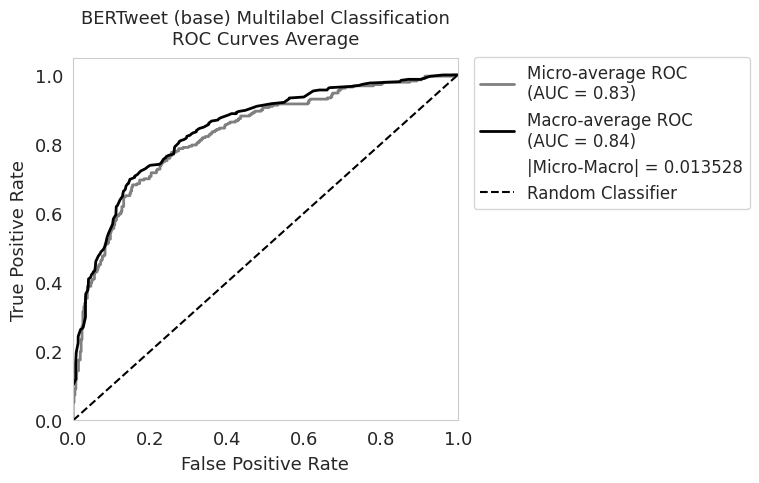

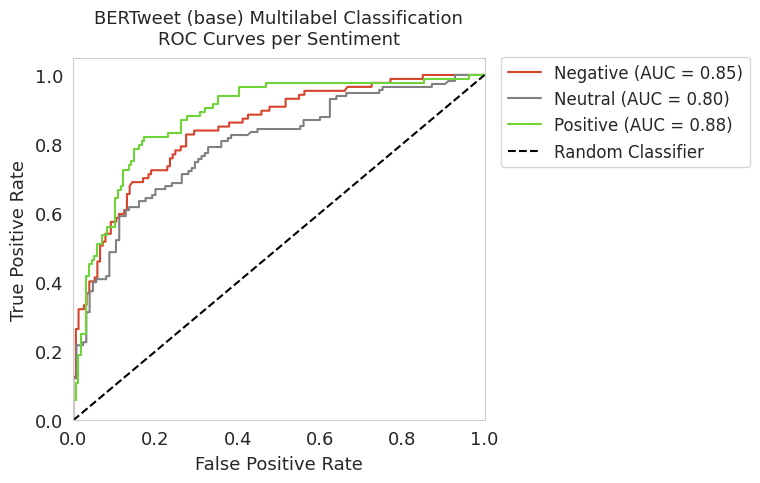

,ROC AUC,Standard Deviation,95% CI Lower,95% CI Upper,Standard Error
Average Type,,,,,
Micro,0.826919,0.033474,0.779055,0.874783,0.024420
Macro,0.840447,0.033474,0.802567,0.878326,0.019326
Weighted,0.835824,0.034167,0.789157,0.882491,0.023810
Micro-Macro Gap,0.013528,-,-,-,-



Note: A small micro-macro AUC gap indicates uniform model performance across sentiment classes.
A large micro-macro AUC gap indicates inconsistent model performance across sentiment classes.


Class,Negative,Neutral,Positive
Total Samples,240.000000,240.000000,240.000000
Positive Samples,87.000000,115.000000,84.000000
Negative Samples,153.000000,125.000000,156.000000
AUC (roc_curve),0.845015,0.797357,0.878968
AUC (roc_auc_score),0.845015,0.797357,0.878968
95% CI Lower,0.838867,0.790785,0.873384
95% CI Upper,0.851163,0.803928,0.884553
Difference between methods,0.000000,0.000000,0.000000
Optimal Threshold,0.342008,0.406014,0.470270
Precision,0.631579,0.806818,0.718750



ROC curve average metrics saved to: /workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Results/roc_curve_average_metrics.csv

ROC curve analysis saved to: /workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Results/roc_curve_analysis.csv




In [25]:
#==================================================================================================
#         Visualizations ROC Curve for Multilabel Classification using the model prodictions 
#==================================================================================================

from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# Seaborn setting
sns.set_style("whitegrid", {'axes.grid': False})

# Base output directory
base_dir = "/workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML"
predictions_dir = os.path.join(base_dir, 'Results/predictions')
figure_dir = os.path.join(base_dir, "Figures")
os.makedirs(figure_dir, exist_ok=True)

# Load and prepare data
ensemble_logits = np.load(os.path.join(predictions_dir, 'ensemble_logits.npy'))
y_test_true = np.load(os.path.join(base_dir, 'test_data/y_test_ML.npy'))

# Sigmoid function for converting logits to probabilities
def sigmoid(x):
    """Compute sigmoid values for each set of scores in x."""
    return 1 / (1 + np.exp(-x))

# Convert logits to probabilities
test_pred_proba = sigmoid(ensemble_logits)

# Define labels and colors
label_names = ['Negative', 'Neutral', 'Positive']
colors = ['#d5442b', 'grey', '#6fd437']


# ======================== ROC Curves Plotting ========================
display(HTML('<div style="font-size: 22px; font-weight: bold;">ROC Curves</div>'))

# --------- First plot: Micro and Macro average ROC curves --------- 
plt.figure(figsize=(7.8, 5))

# Compute micro-average ROC curve
y_test_bin = label_binarize(y_test_true, classes=range(len(label_names)))
y_test_flat = y_test_bin.ravel()
y_pred_proba_flat = test_pred_proba.ravel()

# Initialize variables for micro-average ROC
fpr_micro, tpr_micro, roc_auc_micro = 0, 0, 0

# Compute micro-average ROC curve using flattened arrays
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), test_pred_proba.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, 
         label=f'Micro-average ROC\n(AUC = {roc_auc_micro:.2f})',
         color='gray', linestyle='-', linewidth=2)

# Compute and plot macro-average ROC curve
all_fpr = np.unique(np.concatenate([roc_curve(y_test_bin[:, i], test_pred_proba[:, i])[0] 
                                  for i in range(len(label_names))]))
mean_tpr = np.zeros_like(all_fpr)

class_aucs = []
for i in range(len(label_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], test_pred_proba[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)
    class_aucs.append(auc(fpr, tpr))

mean_tpr /= len(label_names)
macro_auc = np.mean(class_aucs)

# Calculate micro-macro difference
micro_macro_diff = abs(roc_auc_micro - macro_auc)

plt.plot(all_fpr, mean_tpr, 'k-',
         label=f'Macro-average ROC\n(AUC = {macro_auc:.2f})',
         linewidth=2)

# Add separate legend entry for micro-macro difference
plt.plot([], [], ' ', 
         label=f'|Micro-Macro| = {micro_macro_diff:.6f}')

# Add random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BERTweet (base) Multilabel Classification\nROC Curves Average')
plt.legend(bbox_to_anchor=(1.02, 1.025), loc='upper left')
plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(figure_dir, 'BERTweet_base_ML_ROC_curves_averages.png'), 
            dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(figure_dir, 'BERTweet_base_ML_ROC_curves_averages.tiff'), 
            dpi=300, bbox_inches='tight')
plt.show()



# ---------  Second plot: Per-class ROC curves --------- 
plt.figure(figsize=(7.8, 5))

# Store ROC results for reporting
roc_results = []

# Plot ROC curves for each class
for i, (class_name, color) in enumerate(zip(label_names, colors)):
    # One-vs-rest approach
    y_true_binary = y_test_bin[:, i]  # Use the binarized labels directly
    y_score = test_pred_proba[:, i]
    
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_score)
    roc_auc = auc(fpr, tpr)
    
    # Compute confidence interval for AUC
    n_pos = np.sum(y_true_binary)
    n_neg = len(y_true_binary) - n_pos
    se = np.sqrt((roc_auc * (1 - roc_auc)) / (n_pos * n_neg))
    ci_lower = max(0, roc_auc - 1.96 * se)
    ci_upper = min(1, roc_auc + 1.96 * se)
    
    # Store results
    roc_results.append({
        'Class': class_name,
        'AUC': roc_auc,
        'CI Lower': ci_lower,
        'CI Upper': ci_upper
    })
    
    # Plot ROC curve
    plt.plot(fpr, tpr, color=color,
             label=f'{class_name} (AUC = {roc_auc:.2f})')

# Add random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BERTweet (base) Multilabel Classification\nROC Curves per Sentiment')
plt.legend(bbox_to_anchor=(1.02, 1.025), loc='upper left')
plt.tight_layout()

# Save the figure
sentiment_roc_curve_path = os.path.join(figure_dir, 'BERTweet_base_ML_ROC_curves_per_sentiment.png')
plt.savefig(sentiment_roc_curve_path, dpi=300, bbox_inches='tight')
sentiment_roc_curve_path2 = os.path.join(figure_dir, 'BERTweet_base_ML_ROC_curves_per_sentiment.tiff')
plt.savefig(sentiment_roc_curve_path2, dpi=300, bbox_inches='tight')
plt.show()



# ======================== Additional Statistics ========================

# ------------------- Calculate ROC Average Metrics ---------------------

def calculate_average_metrics(y_true, y_pred_proba, classes):
    """
    Calculate micro, macro, and weighted averages for ROC AUC scores.
    Also includes standard deviation of AUC scores across classes.
    """
    n_classes = len(classes)
    
    # Binarize the labels for multi-class metrics
    y_true_bin = label_binarize(y_true, classes=range(n_classes))
    
    # Initialize lists for storing metrics
    class_metrics = []
    class_auc_scores = []
    
    # Calculate metrics for each class
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc = auc(fpr, tpr)
        class_metrics.append({
            'class': classes[i],
            'auc': roc_auc,
        })
        class_auc_scores.append(roc_auc)
    
    # Micro average
    fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
    auc_micro = auc(fpr_micro, tpr_micro)
    
    # Macro average (simple average of class-wise AUC scores)
    auc_macro = np.mean(class_auc_scores)
    
    # Weighted average (weighted by class support)
    class_support = np.sum(y_true_bin, axis=0)
    auc_weighted = np.average(class_auc_scores, weights=class_support)
    
    # Calculate standard errors and confidence intervals
    n_samples = len(y_true)
    
    # Standard error for micro average
    se_micro = np.sqrt(auc_micro * (1 - auc_micro) / n_samples)
    ci_micro = (auc_micro - 1.96 * se_micro, auc_micro + 1.96 * se_micro)
    
    # Standard error for macro average
    se_macro = np.sqrt(np.var(class_auc_scores) / n_classes)
    ci_macro = (auc_macro - 1.96 * se_macro, auc_macro + 1.96 * se_macro)
    
    # Standard error for weighted average
    se_weighted = np.sqrt(np.average([(auc * (1 - auc)) for auc in class_auc_scores], 
                                   weights=class_support) / n_samples)
    ci_weighted = (auc_weighted - 1.96 * se_weighted, auc_weighted + 1.96 * se_weighted)
    
    # Calculate standard deviations
    std_across_classes = np.std(class_auc_scores)
    
    return {
        'micro': {
            'auc': auc_micro,
            'ci': ci_micro,
            'se': se_micro,
            'std': std_across_classes
        },
        'macro': {
            'auc': auc_macro,
            'ci': ci_macro,
            'se': se_macro,
            'std': std_across_classes
        },
        'weighted': {
            'auc': auc_weighted,
            'ci': ci_weighted,
            'se': se_weighted,
            'std': np.sqrt(np.average((np.array(class_auc_scores) - auc_weighted) ** 2, weights=class_support))
        },
        'class_metrics': class_metrics
    }

# Calculate average metrics
average_metrics = calculate_average_metrics(y_test_true, test_pred_proba, range(len(label_names)))

# Create a DataFrame for average metrics
average_metrics_data = []
for avg_type in ['micro', 'macro', 'weighted']:
    metrics = average_metrics[avg_type]
    average_metrics_data.append({
        'Average Type': avg_type.capitalize(),
        'ROC AUC': f"{metrics['auc']:.6f}",
        'Standard Deviation': f"{metrics['std']:.6f}",
        '95% CI Lower': f"{metrics['ci'][0]:.6f}",
        '95% CI Upper': f"{metrics['ci'][1]:.6f}",
        'Standard Error': f"{metrics['se']:.6f}"
    })

# Add the micro-macro gap row
micro_macro_gap = abs(average_metrics['micro']['auc'] - average_metrics['macro']['auc'])
average_metrics_data.append({
    'Average Type': 'Micro-Macro Gap',
    'ROC AUC': f"{micro_macro_gap:.6f}",
    'Standard Deviation': "-",
    '95% CI Lower': "-",
    '95% CI Upper': "-",
    'Standard Error': "-"
})

average_metrics_df = pd.DataFrame(average_metrics_data)
average_metrics_df = average_metrics_df.set_index('Average Type')


# Display the average metrics table
print("\n")
display(HTML('<div style="font-size: 22px; font-weight: bold;">Receiver Operating Characteristic (ROC) Curve Metrics</div>'))
display(HTML("<br><b>Area Under the Curve (AUC): ROC Curve Average Metrics</b>"))
display(HTML(average_metrics_df.to_html()))

# Save average metrics to CSV
average_metrics_save_path = os.path.join(base_dir, 'Results', 'roc_curve_average_metrics.csv')
average_metrics_df.to_csv(average_metrics_save_path, sep=';')

# Notes printing
print("\nNote: A small micro-macro AUC gap indicates uniform model performance across sentiment classes.")
print("A large micro-macro AUC gap indicates inconsistent model performance across sentiment classes.")



# ------------- ROC Curve Detailed Analysis per Sentiments -------------

detailed_roc_results = []
for i, class_name in enumerate(label_names):
    # One-vs-rest approach
    y_true_binary = y_test_bin[:, i]  # Use the binarized labels directly
    y_score = test_pred_proba[:, i]
    
    # Method 1: sklearn's roc_curve
    fpr, tpr, thresholds = roc_curve(y_true_binary, y_score)
    
    # Method 2: Direct AUC computation
    auc_direct = auc(fpr, tpr)
    
    # Method 3: roc_auc_score
    auc_score = roc_auc_score(y_true_binary, y_score)
    
    # Additional statistical validation
    n_pos = np.sum(y_true_binary)
    n_neg = len(y_true_binary) - n_pos
    
    # Confidence interval for AUC
    se = np.sqrt((auc_direct * (1 - auc_direct)) / (n_pos * n_neg))
    ci_lower = max(0, auc_direct - 1.96 * se)
    ci_upper = min(1, auc_direct + 1.96 * se)
    
    # Find optimal threshold
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    
    # Calculate metrics at optimal threshold
    y_pred_threshold = (y_score >= optimal_threshold).astype(int)
    
    precision = precision_score(y_true_binary, y_pred_threshold, zero_division=0)
    recall = recall_score(y_true_binary, y_pred_threshold, zero_division=0)
    
    # Store results
    result = {
        'Class': class_name,
        'Total Samples': len(y_true_binary),
        'Positive Samples': n_pos,
        'Negative Samples': n_neg,
        'AUC (roc_curve)': auc_direct,
        'AUC (roc_auc_score)': auc_score,
        '95% CI Lower': ci_lower,
        '95% CI Upper': ci_upper,
        'Difference between methods': abs(auc_direct - auc_score),
        'Optimal Threshold': optimal_threshold,
        'Precision': precision,
        'Recall': recall
    }
    
    detailed_roc_results.append(result)

# Create a transposed DataFrame for better readability
roc_analysis_df = pd.DataFrame(detailed_roc_results).set_index('Class').T

# format float columns to a specific number of decimal places
float_columns = roc_analysis_df.select_dtypes(include=[np.float64]).columns
for col in float_columns:
    roc_analysis_df[col] = roc_analysis_df[col].apply(lambda x: f"{x:.6f}" if pd.notnull(x) else x)

# Save to CSV
save_path = os.path.join(base_dir, 'Results', 'roc_curve_analysis.csv')
roc_analysis_df.to_csv(save_path, sep=';')

# Display in Jupyter Notebook
display(HTML("<br><b>\nROC Curve Analysis by Sentiment</b>"))
display(HTML(roc_analysis_df.to_html()))
print(f"\nROC curve average metrics saved to: {average_metrics_save_path}")
print(f"\nROC curve analysis saved to: {save_path }\n\n")


### Probability Distribution for Multilabel Classification

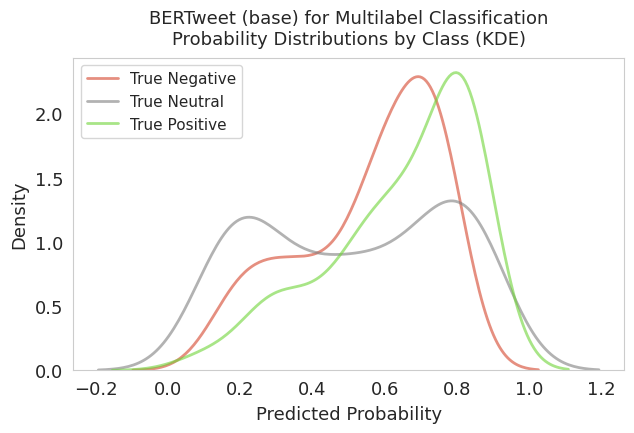

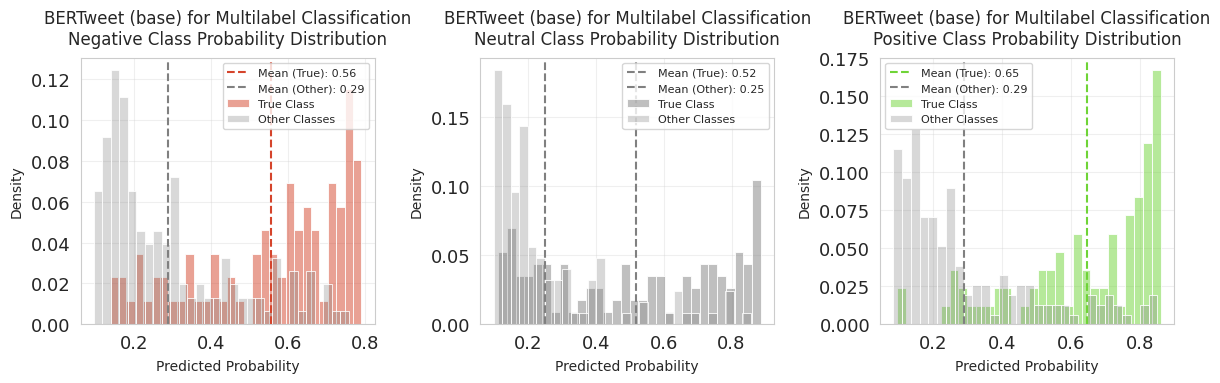

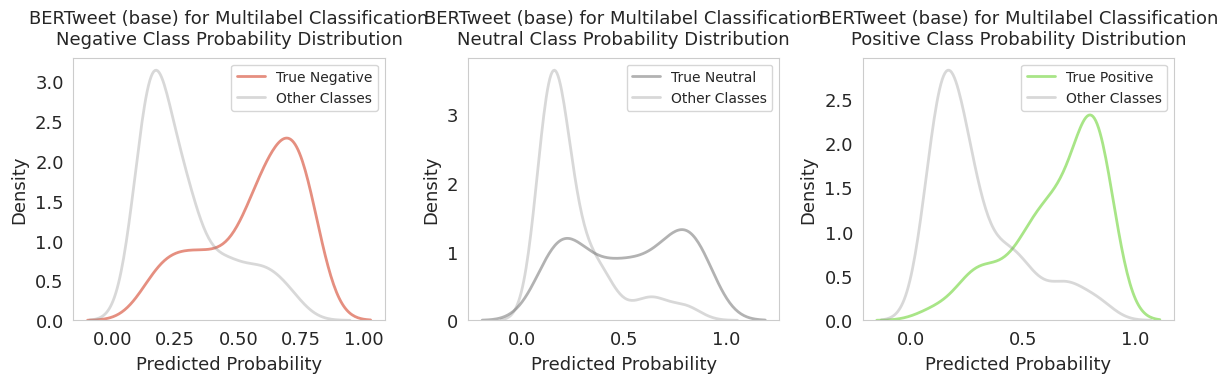

,True Class (Mean),True Class (Std),Other Classes (Mean),Other Classes (Std),Separation
Metric,,,,,
Negative,0.556802,0.190857,0.289148,0.169734,0.267654
Neutral,0.517603,0.262511,0.251354,0.174408,0.266250
Positive,0.646284,0.200087,0.290503,0.199020,0.355781


In [26]:
# ============== Visualize Probability Distributions for Multilabel Classification ====================

# --------------- KDE Plot All Sentiment ---------------

plt.figure(figsize=(6.5, 4.5))
for i, (class_name, color) in enumerate(zip(label_names, colors)):
    class_probs = test_pred_proba[:, i]
    true_class = y_test_bin[:, i].astype(bool)  # Use the binarized labels directly
    
    # Plot distributions
    sns.kdeplot(data=class_probs[true_class], color=color, alpha=0.6, 
                label=f'True {class_name}', linewidth=2)

plt.title('BERTweet (base) for Multilabel Classification\nProbability Distributions by Class (KDE)')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.legend(fontsize=11)
plt.grid(False)
plt.tight_layout()

# Save the figure
prob_path = os.path.join(figure_dir, 'BERTweet_base_ML_probability_distributions.png')
plt.savefig(prob_path, dpi=300, bbox_inches='tight')
display(HTML('<div style="font-size: 22px; font-weight: bold;">Probability Distributions</div>'))

plt.show()



# ================== Enhanced Probability Distribution Visualization ===================

plt.figure(figsize=(12, 4))
for i, class_name in enumerate(label_names):
    plt.subplot(1, 3, i+1)
    # Get probabilities for the current class
    class_probs = test_pred_proba[:, i]
    # Get true labels for this class
    true_class = y_test_bin[:, i].astype(bool)
    
    # Plot distributions separately for true positives and true negatives
    sns.histplot(data=class_probs[true_class], bins=30, color=colors[i], alpha=0.5, 
                label='True Class', stat='probability')
    sns.histplot(data=class_probs[~true_class], bins=30, color='gray', alpha=0.3, 
                label='Other Classes', stat='probability')
    
    # Add mean lines
    plt.axvline(class_probs[true_class].mean(), color=colors[i], linestyle='--', 
                label=f'Mean (True): {class_probs[true_class].mean():.2f}')
    plt.axvline(class_probs[~true_class].mean(), color='gray', linestyle='--', 
                label=f'Mean (Other): {class_probs[~true_class].mean():.2f}')
    
    plt.title(f'BERTweet (base) for Multilabel Classification\n{class_name} Class Probability Distribution', fontsize=12)
    plt.xlabel('Predicted Probability', fontsize=10)
    plt.ylabel('Density', fontsize=10)
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
plt.tight_layout()


# Save the figure
roc_curve_path = os.path.join(figure_dir, 'BERTweet_base_ML_probability_distributions_hist_true_false.png')
plt.savefig(roc_curve_path, dpi=300, bbox_inches='tight')
plt.show()



# --------------- KDE Plot - separate plots for each class ---------------
plt.figure(figsize=(12, 4))

for i, (class_name, color) in enumerate(zip(label_names, colors)):
    plt.subplot(1, 3, i+1)
    
    # Get probabilities for current class
    class_probs = test_pred_proba[:, i]
    true_class = y_test_bin[:, i].astype(bool)
    
    # Plot distributions
    sns.kdeplot(data=class_probs[true_class], color=color, alpha=0.6, 
                label=f'True {class_name}', linewidth=2)
    sns.kdeplot(data=class_probs[~true_class], color='gray', alpha=0.3, 
                label=f'Other Classes', linewidth=2)
    
    plt.title(f'BERTweet (base) for Multilabel Classification\n{class_name} Class Probability Distribution')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Density')
    plt.legend(fontsize=10)
    plt.grid(False)

plt.tight_layout()


# Save the figure
roc_curve_path = os.path.join(figure_dir, 'BERTweet_base_ML_probability_distributions_KDE_true_false.png')
plt.savefig(roc_curve_path, dpi=300, bbox_inches='tight')
plt.show()



# ================== Print distribution statistics ==================
# Create and display probability distribution statistics table
prob_stats = []
metrics = ['True Class (Mean)', 'True Class (Std)', 'Other Classes (Mean)', 
          'Other Classes (Std)', 'Separation']

for i, class_name in enumerate(label_names):
    class_probs = test_pred_proba[:, i]
    true_class = y_test_bin[:, i].astype(bool)
    
    stats = {
        'Metric': class_name,
        'True Class (Mean)': f"{class_probs[true_class].mean():.6f}",
        'True Class (Std)': f"{class_probs[true_class].std():.6f}",
        'Other Classes (Mean)': f"{class_probs[~true_class].mean():.6f}",
        'Other Classes (Std)': f"{class_probs[~true_class].std():.6f}",
        'Separation': f"{class_probs[true_class].mean() - class_probs[~true_class].mean():.6f}"
    }
    prob_stats.append(stats)

# Create DataFrame and display
prob_stats_df = pd.DataFrame(prob_stats).set_index('Metric')
display(HTML("<br><b>Probability Distribution Statistics</b>"))
display(HTML(prob_stats_df.to_html()))

### Confusion Matrices for Multilabel Classification


Sentiment Distribution:


,True Label,Predictions
Negative,87,84
Neutral,115,73
Positive,84,90



Sentiment Distribution table saved in: /workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Results BERTweet_base_ML_Sentiment_Distribution.csv

Classification Report:


,precision,recall,f1-score,support
Negative,0.714286,0.689655,0.701754,87.0
Neutral,0.821918,0.521739,0.638298,115.0
Positive,0.733333,0.785714,0.758621,84.0
micro avg,0.753036,0.650350,0.697936,286.0
macro avg,0.756512,0.665703,0.699558,286.0
weighted avg,0.763159,0.650350,0.692941,286.0
samples avg,0.729167,0.680556,0.690278,286.0



Additional Statistical Metrics:


,Metric,Value
0,Weighted Accuracy,0.770032
1,Weighted Precision,0.763159
2,Weighted Recall,0.650350
3,Weighted F1-Score,0.692941
4,Hamming Loss,0.223611



Analysis complete. Results saved in: /workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Results


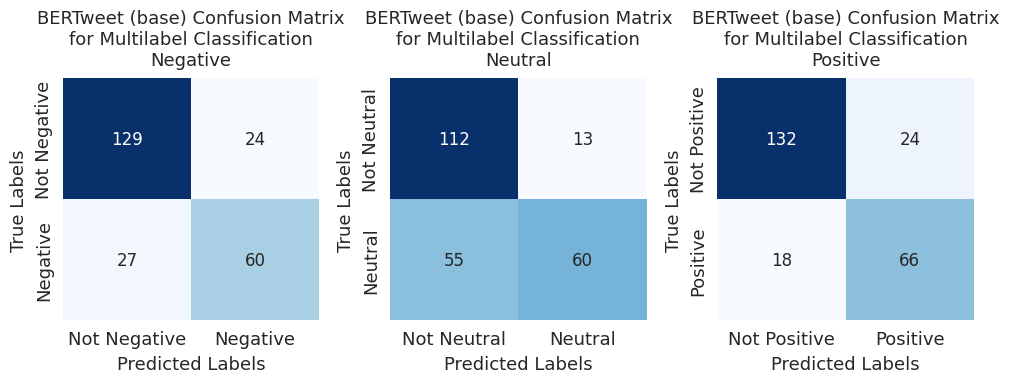

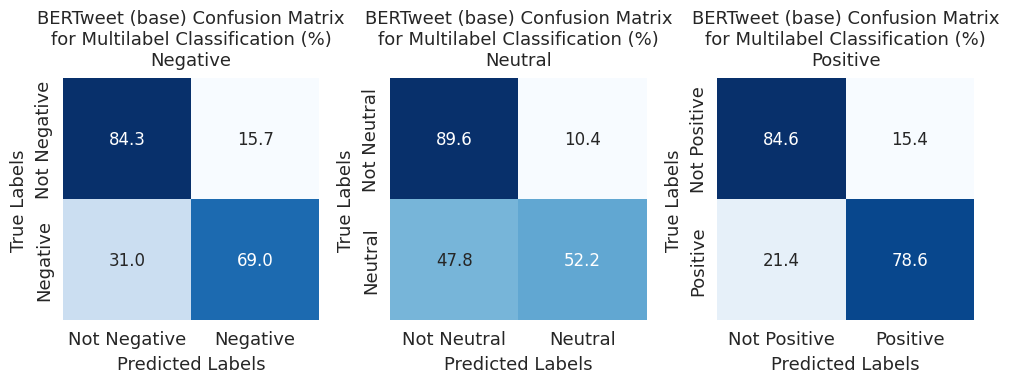

In [27]:
#==================================================================================================
#                 Visualizations of Confusion Matrices and Sentiment Distribution 
#==================================================================================================


# ============== Preparing Data ================
# Using the data from ROC curve analysis
# Convert numeric predictions to string labels
y_true_str = [label_names[i] for i in np.argmax(y_test_bin, axis=1)]
y_pred = np.argmax(test_pred_proba, axis=1)
y_pred_str = [label_names[i] for i in y_pred]

# Create output directory if it doesn't exist
output_dir = os.path.join(base_dir, 'Results')
os.makedirs(output_dir, exist_ok=True)

def compute_statistical_metrics(y_true, y_pred, labels):
    """Compute additional statistical metrics"""
    # Create copies of input data
    y_true_copy = np.array(y_true).copy()
    y_pred_copy = np.array(y_pred).copy()
    
    label_map = {label: idx for idx, label in enumerate(labels)}
    y_true_numeric = np.array([label_map[label] for label in y_true_copy])
    y_pred_numeric = np.array([label_map[label] for label in y_pred_copy])
    
    results = {
        'Weighted Accuracy': accuracy_score(y_true_numeric, y_pred_numeric, normalize=True),
        'Weighted Precision': precision_score(y_true_numeric, y_pred_numeric, average='weighted'),
        'Weighted Recall': recall_score(y_true_numeric, y_pred_numeric, average='weighted'),
        'Weighted F1-Score': f1_score(y_true_numeric, y_pred_numeric, average='weighted'),
        'Cohen\'s Kappa': cohen_kappa_score(y_true_numeric, y_pred_numeric)        
    }
    
    return results.copy()

# ============== Basic Distribution Analysis ================
# Create DataFrames for True Label and Prediction distributions
true_label_dist = pd.DataFrame({label: y_test_bin[:, i].sum() for i, label in enumerate(label_names)}, index=['True Label']).T
prediction_dist = pd.DataFrame({label: (test_pred_proba[:, i] >= 0.5).sum() for i, label in enumerate(label_names)}, index=['Predictions']).T

# Merge the two DataFrames
distribution_table = pd.concat([true_label_dist, prediction_dist], axis=1)

# Reorder rows to match the desired order
distribution_table = distribution_table.loc[label_names]

# Convert counts to integers
distribution_table = distribution_table.astype(int)

print("\nSentiment Distribution:")
display(distribution_table)

# Save the distribution table
distribution_table.to_csv(os.path.join(output_dir, 'BERTweet_base_ML_Sentiment_Distribution.csv'))
print("\nSentiment Distribution table saved in:", output_dir, 'BERTweet_base_ML_Sentiment_Distribution.csv')

# Calculate accuracy for each class
accuracies = [(y_test_bin[:, i] == (test_pred_proba[:, i] >= 0.5)).mean() for i in range(len(label_names))]

# Classification report
print("\nClassification Report:")
class_report = classification_report(y_test_bin, (test_pred_proba >= 0.5).astype(int), target_names=label_names, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
display(class_report_df)

# Additional metrics
additional_metrics = {
    'Weighted Accuracy': np.average(accuracies, weights=[len(y_test_bin[y_test_bin[:, i] == 1]) for i in range(len(label_names))]),
    'Weighted Precision': class_report['weighted avg']['precision'],
    'Weighted Recall': class_report['weighted avg']['recall'],
    'Weighted F1-Score': class_report['weighted avg']['f1-score'],
    'Hamming Loss': hamming_loss(y_test_bin, (test_pred_proba >= 0.5).astype(int))
}

print("\nAdditional Statistical Metrics:")
additional_metrics_df = pd.DataFrame.from_dict(additional_metrics, orient='index', columns=['Value'])
additional_metrics_df.index.name = 'Metric'
additional_metrics_df = additional_metrics_df.reset_index()
additional_metrics_df['Value'] = additional_metrics_df['Value'].apply(lambda x: f'{x:.6f}')
pd.set_option('display.max_colwidth', None)
display(additional_metrics_df)

print("\nAnalysis complete. Results saved in:", output_dir)


# ============== Confusion Matrix Visualization ================

# Create confusion matrices for each class
confusion_matrices = []
for i, class_name in enumerate(label_names):
    y_true_binary = y_test_bin[:, i]
    y_pred_binary = (test_pred_proba[:, i] >= 0.5).astype(int)
    cm = confusion_matrix(y_true_binary, y_pred_binary)
    confusion_matrices.append(cm)

# Plot counts
fig_counts, axes_counts = plt.subplots(1, len(confusion_matrices), figsize=(10, 4))
axes_counts = [axes_counts] if len(confusion_matrices) == 1 else axes_counts

for i, conf_matrix in enumerate(confusion_matrices):
    sns.heatmap(
        conf_matrix,
        annot=conf_matrix,
        fmt='g',
        cmap='Blues',
        cbar=False,
        ax=axes_counts[i],
        xticklabels=[f'Not {label_names[i]}', label_names[i]],
        yticklabels=[f'Not {label_names[i]}', label_names[i]]
    )
    axes_counts[i].set_title(f'BERTweet (base) Confusion Matrix\nfor Multilabel Classification\n{label_names[i]}')
    axes_counts[i].set_xlabel('Predicted Labels')
    axes_counts[i].set_ylabel('True Labels')

plt.tight_layout()
plt.savefig(os.path.join(figure_dir, 'BERTweet_base_ML_confusion_matrix_counts.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

# Plot percentages
fig_percentages, axes_percentages = plt.subplots(1, len(confusion_matrices), figsize=(10, 4))
axes_percentages = [axes_percentages] if len(confusion_matrices) == 1 else axes_percentages

for i, conf_matrix in enumerate(confusion_matrices):
    row_sums = conf_matrix.sum(axis=1)
    conf_matrix_normalized = np.zeros_like(conf_matrix, dtype=float)
    for j in range(len(row_sums)):
        if row_sums[j] != 0:
            conf_matrix_normalized[j] = conf_matrix[j] / row_sums[j]
    
    sns.heatmap(
        conf_matrix_normalized * 100,
        annot=np.round(conf_matrix_normalized * 100, 1),
        fmt='.1f',
        cmap='Blues',
        cbar=False,
        ax=axes_percentages[i],
        xticklabels=[f'Not {label_names[i]}', label_names[i]],
        yticklabels=[f'Not {label_names[i]}', label_names[i]]
    )
    axes_percentages[i].set_title(f'BERTweet (base) Confusion Matrix\nfor Multilabel Classification (%)\n{label_names[i]}')
    axes_percentages[i].set_xlabel('Predicted Labels')
    axes_percentages[i].set_ylabel('True Labels')

plt.tight_layout()
plt.savefig(os.path.join(figure_dir, 'BERTweet_base_ML_confusion_matrix_percentage.png'), 
            dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(figure_dir, 'BERTweet_base_ML_confusion_matrix_percentage.tiff'), 
            dpi=300, bbox_inches='tight')
plt.show()


# Multiclass VS Multilabel Comparison

## Comparing Hyperparameters

In [27]:
# ========== Print a comparative table with both hyperparameters ============

# File paths - Updated to correct paths
MC_PARAMS_PATH = "/workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Optuna_search/BERTweet_MC_best_hyperparameters.json"
ML_PARAMS_PATH = "/workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Optuna_search/BERTweet_ML_best_hyperparameters.json"

def read_json_params(file_path):
    """Read parameters from JSON file"""
    try:
        with open(file_path, 'r') as f:
            params = json.load(f)
            return params
    except FileNotFoundError:
        print(f"Warning: {file_path} not found")
        return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON file {file_path}: {e}")
        return {}

def create_parameter_comparison():
    """Create and save parameter comparison table"""
    # Get parameters from JSON files
    mc_params = read_json_params(MC_PARAMS_PATH)
    ml_params = read_json_params(ML_PARAMS_PATH)
    
    # Define base parameters that don't change
    base_params = {
        "Optimizer": "AdamW",
        "Activation Output Layer": ["Softmax", "Sigmoid"],
        "Loss Function": ["CrossEntropyLoss", "BCEWithLogitsLoss"],
        "Cross-Validation Folds": "5",
        "Early Stopping Patience": "3",
        "Early Stopping Threshold": "0.01",
        "Evaluation Strategy": "epoch",
        "Metric for Best Model": "custom metric",
        "FP16 Training": "True",
        "Number of Labels": "3",
        "Seed": "42",
        "Hyperparameter Search Method": "Optuna"
    }
    
    # Create DataFrame content
    data = {
        "Parameters": [
            "Max Length",
            "Learning Rate",
            "Batch Size",
            "Warmup Ratio",
            "Warmup Steps",
            "Weight Decay",
            "Train Epochs",
            *base_params.keys()
        ],
        "Multiclass BERTweet base": [
            str(mc_params.get('max_length', 'N/A')),
            f"{mc_params.get('learning_rate', 'N/A')}",
            str(mc_params.get('batch_size', 'N/A')),
            str(mc_params.get('warmup_ratio', 'N/A')),
            str(mc_params.get('warmup_steps', 'N/A')),
            str(mc_params.get('weight_decay', 'N/A')),
            str(mc_params.get('num_train_epochs', 'N/A')),
            *[v[0] if isinstance(v, list) else v for v in base_params.values()]
        ],
        "Multilabel BERTweet base": [
            str(ml_params.get('max_length', 'N/A')),
            f"{ml_params.get('learning_rate', 'N/A')}",
            str(ml_params.get('batch_size', 'N/A')),
            str(ml_params.get('warmup_ratio', 'N/A')),
            str(ml_params.get('warmup_steps', 'N/A')),
            str(ml_params.get('weight_decay', 'N/A')),
            str(ml_params.get('num_train_epochs', 'N/A')),
            *[v[1] if isinstance(v, list) else v for v in base_params.values()]
        ]
    }
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Save to CSV
    output_dir = '/workspace/Output/BERTweet/Comparison'
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, "BERT_base_parameters_comparison.csv")
    df.to_csv(output_file, index=False, sep=';')
    print(f"\nSaved comparison table to: {output_file}")
    
    return df

# Create and display the table
comparison_df = create_parameter_comparison()
display(HTML(comparison_df.to_html(index=False)))


Saved comparison table to: /workspace/Output/BERTweet/Comparison/BERT_base_parameters_comparison.csv


Parameters,Multiclass BERTweet base,Multilabel BERTweet base
Max Length,92,130
Learning Rate,1e-05,0.0001
Batch Size,8,8
Warmup Ratio,0.005,0.1
Warmup Steps,250,500
Weight Decay,0.05,0.1
Train Epochs,13,7
Optimizer,AdamW,AdamW
Activation Output Layer,Softmax,Sigmoid
Loss Function,CrossEntropyLoss,BCEWithLogitsLoss


## Comparating Metrics

### Accuracy, Precision, Recall and F1-Score Comparison

In [28]:
# Table including multiclass and mutlilabel results

try:
   # Define file paths and read CSV files
   mc_file_path = '/workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Results/test_result_complete.csv'
   ml_file_path = '/workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Results/test_result_complete.csv'
   
   mc_results = pd.read_csv(mc_file_path, sep=';', encoding='utf-8')
   ml_results = pd.read_csv(ml_file_path, sep=';', encoding='utf-8')
   
   # Define metric mappings
   metric_pairs = [
       ("Accuracy", "Accuracy (Macro)", "Accuracy (Weighted)"),
       ("Precision", "Precision (Macro)", "Precision (Weighted)"),
       ("Recall", "Recall (Macro)", "Recall (Weighted)"),
       ("F1-Score", "F1-Score (Macro)", "F1-Score (Weighted)")
   ]

   comparative_data = []
   
   # Process each metric pair
   for base_metric, mc_metric, ml_metric in metric_pairs:
       try:
           # Get MC values (using Macro)
           mc_row = mc_results[mc_results['Metric'] == mc_metric]
           if not mc_row.empty:
               mc_row = mc_row.iloc[0]
               mc_value = float(mc_row['Ensemble Score'])
               mc_std = float(mc_row['Individual Std'])
               mc_ci_lower = float(mc_row['CI Lower'])
               mc_ci_upper = float(mc_row['CI Upper'])
           else:
               print(f"Warning: Metric {mc_metric} not found in MC data")
               continue
           
           # Get ML values (using Weighted)
           ml_row = ml_results[ml_results['Metric'] == ml_metric]
           if not ml_row.empty:
               ml_row = ml_row.iloc[0]
               ml_value = float(ml_row['Ensemble Score'])
               ml_std = float(ml_row['Individual Std'])
               ml_ci_lower = float(ml_row['CI Lower'])
               ml_ci_upper = float(ml_row['CI Upper'])
           else:
               print(f"Warning: Metric {ml_metric} not found in ML data")
               continue
           
           difference = ml_value - mc_value
           best_class = "Multilabel" if difference > 0 else "Multiclass"
           
           comparative_data.append({
               'Metric': base_metric,
               'Multiclass BERTweet base *': f"{mc_value:.6f}",
               'Standard deviation MC [Confidence Interval] *': f"{mc_std:.6f} [{mc_ci_lower:.6f}-{mc_ci_upper:.6f}]",
               'Multilabel BERTweet base **': f"{ml_value:.6f}",
               'Standard deviation ML [Confidence Interval] **': f"{ml_std:.6f} [{ml_ci_lower:.6f}-{ml_ci_upper:.6f}]",
               'Difference': f"{difference:.6f}",
               'Best Classification': best_class
           })
           
       except Exception as e:
           print(f"Error processing metric {base_metric}: {str(e)}")
           continue

   # Create DataFrame
   comparative_metrics = pd.DataFrame(comparative_data)

   # Save to CSV
   output_dir = '/workspace/Output/BERTweet/Comparison'
   os.makedirs(output_dir, exist_ok=True)
   output_file = os.path.join(output_dir, "BERTweet_base_comparative_test_results.csv")
   comparative_metrics.to_csv(output_file, index=False, sep=';')

   # Display the table
   display(HTML(comparative_metrics.to_html(index=False)))

   # Print annotations
   display(HTML('<p><i>MC = Multiclass classification ; ML = Multilabel classification</i></p>'))
   display(HTML('<p><i>* Macro results (treats all classes equally)</i></p>'))
   display(HTML('<p><i>** Weighted results (account for class imbalance)</i></p>'))
   

except Exception as e:
   print(f"Main error: {str(e)}")

Metric,Multiclass BERTweet base *,Standard deviation MC [Confidence Interval] *,Multilabel BERTweet base **,Standard deviation ML [Confidence Interval] **,Difference,Best Classification
Accuracy,0.642452,0.031561 [0.575736-0.663362],0.770032,0.007433 [0.726483-0.747119],0.127580,Multilabel
Precision,0.641421,0.030943 [0.580386-0.666298],0.763159,0.015003 [0.705527-0.747181],0.121738,Multilabel
Recall,0.642452,0.031561 [0.575736-0.663362],0.650350,0.018581 [0.580499-0.632088],0.007897,Multilabel
F1-Score,0.641420,0.032709 [0.573066-0.663882],0.692941,0.017905 [0.616117-0.665830],0.051521,Multilabel


### Accuracy, Metric2, Precision, Recall and F1-Score Comparison

In [29]:
# Version 2: table including multiclass and mutlilabel results including Metric2

import pandas as pd
from IPython.display import HTML
import os

try:
   # Define file paths and read CSV files
   mc_file_path = '/workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Results/test_result_complete.csv'
   ml_file_path = '/workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Results/test_result_complete.csv'
   
   mc_results = pd.read_csv(mc_file_path, sep=';', encoding='utf-8')
   ml_results = pd.read_csv(ml_file_path, sep=';', encoding='utf-8')
   
   # Define metric mappings
   metric_pairs = [
       ("Accuracy", "Accuracy (Macro)", "Accuracy (Weighted)"),
       ("Metric2", "Metric2_MC", "ML_Metric2"),  # Added Metric2
       ("Precision", "Precision (Macro)", "Precision (Weighted)"),
       ("Recall", "Recall (Macro)", "Recall (Weighted)"),
       ("F1-Score", "F1-Score (Macro)", "F1-Score (Weighted)")
   ]

   comparative_data = []
   
   # Process each metric pair
   for base_metric, mc_metric, ml_metric in metric_pairs:
       try:
           # Get MC values (using Macro)
           mc_row = mc_results[mc_results['Metric'] == mc_metric]
           if not mc_row.empty:
               mc_row = mc_row.iloc[0]
               mc_value = float(mc_row['Ensemble Score'])
               mc_std = float(mc_row['Individual Std'])
               mc_ci_lower = float(mc_row['CI Lower'])
               mc_ci_upper = float(mc_row['CI Upper'])
           else:
               print(f"Warning: Metric {mc_metric} not found in MC data")
               continue
           
           # Get ML values (using Weighted)
           ml_row = ml_results[ml_results['Metric'] == ml_metric]
           if not ml_row.empty:
               ml_row = ml_row.iloc[0]
               ml_value = float(ml_row['Ensemble Score'])
               ml_std = float(ml_row['Individual Std'])
               ml_ci_lower = float(ml_row['CI Lower'])
               ml_ci_upper = float(ml_row['CI Upper'])
           else:
               print(f"Warning: Metric {ml_metric} not found in ML data")
               continue
           
           difference = ml_value - mc_value
           best_class = "Multilabel" if difference > 0 else "Multiclass"
           
           comparative_data.append({
               'Metric': base_metric,
               'Multiclass BERTweet base *': f"{mc_value:.6f}",
               'Standard deviation MC [Confidence Interval] *': f"{mc_std:.6f} [{mc_ci_lower:.6f}-{mc_ci_upper:.6f}]",
               'Multilabel BERTweet base **': f"{ml_value:.6f}",
               'Standard deviation ML [Confidence Interval] **': f"{ml_std:.6f} [{ml_ci_lower:.6f}-{ml_ci_upper:.6f}]",
               'Difference': f"{difference:.6f}",
               'Best Classification': best_class
           })
           
       except Exception as e:
           print(f"Error processing metric {base_metric}: {str(e)}")
           continue

   # Create DataFrame
   comparative_metrics = pd.DataFrame(comparative_data)

   # Save to CSV
   output_dir = '/workspace/Output/BERTweet/Comparison'
   os.makedirs(output_dir, exist_ok=True)
   output_file = os.path.join(output_dir, "BERTweet_base_comparative_test_results_with metric2.csv")
   comparative_metrics.to_csv(output_file, index=False, sep=';')

   # Display the table
   display(HTML(comparative_metrics.to_html(index=False)))

   # Print annotations
   display(HTML('<p><i>MC = Multiclass classification ; ML = Multilabel classification</i></p>'))
   display(HTML('<p><i>* Macro results (treats all classes equally)</i></p>'))
   display(HTML('<p><i>** Weighted results (account for class imbalance)</i></p>'))

except Exception as e:
   print(f"Main error: {str(e)}")

Metric,Multiclass BERTweet base *,Standard deviation MC [Confidence Interval] *,Multilabel BERTweet base **,Standard deviation ML [Confidence Interval] **,Difference,Best Classification
Accuracy,0.642452,0.031561 [0.575736-0.663362],0.770032,0.007433 [0.726483-0.747119],0.127580,Multilabel
Metric2,0.769221,0.029799 [0.722093-0.804829],0.708333,0.026220 [0.646934-0.719733],-0.060888,Multiclass
Precision,0.641421,0.030943 [0.580386-0.666298],0.763159,0.015003 [0.705527-0.747181],0.121738,Multilabel
Recall,0.642452,0.031561 [0.575736-0.663362],0.650350,0.018581 [0.580499-0.632088],0.007897,Multilabel
F1-Score,0.641420,0.032709 [0.573066-0.663882],0.692941,0.017905 [0.616117-0.665830],0.051521,Multilabel


### Comparing Area Under the Curve (AUC) ROC Scores

In [30]:
# Building a comparative AUC table

try:
    # Define file paths
    mc_file_path = '/workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Results/roc_curve_average_metrics.csv'
    ml_file_path = '/workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Results/roc_curve_average_metrics.csv'
    
    # Read CSV files
    mc_results = pd.read_csv(mc_file_path, sep=';', encoding='utf-8')
    ml_results = pd.read_csv(ml_file_path, sep=';', encoding='utf-8')
    
    # Define AUC metrics to compare
    auc_metrics = [
        ("AUC (Macro)", "macro", "macro"),
        ("AUC (Micro)", "micro", "micro")
    ]

    comparative_data = []
    
    # Process each AUC metric
    for base_metric, mc_metric, ml_metric in auc_metrics:
        try:
            # Get MC values
            mc_row = mc_results[mc_results['Average Type'].str.lower() == mc_metric]
            if not mc_row.empty:
                mc_row = mc_row.iloc[0]
                mc_value = float(mc_row['ROC AUC'])
                mc_std = float(mc_row['Standard Deviation'])
                mc_ci_lower = float(mc_row['95% CI Lower'])
                mc_ci_upper = float(mc_row['95% CI Upper'])
            else:
                print(f"Warning: Metric {mc_metric} not found in MC data")
                continue
            
            # Get ML values
            ml_row = ml_results[ml_results['Average Type'].str.lower() == ml_metric]
            if not ml_row.empty:
                ml_row = ml_row.iloc[0]
                ml_value = float(ml_row['ROC AUC'])
                ml_std = float(ml_row['Standard Deviation'])
                ml_ci_lower = float(ml_row['95% CI Lower'])
                ml_ci_upper = float(ml_row['95% CI Upper'])
            else:
                print(f"Warning: Metric {ml_metric} not found in ML data")
                continue
            
            difference = ml_value - mc_value
            best_class = "Multilabel" if difference > 0 else "Multiclass"
            
            comparative_data.append({
                'Metric': base_metric,
                'Multiclass BERTweet base': f"{mc_value:.6f}",
                'Standard deviation MC [Confidence Interval]': f"{mc_std:.6f} [{mc_ci_lower:.6f}-{mc_ci_upper:.6f}]",
                'Multilabel BERTweet base': f"{ml_value:.6f}",
                'Standard deviation ML [Confidence Interval]': f"{ml_std:.6f} [{ml_ci_lower:.6f}-{ml_ci_upper:.6f}]",
                'Difference': f"{difference:.6f}",
                'Best Classification': best_class
            })
            
        except Exception as e:
            print(f"Error processing metric {base_metric}: {str(e)}")
            continue

    # Create DataFrame
    comparative_metrics = pd.DataFrame(comparative_data)

    # Save to CSV
    output_dir = '/workspace/Output/BERTweet/Comparison'
    os.makedirs(output_dir, exist_ok=True)
    output_file = os.path.join(output_dir, "BERTweet_base_comparative_roc_results.csv")
    comparative_metrics.to_csv(output_file, index=False, sep=';')

    # Display the table
    display(HTML(comparative_metrics.to_html(index=False)))

    # Print annotations
    display(HTML('<p><i>MC = Multiclass classification ; ML = Multilabel classification</i></p>'))

except Exception as e:
    print(f"Main error: {str(e)}")

Metric,Multiclass BERTweet base,Standard deviation MC [Confidence Interval],Multilabel BERTweet base,Standard deviation ML [Confidence Interval],Difference,Best Classification
AUC (Macro),0.829833,0.027989 [0.798160-0.861506],0.840447,0.033474 [0.802567-0.878326],0.010614,Multilabel
AUC (Micro),0.825764,0.027989 [0.777774-0.873754],0.826919,0.033474 [0.779055-0.874783],0.001155,Multilabel


## ROC (Receiver Operating Characteristic) Curves Comparisons

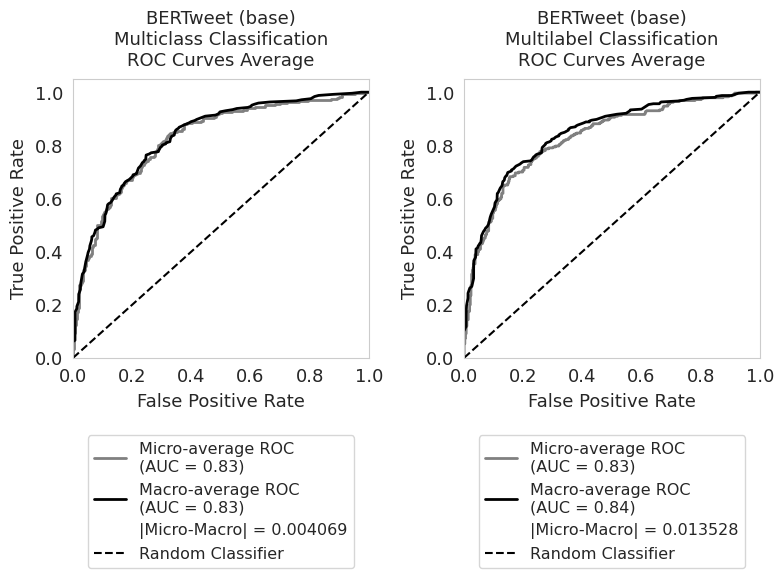

In [28]:
# ====================== Comparative ROC Curves ============================

# Create figure with 1 row and 2 columns
plt.figure(figsize=(8, 6.5))

# Seaborn setting
sns.set_style("whitegrid", {'axes.grid': False})

# ======================== First Subplot (Multiclass) ========================
plt.subplot(1, 2, 1)

# Base output directory
base_dir = "/workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC"
predictions_dir = os.path.join(base_dir, 'Results/predictions')
figure_dir = os.path.join(base_dir, "Figures")
os.makedirs(figure_dir, exist_ok=True)

# Load and prepare data
ensemble_logits = np.load(os.path.join(predictions_dir, 'ensemble_logits.npy'))
y_test_true = np.load(os.path.join(base_dir, 'test_data/y_test.npy'))

# Softmax function for converting logits to probabilities
def softmax(x):
    """Compute softmax values for each set of scores in x."""
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

# Convert logits to probabilities
test_pred_proba = softmax(ensemble_logits)

# Define labels and colors
label_names = ['Negative', 'Neutral', 'Positive']
colors = ['#d5442b', 'grey', '#6fd437']

# Compute micro-average ROC curve
y_test_bin = label_binarize(y_test_true, classes=range(len(label_names)))
y_test_flat = y_test_bin.ravel()
y_pred_proba_flat = test_pred_proba.ravel()
fpr_micro, tpr_micro, _ = roc_curve(y_test_flat, y_pred_proba_flat)
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, 
         label=f'Micro-average ROC\n(AUC = {roc_auc_micro:.2f})',
         color='gray', linestyle='-', linewidth=2)

# Compute and plot macro-average ROC curve
all_fpr = np.unique(np.concatenate([roc_curve(y_test_bin[:, i], test_pred_proba[:, i])[0] 
                                  for i in range(len(label_names))]))
mean_tpr = np.zeros_like(all_fpr)
class_aucs = []
for i in range(len(label_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], test_pred_proba[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)
    class_aucs.append(auc(fpr, tpr))
mean_tpr /= len(label_names)
macro_auc = np.mean(class_aucs)

# Calculate micro-macro difference
micro_macro_diff = abs(roc_auc_micro - macro_auc)
plt.plot(all_fpr, mean_tpr, 'k-',
         label=f'Macro-average ROC\n(AUC = {macro_auc:.2f})',
         linewidth=2)

# Add separate legend entry for micro-macro difference
plt.plot([], [], ' ', 
         label=f'|Micro-Macro| = {micro_macro_diff:.6f}')

# Add random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BERTweet (base)\nMulticlass Classification\nROC Curves Average')
plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', fontsize=11.5)

# ======================== Second Subplot (Multilabel) ========================
plt.subplot(1, 2, 2)

# Base output directory
base_dir = "/workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML"
predictions_dir = os.path.join(base_dir, 'Results/predictions')
figure_dir = os.path.join(base_dir, "Figures")
os.makedirs(figure_dir, exist_ok=True)

# Load and prepare data
ensemble_logits = np.load(os.path.join(predictions_dir, 'ensemble_logits.npy'))
y_test_true = np.load(os.path.join(base_dir, 'test_data/y_test_ML.npy'))

# Sigmoid function for converting logits to probabilities
def sigmoid(x):
    """Compute sigmoid values for each set of scores in x."""
    return 1 / (1 + np.exp(-x))

# Convert logits to probabilities
test_pred_proba = sigmoid(ensemble_logits)

# Compute micro-average ROC curve
y_test_bin = label_binarize(y_test_true, classes=range(len(label_names)))
y_test_flat = y_test_bin.ravel()
y_pred_proba_flat = test_pred_proba.ravel()

# Initialize variables for micro-average ROC
fpr_micro, tpr_micro, roc_auc_micro = 0, 0, 0

# Compute micro-average ROC curve using flattened arrays
fpr_micro, tpr_micro, _ = roc_curve(y_test_bin.ravel(), test_pred_proba.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)

# Plot micro-average ROC curve
plt.plot(fpr_micro, tpr_micro, 
         label=f'Micro-average ROC\n(AUC = {roc_auc_micro:.2f})',
         color='gray', linestyle='-', linewidth=2)

# Compute and plot macro-average ROC curve
all_fpr = np.unique(np.concatenate([roc_curve(y_test_bin[:, i], test_pred_proba[:, i])[0] 
                                  for i in range(len(label_names))]))
mean_tpr = np.zeros_like(all_fpr)
class_aucs = []
for i in range(len(label_names)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], test_pred_proba[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)
    class_aucs.append(auc(fpr, tpr))
mean_tpr /= len(label_names)
macro_auc = np.mean(class_aucs)

# Calculate micro-macro difference
micro_macro_diff = abs(roc_auc_micro - macro_auc)
plt.plot(all_fpr, mean_tpr, 'k-',
         label=f'Macro-average ROC\n(AUC = {macro_auc:.2f})',
         linewidth=2)

# Add separate legend entry for micro-macro difference
plt.plot([], [], ' ', 
         label=f'|Micro-Macro| = {micro_macro_diff:.6f}')

# Add random classifier line
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Customize plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BERTweet (base)\nMultilabel Classification\nROC Curves Average')
plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', fontsize=11.5)

# Create output directory if it doesn't exist
output_dir = '/workspace/Output/BERTweet/Comparison'
os.makedirs(output_dir, exist_ok=True)

# Adjust layout and save
plt.tight_layout()
plt.savefig(os.path.join(output_dir, 'BERTweet_base_combined_ROC_curves.png'), 
            dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(output_dir, 'BERTweet_base_combined_ROC_curves.tiff'), 
            dpi=300, bbox_inches='tight')
plt.show()

## Comparing Probability Distribution Plot

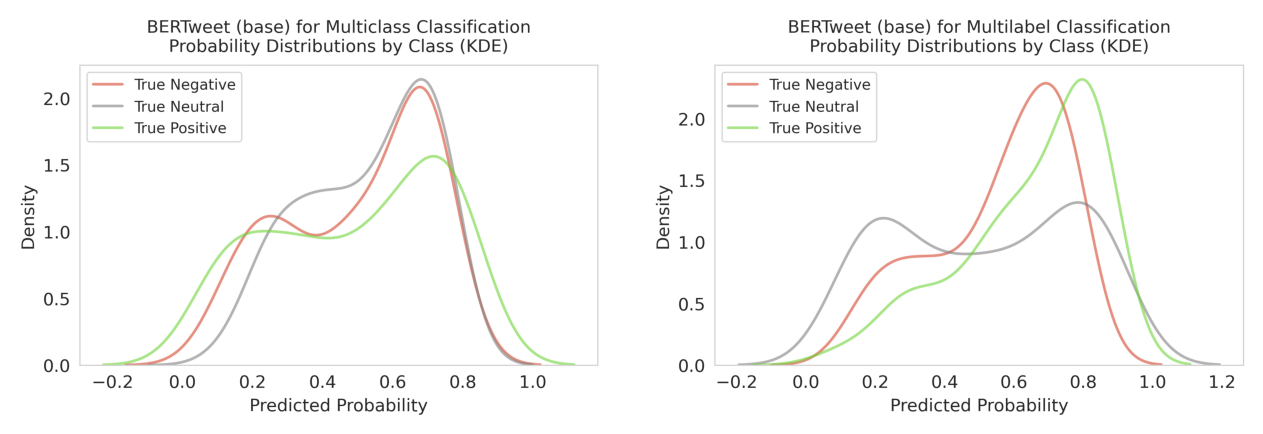

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the paths to the existing plots
mc_plot_path = '/workspace/Output/BERTweet/BERTweet_MC/BERTweet_base_MC/Figures/BERTweet_base_MC_probability_distributions.png'
ml_plot_path = '/workspace/Output/BERTweet/BERTweet_ML/BERTweet_base_ML/Figures/BERTweet_base_ML_probability_distributions.png'

# Create figure with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4.5))

# Read and display the first plot (Multiclass)
img1 = mpimg.imread(mc_plot_path)
ax1.imshow(img1)
ax1.axis('off')  # Turn off axis for cleaner look

# Read and display the second plot (Multilabel)
img2 = mpimg.imread(ml_plot_path)
ax2.imshow(img2)
ax2.axis('off')  # Turn off axis for cleaner look

plt.tight_layout()

# Create output directory if it doesn't exist
output_dir = '/workspace/Output/BERTweet/Comparison'
os.makedirs(output_dir, exist_ok=True)

# Save the combined figure
combined_path = os.path.join(output_dir, 'BERTweet_base_combined_probability_distributions.png')
plt.savefig(combined_path, dpi=300, bbox_inches='tight')

plt.show()

In [33]:
# Calculate and display total notebook execution time
end_global_notebook_running_time = time.time()
duration_global_notebook = end_global_notebook_running_time - start_global_notebook_running_time
hours, remainder = divmod(duration_global_notebook, 3600)
minutes, seconds = divmod(remainder, 60)

# Create the HTML string with bold formatting and modified separator
html_output = f"""<b>{'-' * 40} Total Notebook Execution Time: {int(hours):02d}:{int(minutes):02d}:{int(seconds):02d} {'-' * 40}</b>"""

# Display the HTML output
display(HTML(html_output))